# Seq2seq models tutorial

In this tutorial we go through the details of building seq2seq models in Keras, and explore different models for different problem setups.

This tutorial includes:

- Vanilla seq2seq models for NMT.
- Effect of Embedding layer with zero masking.
- Adding attention + visualization: Luong vs. Bahdanau attention with LSTM.
- Char level models for OOV applications (spelling correction, chatbots).
- Issues with char models and possible fixes.


# Vanilla seq2seq

We will build a Neural Machine Translation (NMT) model based on the following paper: [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)

![Vanilla seq2seq](https://d3i71xaburhd42.cloudfront.net/673fa8ca55db79acdd88d50b465ec4580166fe09/2-Figure1-1.png)

In [ ]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from sklearn.model_selection import train_test_split

from keras.layers import Input, LSTM, Embedding, Dense, Bidirectional, Concatenate, Dot, Activation, TimeDistributed
from keras.models import Model
from keras.utils import plot_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Data loading

In [ ]:
!wget http://www.manythings.org/anki/fra-eng.zip
!unzip fra-eng.zip -d fra-eng


--2020-05-23 01:27:42--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:3033::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5982778 (5.7M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   5.71M  2.67MB/s    in 2.1s    

2020-05-23 01:27:45 (2.67 MB/s) - ‘fra-eng.zip’ saved [5982778/5982778]

Archive:  fra-eng.zip
  inflating: fra-eng/_about.txt      
  inflating: fra-eng/fra.txt         


In [ ]:
data_path = 'fra-eng/fra.txt'
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
inputs = []
targets = []
num_samples = 10000  # Number of samples to train on.
for line in lines[: min(num_samples, len(lines) - 1)]:

  input, target, _ = line.split('\t')    
  inputs.append(input)
  targets.append(target)

In [ ]:
lines = pd.DataFrame({'input':inputs, 'target':targets})

In [ ]:
num_samples = 10000
lines = lines[0:num_samples]

In [ ]:
lines.shape

(10000, 2)

In [ ]:
lines.head(10)

,input,target
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !
5,Who?,Qui ?
6,Wow!,Ça alors !
7,Fire!,Au feu !
8,Help!,À l'aide !
9,Jump.,Saute.


# Data preparation

In [ ]:
def cleanup(lines):
  # Since we work on word level, if we normalize the text to lower case, this will reduce the vocabulary. It's easy to recover the case later. 
  lines.input=lines.input.apply(lambda x: x.lower())
  lines.target=lines.target.apply(lambda x: x.lower())

  # To help the model capture the word separations, mark the comma with special token:
  lines.input=lines.input.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))
  lines.target=lines.target.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))

  # Clean up punctuations and digits. Such special chars are common to both domains, and can just be copied with no error.
  exclude = set(string.punctuation)
  lines.input=lines.input.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
  lines.target=lines.target.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

  remove_digits = str.maketrans('', '', digits)
  lines.input=lines.input.apply(lambda x: x.translate(remove_digits))
  lines.target=lines.target.apply(lambda x: x.translate(remove_digits))

  #return lines
    

In [ ]:
st_tok = 'START_'
end_tok = '_END'
def data_prep(lines):
  cleanup(lines)
  lines.target = lines.target.apply(lambda x : st_tok + ' ' + x + ' ' + end_tok)

To help the model identiy the start and end of sequence, we mark them by special tokens. This will help the decoding process later:

In [ ]:
data_prep(lines)

In [ ]:
lines.head()

,input,target
0,go,START_ va _END
1,hi,START_ salut _END
2,hi,START_ salut _END
3,run,START_ cours _END
4,run,START_ courez _END


# Word level model (word2word)

In this section we process the text at the word level, both for `input` and `target` domains.

In [ ]:
def tok_split_word2word(data):
  return data.split()

In [ ]:
tok_split_fn = tok_split_word2word

In [ ]:
def data_stats(lines, input_tok_split_fn, target_tok_split_fn):
  input_tokens=set()
  for line in lines.input:
      for tok in input_tok_split_fn(line):
          if tok not in input_tokens:
              input_tokens.add(tok)
      
  target_tokens=set()
  for line in lines.target:
      for tok in target_tok_split_fn(line):
          if tok not in target_tokens:
              target_tokens.add(tok)
  input_tokens = sorted(list(input_tokens))
  target_tokens = sorted(list(target_tokens))

  num_encoder_tokens = len(input_tokens)
  num_decoder_tokens = len(target_tokens)
  max_encoder_seq_length = np.max([len(input_tok_split_fn(l)) for l in lines.input])
  max_decoder_seq_length = np.max([len(target_tok_split_fn(l)) for l in lines.target])

  return input_tokens, target_tokens, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length



In [ ]:
input_tokens, target_tokens, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length = data_stats(lines, input_tok_split_fn=tok_split_fn, target_tok_split_fn=tok_split_fn)
print('Number of samples:', len(lines))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 2131
Number of unique output tokens: 4545
Max sequence length for inputs: 5
Max sequence length for outputs: 12


## Vocab

When building our vocab, we should keep a special entry for the PAD token, _always_ at the entry 0 of the vocab table. Of course this only happens when we pad with 0's. In general the padded token should be reserved, and NEVER used by any other token (otherwise we won't tell the difference between REAL 0 and PAD 0).

In [ ]:
pad_tok = 'PAD'
sep_tok = ' '
special_tokens = [pad_tok, sep_tok, st_tok, end_tok] 
num_encoder_tokens += len(special_tokens)
num_decoder_tokens += len(special_tokens)

In [ ]:

def vocab(input_tokens, target_tokens):
  
  input_token_index = {}
  target_token_index = {}
  for i,tok in enumerate(special_tokens):
    input_token_index[tok] = i
    target_token_index[tok] = i 

  offset = len(special_tokens)
  for i, tok in enumerate(input_tokens):
    input_token_index[tok] = i+offset

  for i, tok in enumerate(target_tokens):
    target_token_index[tok] = i+offset
   
  # Reverse-lookup token index to decode sequences back to something readable.
  reverse_input_tok_index = dict(
      (i, tok) for tok, i in input_token_index.items())
  reverse_target_tok_index = dict(
      (i, tok) for tok, i in target_token_index.items())
  return input_token_index, target_token_index, reverse_input_tok_index, reverse_target_tok_index

In [ ]:
input_token_index, target_token_index, reverse_input_tok_index, reverse_target_tok_index = vocab(input_tokens, target_tokens)

# Vectorization

Also, when we vectorize, if we pad 0 (or any token), we need to set the corresponding target.

Below, we should set all `decoder_target_data` to the OHE corresponding the entry 0 (or whatever entry of PAD).

For example, if we pad with 0, and 0 is the first entry in vocab, then it's `decoder_target_data` must be [1,0,0,....0].
However, this is not needed if we use `mask_zero` in `Embedding`, or using a masking layer with LSTM, because those values wont be fed fwd anyway, and will not be considered in loss.

In [ ]:
max_encoder_seq_length = 16
max_decoder_seq_length = 16

In [ ]:
def init_model_inputs(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens):
  encoder_input_data = np.zeros(
      (len(lines.input), max_encoder_seq_length),
      dtype='float32')
  decoder_input_data = np.zeros(
      (len(lines.target), max_decoder_seq_length),
      dtype='float32')
  decoder_target_data = np.zeros(
      (len(lines.target), max_decoder_seq_length, num_decoder_tokens),
      dtype='float32')
  
  return encoder_input_data, decoder_input_data, decoder_target_data

In [ ]:
def vectorize(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens, input_tok_split_fn, target_tok_split_fn):
  encoder_input_data, decoder_input_data, decoder_target_data = init_model_inputs(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens)
  for i, (input_text, target_text) in enumerate(zip(lines.input, lines.target)):
      for t, tok in enumerate(input_tok_split_fn(input_text)):
          encoder_input_data[i, t] = input_token_index[tok]
      encoder_input_data[i, t+1:] = input_token_index[pad_tok]
      for t, tok in enumerate(target_tok_split_fn(target_text)):
          # decoder_target_data is ahead of decoder_input_data by one timestep
          decoder_input_data[i, t] = target_token_index[tok]         
          if t > 0:
              # decoder_target_data will be ahead by one timestep
              # and will not include the start character.
              decoder_target_data[i, t - 1, target_token_index[tok]] = 1.
      decoder_input_data[i, t+1:] = target_token_index[pad_tok] 
      decoder_target_data[i, t:, target_token_index[pad_tok]] = 1.          
              
  return encoder_input_data, decoder_input_data, decoder_target_data              

In [ ]:
encoder_input_data, decoder_input_data, decoder_target_data  = vectorize(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens, input_tok_split_fn=tok_split_fn, target_tok_split_fn=tok_split_fn)

# Model

In [ ]:
emb_sz = 50

#### Encoder model

The LSTM is characterized by two internal tensors:
- cell state $C_t$: what to copy from past $C_{t-1}$ (after forgetting some info through sigmoid $f_t$) and what to take from the merge of last $h_{t-1}$ and current input $x_t$ 
- hidden state $h_t$: same as hidden state of normal RNNs. This affects the output of the LSTM Cell

We usually refer to the combination $[C_t, h_t]$ as the LSTM state at time step $t$.

So the inputs to LSTM are:
- $[C_{t-1}, h_{t-1}]$ = previous state
- $x_t$ = input tokens

And the outputs are:
- $[C_{t}, h_{t}]$


![LSTM Cell](https://www.researchgate.net/profile/Savvas_Varsamopoulos/publication/329362532/figure/fig5/AS:699592479870977@1543807253596/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell.jpg)

According to this nice [illustration](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/), when we feedfwd into LSTM, we can control the return from keras as follows:

- `return_state`: asks LSTM to return both states: $C_t$ and $h_t$. Three outputs are returned: $h_t$, $h_t$, $C_t$
- `return_sequence`: asks the unrollled LSTM to return its state $[C_t, h_t]$ for all $t \in [t_0,T]$. In this case 3 outputs are returned: [$h_{t_0}$, .., $h_T$], $h_T$, $C_T$

In the encoder model, we are interested in the last combined state [$h_t$, $C_t$]

#### Decoder model

In the decoder, we are interested in:
- intialize its hidden state from where the encoder ended `initial_state`=[$h_t$, $C_t$]
- the sequence outputs [$h_{t_0}$, .., $h_T$] returned thanks to `return_states`, which will be used to generate the output tokens through the final `softmax`.

The decoder is just another LSTM with the normal 2 inputs:
- $[C_{t-1}, h_{t-1}]$, where $[C_{0}, h_{0}]$ = encoder final state $[C_{T}, h_{T}]$
- $x_t$ = target tokens, shifted by one `start_tok` = `START_`, where $x_0$ = `START_` to kick-start the decoder input, coupled with the encoder final state.

Feeding the GT target tokens during training is called ___Teacher forcing___. This won't be straight forward using Keras, since it requires a dynamic graph to handle the _if_ condition of teacher forcing or free run mode (like in inference mode, taking the previous output). May be later using Eager execution.

During inference $x_t$ of the decoder, will just be the previous output $x_{t-1}$.

![enc-dec](https://miro.medium.com/max/3170/1*sO-SP58T4brE9EHazHSeGA.png)

Sometimes, it's helpful to switch between the GT target_tokens are inputs to the decoder during training, and sometimes take the previous output $x_{t-1}$ as will happen in the inference, so that the decoder is trained to recover from his mistakes.

In [ ]:
def seq2seq(num_decoder_tokens, num_encoder_tokens, emb_sz, lstm_sz):
  encoder_inputs = Input(shape=(None,))
  en_x=  Embedding(num_encoder_tokens, emb_sz)(encoder_inputs)
  encoder = LSTM(lstm_sz, return_state=True)
  encoder_outputs, state_h, state_c = encoder(en_x)
  # We discard `encoder_outputs` and only keep the states.
  encoder_states = [state_h, state_c]
  
  # Encoder model
  encoder_model = Model(encoder_inputs, encoder_states)
  
  
  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = Input(shape=(None,))

  dex=  Embedding(num_decoder_tokens, emb_sz)

  final_dex= dex(decoder_inputs)


  decoder_lstm = LSTM(lstm_sz, return_sequences=True, return_state=True)

  decoder_outputs, _, _ = decoder_lstm(final_dex,
                                      initial_state=encoder_states)

  decoder_dense = Dense(num_decoder_tokens, activation='softmax')

  decoder_outputs = decoder_dense(decoder_outputs)

  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])


  
  # Decoder model: Re-build based on explicit state inputs. Needed for step-by-step inference:
  decoder_state_input_h = Input(shape=(lstm_sz,))
  decoder_state_input_c = Input(shape=(lstm_sz,))
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

  decoder_outputs2, state_h2, state_c2 = decoder_lstm(final_dex, initial_state=decoder_states_inputs)
  decoder_states2 = [state_h2, state_c2]
  decoder_outputs2 = decoder_dense(decoder_outputs2)
  decoder_model = Model(
  [decoder_inputs] + decoder_states_inputs,
  [decoder_outputs2] + decoder_states2)  

  return model, encoder_model, decoder_model


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     106750      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 50)     227450      input_2[0][0]                    
____________________________________________________________________________________________

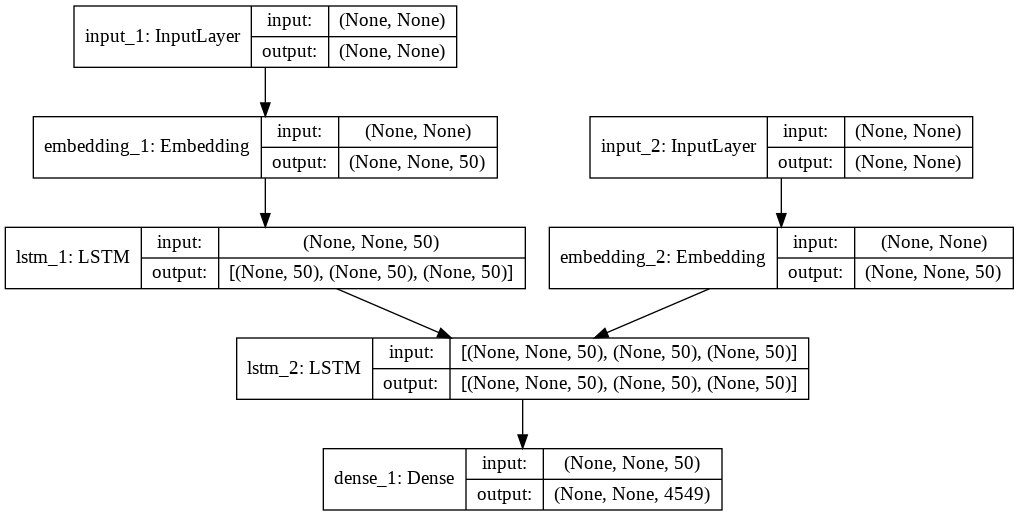

In [ ]:
model, encoder_model, decoder_model = seq2seq(num_decoder_tokens, num_encoder_tokens, emb_sz, emb_sz)
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

#### Fit the model

In [ ]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=64,
          epochs=30,
          validation_split=0.05)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9500 samples, validate on 500 samples
Epoch 1/30
9500/9500 [==============================] - 13s 1ms/step - loss: 3.0437 - acc: 0.7313 - val_loss: 1.6489 - val_acc: 0.7329
Epoch 2/30
9500/9500 [==============================] - 11s 1ms/step - loss: 1.3999 - acc: 0.7889 - val_loss: 1.4329 - val_acc: 0.7956
Epoch 3/30
9500/9500 [==============================] - 11s 1ms/step - loss: 1.2475 - acc: 0.8145 - val_loss: 1.3805 - val_acc: 0.7956
Epoch 4/30
9500/9500 [==============================] - 11s 1ms/step - loss: 1.1852 - acc: 0.8194 - val_loss: 1.3468 - val_acc: 0.7965
Epoch 5/30
9500/9500 [==============================] - 11s 1ms/step - loss: 1.1434 - acc: 0.8231 - val_loss: 1.3251 - val_acc: 0.7969
Epoch 6/30
9500/9500 [==============================] - 11s 1ms/step - loss: 1.1114 - acc: 0.8264 - val_loss: 1.3079 - val_acc: 0.8044
Epoch 7/30
9500/9500 [==============================] - 11s 1ms/step - loss: 1.0832 - acc: 0.8310 - val_loss: 1.2870 - val_acc: 0.8120
Epoch 8/

# Embedding + `mask_zero`

In [ ]:
def seq2seq(num_decoder_tokens, num_encoder_tokens, emb_sz, lstm_sz):
  encoder_inputs = Input(shape=(None,))
  en_x=  Embedding(num_encoder_tokens, emb_sz, mask_zero=True)(encoder_inputs)
  encoder = LSTM(lstm_sz, return_state=True)
  encoder_outputs, state_h, state_c = encoder(en_x)
  # We discard `encoder_outputs` and only keep the states.
  encoder_states = [state_h, state_c]
  
  # Encoder model
  encoder_model = Model(encoder_inputs, encoder_states)
  
  
  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = Input(shape=(None,))

  dex=  Embedding(num_decoder_tokens, emb_sz, mask_zero=True)

  final_dex= dex(decoder_inputs)


  decoder_lstm = LSTM(lstm_sz, return_sequences=True, return_state=True)

  decoder_outputs, _, _ = decoder_lstm(final_dex,
                                      initial_state=encoder_states)

  decoder_dense = Dense(num_decoder_tokens, activation='softmax')

  decoder_outputs = decoder_dense(decoder_outputs)

  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])


  
  # Decoder model: Re-build based on explicit state inputs. Needed for step-by-step inference:
  decoder_state_input_h = Input(shape=(lstm_sz,))
  decoder_state_input_c = Input(shape=(lstm_sz,))
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

  decoder_outputs2, state_h2, state_c2 = decoder_lstm(final_dex, initial_state=decoder_states_inputs)
  decoder_states2 = [state_h2, state_c2]
  decoder_outputs2 = decoder_dense(decoder_outputs2)
  decoder_model = Model(
  [decoder_inputs] + decoder_states_inputs,
  [decoder_outputs2] + decoder_states2)  

  return model, encoder_model, decoder_model
emb_sz = 256
model, encoder_model, decoder_model = seq2seq(num_decoder_tokens, num_encoder_tokens, emb_sz, emb_sz)
print(model.summary())
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=64,
          epochs=10,
          validation_split=0.2)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 256)    546560      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 256)    1164544     input_6[0][0]                    
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 13s 2ms/step - loss: 1.4202 - acc: 0.3855 - val_loss: 1.3888 - val_acc: 0.4047
Epoch 2/10
8000/8000 [==============================] - 13s 2ms/step - loss: 1.0995 - acc: 0.4794 - val_loss: 1.2825 - val_acc: 0.4587
Epoch 3/10
8000/8000 [==============================] - 12s 2ms/step - loss: 0.9789 - acc: 0.5282 - val_loss: 1.1887 - val_acc: 0.5056
Epoch 4/10
8000/8000 [==============================] - 13s 2ms/step - loss: 0.8960 - acc: 0.5587 - val_loss: 1.1356 - val_acc: 0.5362
Epoch 5/10
8000/8000 [==============================] - 13s 2ms/step - loss: 0.8337 - acc: 0.5812 - val_loss: 1.1019 - val_acc: 0.5533
Epoch 6/10
8000/8000 [==============================] - 13s 2ms/step - loss: 0.7810 - acc: 0.6011 - val_loss: 1.0769 - val_acc: 0.5627
Epoch 7/10
8000/8000 [==============================] - 12s 2ms/step - loss: 0.7338 - acc: 0.6160 - val_loss: 1.0597 - val_acc: 0.5703
Epoch 8

Adding `mask_zero` in Embedding would stop any input zeros (padding) from propagating through the network

But what about the output? It remains same as last one!:

https://stackoverflow.com/questions/47485216/how-does-mask-zero-in-keras-embedding-layer-work/53470422

So the output accuracy is hurt, since the GT assumes ALL 0's!

However, the mask should be passed to subsequent layers, so something is wrong!

The reason is that, with mask_zero we don't include all the padded words to the accuracy calculation. Adding those words makes it easy to the network to predict the correct output for them, since we add a special token for that (PAD-->0), and we mark the end of the  sequence with another special token (END), so it's easy to capture the pattern after END to produce the correct output. So adding those padded words would just increase _false_ accuracy. Similar to the class imbalance problem, the dominant class now wil be the PAD words. Adding mask_zero will include just the _important_ words in accuracy calculation.


# Inference

The inference process involves decoding the output using sequential process of:
- Encode the whole input sequence
- Kick-start the decoder with the final encoder state + the start_token
- Feed-back the output of the decoder to its input (instead of teacher forcing in training).

This will create a need to build _view_ decoder model with the following `list` of inputs:
- `decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]` --> from the encoder final $h_T, C_T$. This will be the decoder initial state $h_0, C_0$
- `decoder_inputs` = `start_tok` + `decoder_outputs` --> $x_{t-1}$, with $x_0$ = `start_tok`

And outputs:
- `decoder_outputs`: $x_t$; softmax tokens probabilities 
- `decoder_states`: [$h_t,C_t$]

#### Create sampling model

In [ ]:
decoder_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 256)    1164544     input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 256)          0                                            
____________________________________________________________________________________________

#### Function to generate sequences

In [ ]:
def decode_sequence(input_seq, sep=' '):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index[st_tok]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_tok = reverse_target_tok_index[sampled_token_index]
        decoded_sentence += sep + sampled_tok

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_tok == end_tok or
           len(decoded_sentence) > 52):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

#### Look at the some translations

In [ ]:
for seq_index in range(100): #[14077,20122,40035,40064, 40056, 40068, 40090, 40095, 40100, 40119, 40131, 40136, 40150, 40153]:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', lines.input[seq_index: seq_index + 1])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: 0    go
Name: input, dtype: object
Decoded sentence:  à vous a plaît _END
-
Input sentence: 1    hi
Name: input, dtype: object
Decoded sentence:  les chiens _END
-
Input sentence: 2    hi
Name: input, dtype: object
Decoded sentence:  les chiens _END
-
Input sentence: 3    run
Name: input, dtype: object
Decoded sentence:  prends le monde _END
-
Input sentence: 4    run
Name: input, dtype: object
Decoded sentence:  prends le monde _END
-
Input sentence: 5    who
Name: input, dtype: object
Decoded sentence:  qui est monde _END
-
Input sentence: 6    wow
Name: input, dtype: object
Decoded sentence:  tout le monde est monde _END
-
Input sentence: 7    fire
Name: input, dtype: object
Decoded sentence:  les chiens est jambes _END
-
Input sentence: 8    help
Name: input, dtype: object
Decoded sentence:  continue à le monde _END
-
Input sentence: 9    jump
Name: input, dtype: object
Decoded sentence:  les chiens _END
-
Input sentence: 10    stop
Name: input, dtype: object
Deco

# seq2seq + Attention

The vanilla seq2seq suffers a severe drawback, all the decoded outputs are initiated from the _final_ internal state of the encoder. The objective is to mimic the reading process in humans, where the whole sequence is comprehended first, then translation (decoding) happens based on that. 

However, it is clear that, even we as humans will not generate the whole translations without looking back at the _concerned_ parts of the input text. In other words, every translated word is usually generated by _attending_ to certain words in the input, in sequence.

So it is better to _condition_ the decoded words on certain words of the input. But who decides which words to attend to when generating/decoding output word?

## Bahdanau attention
The idea of attention in seq2seq was introduced in [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473):

![Bahdanau](https://pravn.files.wordpress.com/2017/11/bahdanau.png?w=203)

The decoder LSTM will have the following inputs:
- previous outputs $y_{t-1}$
- state composed of concatenation of:

1- previous state $s_{t-1}$ = $[h_{t-1}, C_{t-1}]$

2- context vector $c_t$ = weighted/gated encoder states $h_j$ = $\sum_{j=0}^{j=T} \alpha_{tj}h_j$ 

$\alpha_{tj}$ are the ___attention___ weights. Those can be visualized as the importance of input word $j$ when decoding output word $t$:

![att_map](https://miro.medium.com/max/6400/1*T6oosC9Y9vS5AIh4GzcsNQ.png)

__How to find those weights?__

The alphas can be learnable. However, they must be related somehow to the simialrity between input word $j$ and output word $t$.

In the paper [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473), this simialrity measure was _leaned_ using a feedforward NN $a$, which generates a score $e_{tj}$ based on leanable weights over the last decoder state and the encoder state: $e_{tj} = a(s_{t-1}, h_j)$. Those scores are then normalized via simple _softmax_.




## Luong attention
In [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025), other simialrity measures are studied to encode the _attention map weights_ or $\alpha_{tj}$. Three simialrity scores $e_{tj}$are studied:
- general = weighted dot product
- concat = Bahdanau (weighted dot + tanh)
- dot = simple dot product

Again, the alphas are just simple softmax: $\alpha_{tj} = softmax(e_{tj})$ over $j \in [0,T]$ in the encoder state $h_j$
Moreover, in Bahdanaus, in Bi-LSTM, both directions states are concatenated. While in Luong, only the top one is used.

![Luing_vs_Bahdanau](https://miro.medium.com/max/1000/1*BfwFEH4tgY-JwHxr-2D2KQ.png)

In our experiments, we adopt the simpler Luong, with dot configuration.

In [ ]:
def seq2seq_attention(num_encoder_tokens, num_decoder_tokens, emb_sz, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    encoder_inputs_ = Embedding(num_encoder_tokens, emb_sz, mask_zero=True)(encoder_inputs)    
    
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    print(encoder_states)
    
    decoder_inputs = Input(shape=(None,))
    decoder_inputs_ = Embedding(num_decoder_tokens, emb_sz, mask_zero=True)(decoder_inputs)    
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)

    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    print(decoder_outputs)
    print(encoder_outputs)
    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax', name='attention')
    attention = att_activation(attention)
    print('attention', attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])

    # Has another weight + tanh layer as described in equation (5) of the paper

    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

    print('encoder-decoder  model:')
    print(model.summary()) 
    
    print(encoder_inputs)
    print(encoder_outputs)
    print(encoder_states)
    encoder_model = Model(input=encoder_inputs, output=[encoder_outputs] + encoder_states)

    decoder_encoder_inputs = Input(shape=(None, latent_dim*2,))
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)

    
    decoder_states = [state_h, state_c]
    
    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    
    attention = att_dot([decoder_outputs, decoder_encoder_inputs])
    
    attention = att_activation(attention)
    
    context = context_dot([attention, decoder_encoder_inputs])
    
    
    
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    
    # Has another weight + tanh layer as described in equation (5) of the paper
    
    decoder_outputs = decoder_dense(decoder_combined_context)
    
    decoder_model = Model(
        [decoder_inputs, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs, attention] + decoder_states)
    
    return model, encoder_model, decoder_model

[<tf.Tensor 'concatenate_1/concat:0' shape=(None, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(None, 512) dtype=float32>]
Tensor("lstm_6/transpose_2:0", shape=(None, None, 512), dtype=float32)
Tensor("bidirectional_1/concat:0", shape=(None, None, 512), dtype=float32)
attention Tensor("attention/truediv:0", shape=(None, None, None), dtype=float32)
encoder-decoder  model:
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 256)    546560      input_9[0][0]                    
________________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


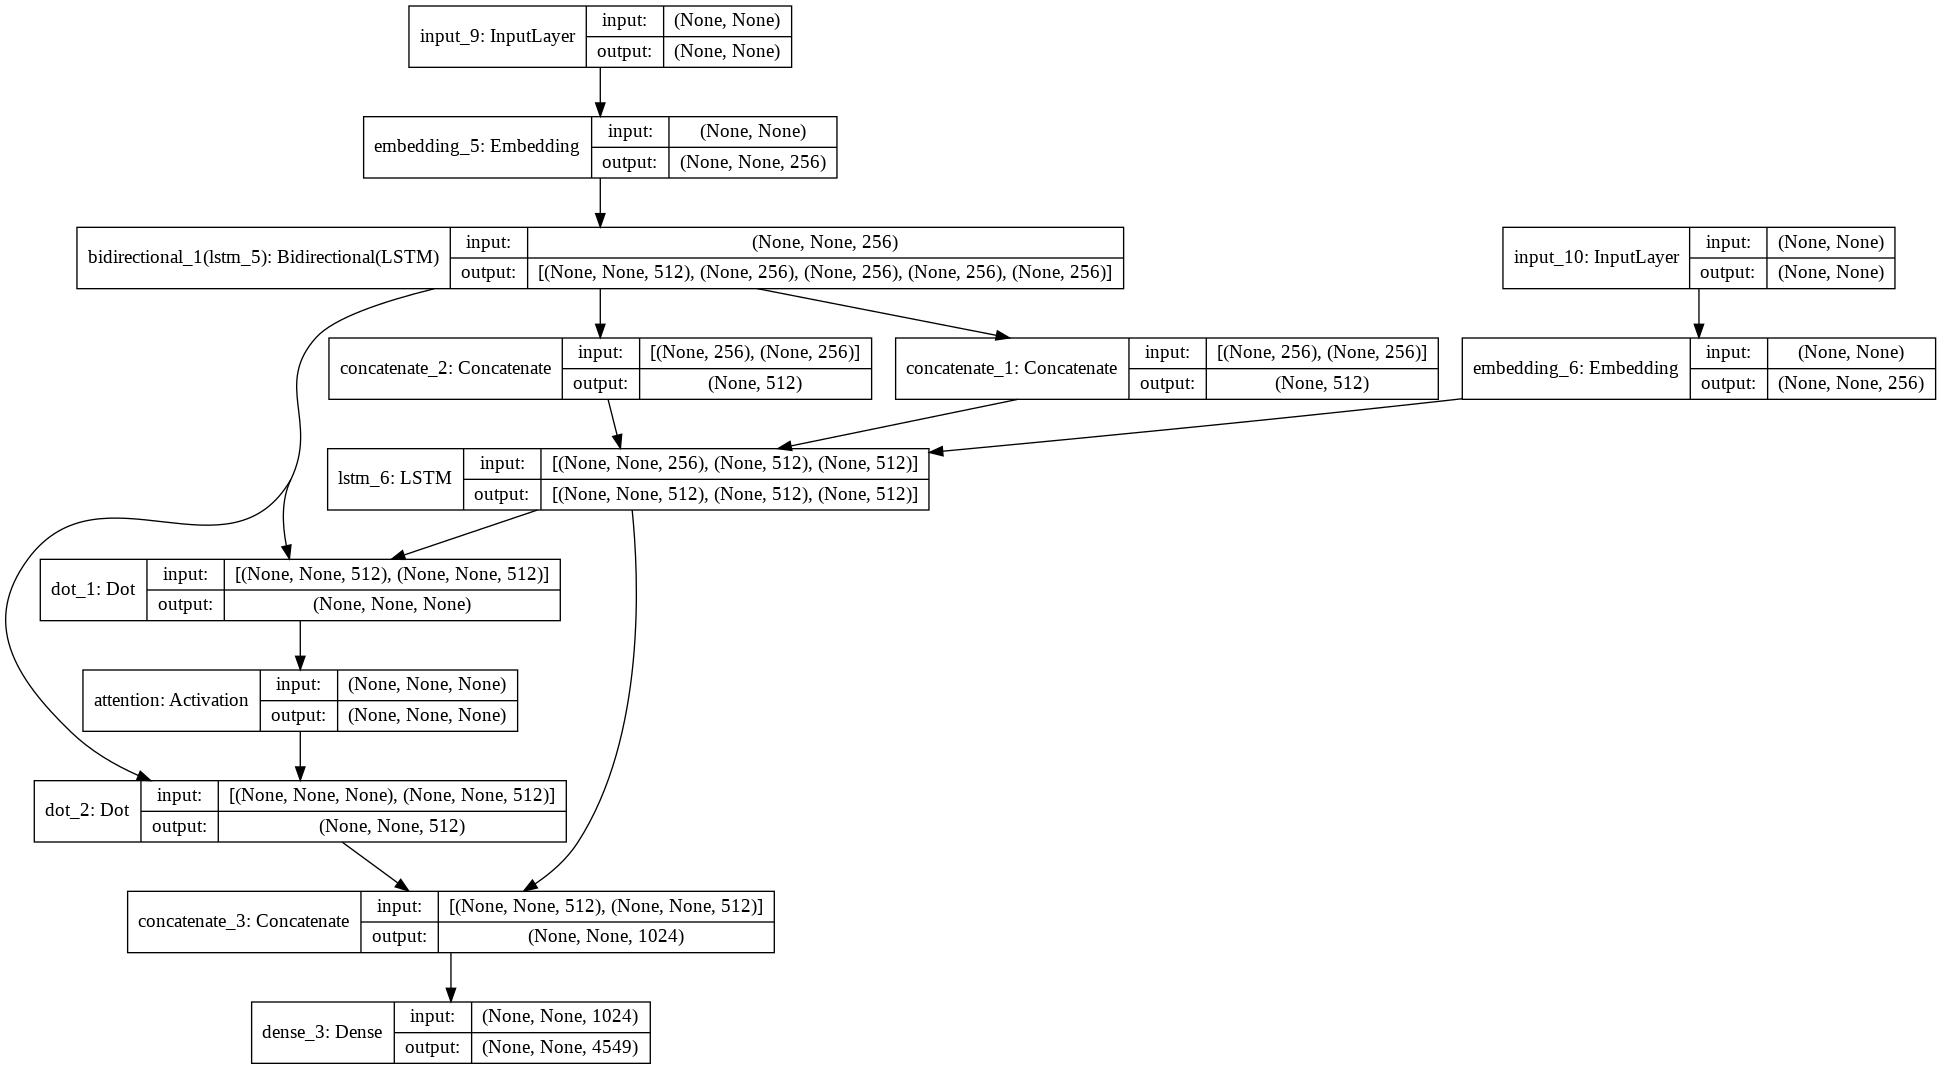

In [ ]:
model, encoder_model, decoder_model = seq2seq_attention(num_encoder_tokens, num_decoder_tokens, emb_sz=emb_sz, latent_dim=emb_sz)
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:

model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=128,
          epochs=20,
          validation_split=0.05)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9500 samples, validate on 500 samples
Epoch 1/20
9500/9500 [==============================] - 14s 2ms/step - loss: 1.4664 - acc: 0.3779 - val_loss: 1.3899 - val_acc: 0.3853
Epoch 2/20
9500/9500 [==============================] - 13s 1ms/step - loss: 1.1044 - acc: 0.4792 - val_loss: 1.2243 - val_acc: 0.4418
Epoch 3/20
9500/9500 [==============================] - 13s 1ms/step - loss: 0.9323 - acc: 0.5428 - val_loss: 1.0892 - val_acc: 0.4964
Epoch 4/20
9500/9500 [==============================] - 13s 1ms/step - loss: 0.8125 - acc: 0.5806 - val_loss: 1.0320 - val_acc: 0.5252
Epoch 5/20
9500/9500 [==============================] - 13s 1ms/step - loss: 0.7185 - acc: 0.6127 - val_loss: 1.0010 - val_acc: 0.5514
Epoch 6/20
9500/9500 [==============================] - 13s 1ms/step - loss: 0.6403 - acc: 0.6380 - val_loss: 0.9748 - val_acc: 0.5438
Epoch 7/20
9500/9500 [==============================] - 13s 1ms/step - loss: 0.5733 - acc: 0.6624 - val_loss: 0.9497 - val_acc: 0.5605
Epoch 8/

In [ ]:
def decode_sequence_attention(input_seq, sep=' '):
    # Encode the input as state vectors.
    encoder_outputs, h, c = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index[st_tok]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    attention_density = []
    while not stop_condition:
        output_tokens, attention, h, c  = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)
        attention_density.append(attention[0][0])# attention is max_sent_len x 1 since we have num_time_steps = 1 for the output
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_tok = reverse_target_tok_index[sampled_token_index]
        decoded_sentence += sep + sampled_tok

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_tok == end_tok or
           len(decoded_sentence) > 52):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
    attention_density = np.array(attention_density)
    return decoded_sentence, attention_density

In [ ]:
word_decoded_sents = []
for seq_index in range(100): #[14077,20122,40035,40064, 40056, 40068, 40090, 40095, 40100, 40119, 40131, 40136, 40150, 40153]:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence, attention = decode_sequence_attention(input_seq)
    print('-')
    print('Input sentence:', lines.input[seq_index: seq_index + 1])
    print('Decoded sentence:', decoded_sentence)
    word_decoded_sents.append(decoded_sentence)

-
Input sentence: 0    go
Name: input, dtype: object
Decoded sentence:  va _END
-
Input sentence: 1    hi
Name: input, dtype: object
Decoded sentence:  salut _END
-
Input sentence: 2    hi
Name: input, dtype: object
Decoded sentence:  salut _END
-
Input sentence: 3    run
Name: input, dtype: object
Decoded sentence:  cours _END
-
Input sentence: 4    run
Name: input, dtype: object
Decoded sentence:  cours _END
-
Input sentence: 5    who
Name: input, dtype: object
Decoded sentence:  qui sen a fait _END
-
Input sentence: 6    wow
Name: input, dtype: object
Decoded sentence:  ça _END
-
Input sentence: 7    fire
Name: input, dtype: object
Decoded sentence:  à la bonne heure _END
-
Input sentence: 8    help
Name: input, dtype: object
Decoded sentence:  ça _END
-
Input sentence: 9    jump
Name: input, dtype: object
Decoded sentence:  vraiment _END
-
Input sentence: 10    stop
Name: input, dtype: object
Decoded sentence:  ça suffit _END
-
Input sentence: 11    stop
Name: input, dtype: object


In [ ]:
def visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab, tok_split_fn, sep= ' '):

    encoder_input_data = np.zeros((1, max_encoder_seq_length), dtype='float32')
    
    for t, word in enumerate(tok_split_fn(text)):
        encoder_input_data[0, t] = input_token_index[word]

    input_seq = encoder_input_data[0:1]

    decoded_sentence, attention_density = decode_sequence_attention(input_seq, sep)

    plt.clf()
    plt.figure(figsize=(28,12))
    
    ax = sns.heatmap(attention_density[:, : len(text) + 2],
        xticklabels=[w for w in tok_split_fn(text)],
        yticklabels=[w for w in tok_split_fn(decoded_sentence)])

    ax.invert_yaxis()
    plt.show()
    
    return decoded_sentence

-
Input sentence: go
GT sentence: START_ va  _END


<Figure size 432x288 with 0 Axes>

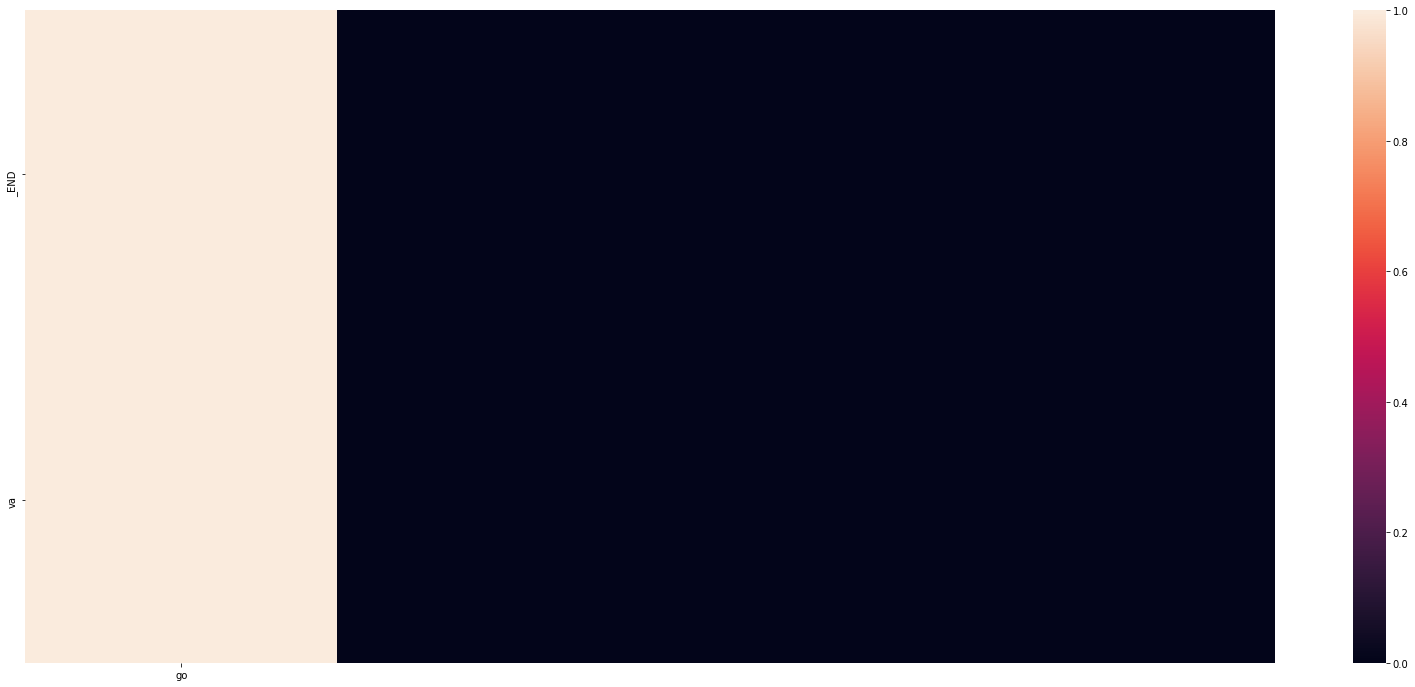

Decoded sentence:  va _END
-
Input sentence: hi
GT sentence: START_ salut  _END


<Figure size 432x288 with 0 Axes>

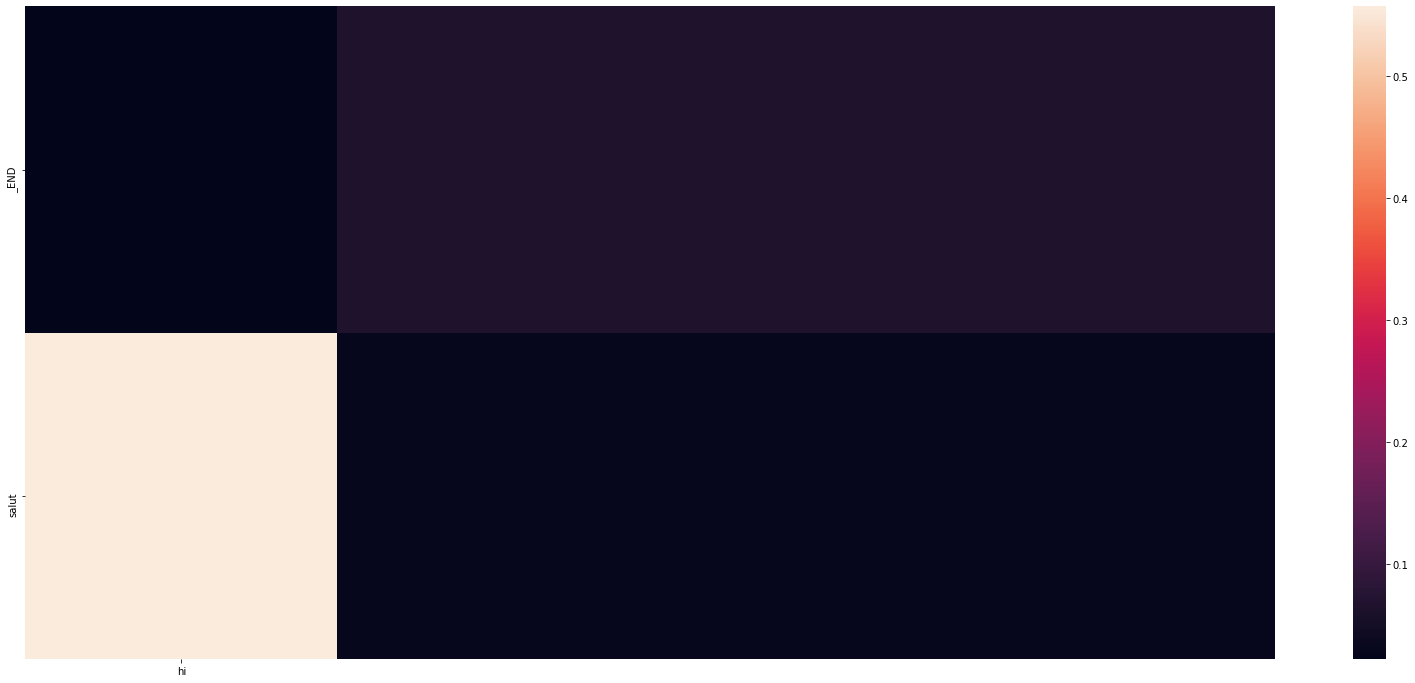

Decoded sentence:  salut _END
-
Input sentence: hi
GT sentence: START_ salut _END


<Figure size 432x288 with 0 Axes>

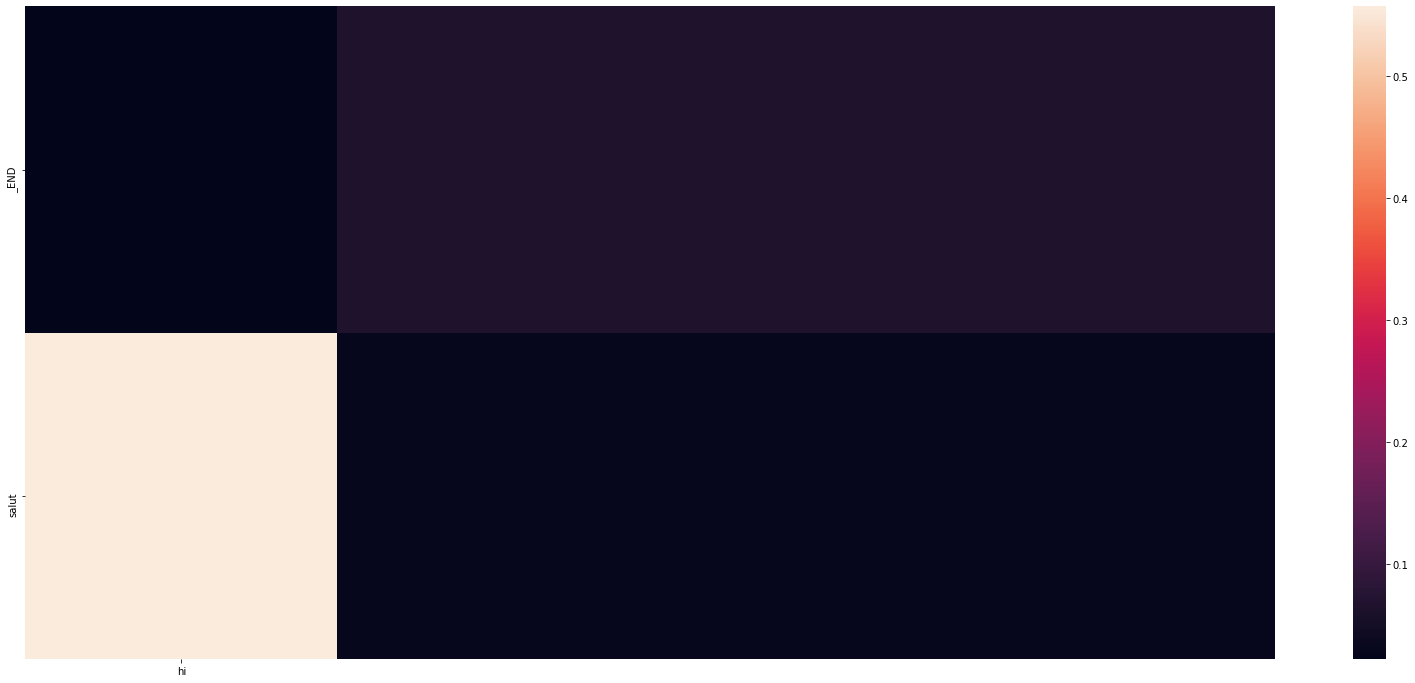

Decoded sentence:  salut _END
-
Input sentence: run
GT sentence: START_ cours  _END


<Figure size 432x288 with 0 Axes>

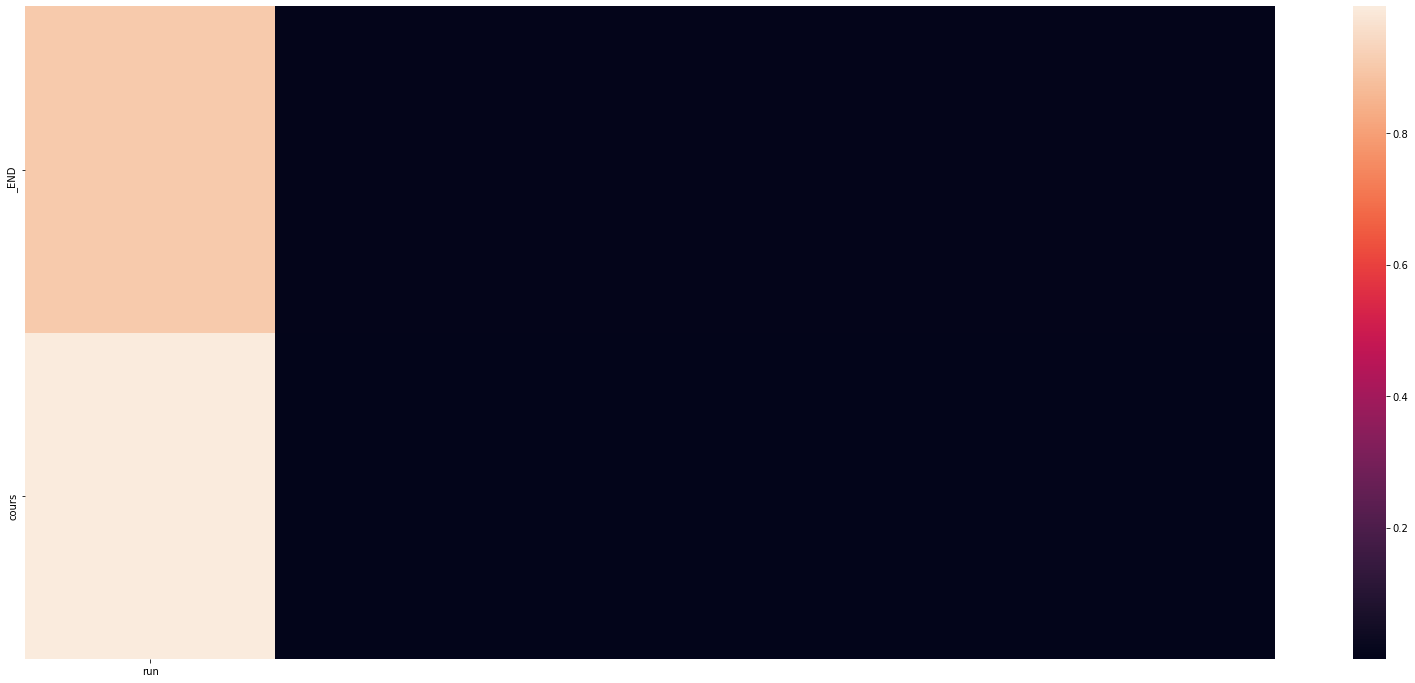

Decoded sentence:  cours _END
-
Input sentence: run
GT sentence: START_ courez  _END


<Figure size 432x288 with 0 Axes>

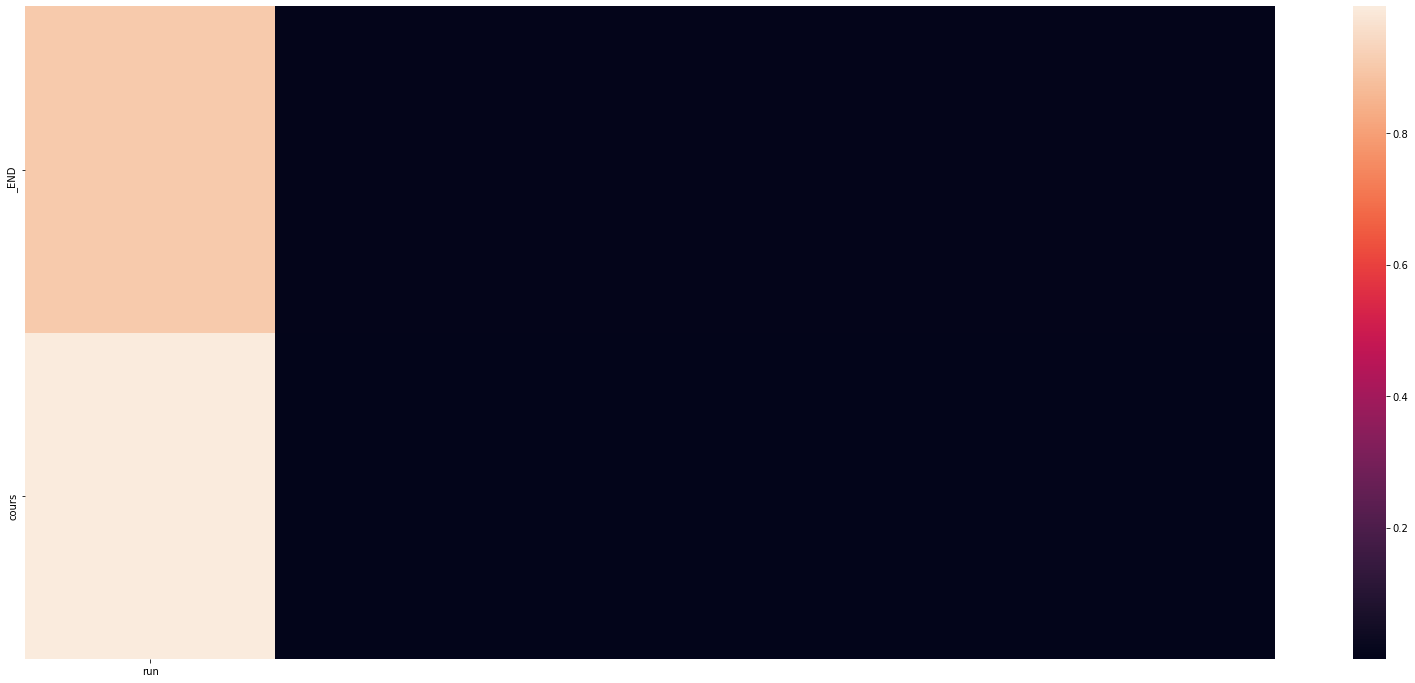

Decoded sentence:  cours _END
-
Input sentence: who
GT sentence: START_ qui  _END


<Figure size 432x288 with 0 Axes>

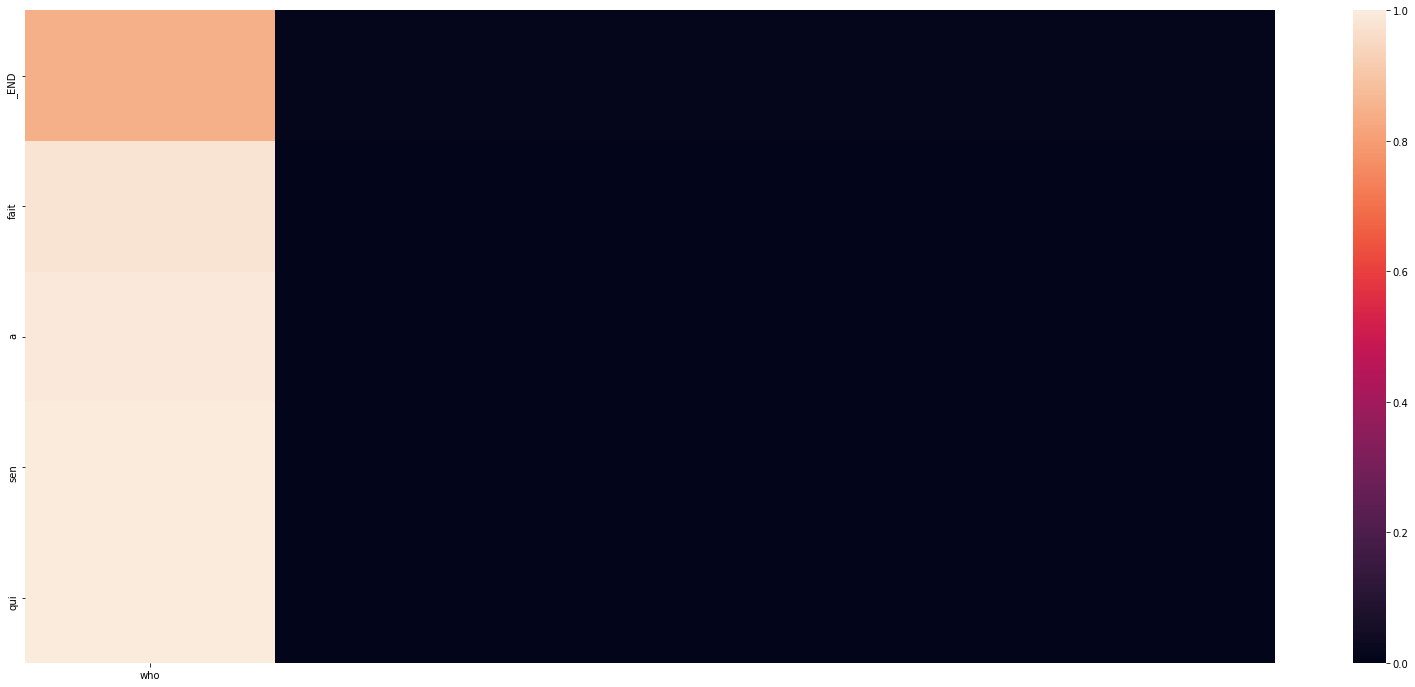

Decoded sentence:  qui sen a fait _END
-
Input sentence: wow
GT sentence: START_ ça alors  _END


<Figure size 432x288 with 0 Axes>

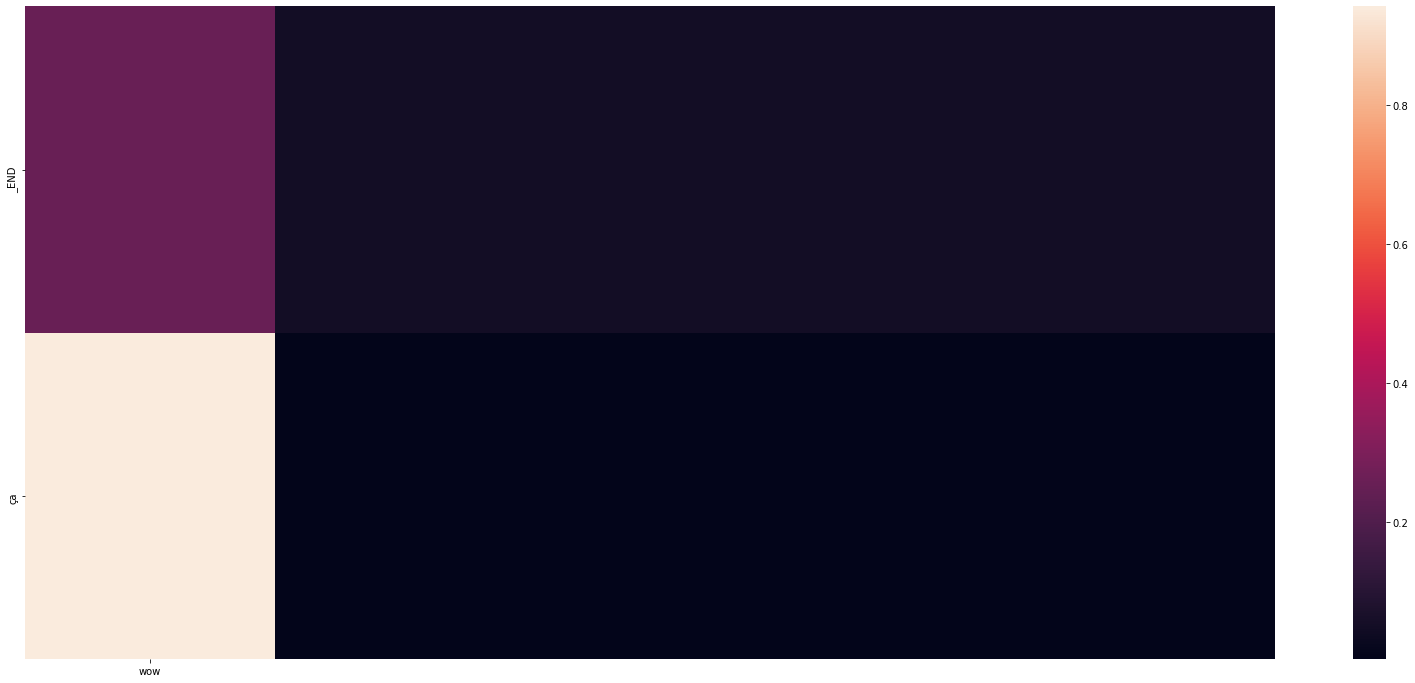

Decoded sentence:  ça _END
-
Input sentence: fire
GT sentence: START_ au feu  _END


<Figure size 432x288 with 0 Axes>

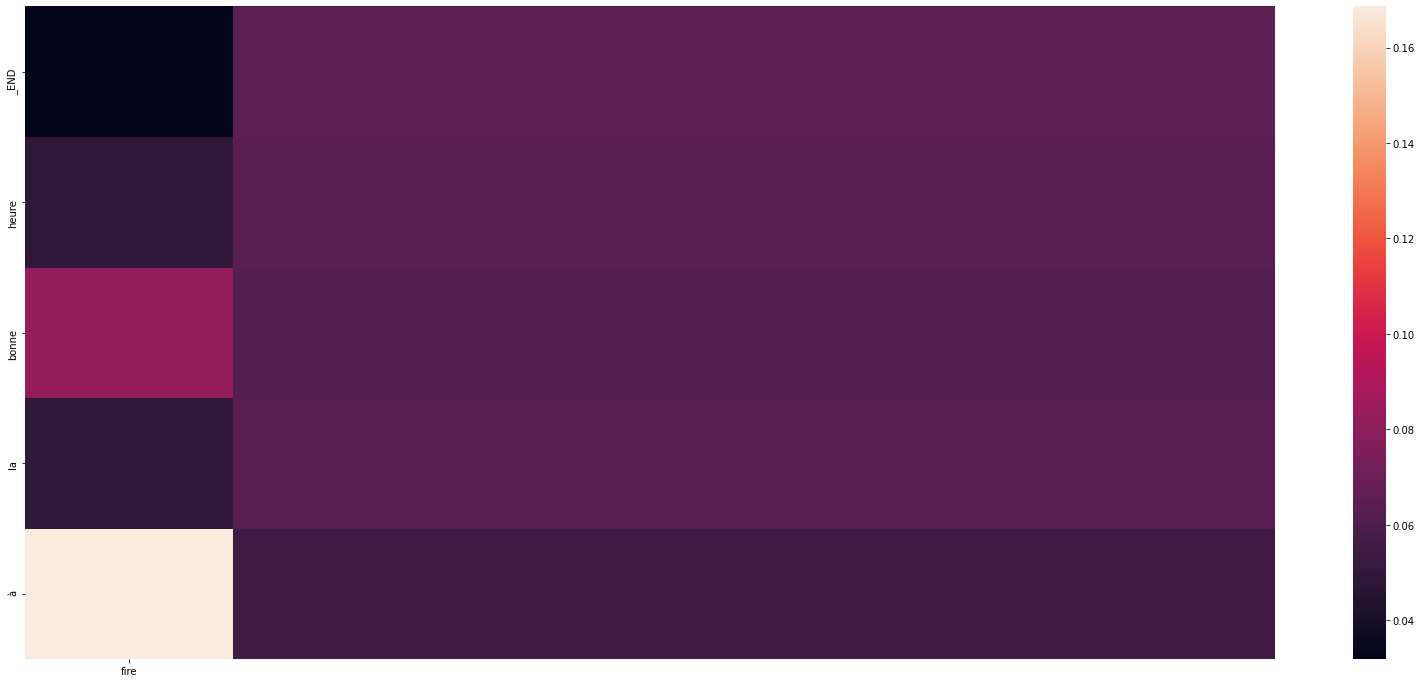

Decoded sentence:  à la bonne heure _END
-
Input sentence: help
GT sentence: START_ à laide  _END


<Figure size 432x288 with 0 Axes>

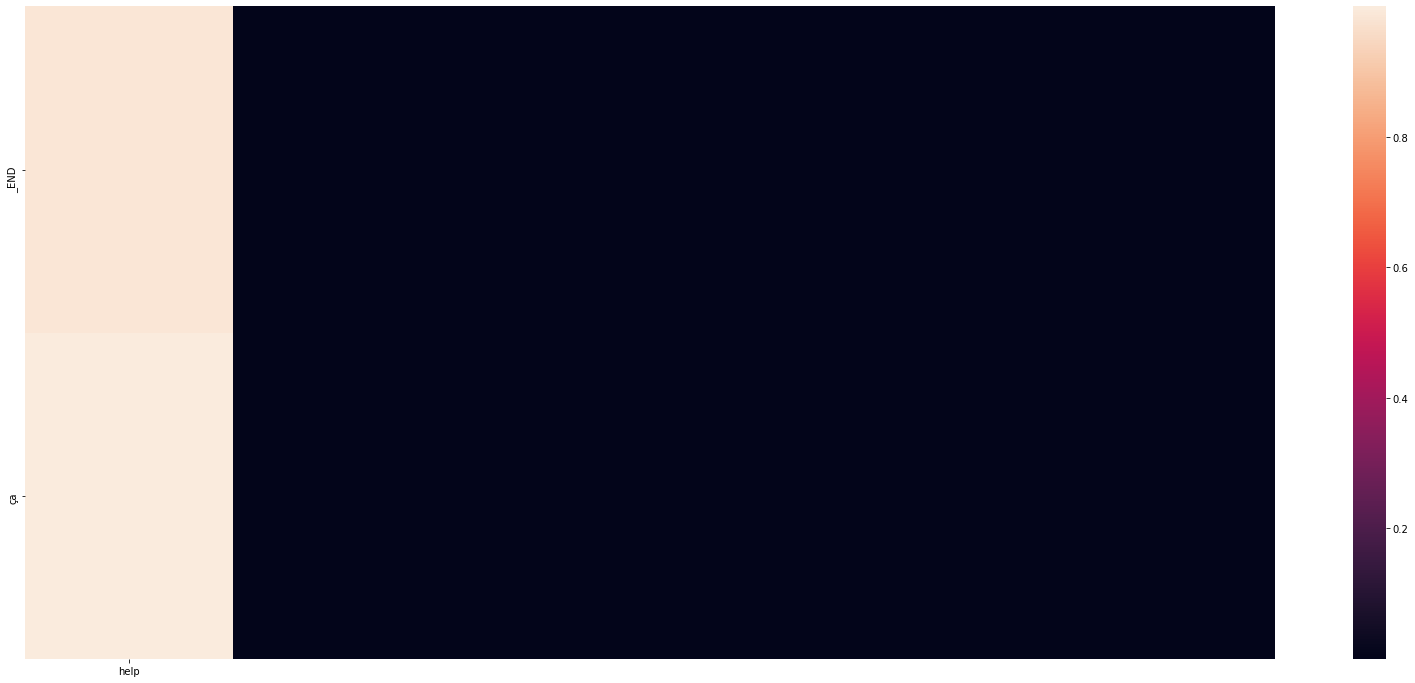

Decoded sentence:  ça _END
-
Input sentence: jump
GT sentence: START_ saute _END


<Figure size 432x288 with 0 Axes>

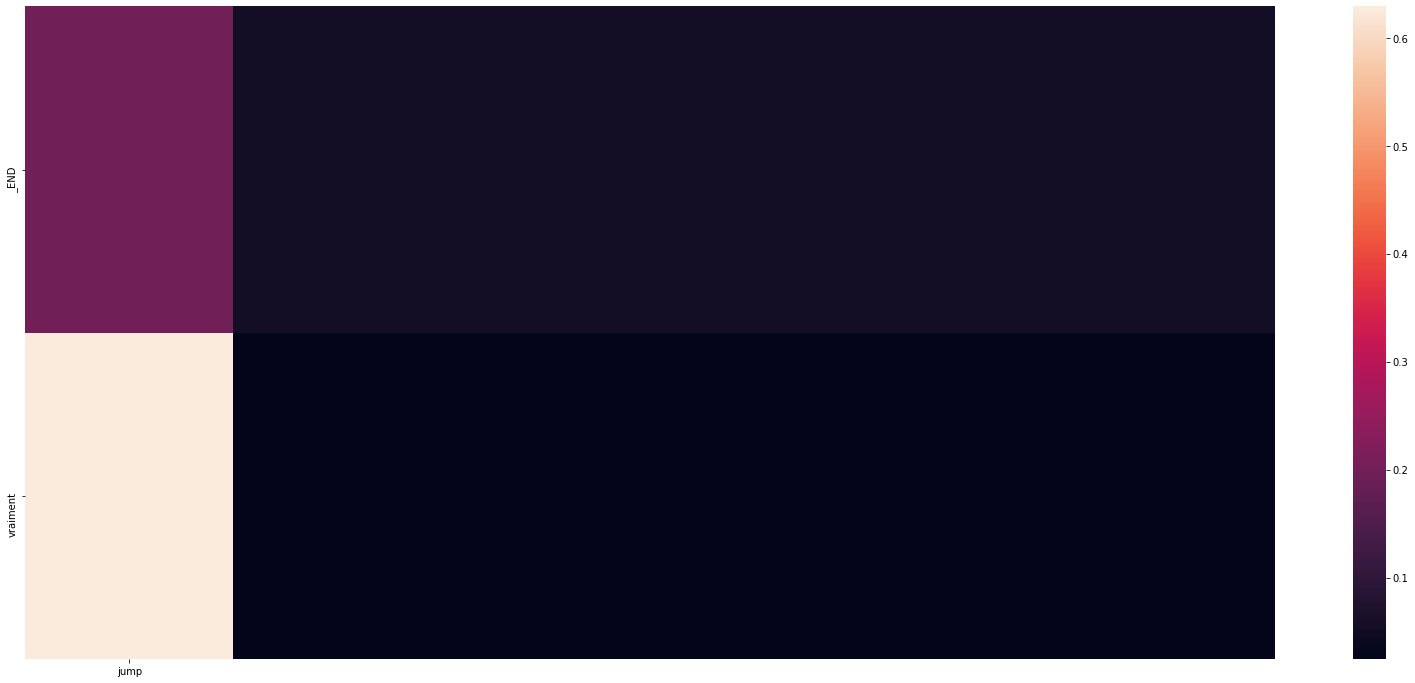

Decoded sentence:  vraiment _END
-
Input sentence: stop
GT sentence: START_ ça suffit  _END


<Figure size 432x288 with 0 Axes>

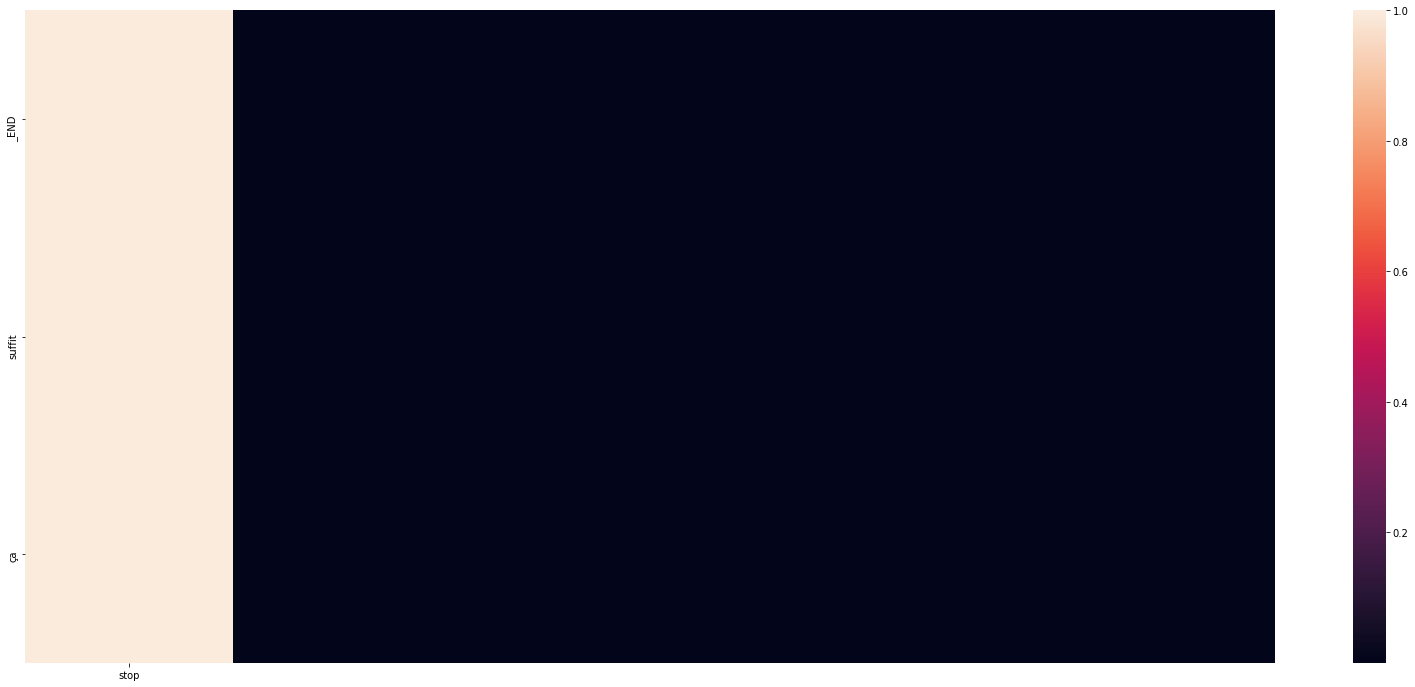

Decoded sentence:  ça suffit _END
-
Input sentence: stop
GT sentence: START_ stop  _END


<Figure size 432x288 with 0 Axes>

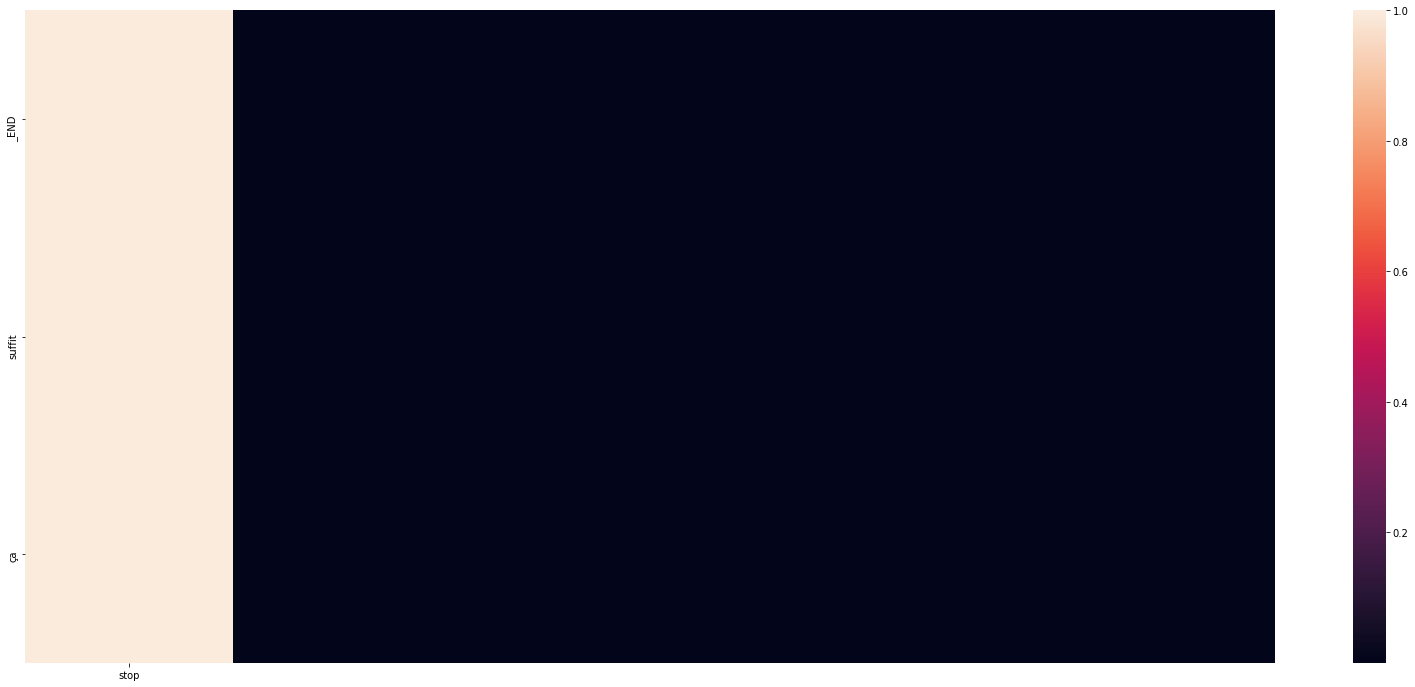

Decoded sentence:  ça suffit _END
-
Input sentence: stop
GT sentence: START_ arrêtetoi  _END


<Figure size 432x288 with 0 Axes>

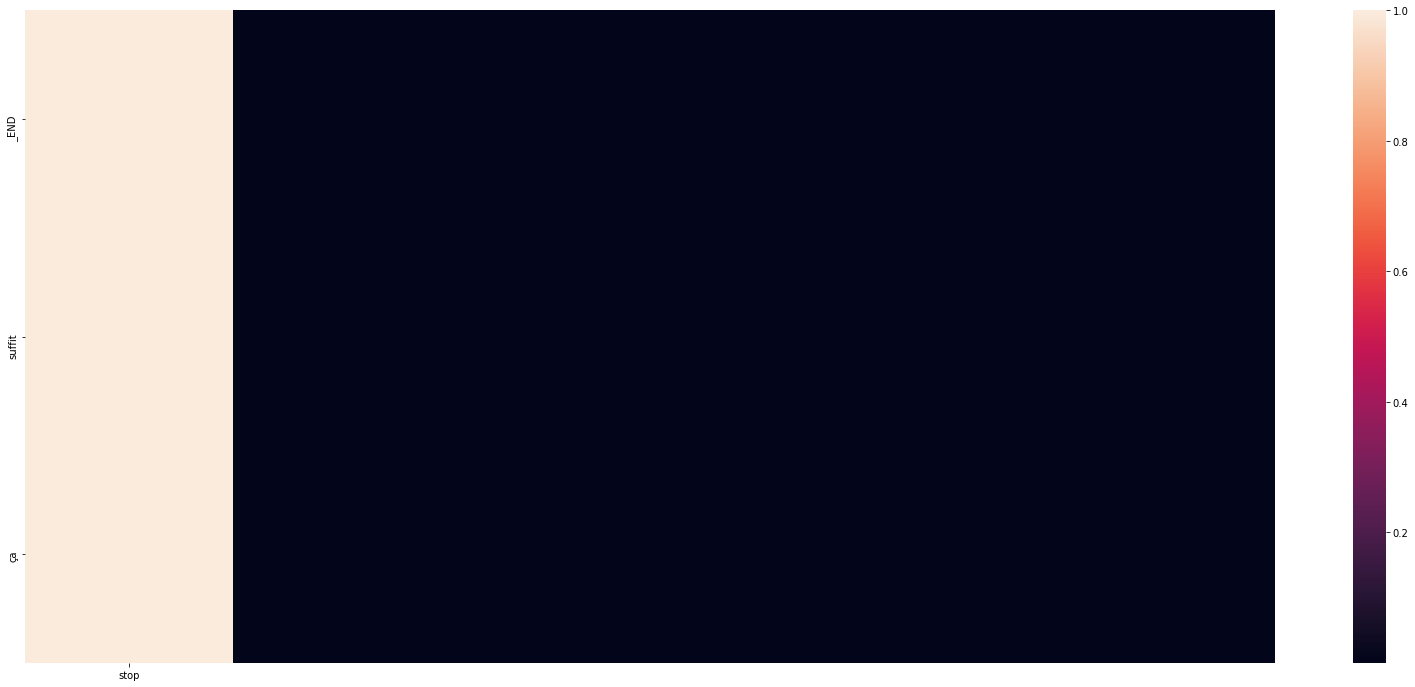

Decoded sentence:  ça suffit _END
-
Input sentence: wait
GT sentence: START_ attends  _END


<Figure size 432x288 with 0 Axes>

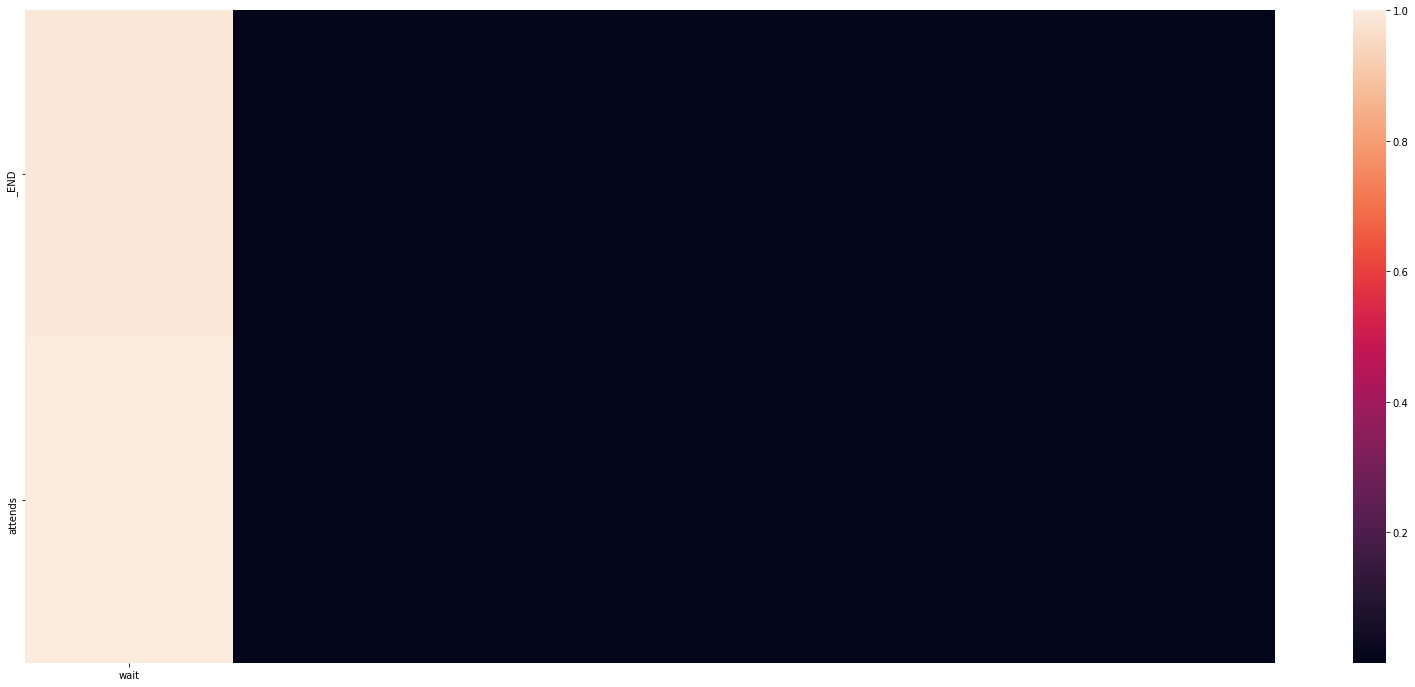

Decoded sentence:  attends _END
-
Input sentence: wait
GT sentence: START_ attendez  _END


<Figure size 432x288 with 0 Axes>

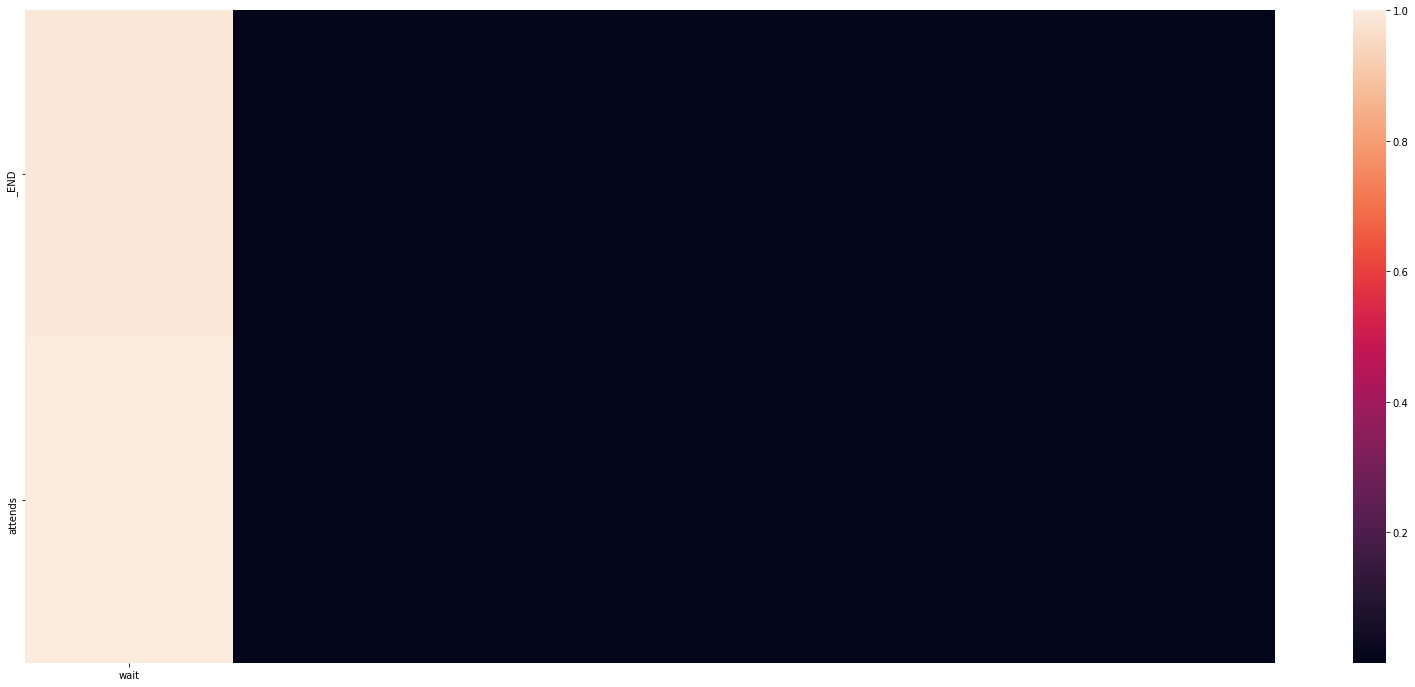

Decoded sentence:  attends _END
-
Input sentence: go on
GT sentence: START_ poursuis _END


<Figure size 432x288 with 0 Axes>

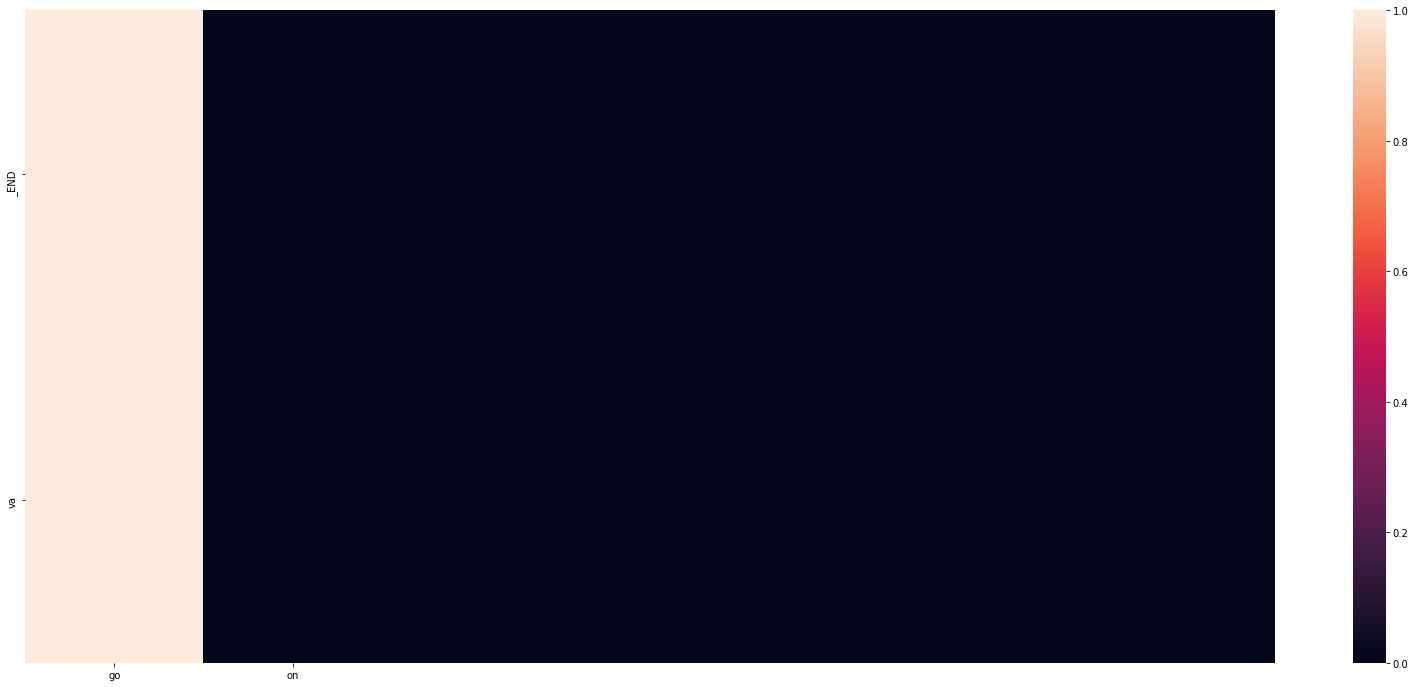

Decoded sentence:  va _END
-
Input sentence: go on
GT sentence: START_ continuez _END


<Figure size 432x288 with 0 Axes>

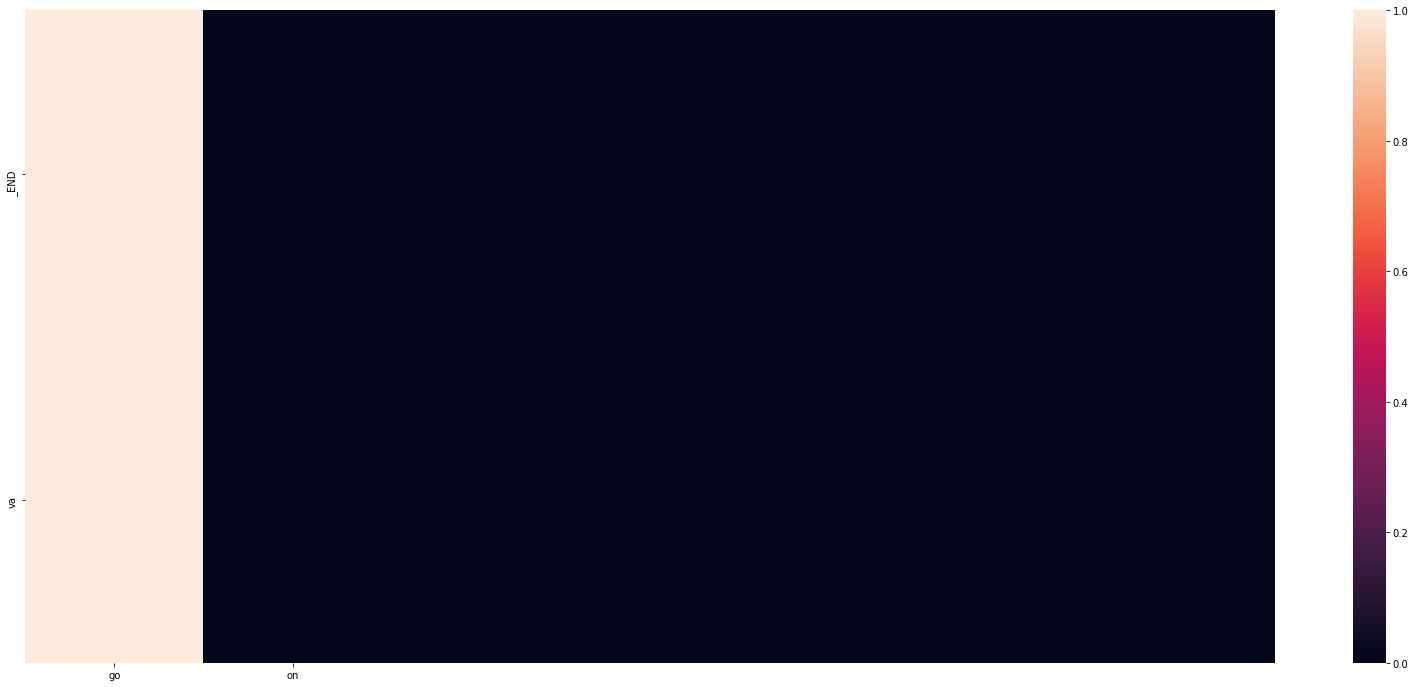

Decoded sentence:  va _END
-
Input sentence: go on
GT sentence: START_ poursuivez _END


<Figure size 432x288 with 0 Axes>

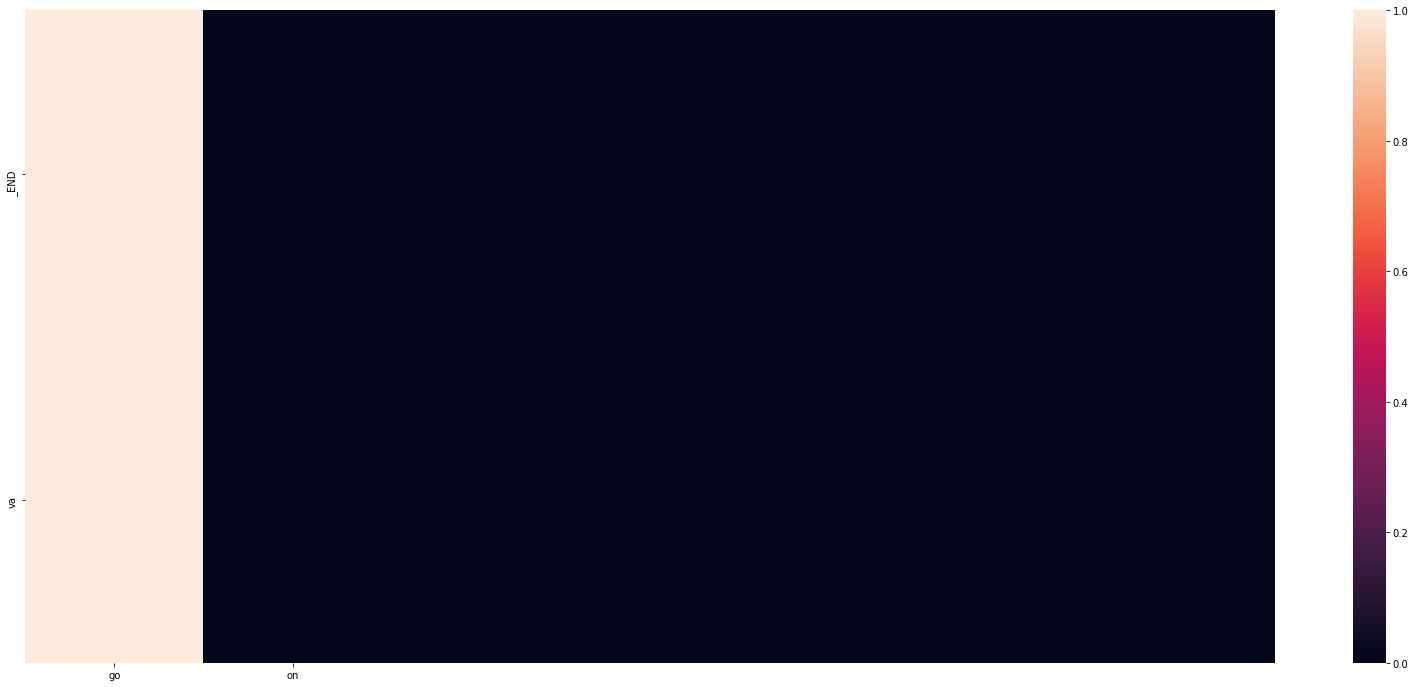

Decoded sentence:  va _END
-
Input sentence: hello
GT sentence: START_ bonjour  _END


<Figure size 432x288 with 0 Axes>

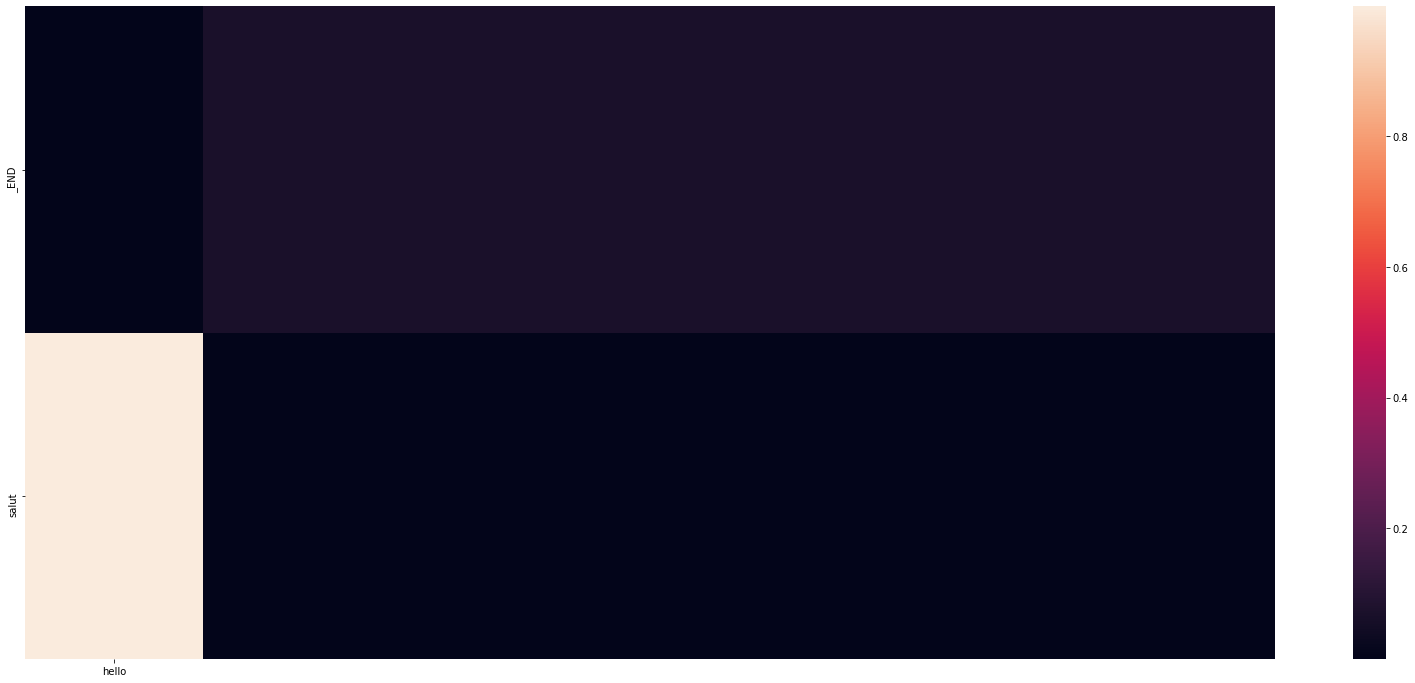

Decoded sentence:  salut _END
-
Input sentence: hello
GT sentence: START_ salut  _END


<Figure size 432x288 with 0 Axes>

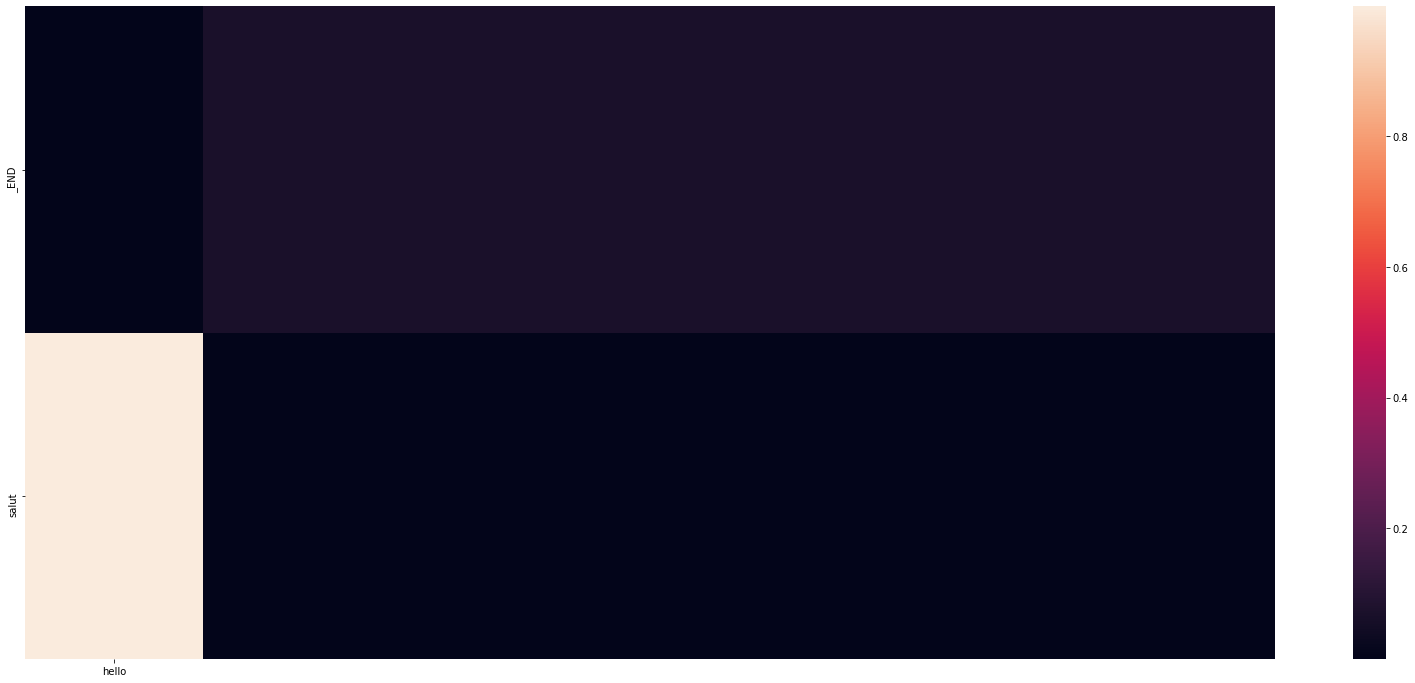

Decoded sentence:  salut _END


In [ ]:
for seq_index in range(20):

    target_text = lines.target[seq_index]
    text = lines.input[seq_index]
    print('-')
    print('Input sentence:', text)    
    print('GT sentence:', target_text)
    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, input_token_index, reverse_target_tok_index, tok_split_fn)

    
    print('Decoded sentence:', decoded_sentence)   


# Char Level (char2char)

Now let's encoder the sentences as sequence of chars instead of words. While it's not clear why we need to do that in NMT application, the need is more clear in other applications that has the possibility of having mistakes in the input, leading to OOV words. Examples:
- Spelling correction
- Chatbots

Char level models have the following pros:

- No OOV: we cannot encounter a char we don't know. In word level models, there's a risk of having new word not in out vocab.

- `number_target_tokens` are limited by the length of chars vocab, vs. large number of words vocab, which makes a huge softmax layer. This increase the memory and the model complexity, leading to risk of overfitting. Also, making it hard to learn ALL words softmax weights, since they are rarely encountered as output. Finally, dominant stop words might create [class imbalance issue](https://machinelearningmastery.com/what-is-imbalanced-classification/).

On the other hand, it has the following cons:

- `max_encoder_seq_len` and `max_decoder_seq_len` is longer than word level case. This makes it harder for the LSTM to learn the sequence states, leading to the following issue:

- Hallucination: since the sequence is long, the LSTM state capture is harder. Moreover, the model knows nothing about the notion of _word_, leading to: 1) invalid words and 2) invalid words sequence, since the language model now is at char level, and the sequence is long, so the errors in language modeling are higher.

- Error propagation: during inference, seq2seq models are sampled in a sequential order. The decoder inputs are now the feedback of decoder output. This leads to error propagation. The issue exists in both word and char level models. However, it is more severe in char level case, due to longer sequence, making it harder to recover. This also leads to hallucination (invalid words and/or sequence).

In [ ]:
lines = pd.DataFrame({'input':inputs, 'target':targets})
num_samples = 10000
lines = lines[:num_samples]

In [ ]:
st_tok = '\t'
end_tok = '\n'
def data_prep(lines):
  #cleanup(lines)
  lines.target = lines.target.apply(lambda x : st_tok  + x  + end_tok)
  

In [ ]:
data_prep(lines)


In [ ]:
lines

,input,target
0,Go.,\tVa !\n
1,Hi.,\tSalut !\n
2,Hi.,\tSalut.\n
3,Run!,\tCours !\n
4,Run!,\tCourez !\n
...,...,...
9995,Be more precise.,\tSoit plus précis.\n
9996,"Be quiet, girls.","\tRestez tranquilles, les filles !\n"
9997,Be very careful.,\tSois très prudent !\n
9998,Be very careful.,\tSoyez très prudent !\n


## Baisc seq2seq

In [ ]:
emb_sz = 256

In [ ]:
def tok_split_char2char(data):
  return data
  
tok_split_fn = tok_split_char2char

In [ ]:
input_tokens, target_tokens, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length = data_stats(lines, input_tok_split_fn=tok_split_fn, target_tok_split_fn=tok_split_fn)
print('Number of samples:', len(lines))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [ ]:
pad_tok = 'PAD'
sep_tok = ' '
special_tokens = [pad_tok, sep_tok, st_tok, end_tok] 
num_encoder_tokens += len(special_tokens)
num_decoder_tokens += len(special_tokens)


In [ ]:
input_token_index, target_token_index, reverse_input_tok_index, reverse_target_tok_index = vocab(input_tokens, target_tokens)

In [ ]:
encoder_input_data, decoder_input_data, decoder_target_data  = vectorize(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens, input_tok_split_fn=tok_split_fn, target_tok_split_fn=tok_split_fn)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 256)    19200       input_14[0][0]                   
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 256)    24832       input_15[0][0]                   
___________________________________________________________________________________________

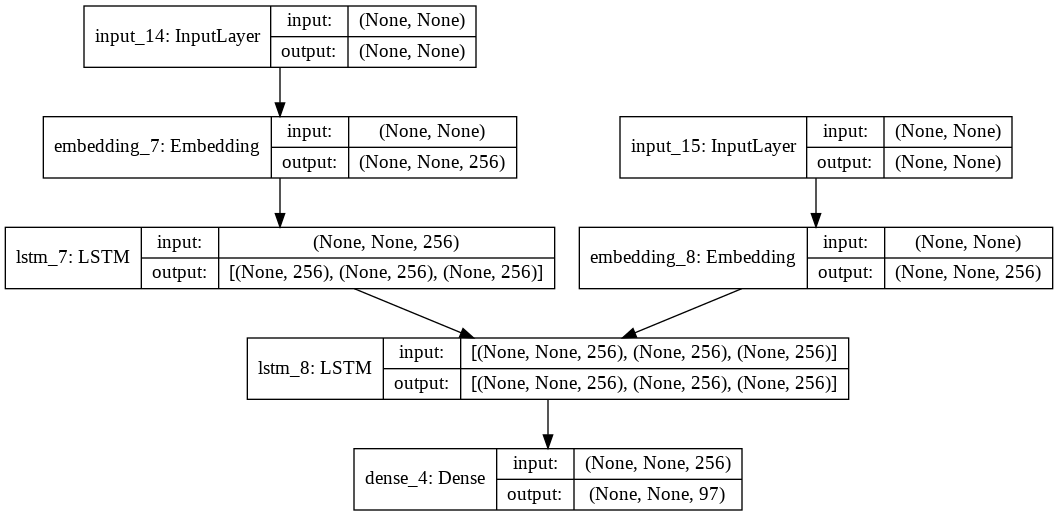

In [ ]:
emb_sz = 256
model, encoder_model, decoder_model = seq2seq(num_decoder_tokens, num_encoder_tokens, emb_sz, emb_sz)
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=64,
          epochs=10,
          validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 22s 3ms/step - loss: 0.8273 - acc: 0.3251 - val_loss: 0.7488 - val_acc: 0.4050
Epoch 2/10
8000/8000 [==============================] - 21s 3ms/step - loss: 0.5924 - acc: 0.4758 - val_loss: 0.6303 - val_acc: 0.4983
Epoch 3/10
8000/8000 [==============================] - 21s 3ms/step - loss: 0.5143 - acc: 0.5456 - val_loss: 0.5651 - val_acc: 0.5500
Epoch 4/10
8000/8000 [==============================] - 21s 3ms/step - loss: 0.4631 - acc: 0.5882 - val_loss: 0.5178 - val_acc: 0.5868
Epoch 5/10
8000/8000 [==============================] - 21s 3ms/step - loss: 0.4256 - acc: 0.6197 - val_loss: 0.4914 - val_acc: 0.6066
Epoch 6/10
8000/8000 [==============================] - 21s 3ms/step - loss: 0.3966 - acc: 0.6437 - val_loss: 0.4701 - val_acc: 0.6225
Epoch 7/10
8000/8000 [==============================] - 21s 3ms/step - loss: 0.3723 - acc: 0.6647 - val_loss: 0.4487 - val_acc: 0.6369
Epoch 8

In [ ]:
for seq_index in range(100): #[14077,20122,40035,40064, 40056, 40068, 40090, 40095, 40100, 40119, 40131, 40136, 40150, 40153]:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq, sep='')
    print('-')
    print('Input sentence:', lines.input[seq_index: seq_index + 1])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: 0    Go.
Name: input, dtype: object
Decoded sentence: Sois-tu !

-
Input sentence: 1    Hi.
Name: input, dtype: object
Decoded sentence: Gonte.

-
Input sentence: 2    Hi.
Name: input, dtype: object
Decoded sentence: Gonte.

-
Input sentence: 3    Run!
Name: input, dtype: object
Decoded sentence: Attendez !

-
Input sentence: 4    Run!
Name: input, dtype: object
Decoded sentence: Attendez !

-
Input sentence: 5    Who?
Name: input, dtype: object
Decoded sentence: Qui ?

-
Input sentence: 6    Wow!
Name: input, dtype: object
Decoded sentence: Quelle !

-
Input sentence: 7    Fire!
Name: input, dtype: object
Decoded sentence: Arrête !

-
Input sentence: 8    Help!
Name: input, dtype: object
Decoded sentence: Attends !

-
Input sentence: 9    Jump.
Name: input, dtype: object
Decoded sentence: Arrez-le.

-
Input sentence: 10    Stop!
Name: input, dtype: object
Decoded sentence: Attendez !

-
Input sentence: 11    Stop!
Name: input, dtype: object
Decoded sentence: Attendez

# seq2seq + Attention

[<tf.Tensor 'concatenate_4/concat:0' shape=(None, 512) dtype=float32>, <tf.Tensor 'concatenate_5/concat:0' shape=(None, 512) dtype=float32>]
Tensor("lstm_10/transpose_2:0", shape=(None, None, 512), dtype=float32)
Tensor("bidirectional_2/concat:0", shape=(None, None, 512), dtype=float32)
attention Tensor("attention_2/truediv:0", shape=(None, None, None), dtype=float32)
encoder-decoder  model:
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, None, 256)    19200       input_18[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


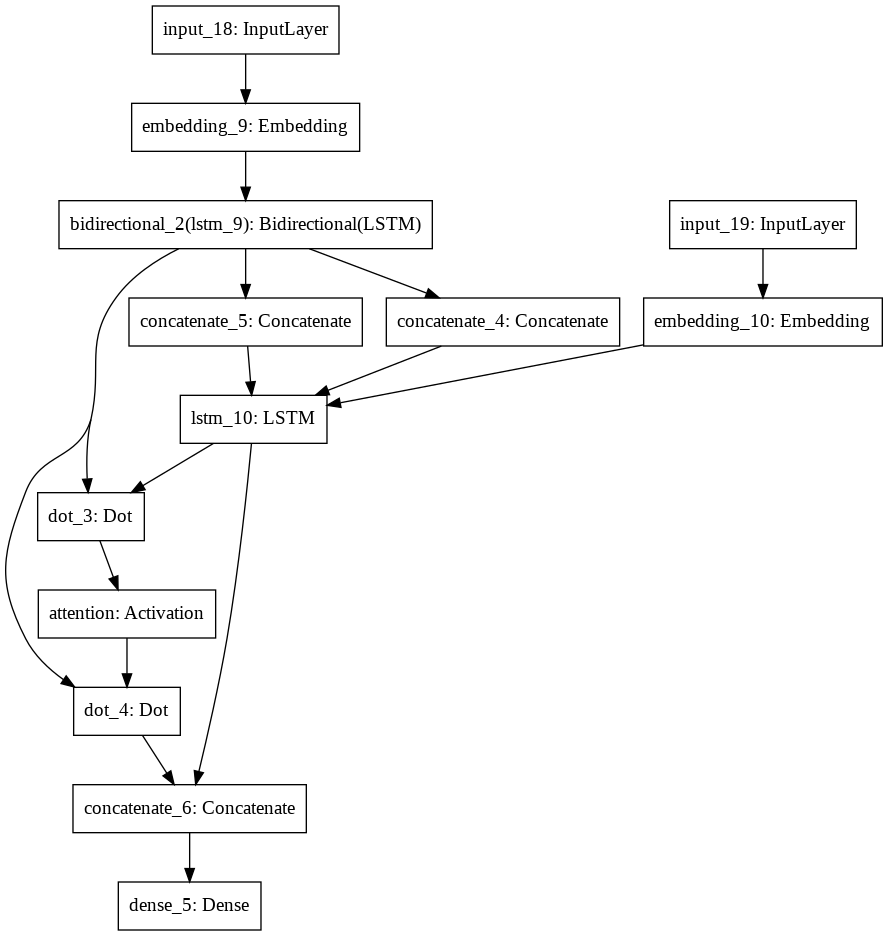

In [ ]:
model, encoder_model, decoder_model = seq2seq_attention(num_encoder_tokens, num_decoder_tokens, emb_sz=emb_sz, latent_dim=emb_sz)
print(model.summary())
plot_model(model)

In [ ]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=128,
          epochs=20,
          validation_split=0.05)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9500 samples, validate on 500 samples
Epoch 1/20
9500/9500 [==============================] - 17s 2ms/step - loss: 0.9255 - acc: 0.2655 - val_loss: 0.8178 - val_acc: 0.3642
Epoch 2/20
9500/9500 [==============================] - 16s 2ms/step - loss: 0.6402 - acc: 0.4459 - val_loss: 0.6586 - val_acc: 0.4718
Epoch 3/20
9500/9500 [==============================] - 16s 2ms/step - loss: 0.5447 - acc: 0.5271 - val_loss: 0.5657 - val_acc: 0.5491
Epoch 4/20
9500/9500 [==============================] - 16s 2ms/step - loss: 0.4806 - acc: 0.5798 - val_loss: 0.5177 - val_acc: 0.5837
Epoch 5/20
9500/9500 [==============================] - 16s 2ms/step - loss: 0.4299 - acc: 0.6217 - val_loss: 0.4623 - val_acc: 0.6234
Epoch 6/20
9500/9500 [==============================] - 16s 2ms/step - loss: 0.3886 - acc: 0.6560 - val_loss: 0.4372 - val_acc: 0.6515
Epoch 7/20
9500/9500 [==============================] - 16s 2ms/step - loss: 0.3532 - acc: 0.6880 - val_loss: 0.4147 - val_acc: 0.6545
Epoch 8/

In [ ]:
char_decoded_sents = []
target_sents = []
for seq_index in range(100): #[14077,20122,40035,40064, 40056, 40068, 40090, 40095, 40100, 40119, 40131, 40136, 40150, 40153]:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence, attention = decode_sequence_attention(input_seq, sep='')
    print('-')
    print('Input sentence:', lines.input[seq_index: seq_index + 1])
    print('GT sentence:', lines.target[seq_index: seq_index + 1][1:-1])
    print('Decoded sentence:', decoded_sentence)
    char_decoded_sents.append(decoded_sentence)
    target_sents.append(np.array(lines.target[seq_index: seq_index + 1]))

-
Input sentence: 0    Go.
Name: input, dtype: object
GT sentence: Series([], Name: target, dtype: object)
Decoded sentence: Vous Tom.

-
Input sentence: 1    Hi.
Name: input, dtype: object
GT sentence: Series([], Name: target, dtype: object)
Decoded sentence: Steux.

-
Input sentence: 2    Hi.
Name: input, dtype: object
GT sentence: Series([], Name: target, dtype: object)
Decoded sentence: Steux.

-
Input sentence: 3    Run!
Name: input, dtype: object
GT sentence: Series([], Name: target, dtype: object)
Decoded sentence: À la bénéger !

-
Input sentence: 4    Run!
Name: input, dtype: object
GT sentence: Series([], Name: target, dtype: object)
Decoded sentence: À la bénéger !

-
Input sentence: 5    Who?
Name: input, dtype: object
GT sentence: Series([], Name: target, dtype: object)
Decoded sentence: Qui à t'échatoné ?

-
Input sentence: 6    Wow!
Name: input, dtype: object
GT sentence: Series([], Name: target, dtype: object)
Decoded sentence: Qu'a !

-
Input sentence: 7    Fire!
Name:

-
Input sentence: Go.
GT sentence: 	Va !



<Figure size 432x288 with 0 Axes>

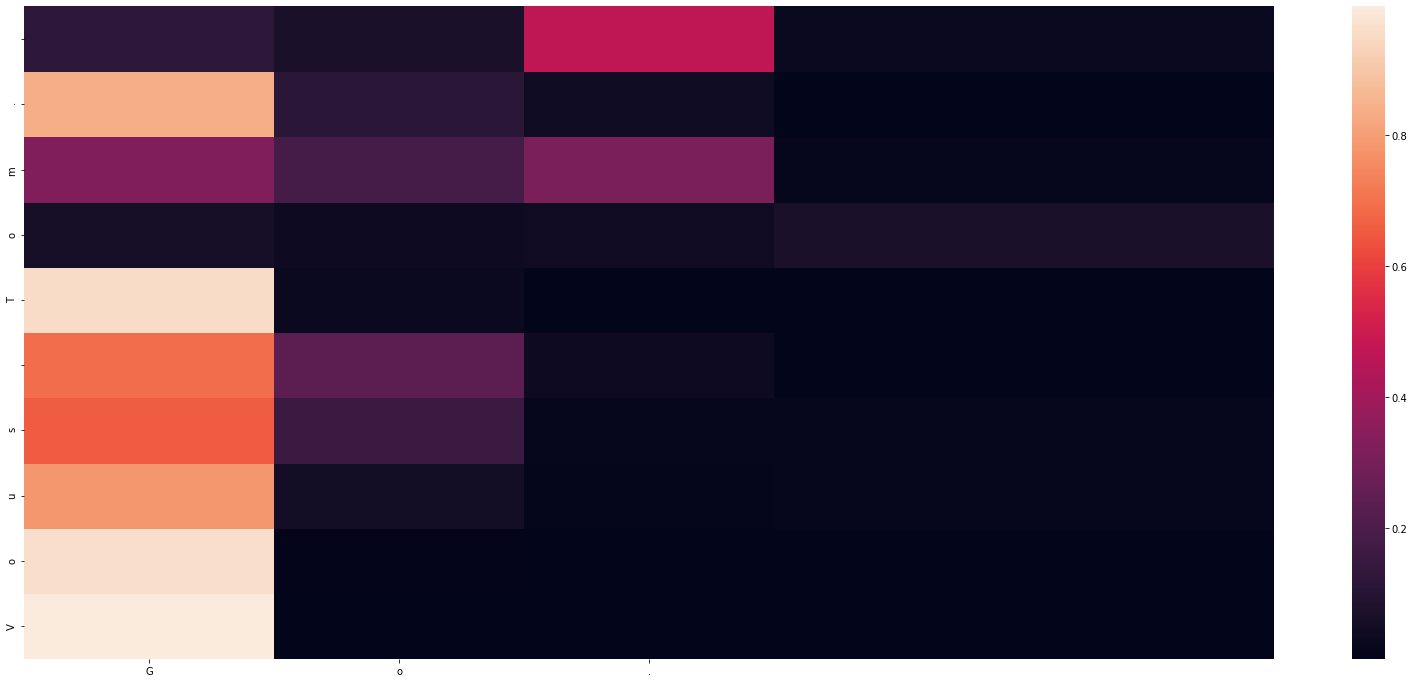

Decoded sentence: Vous Tom.

-
Input sentence: Hi.
GT sentence: 	Salut !



<Figure size 432x288 with 0 Axes>

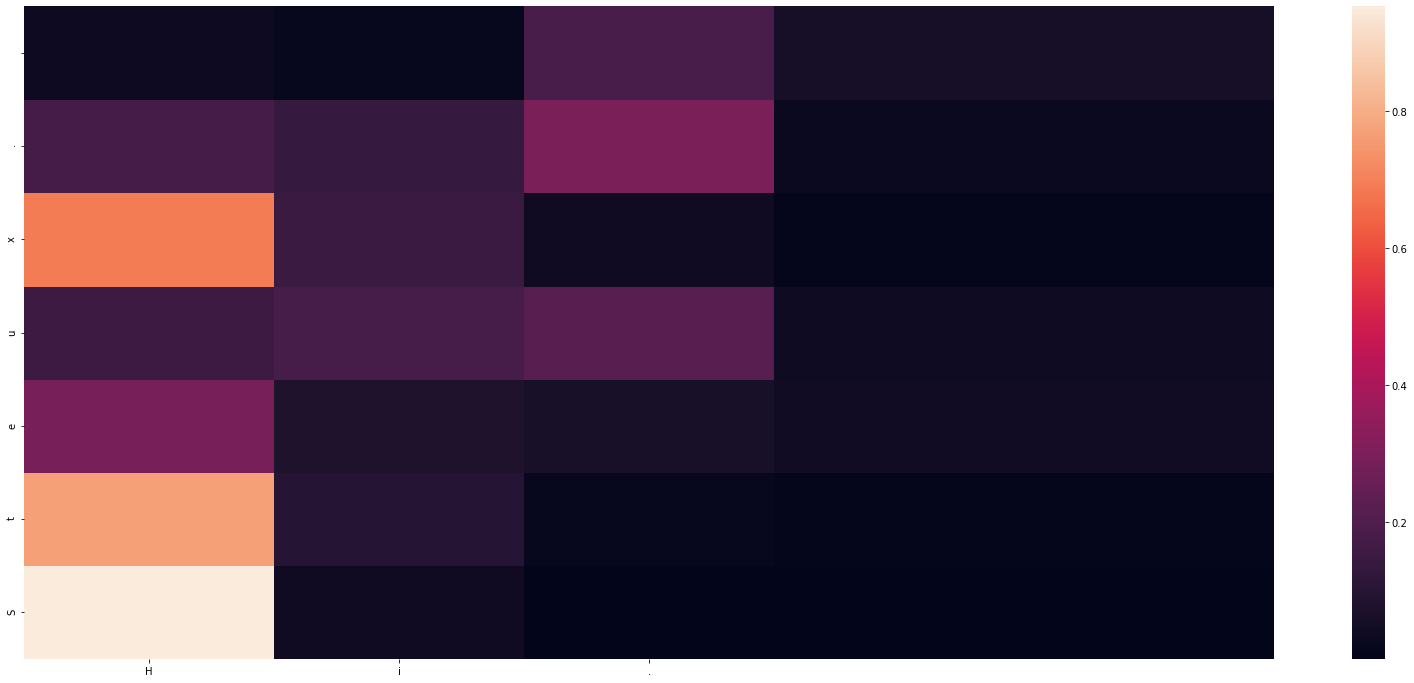

Decoded sentence: Steux.

-
Input sentence: Hi.
GT sentence: 	Salut.



<Figure size 432x288 with 0 Axes>

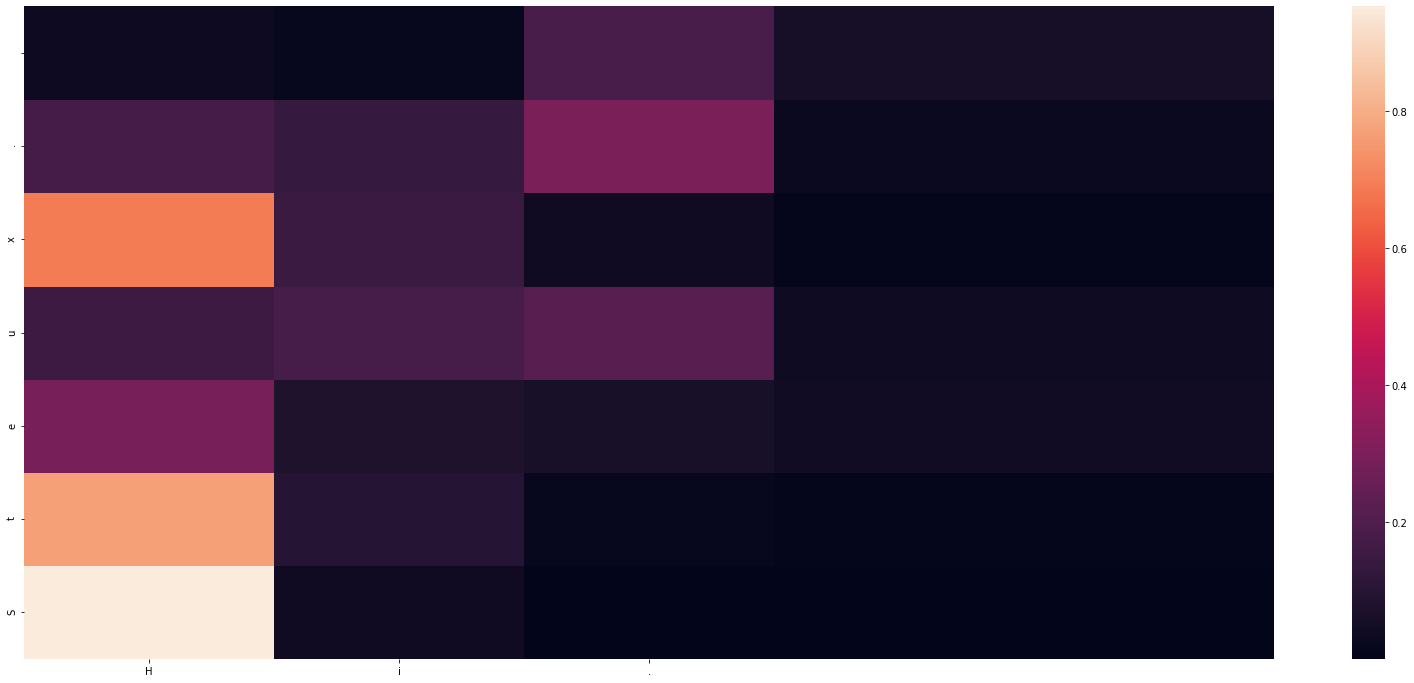

Decoded sentence: Steux.

-
Input sentence: Run!
GT sentence: 	Cours !



<Figure size 432x288 with 0 Axes>

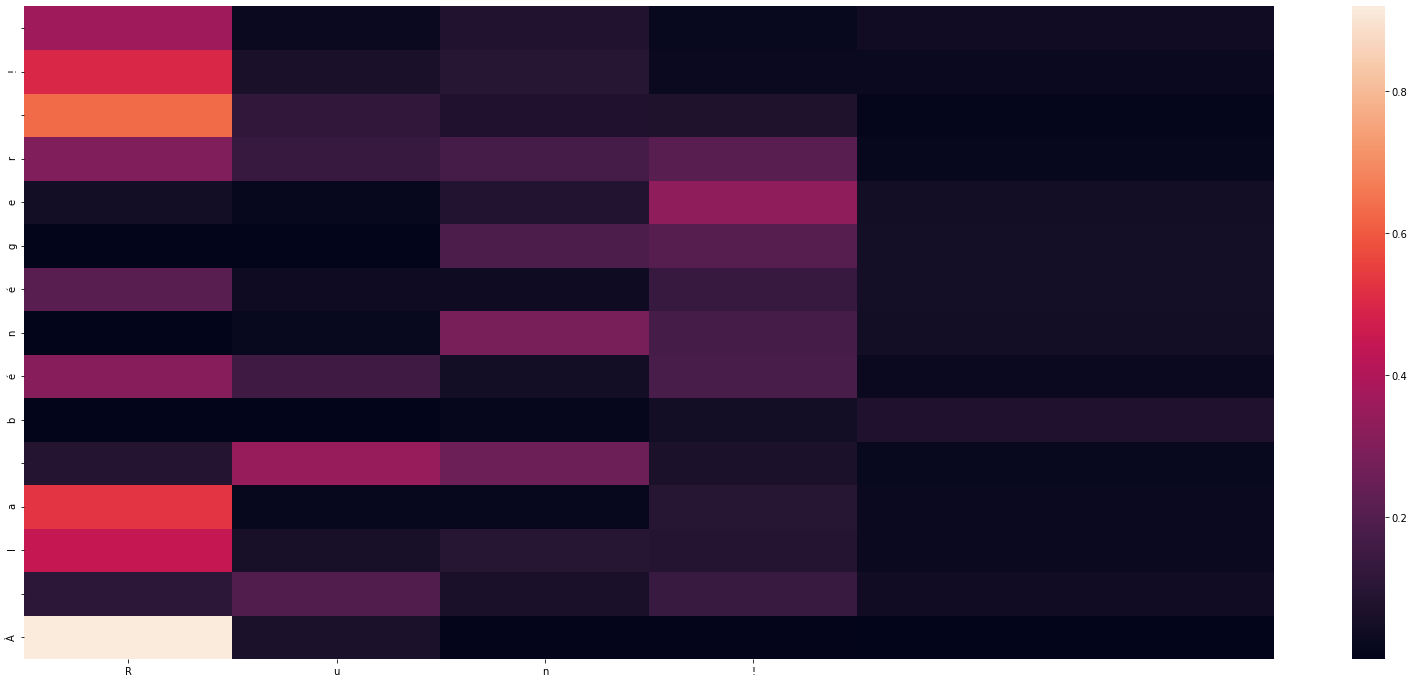

Decoded sentence: À la bénéger !

-
Input sentence: Run!
GT sentence: 	Courez !



<Figure size 432x288 with 0 Axes>

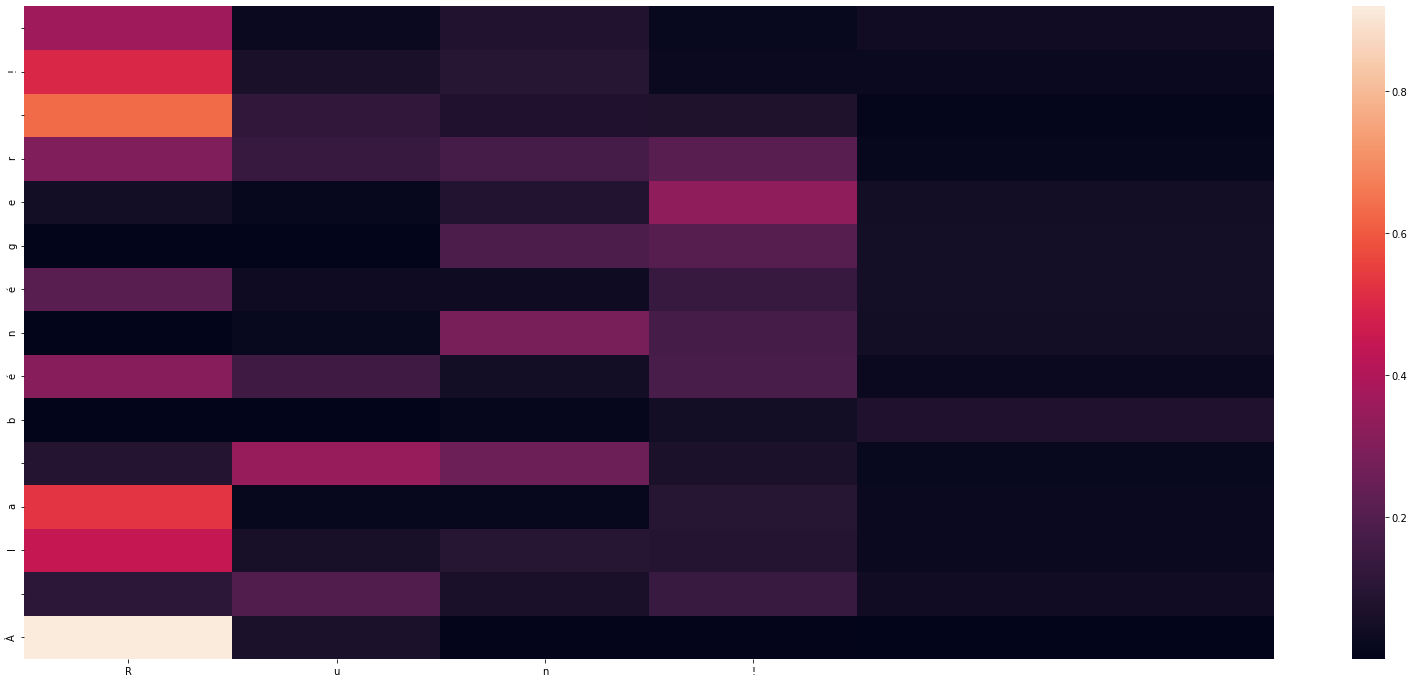

Decoded sentence: À la bénéger !

-
Input sentence: Who?
GT sentence: 	Qui ?



<Figure size 432x288 with 0 Axes>

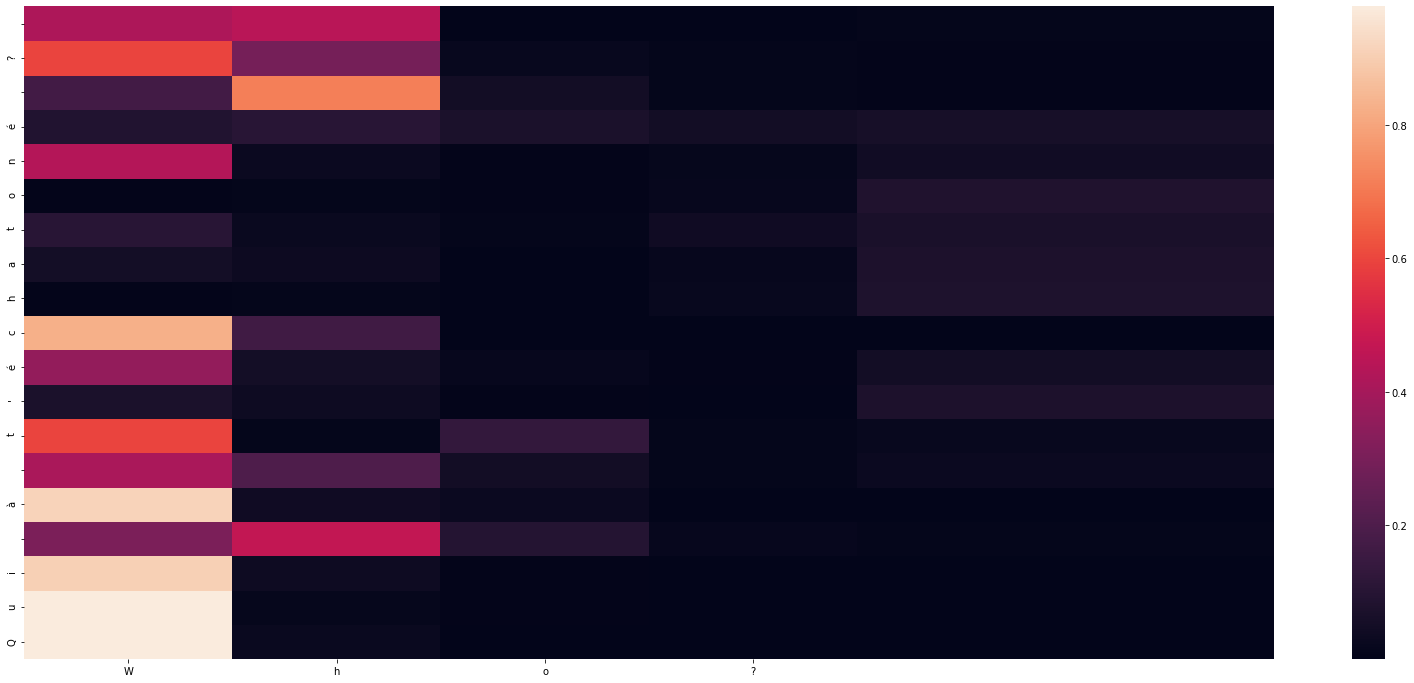

Decoded sentence: Qui à t'échatoné ?

-
Input sentence: Wow!
GT sentence: 	Ça alors !



<Figure size 432x288 with 0 Axes>

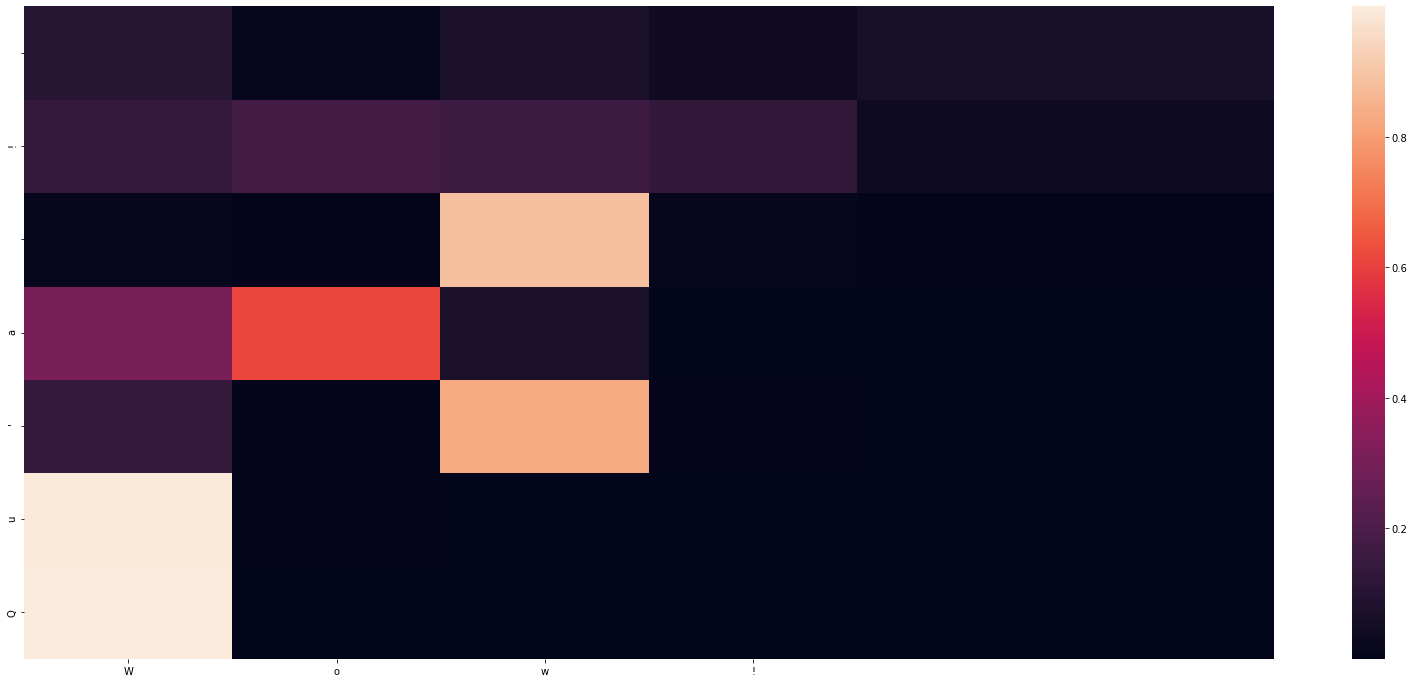

Decoded sentence: Qu'a !

-
Input sentence: Fire!
GT sentence: 	Au feu !



<Figure size 432x288 with 0 Axes>

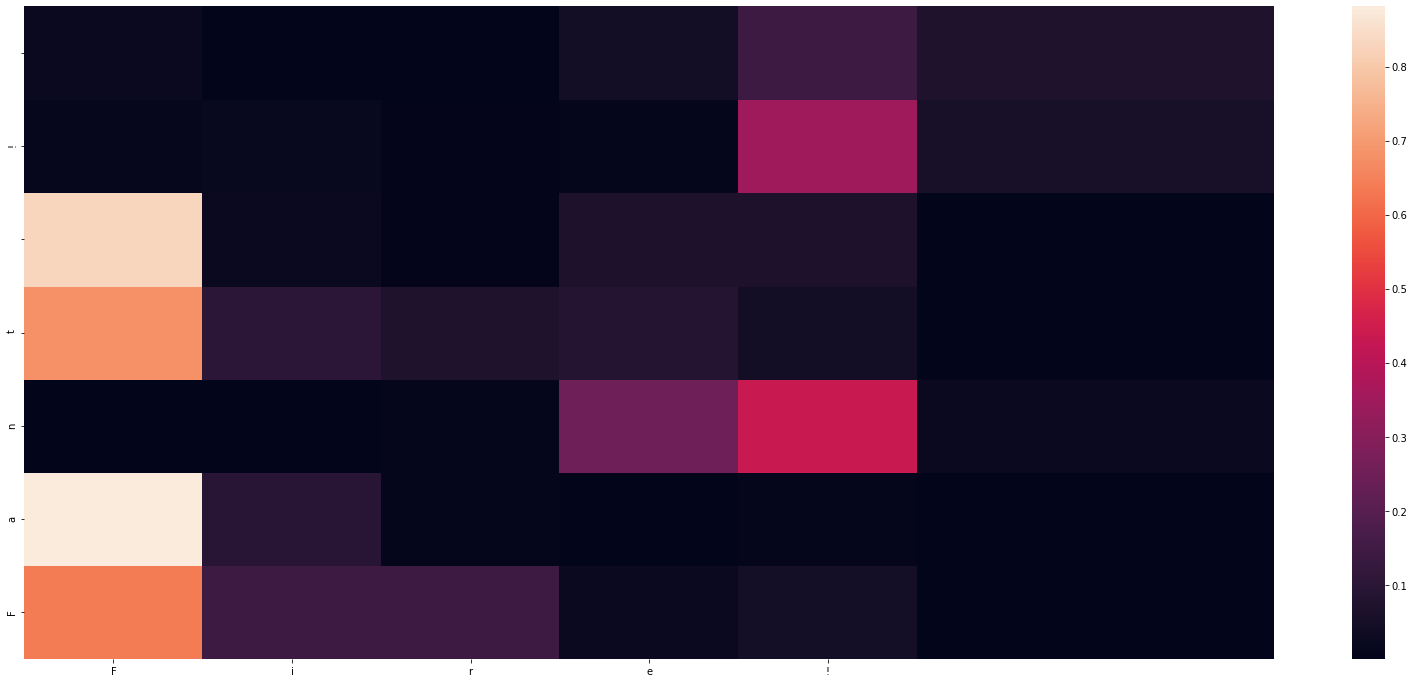

Decoded sentence: Fant !

-
Input sentence: Help!
GT sentence: 	À l'aide !



<Figure size 432x288 with 0 Axes>

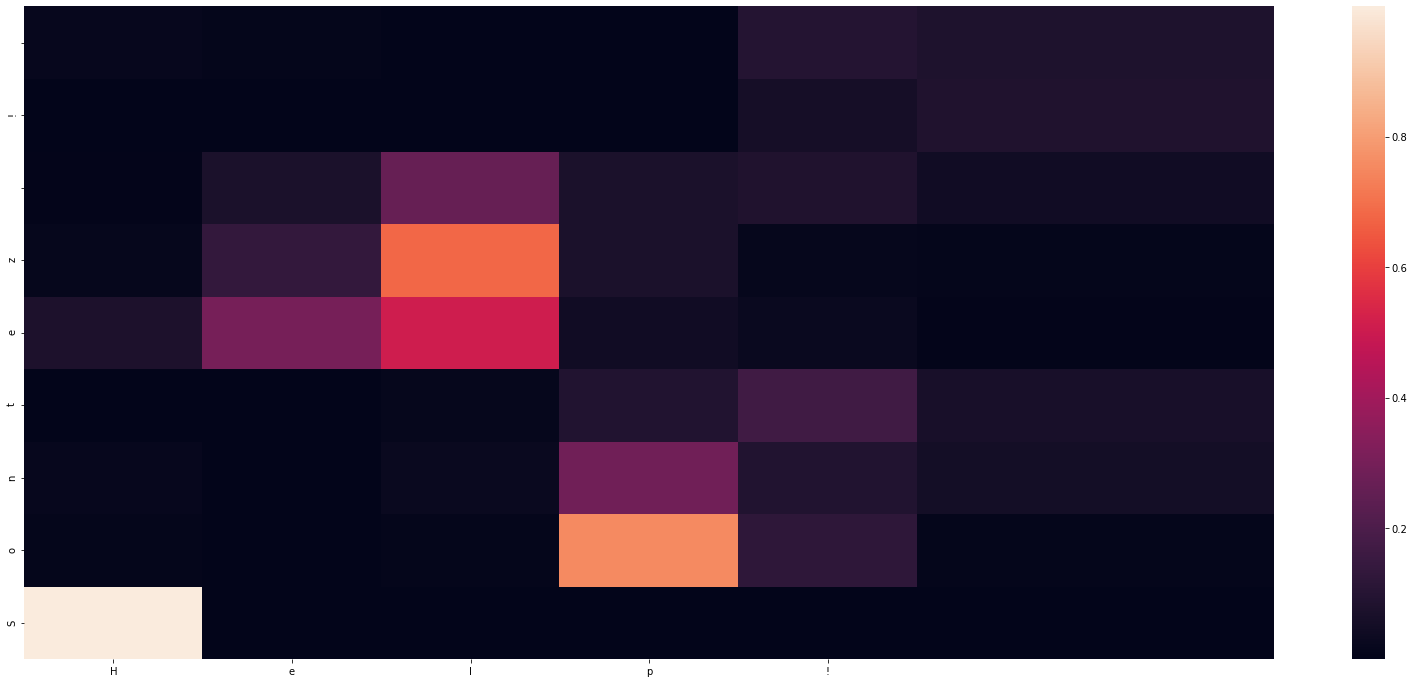

Decoded sentence: Sontez !

-
Input sentence: Jump.
GT sentence: 	Saute.



<Figure size 432x288 with 0 Axes>

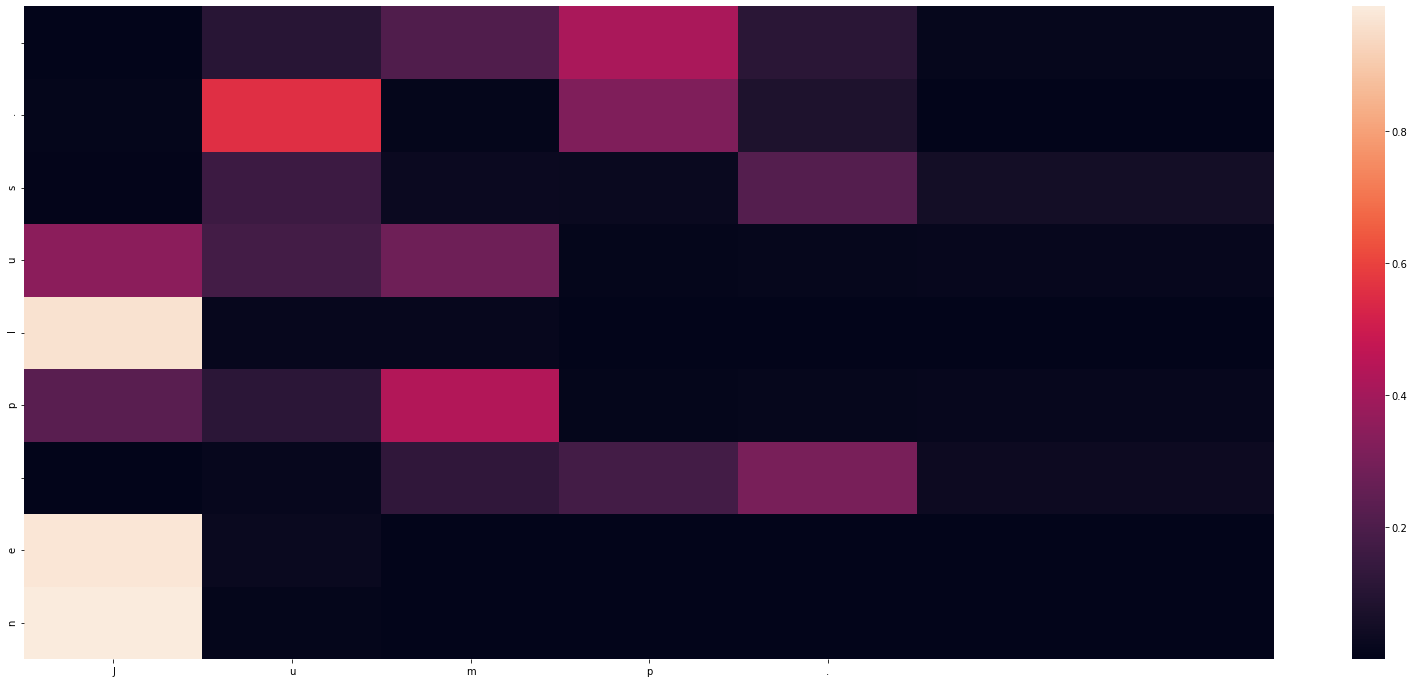

Decoded sentence: ne plus.

-
Input sentence: Stop!
GT sentence: 	Ça suffit !



<Figure size 432x288 with 0 Axes>

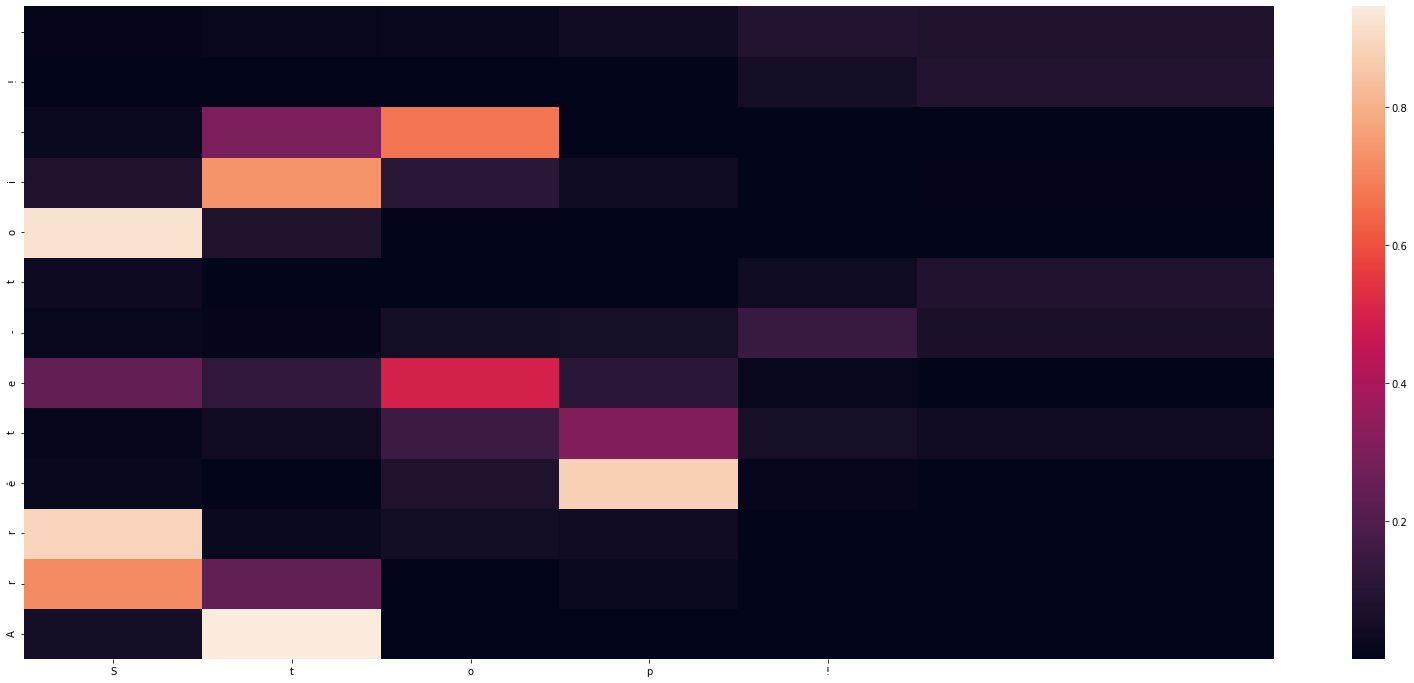

Decoded sentence: Arrête-toi !

-
Input sentence: Stop!
GT sentence: 	Stop !



<Figure size 432x288 with 0 Axes>

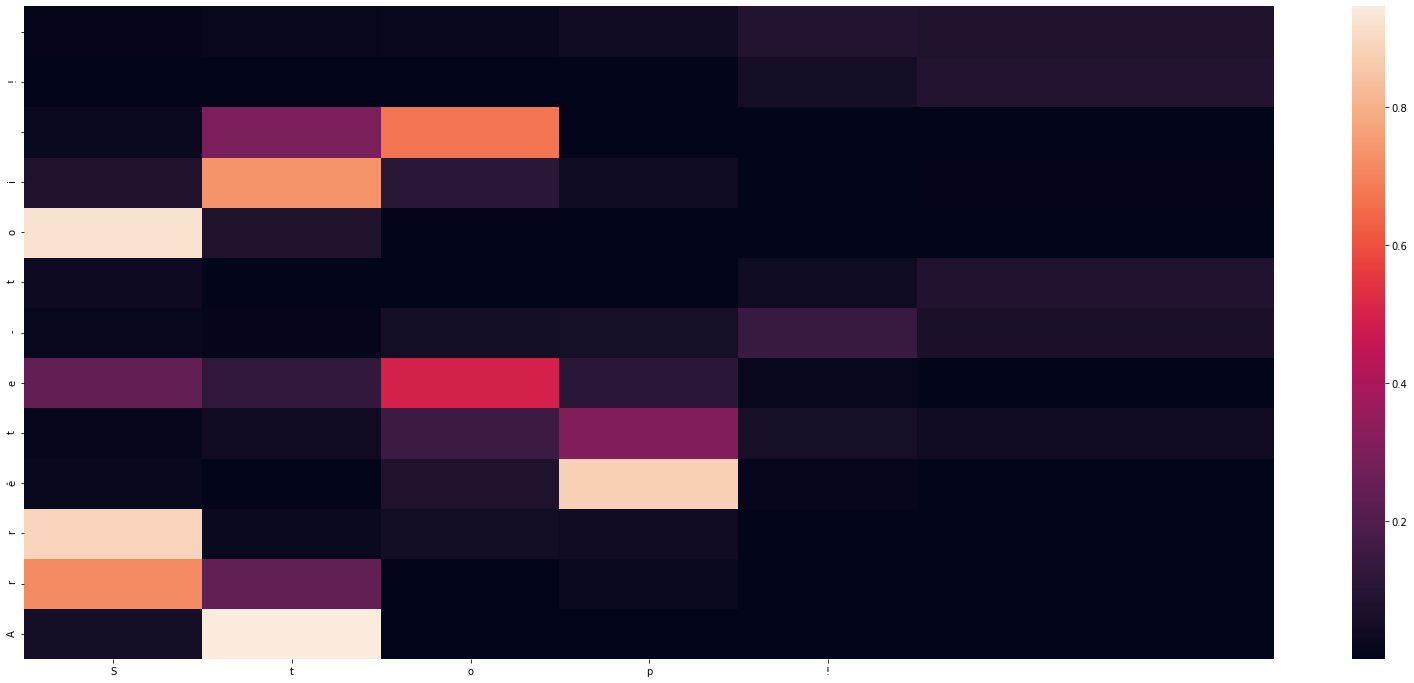

Decoded sentence: Arrête-toi !

-
Input sentence: Stop!
GT sentence: 	Arrête-toi !



<Figure size 432x288 with 0 Axes>

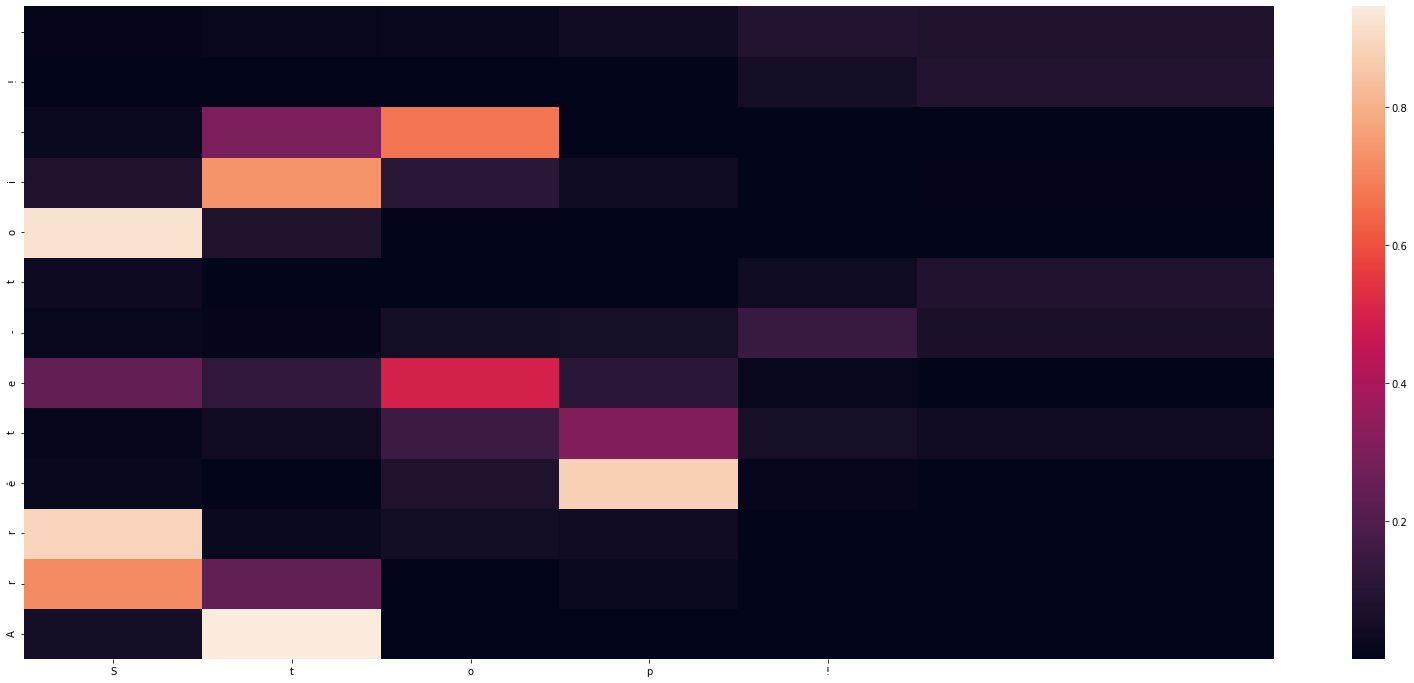

Decoded sentence: Arrête-toi !

-
Input sentence: Wait!
GT sentence: 	Attends !



<Figure size 432x288 with 0 Axes>

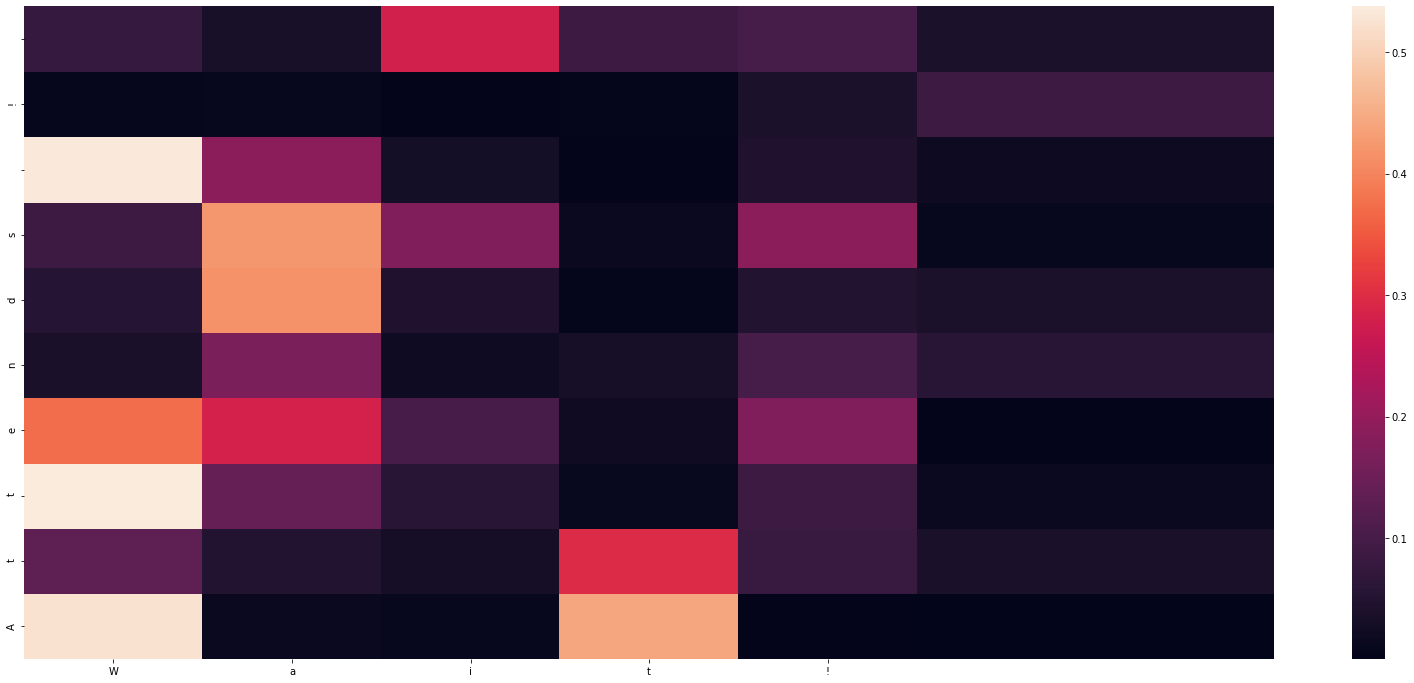

Decoded sentence: Attends !

-
Input sentence: Wait!
GT sentence: 	Attendez !



<Figure size 432x288 with 0 Axes>

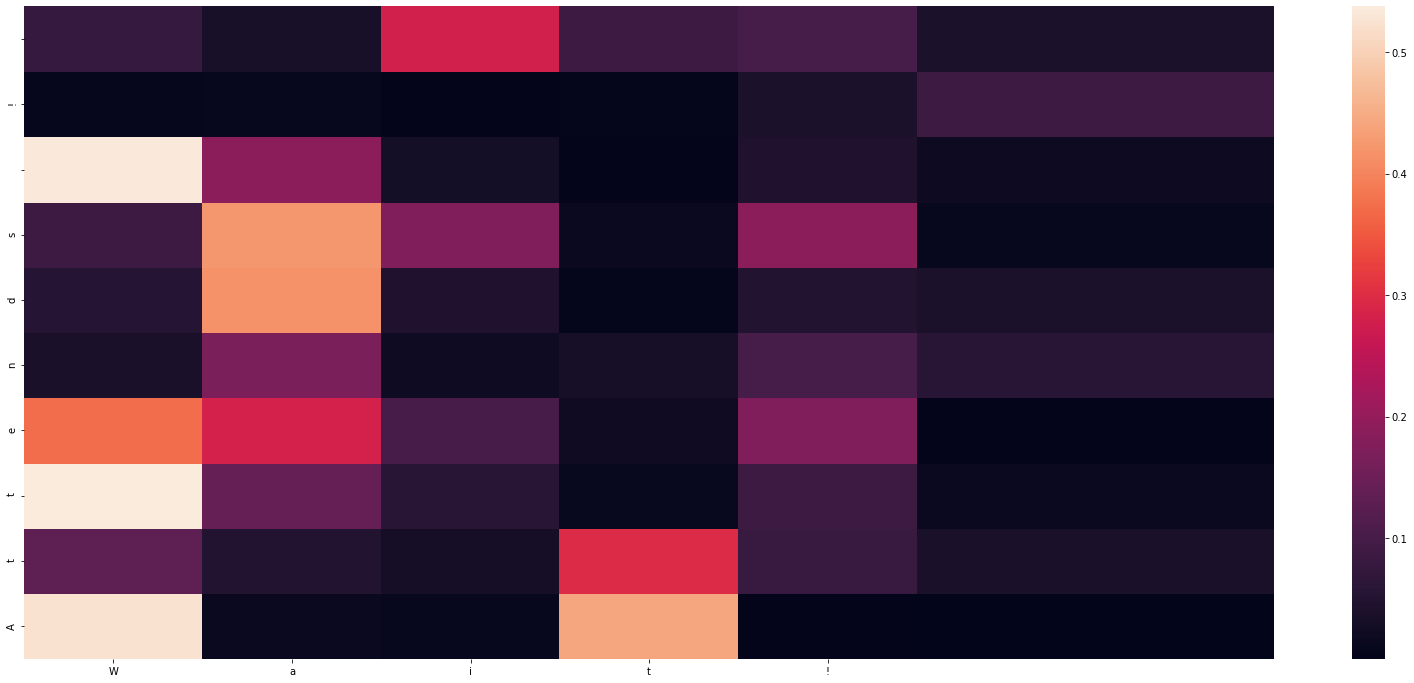

Decoded sentence: Attends !

-
Input sentence: Go on.
GT sentence: 	Poursuis.



<Figure size 432x288 with 0 Axes>

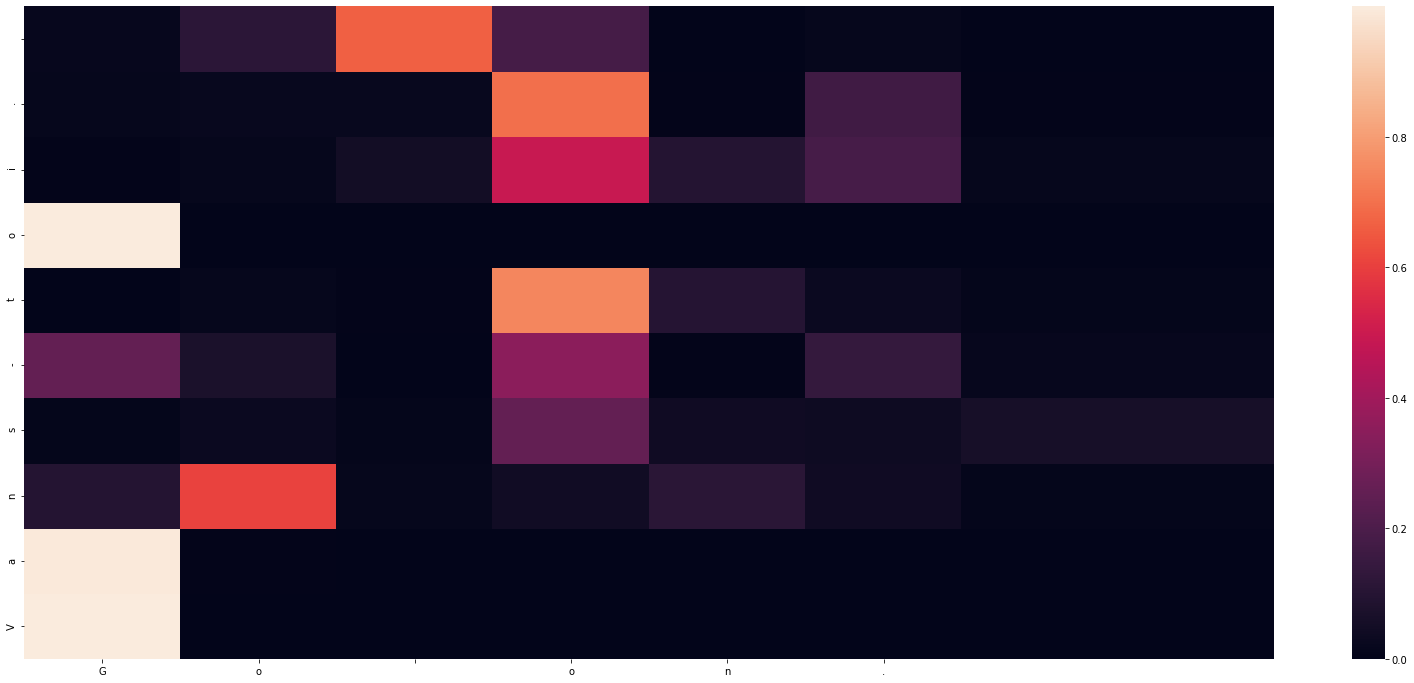

Decoded sentence: Vans-toi.

-
Input sentence: Go on.
GT sentence: 	Continuez.



<Figure size 432x288 with 0 Axes>

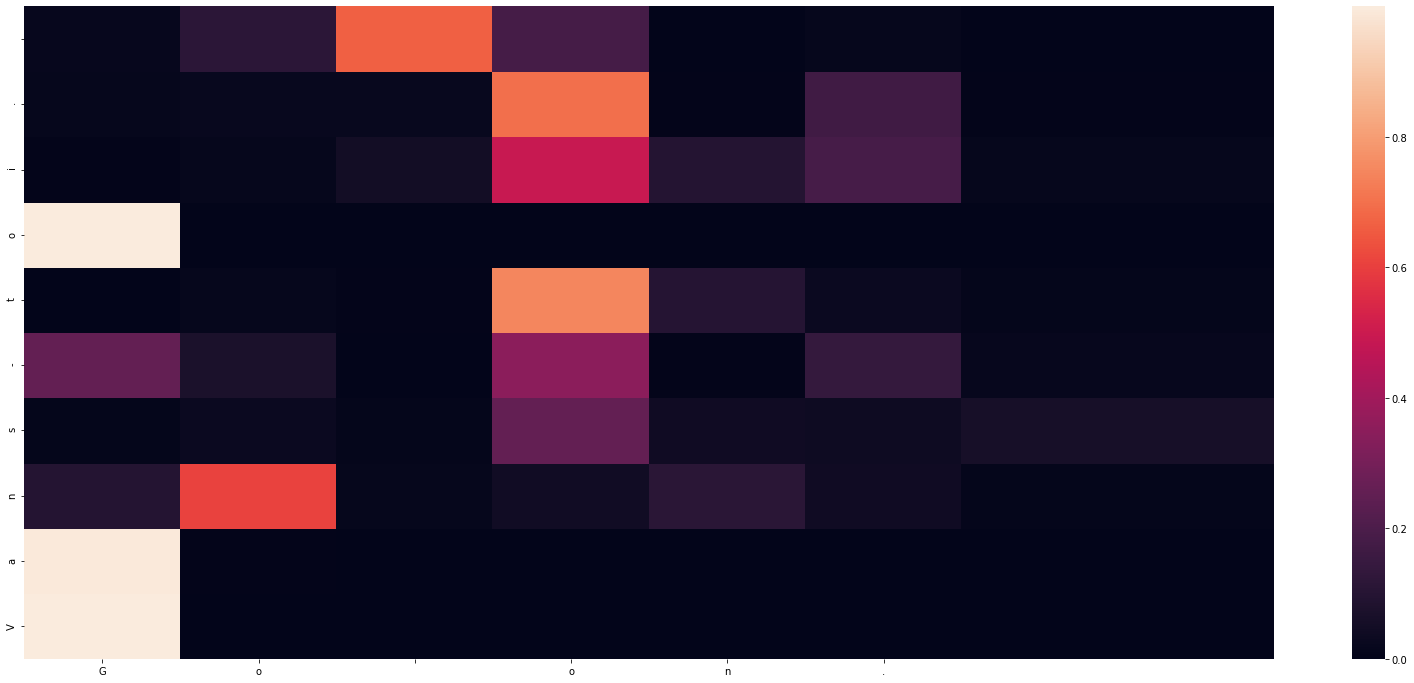

Decoded sentence: Vans-toi.

-
Input sentence: Go on.
GT sentence: 	Poursuivez.



<Figure size 432x288 with 0 Axes>

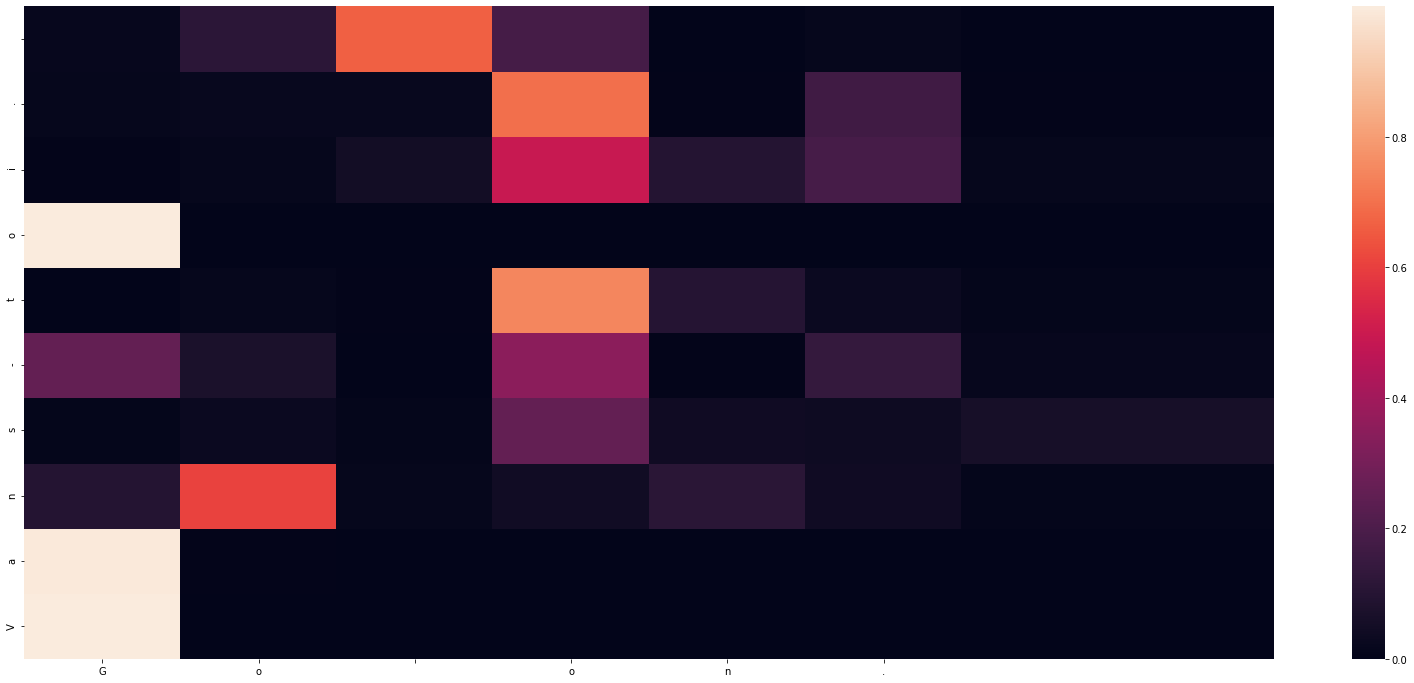

Decoded sentence: Vans-toi.

-
Input sentence: Hello!
GT sentence: 	Bonjour !



<Figure size 432x288 with 0 Axes>

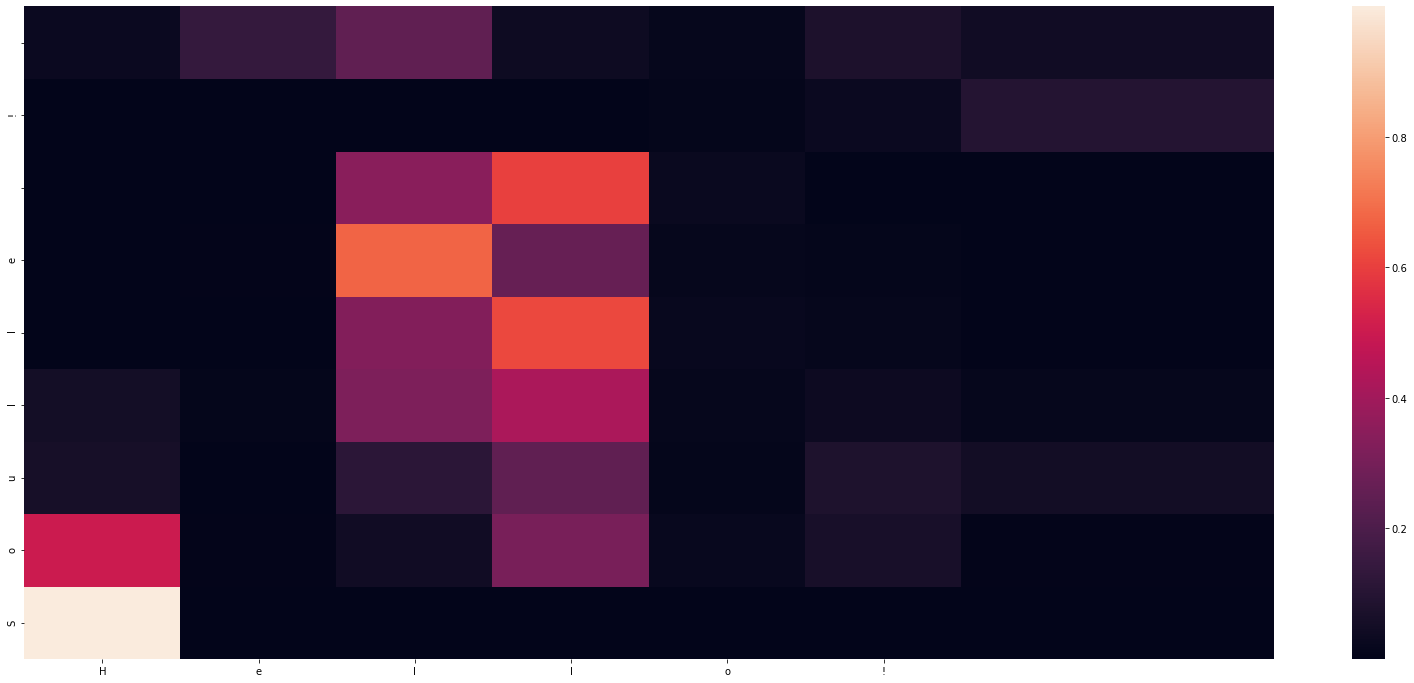

Decoded sentence: Soulle !

-
Input sentence: Hello!
GT sentence: 	Salut !



<Figure size 432x288 with 0 Axes>

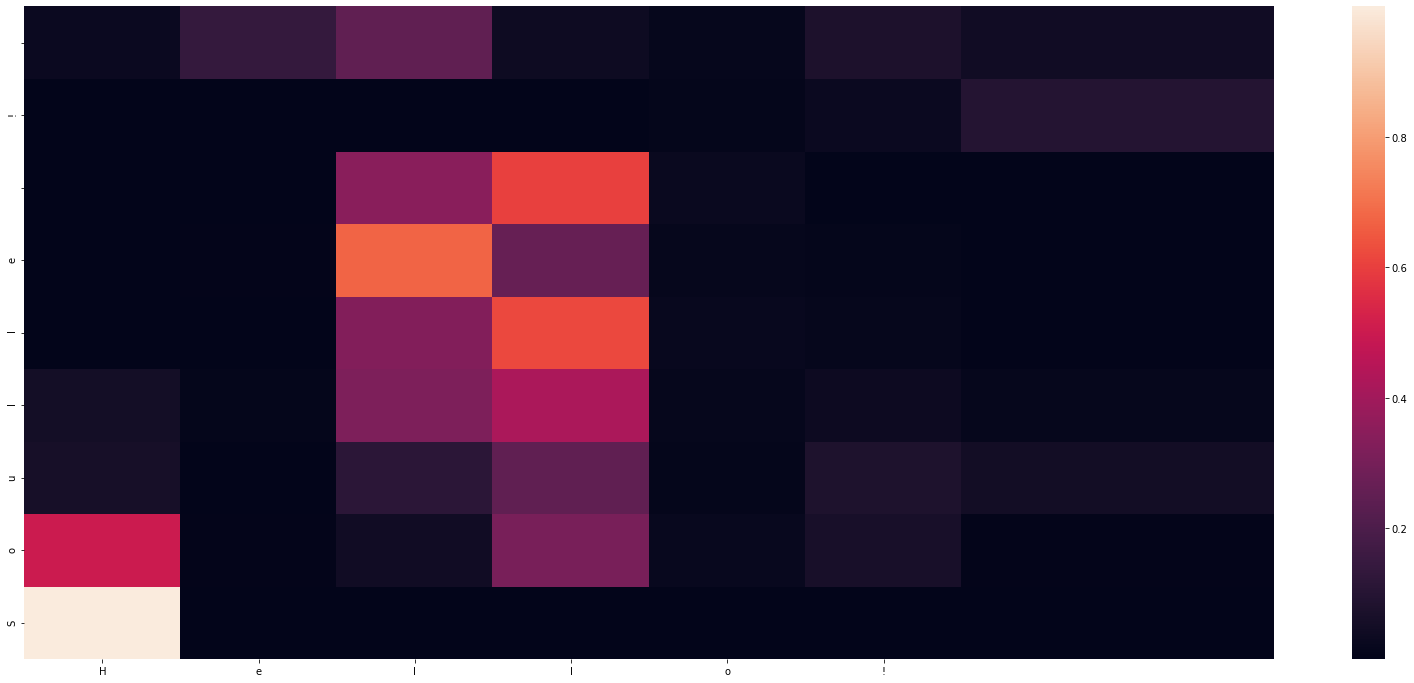

Decoded sentence: Soulle !

-
Input sentence: I see.
GT sentence: 	Je comprends.



<Figure size 432x288 with 0 Axes>

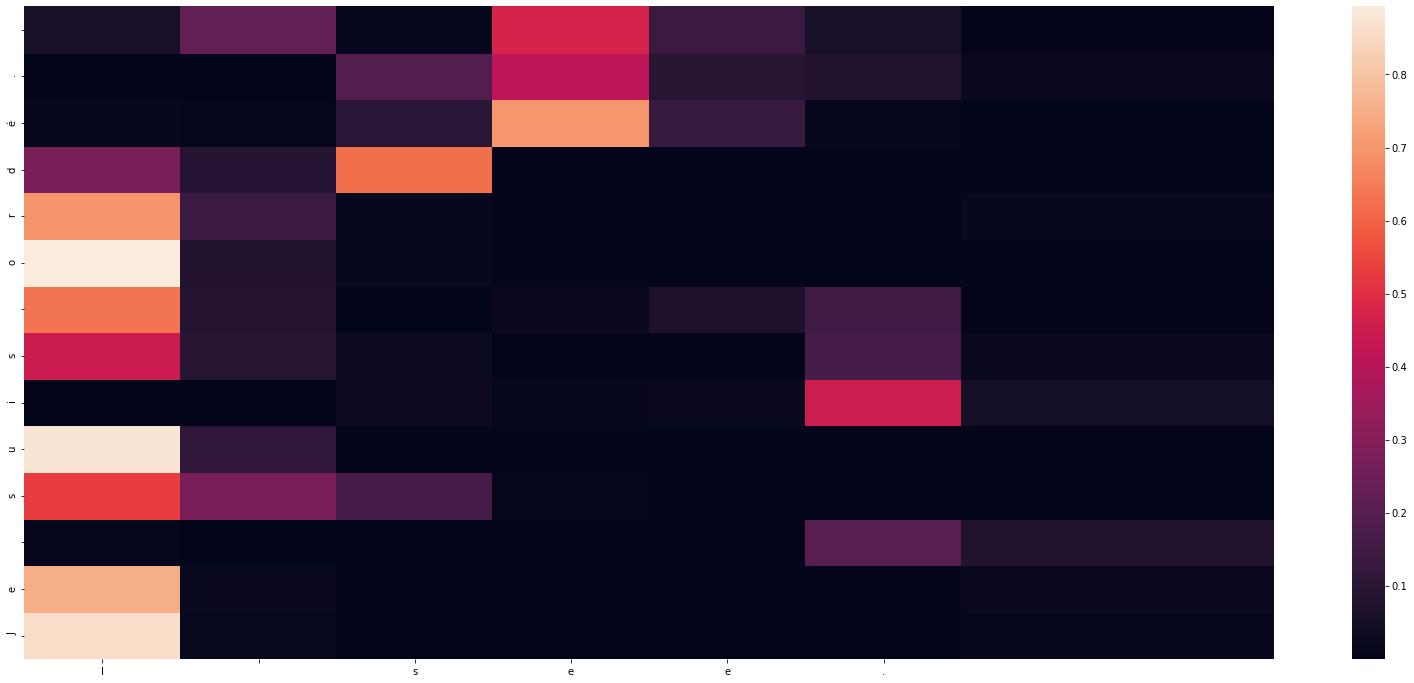

Decoded sentence: Je suis ordé.

-
Input sentence: I try.
GT sentence: 	J'essaye.



<Figure size 432x288 with 0 Axes>

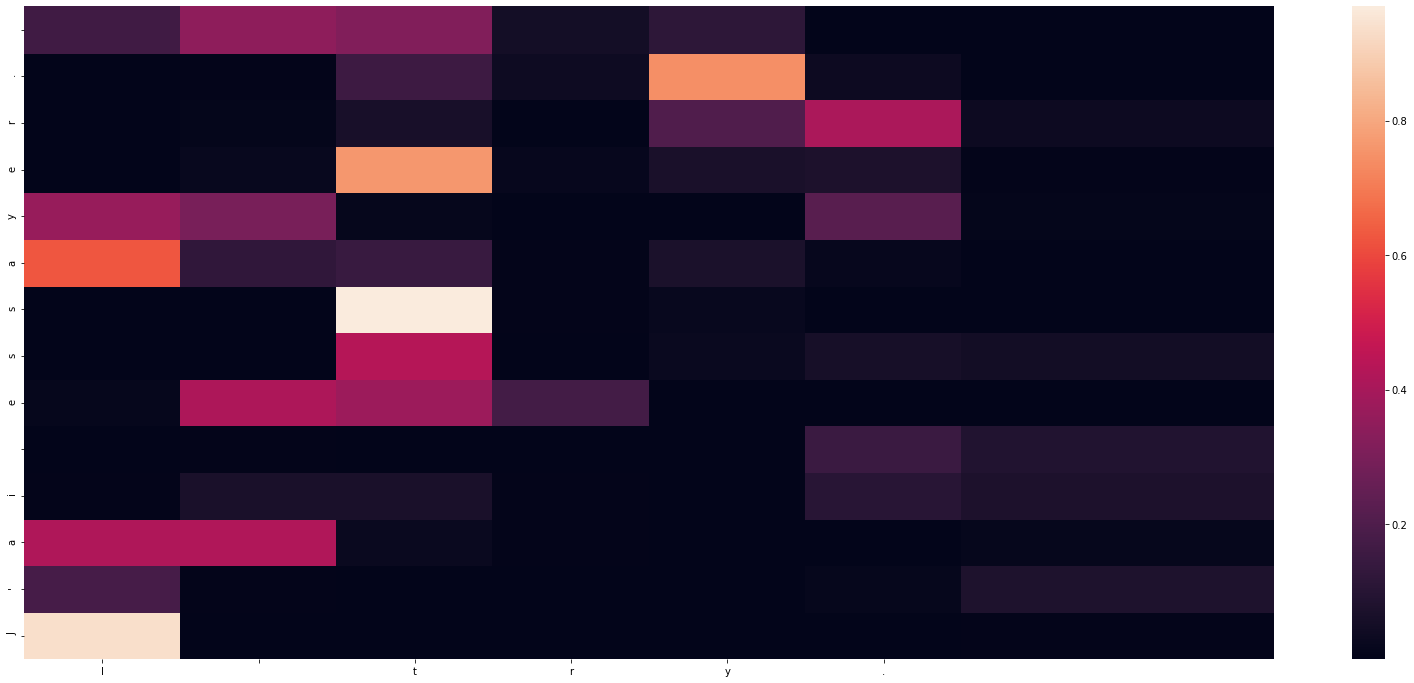

Decoded sentence: J'ai essayer.

-
Input sentence: I won!
GT sentence: 	J'ai gagné !



<Figure size 432x288 with 0 Axes>

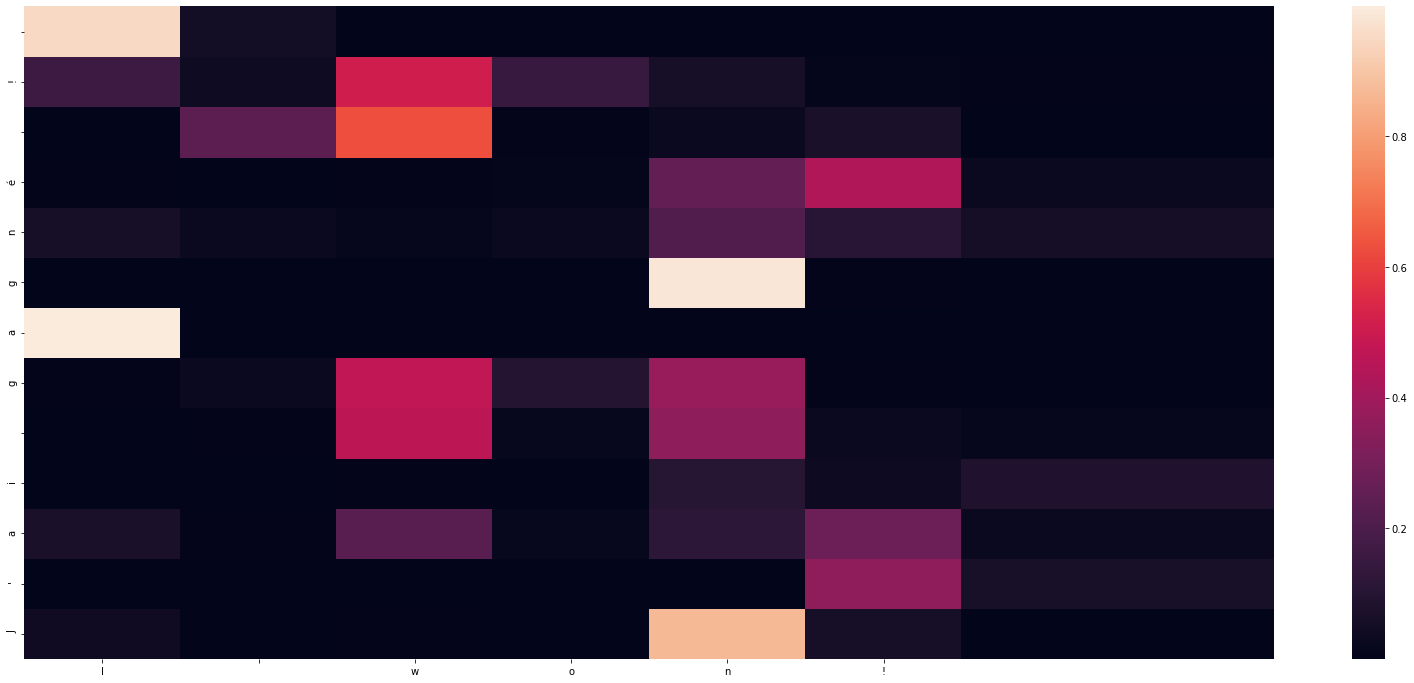

Decoded sentence: J'ai gagné !

-
Input sentence: I won!
GT sentence: 	Je l'ai emporté !



<Figure size 432x288 with 0 Axes>

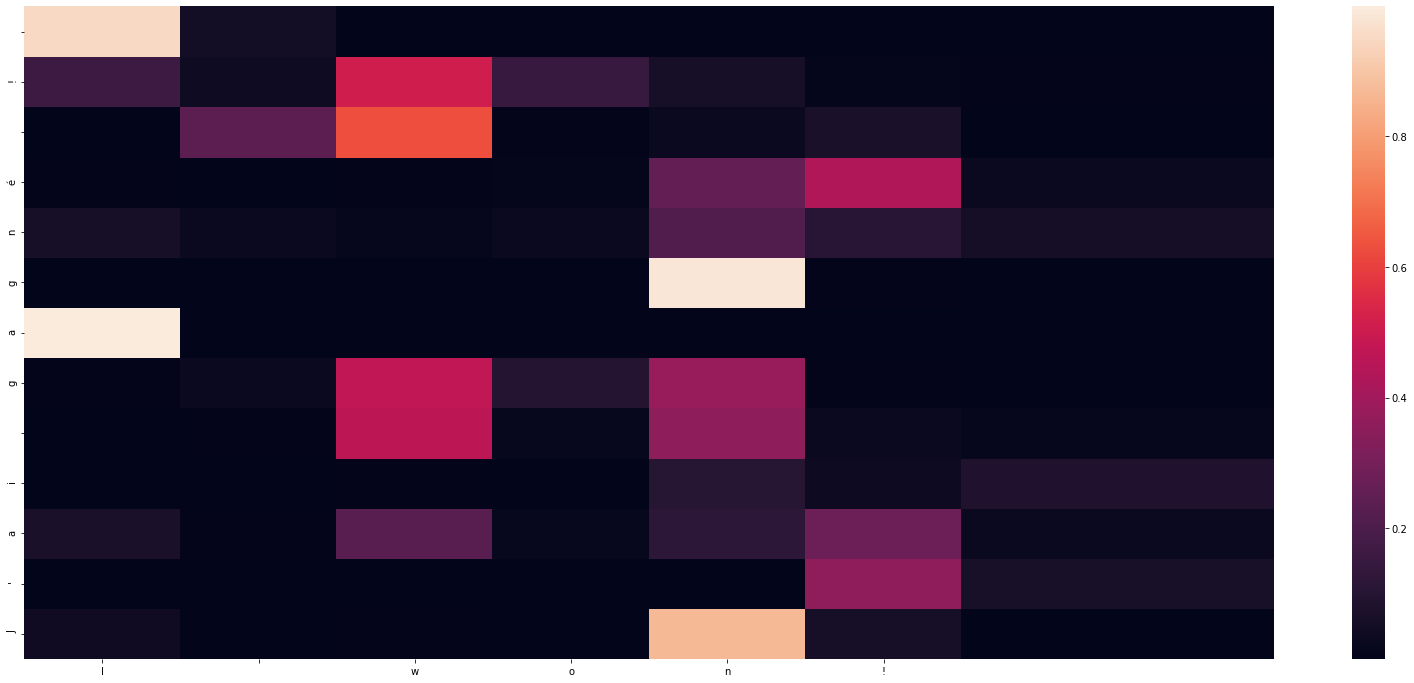

Decoded sentence: J'ai gagné !

-
Input sentence: I won.
GT sentence: 	J’ai gagné.



<Figure size 432x288 with 0 Axes>

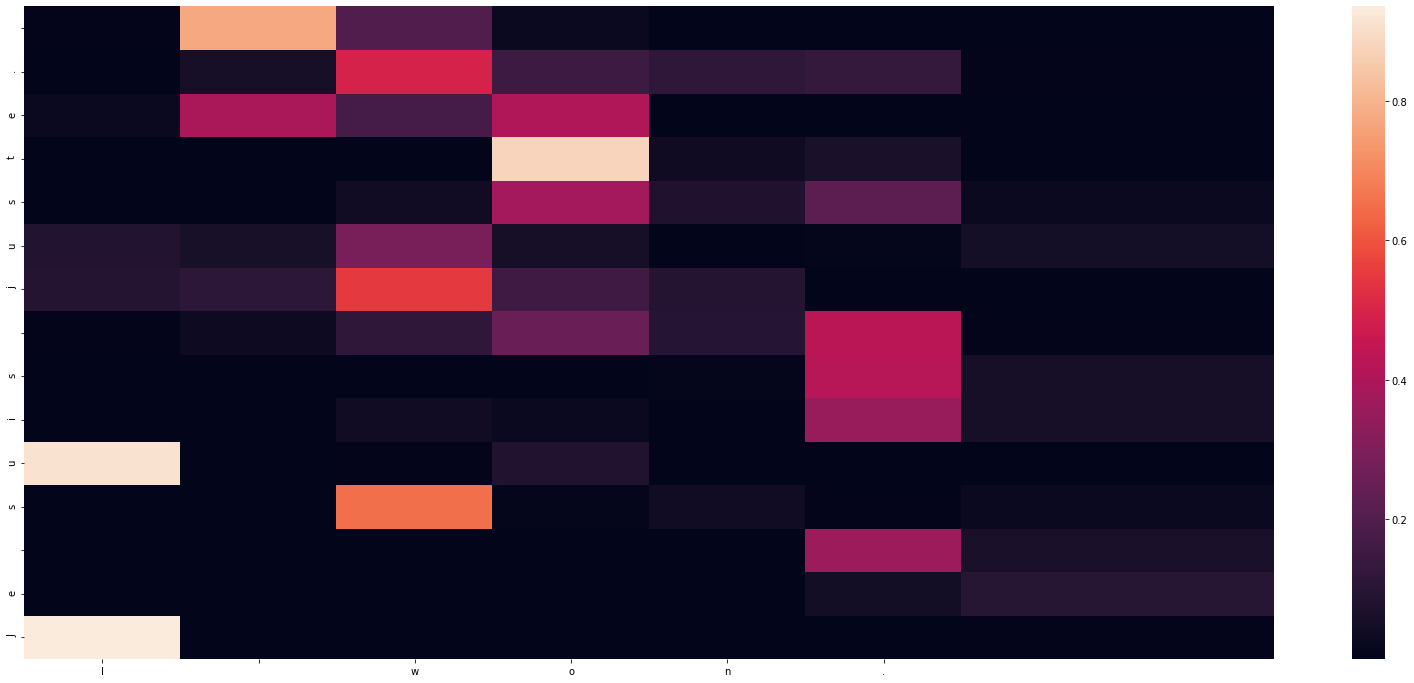

Decoded sentence: Je suis juste.

-
Input sentence: Oh no!
GT sentence: 	Oh non !



<Figure size 432x288 with 0 Axes>

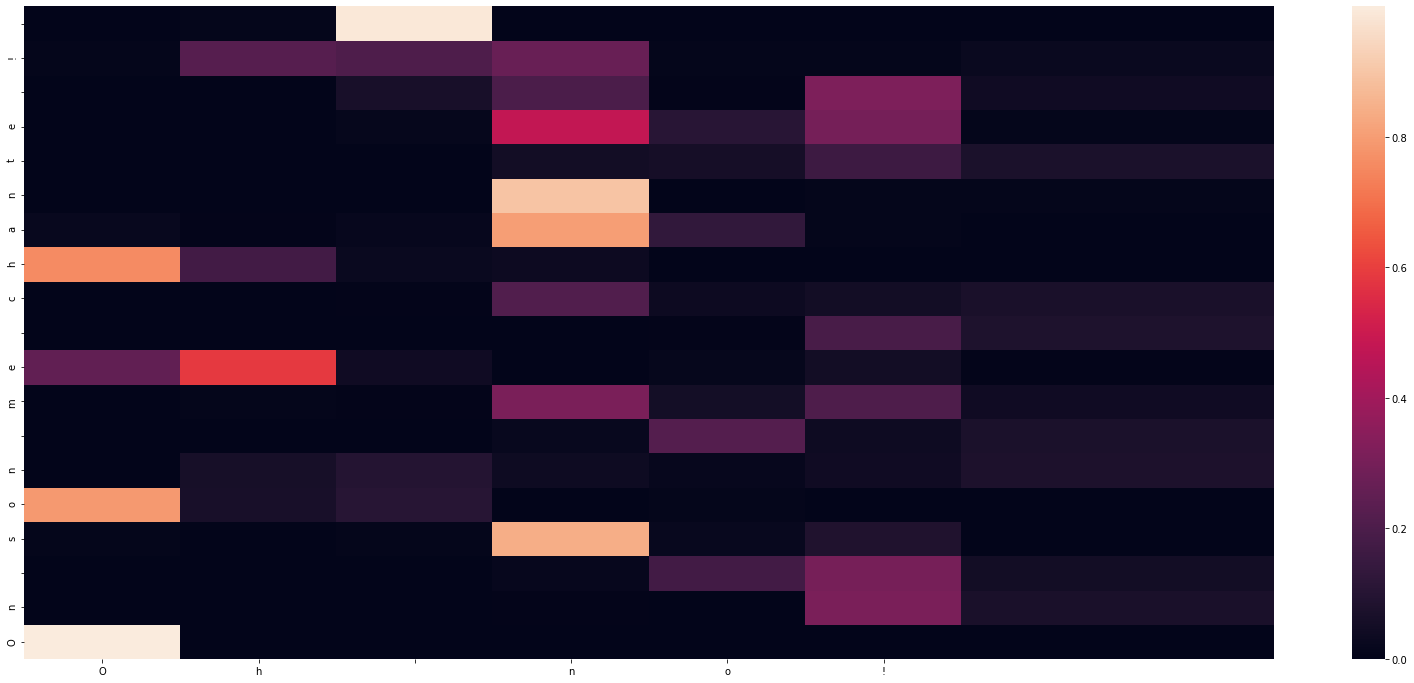

Decoded sentence: On son me chante !

-
Input sentence: Attack!
GT sentence: 	Attaque !



<Figure size 432x288 with 0 Axes>

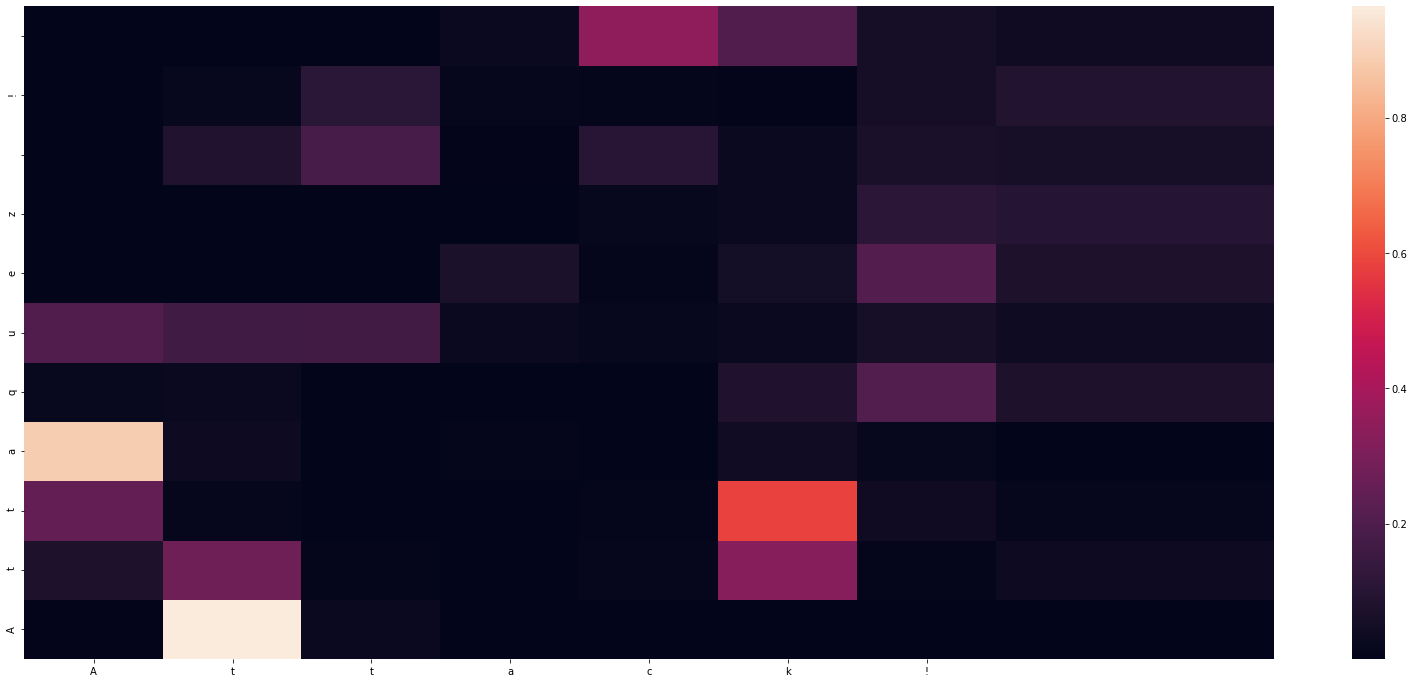

Decoded sentence: Attaquez !

-
Input sentence: Attack!
GT sentence: 	Attaquez !



<Figure size 432x288 with 0 Axes>

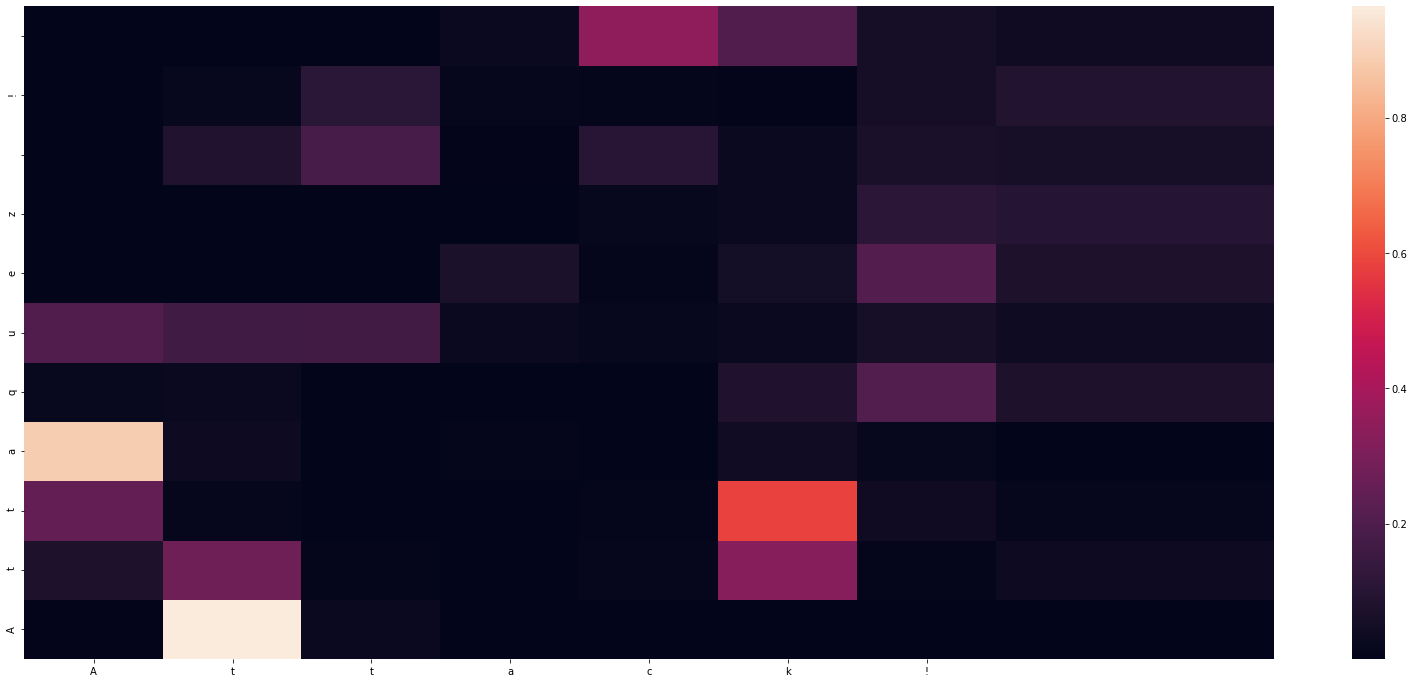

Decoded sentence: Attaquez !

-
Input sentence: Cheers!
GT sentence: 	Santé !



<Figure size 432x288 with 0 Axes>

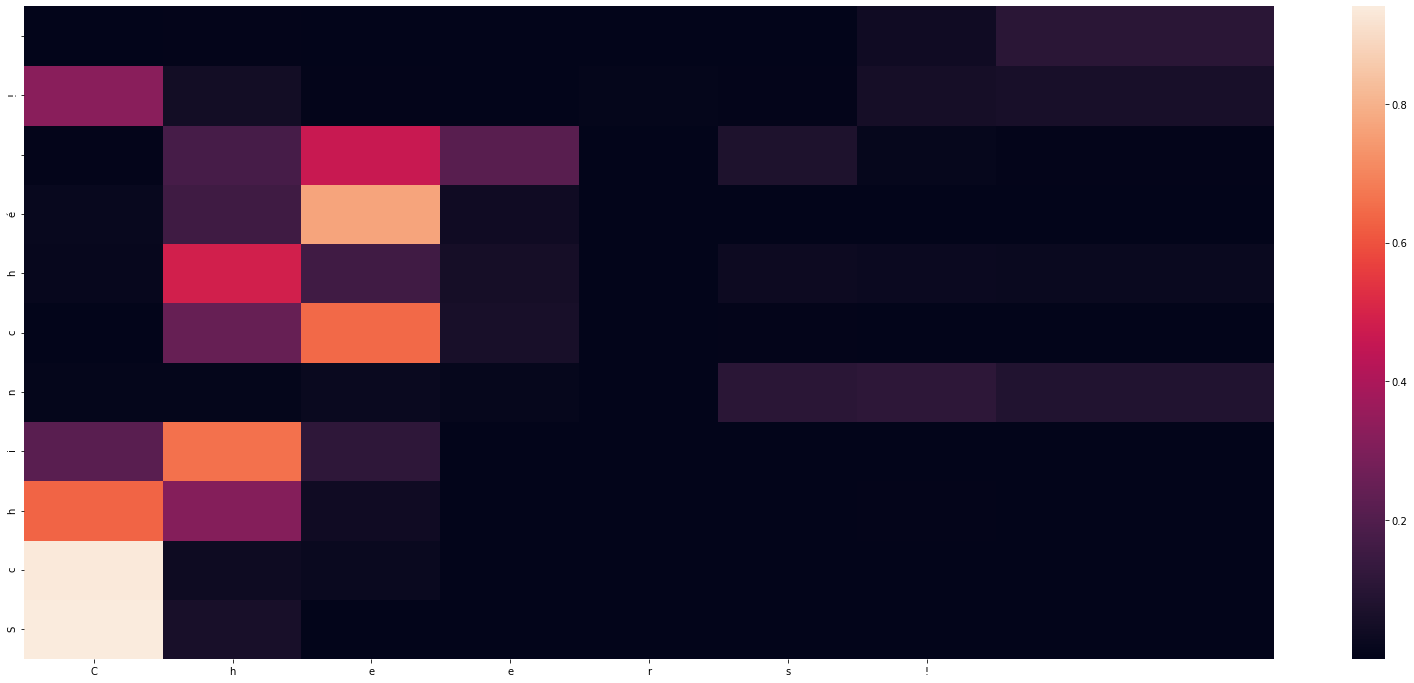

Decoded sentence: Schinché !

-
Input sentence: Cheers!
GT sentence: 	À votre santé !



<Figure size 432x288 with 0 Axes>

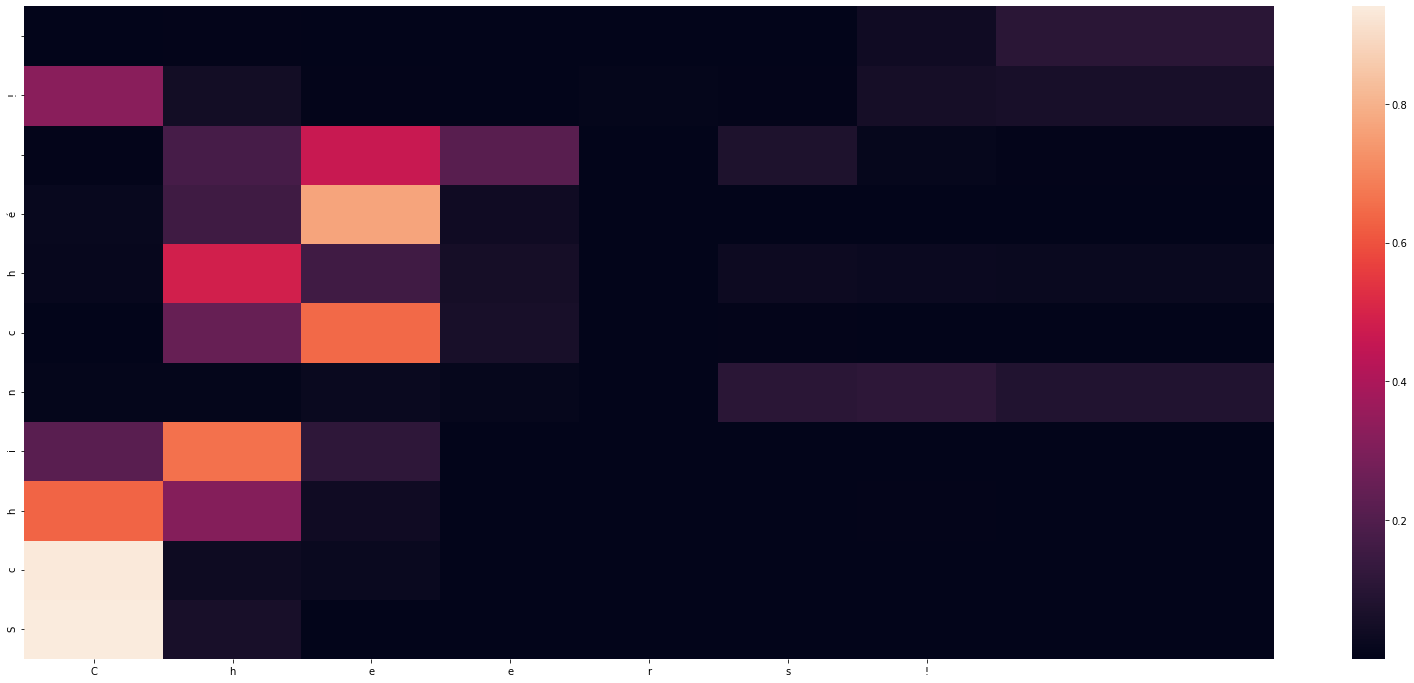

Decoded sentence: Schinché !

-
Input sentence: Cheers!
GT sentence: 	Merci !



<Figure size 432x288 with 0 Axes>

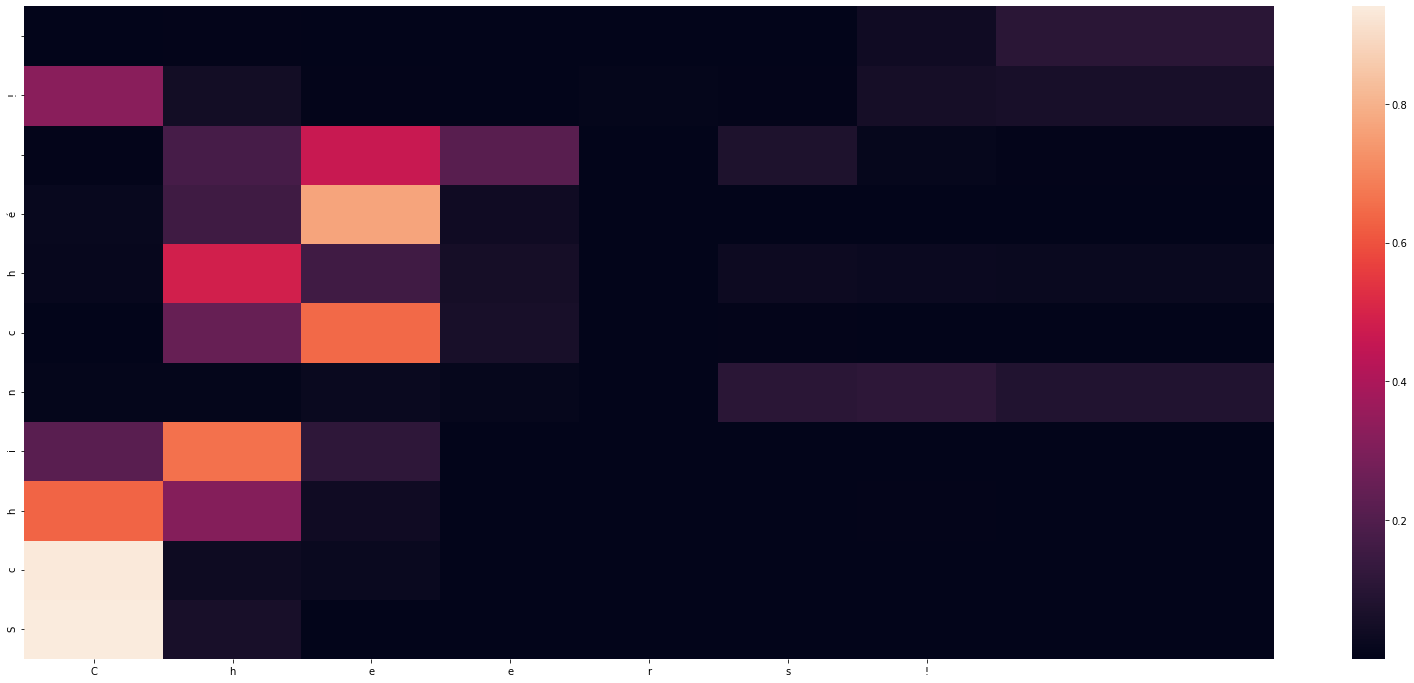

Decoded sentence: Schinché !

-
Input sentence: Cheers!
GT sentence: 	Tchin-tchin !



<Figure size 432x288 with 0 Axes>

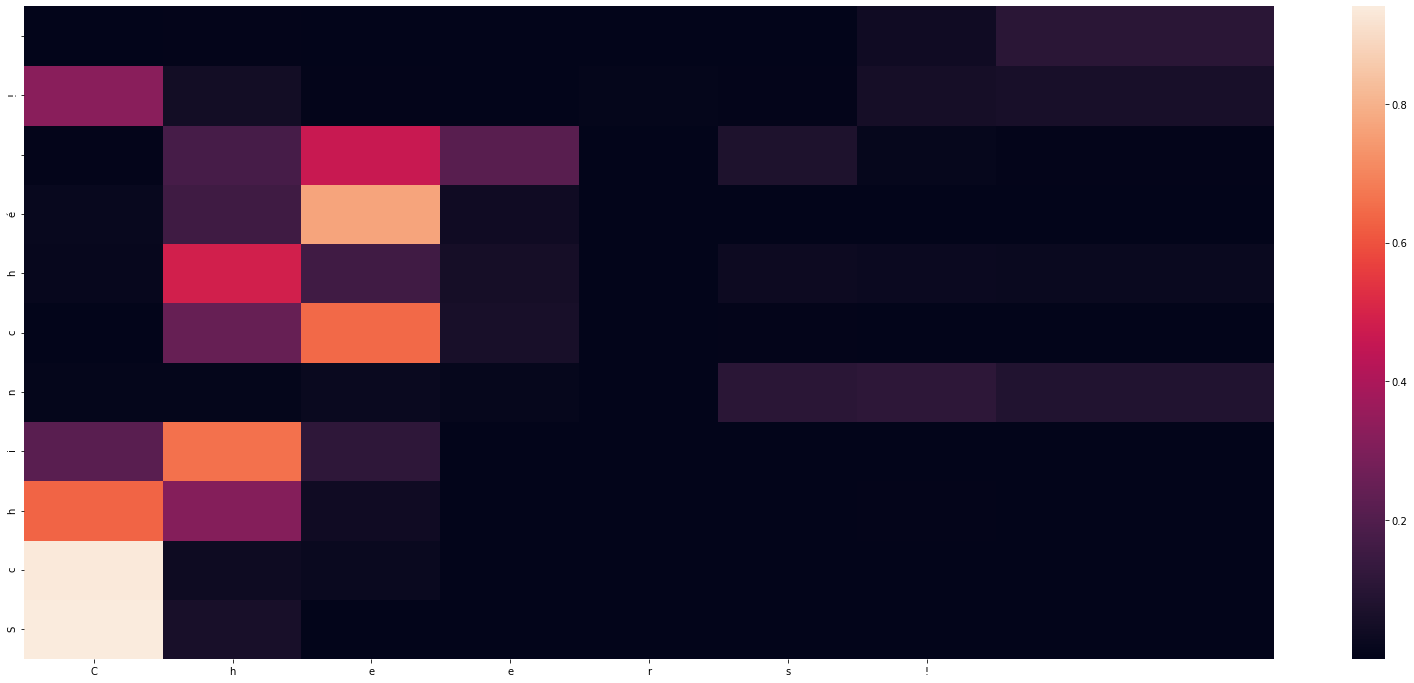

Decoded sentence: Schinché !

-
Input sentence: Get up.
GT sentence: 	Lève-toi.



<Figure size 432x288 with 0 Axes>

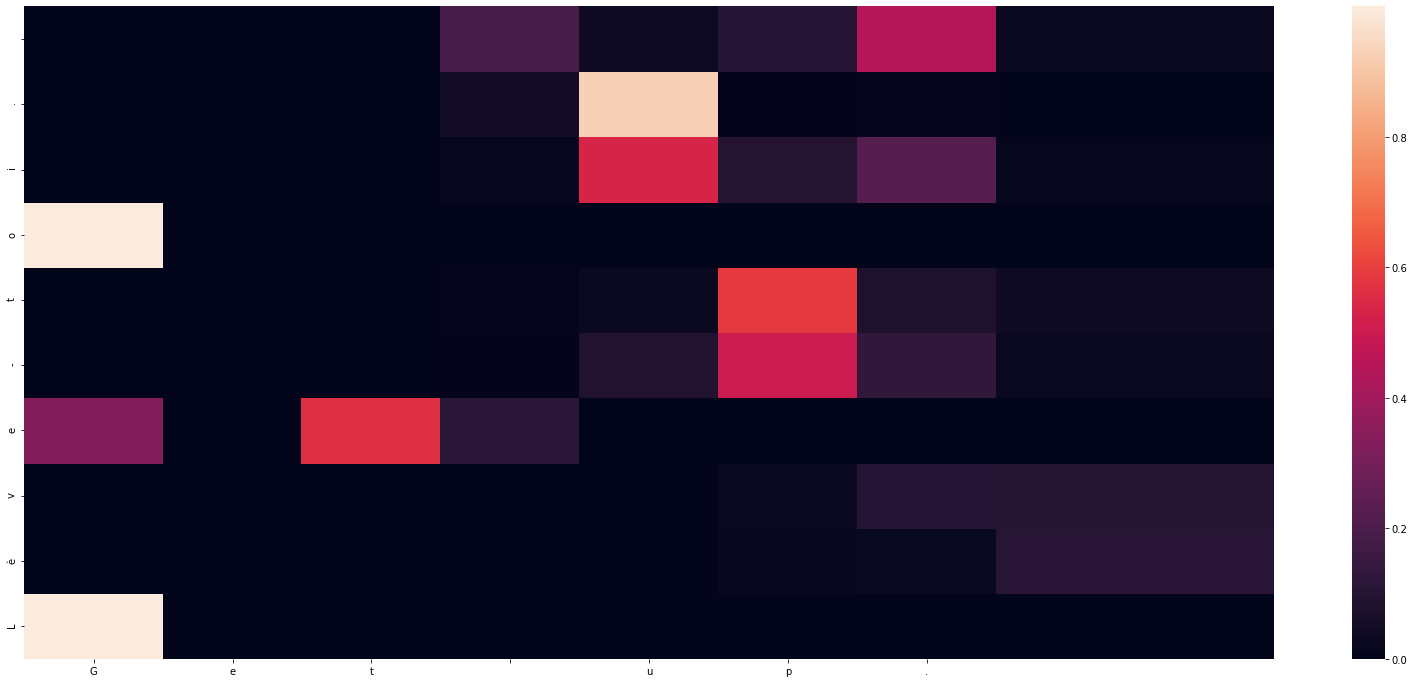

Decoded sentence: Lève-toi.

-
Input sentence: Go now.
GT sentence: 	Va, maintenant.



<Figure size 432x288 with 0 Axes>

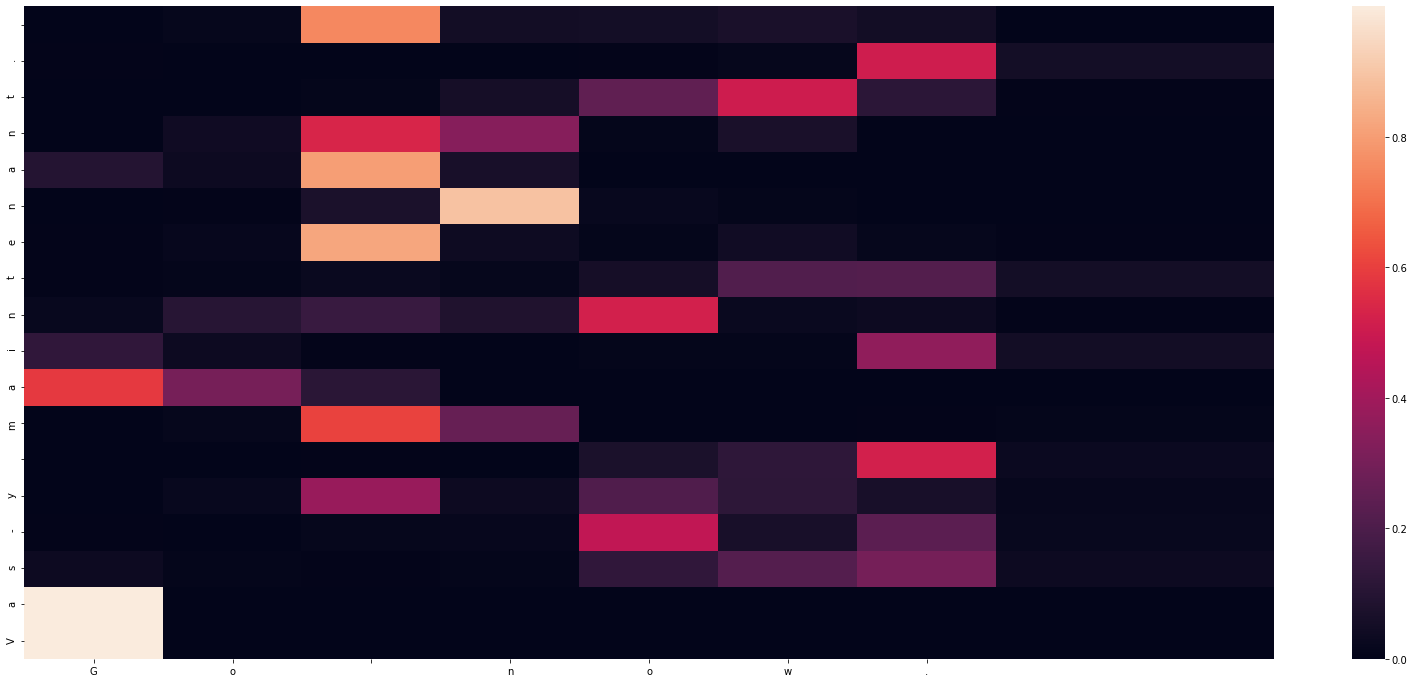

Decoded sentence: Vas-y maintenant.

-
Input sentence: Go now.
GT sentence: 	Allez-y maintenant.



<Figure size 432x288 with 0 Axes>

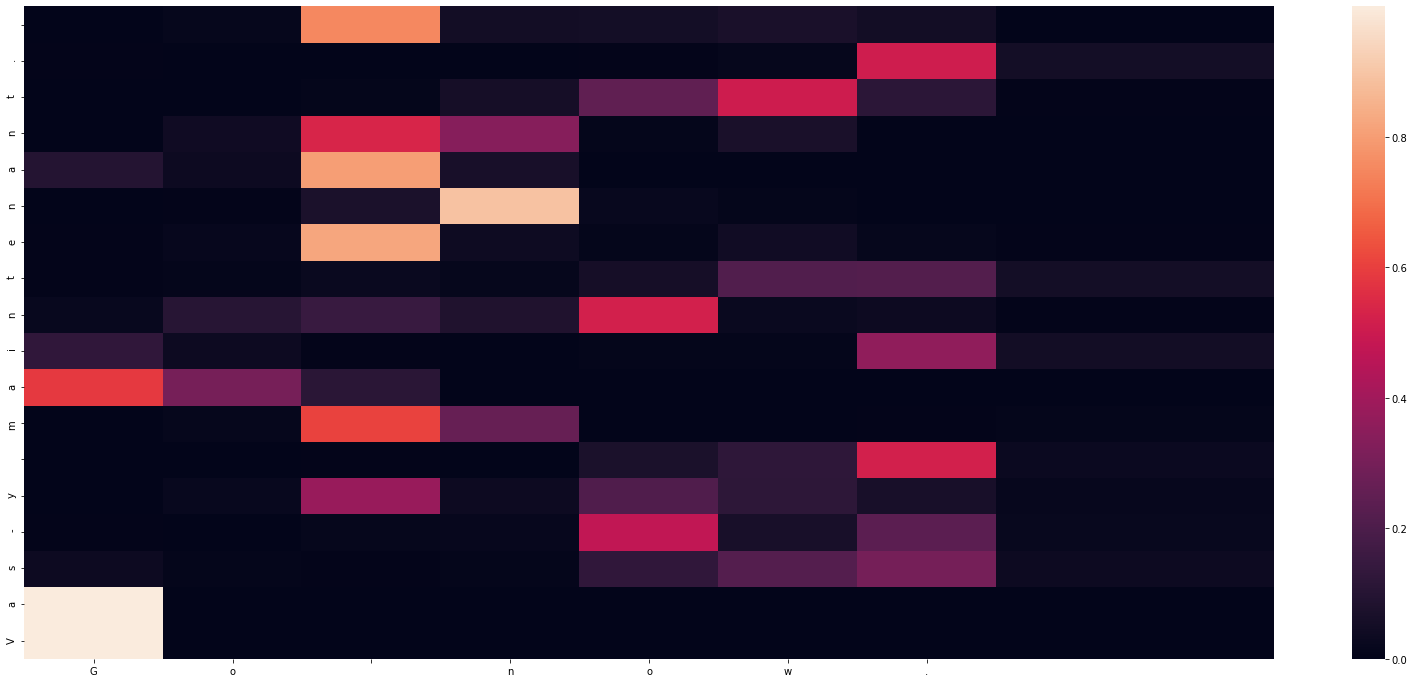

Decoded sentence: Vas-y maintenant.

-
Input sentence: Go now.
GT sentence: 	Vas-y maintenant.



<Figure size 432x288 with 0 Axes>

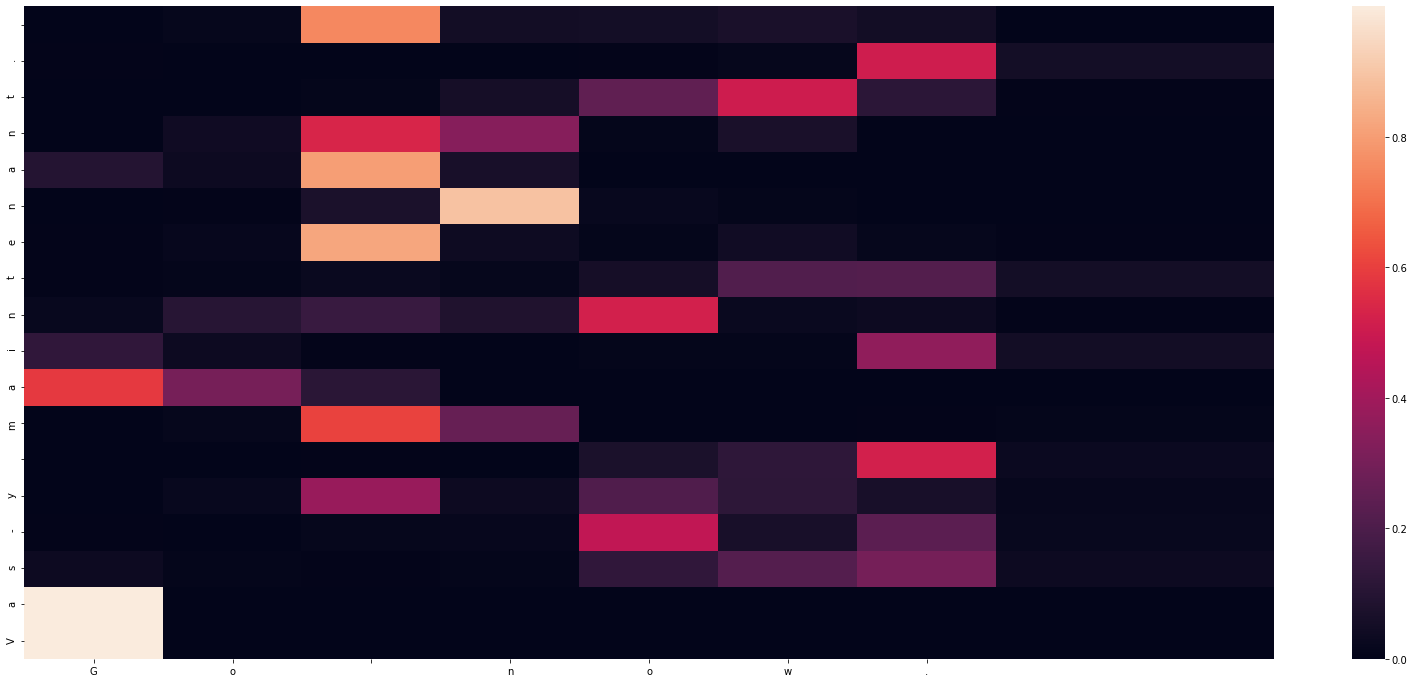

Decoded sentence: Vas-y maintenant.

-
Input sentence: Got it!
GT sentence: 	J'ai pigé !



<Figure size 432x288 with 0 Axes>

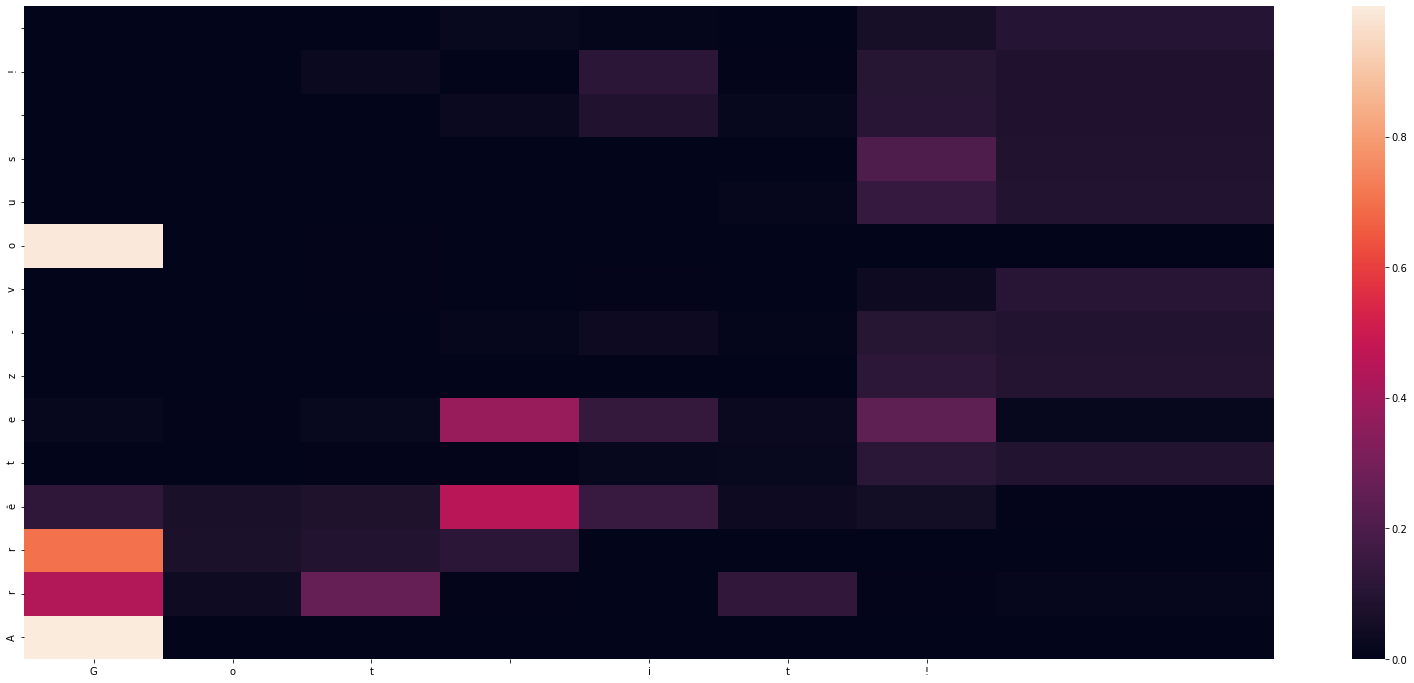

Decoded sentence: Arrêtez-vous !

-
Input sentence: Got it!
GT sentence: 	Compris !



<Figure size 432x288 with 0 Axes>

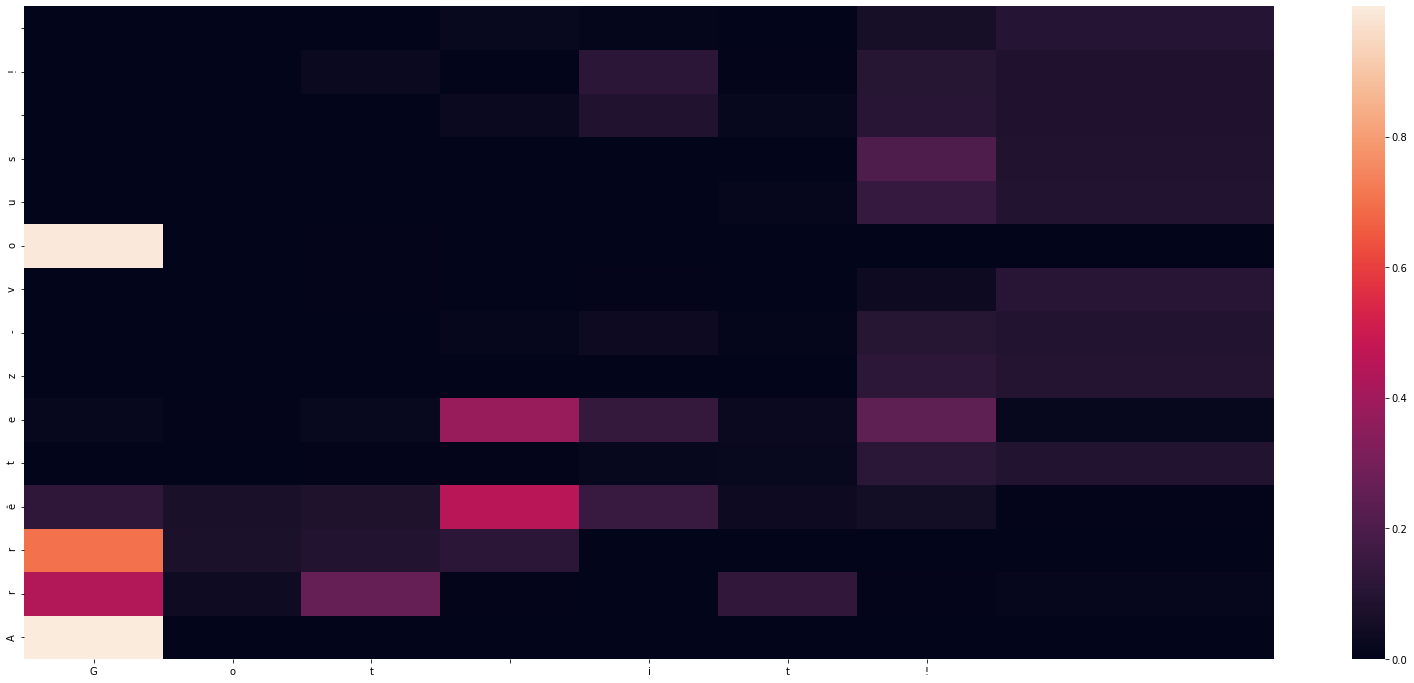

Decoded sentence: Arrêtez-vous !

-
Input sentence: Got it?
GT sentence: 	Pigé ?



<Figure size 432x288 with 0 Axes>

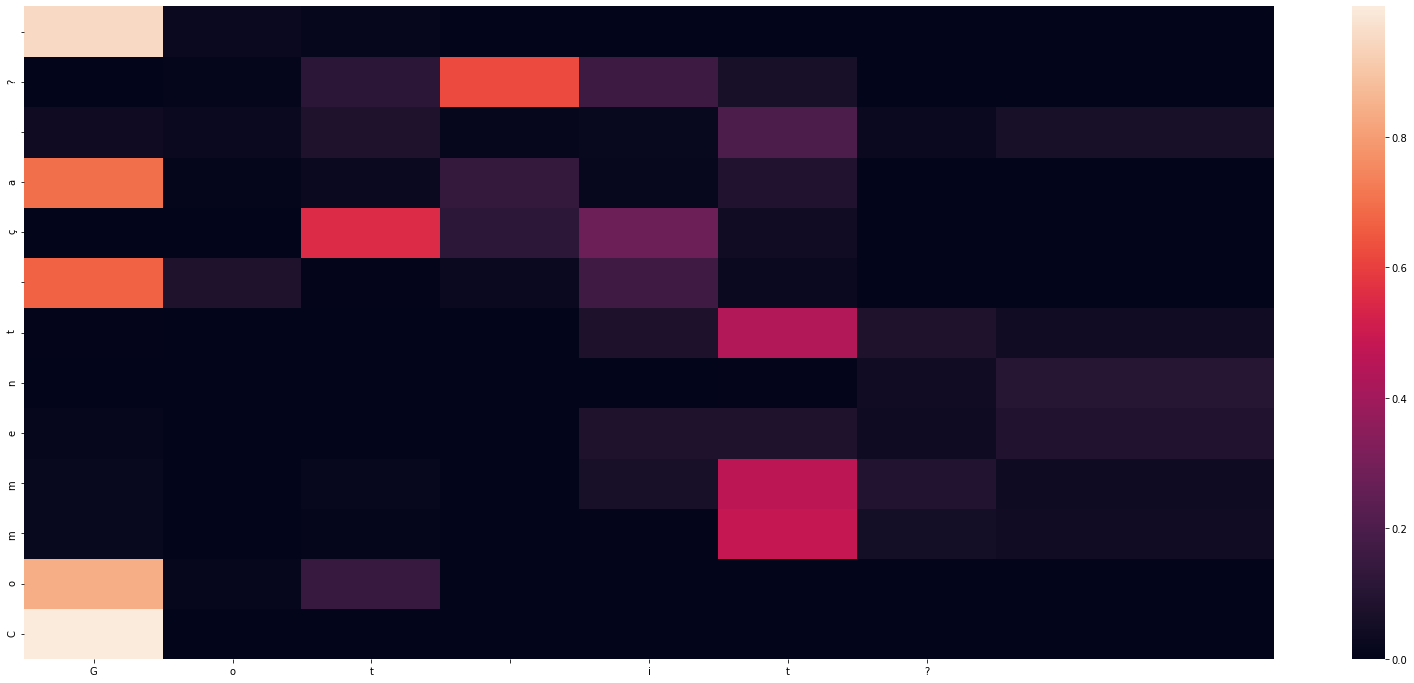

Decoded sentence: Comment ça ?

-
Input sentence: Got it?
GT sentence: 	Compris ?



<Figure size 432x288 with 0 Axes>

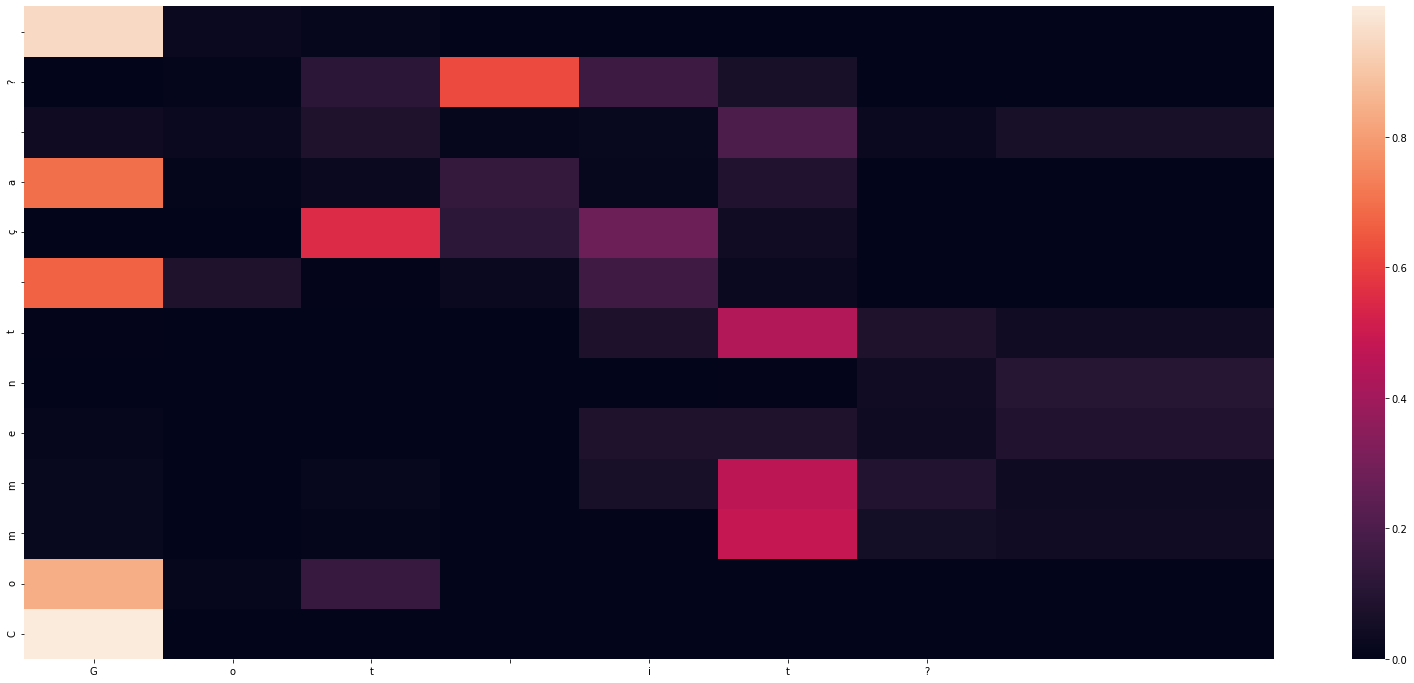

Decoded sentence: Comment ça ?

-
Input sentence: Got it?
GT sentence: 	T'as capté ?



<Figure size 432x288 with 0 Axes>

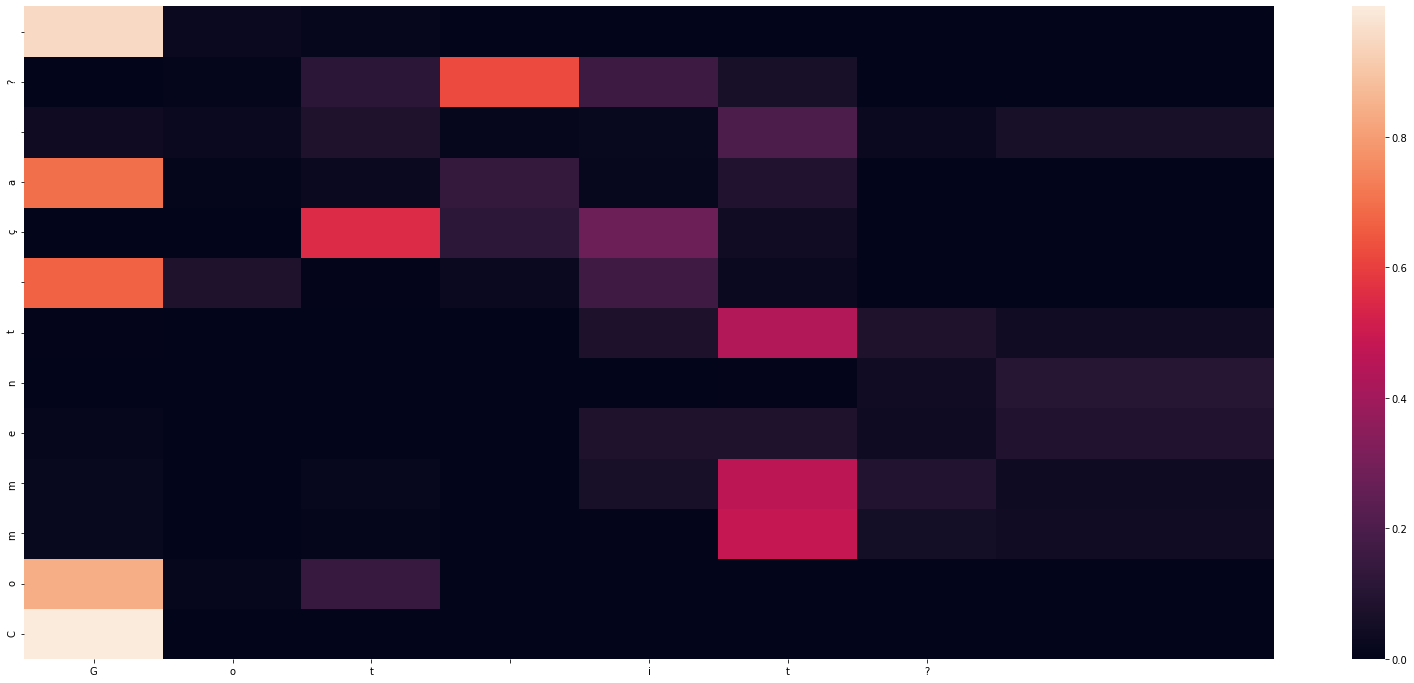

Decoded sentence: Comment ça ?

-
Input sentence: Hop in.
GT sentence: 	Monte.



<Figure size 432x288 with 0 Axes>

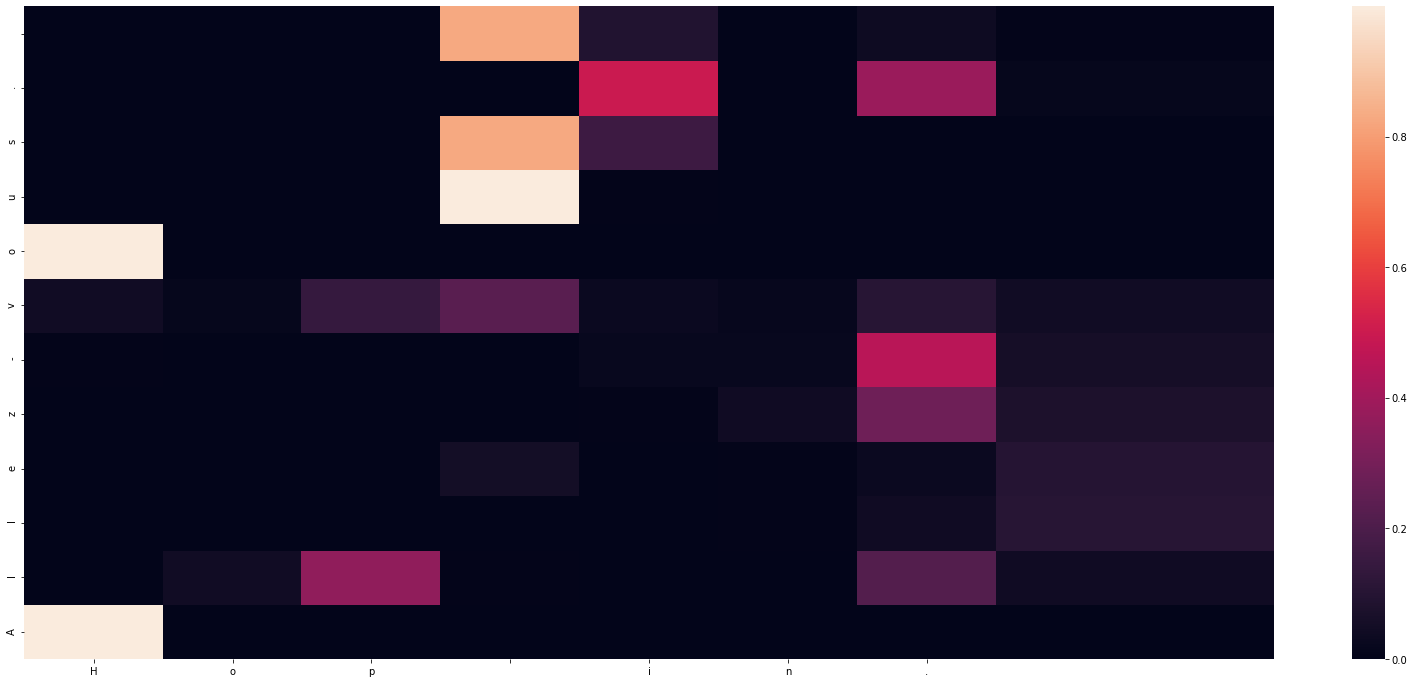

Decoded sentence: Allez-vous.

-
Input sentence: Hop in.
GT sentence: 	Montez.



<Figure size 432x288 with 0 Axes>

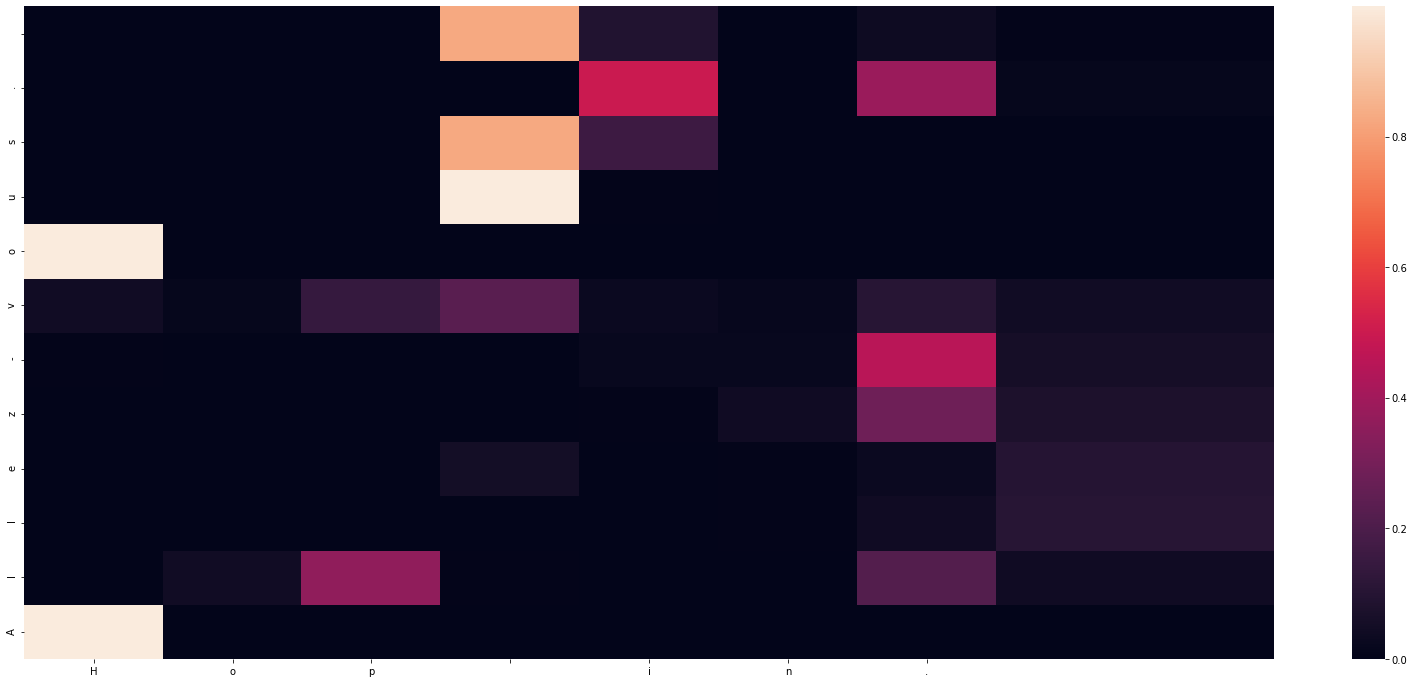

Decoded sentence: Allez-vous.

-
Input sentence: Hug me.
GT sentence: 	Serre-moi dans tes bras !



<Figure size 432x288 with 0 Axes>

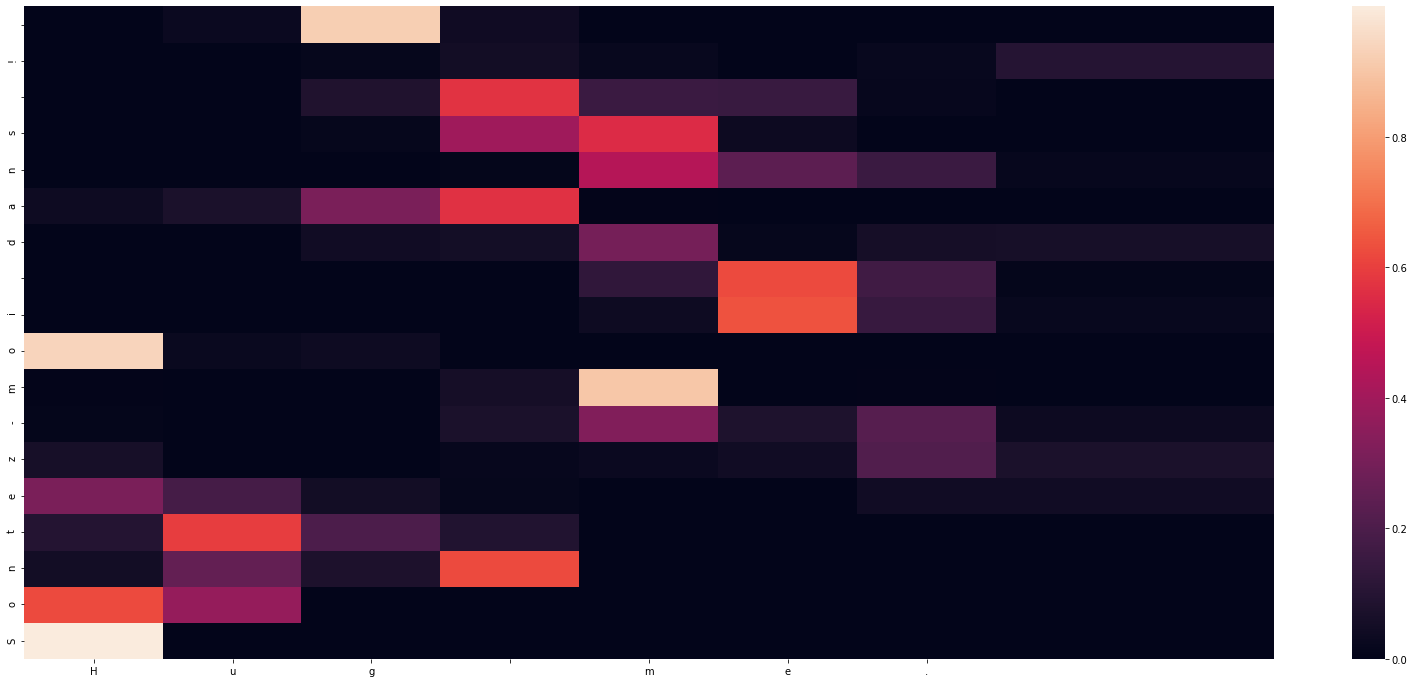

Decoded sentence: Sontez-moi dans !

-
Input sentence: Hug me.
GT sentence: 	Serrez-moi dans vos bras !



<Figure size 432x288 with 0 Axes>

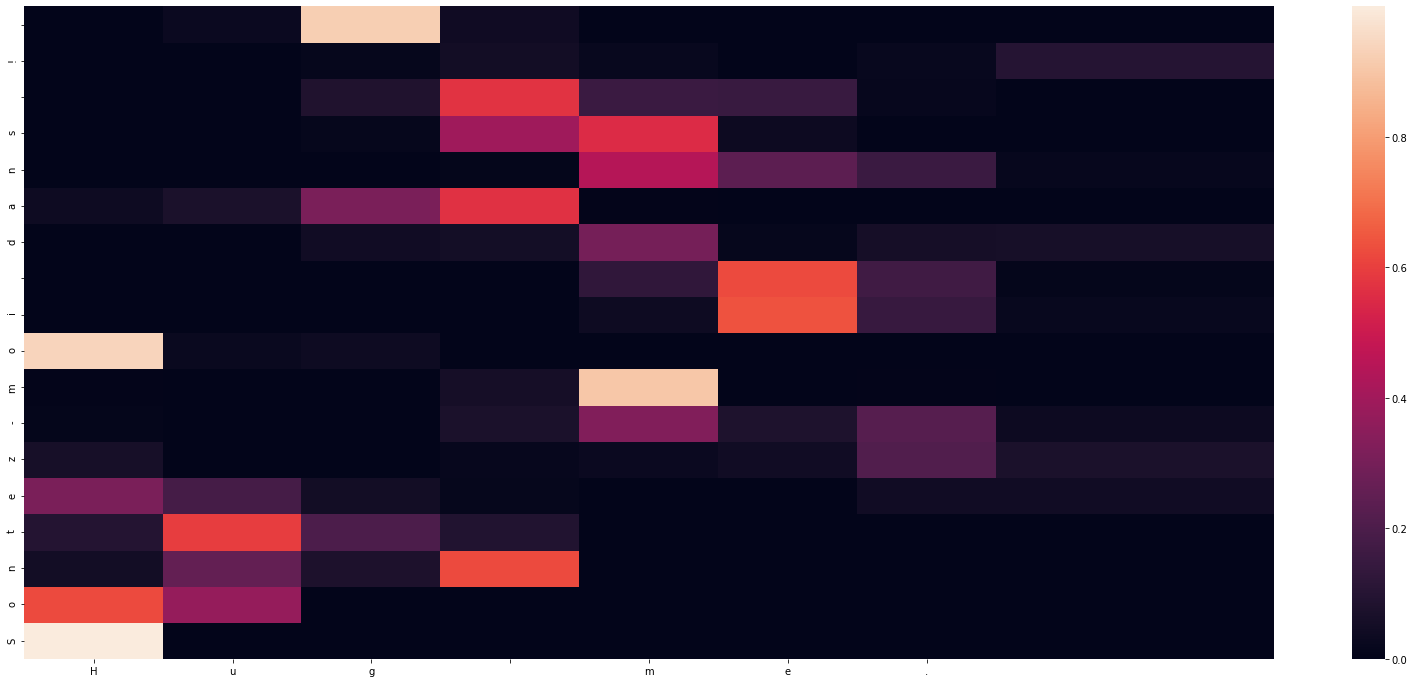

Decoded sentence: Sontez-moi dans !

-
Input sentence: I fell.
GT sentence: 	Je suis tombée.



<Figure size 432x288 with 0 Axes>

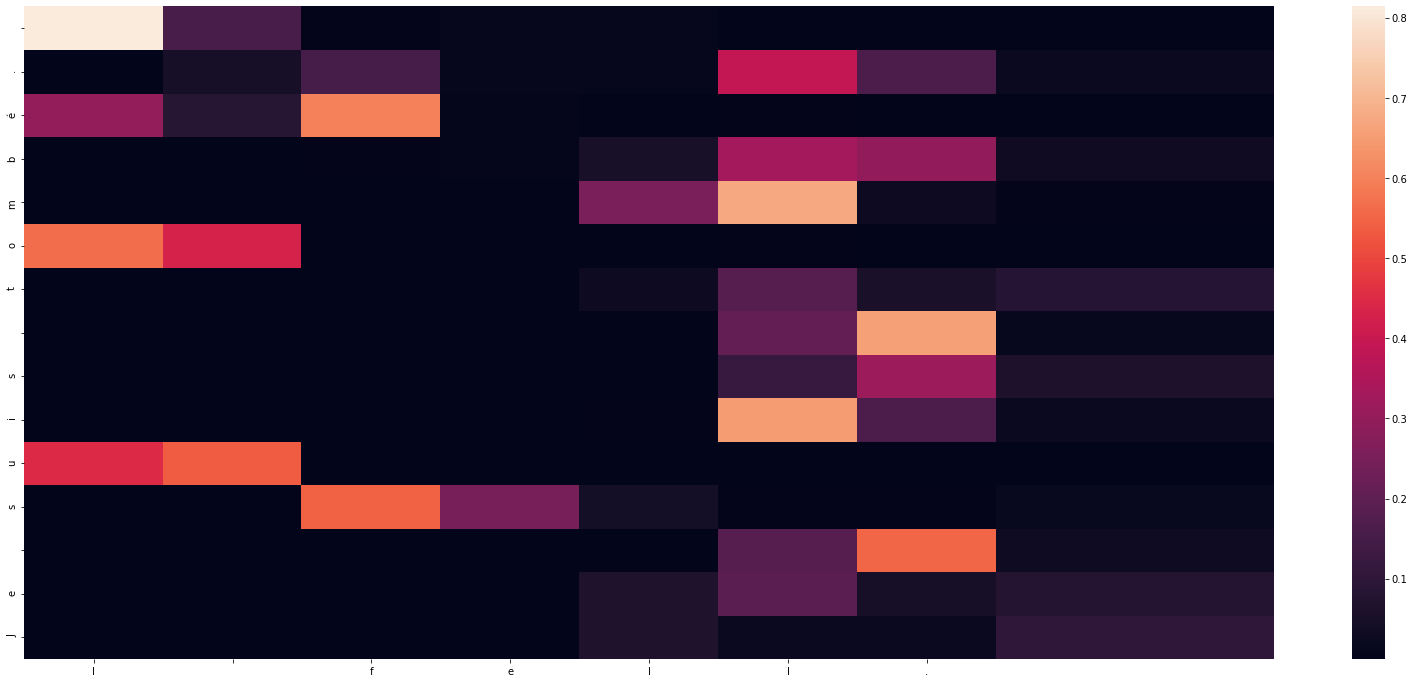

Decoded sentence: Je suis tombé.

-
Input sentence: I fell.
GT sentence: 	Je suis tombé.



<Figure size 432x288 with 0 Axes>

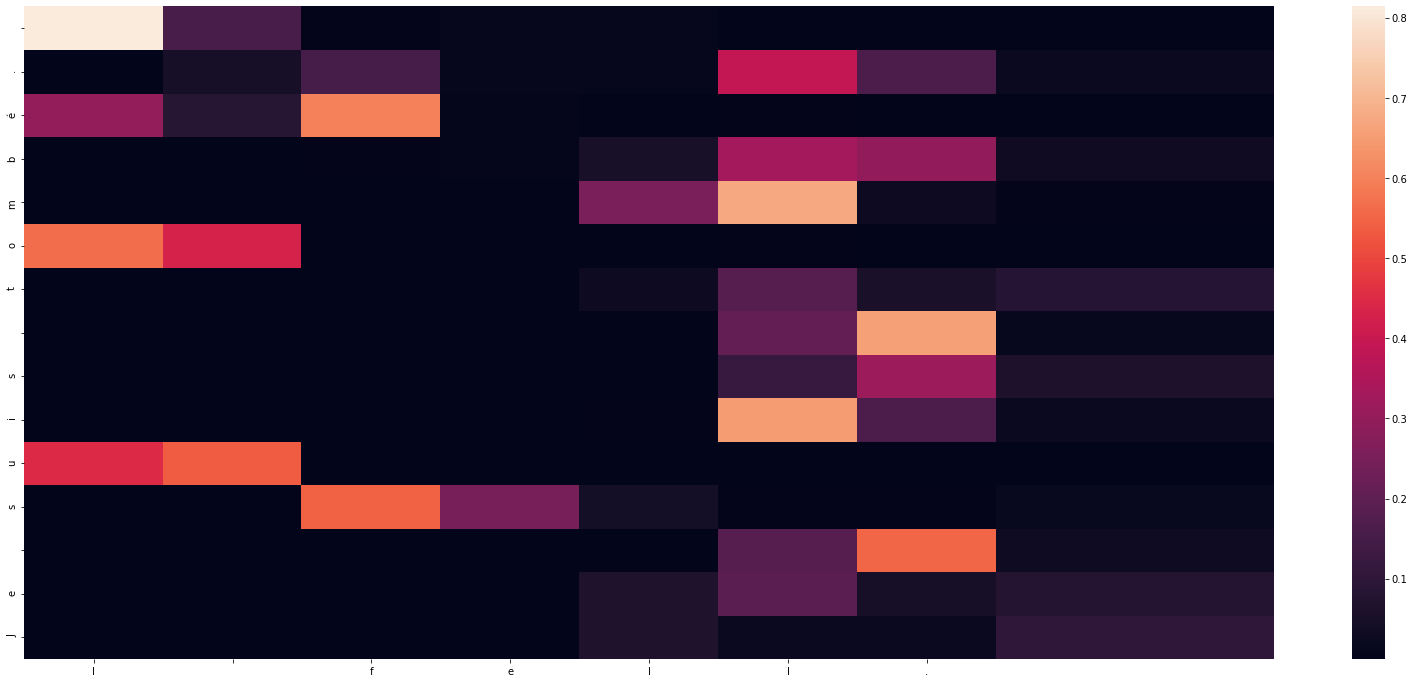

Decoded sentence: Je suis tombé.

-
Input sentence: I know.
GT sentence: 	Je sais.



<Figure size 432x288 with 0 Axes>

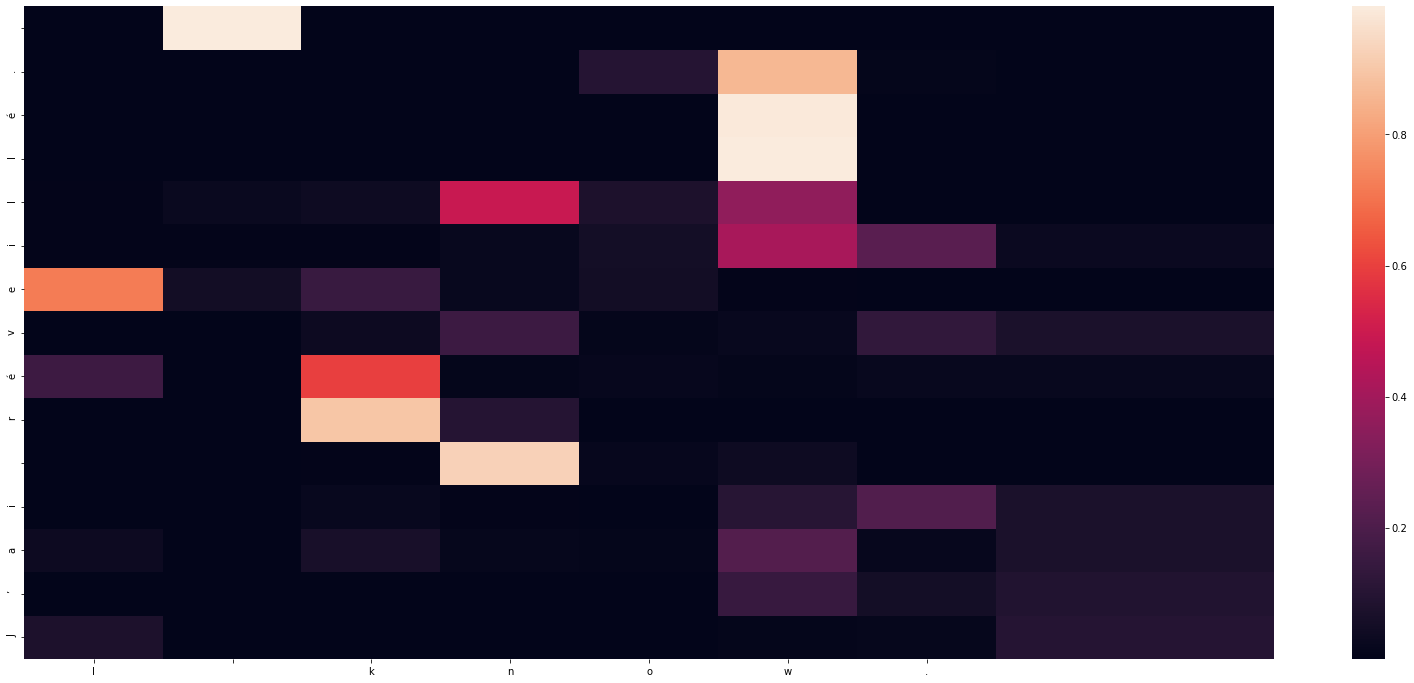

Decoded sentence: J’ai réveillé.

-
Input sentence: I left.
GT sentence: 	Je suis parti.



<Figure size 432x288 with 0 Axes>

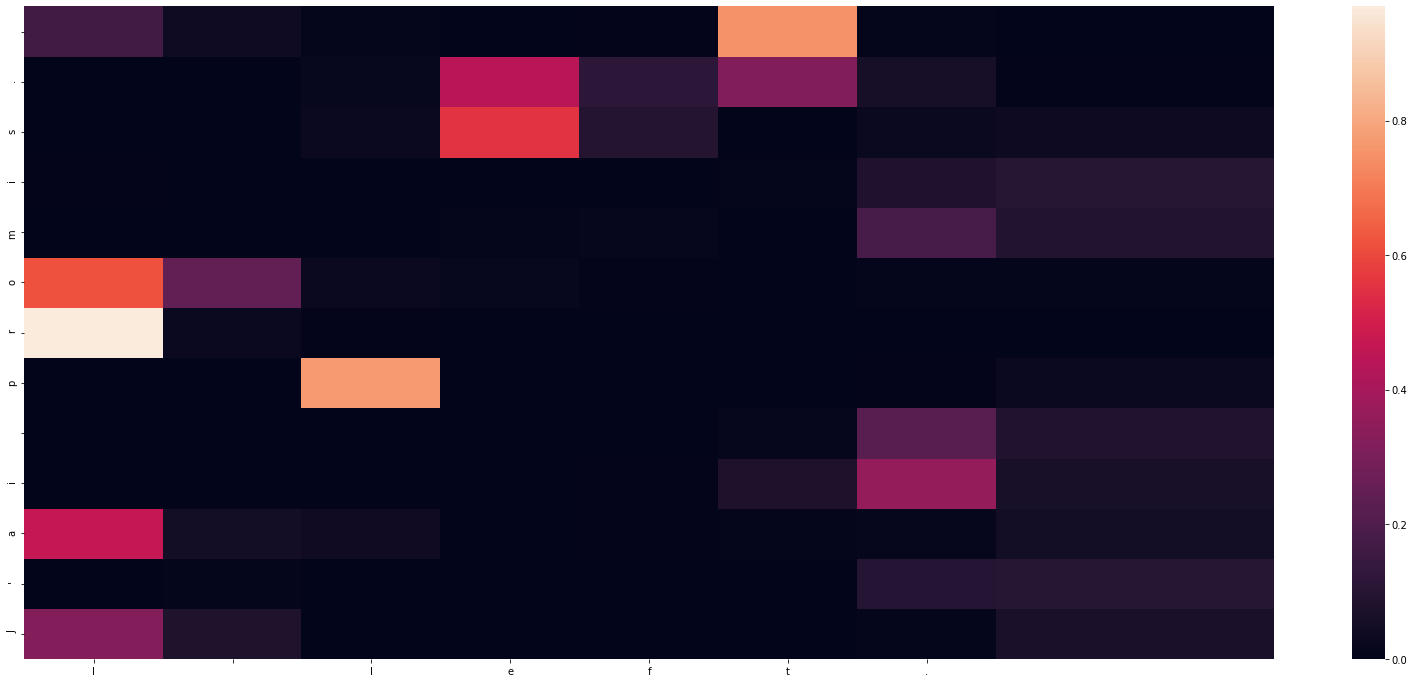

Decoded sentence: J'ai promis.

-
Input sentence: I left.
GT sentence: 	Je suis partie.



<Figure size 432x288 with 0 Axes>

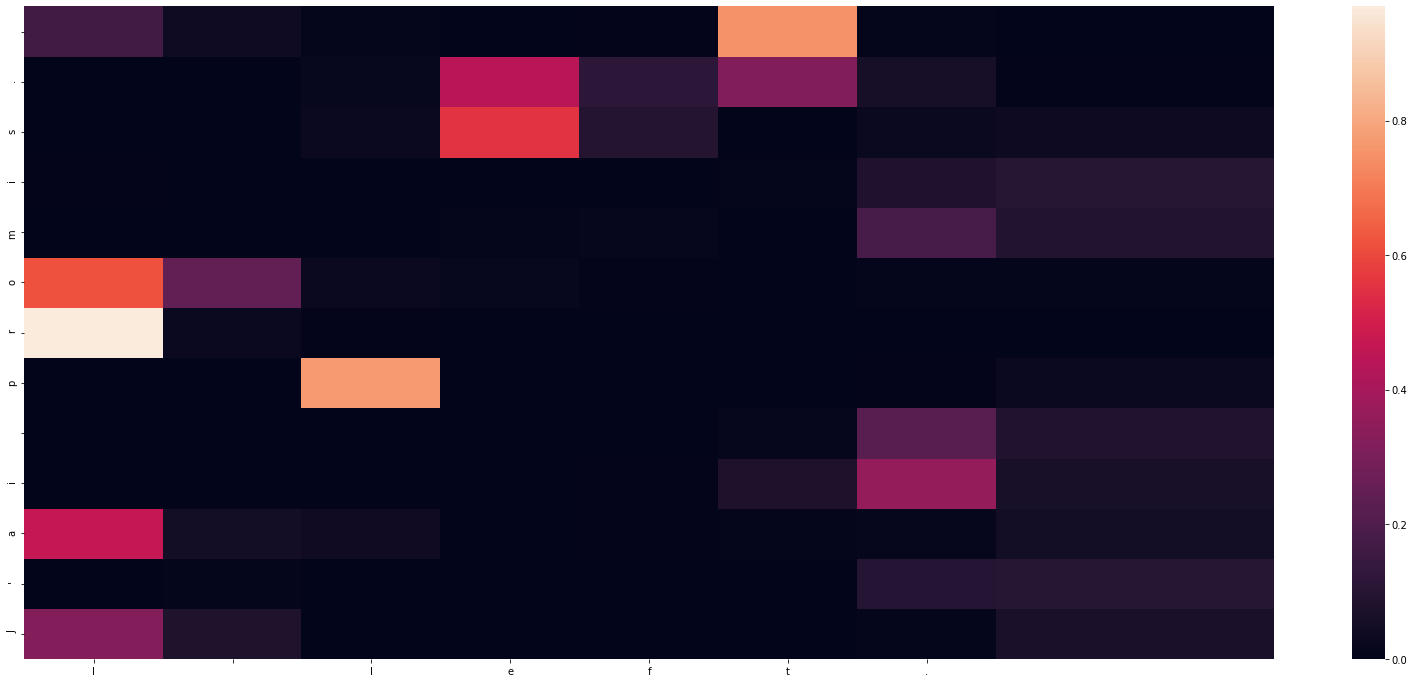

Decoded sentence: J'ai promis.

-
Input sentence: I lied.
GT sentence: 	J'ai menti.



<Figure size 432x288 with 0 Axes>

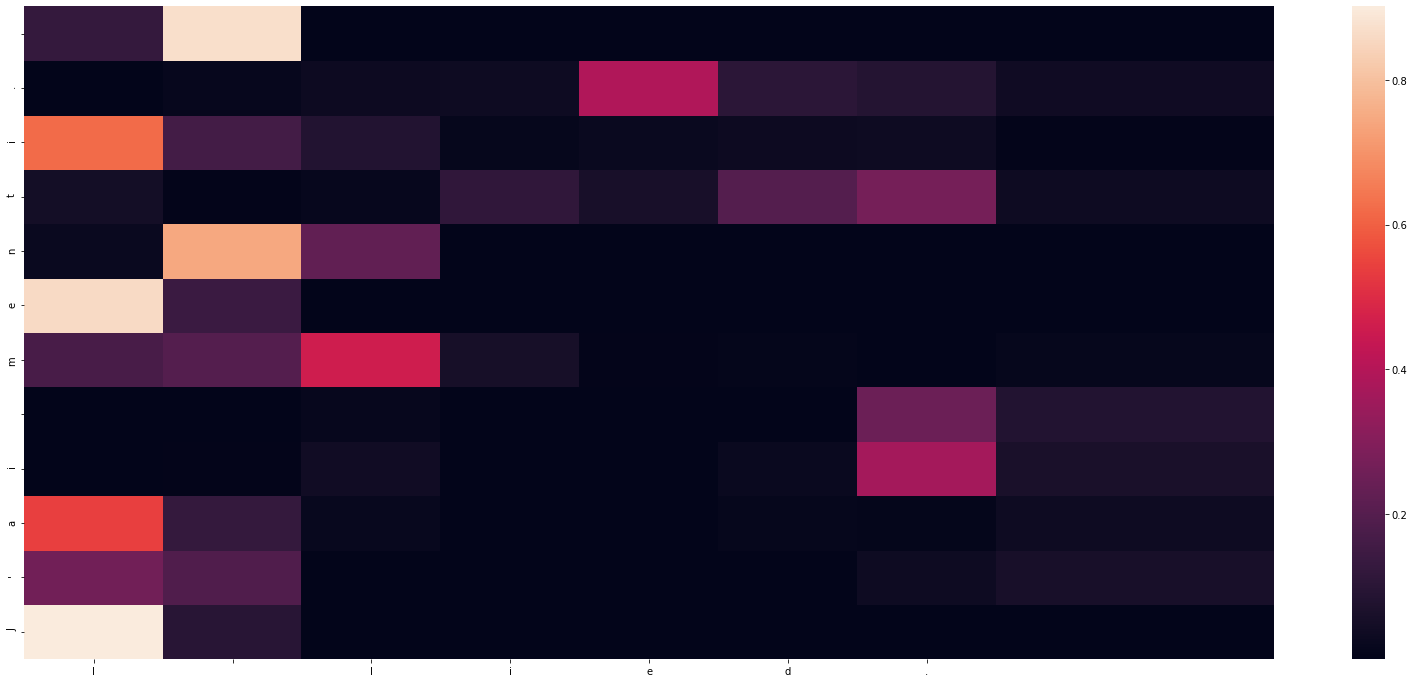

Decoded sentence: J'ai menti.

-
Input sentence: I lost.
GT sentence: 	J'ai perdu.



<Figure size 432x288 with 0 Axes>

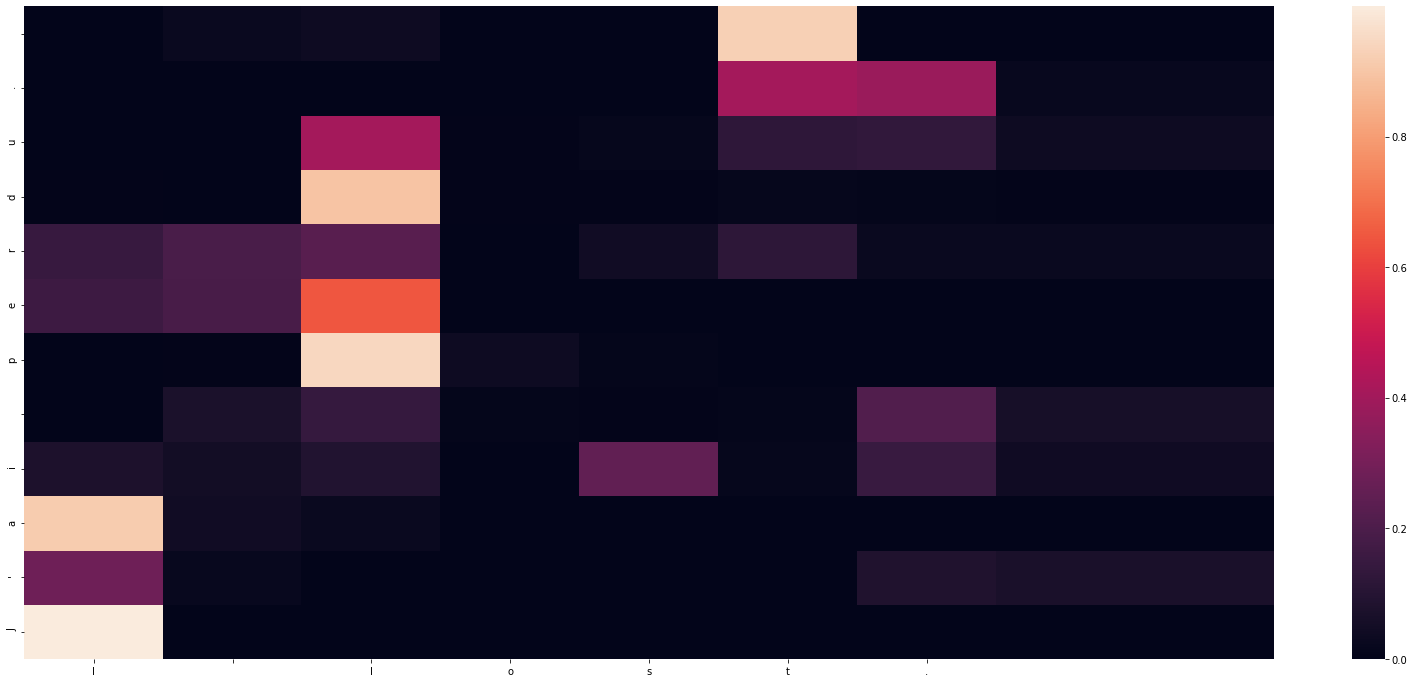

Decoded sentence: J'ai perdu.

-
Input sentence: I paid.
GT sentence: 	J’ai payé.



<Figure size 432x288 with 0 Axes>

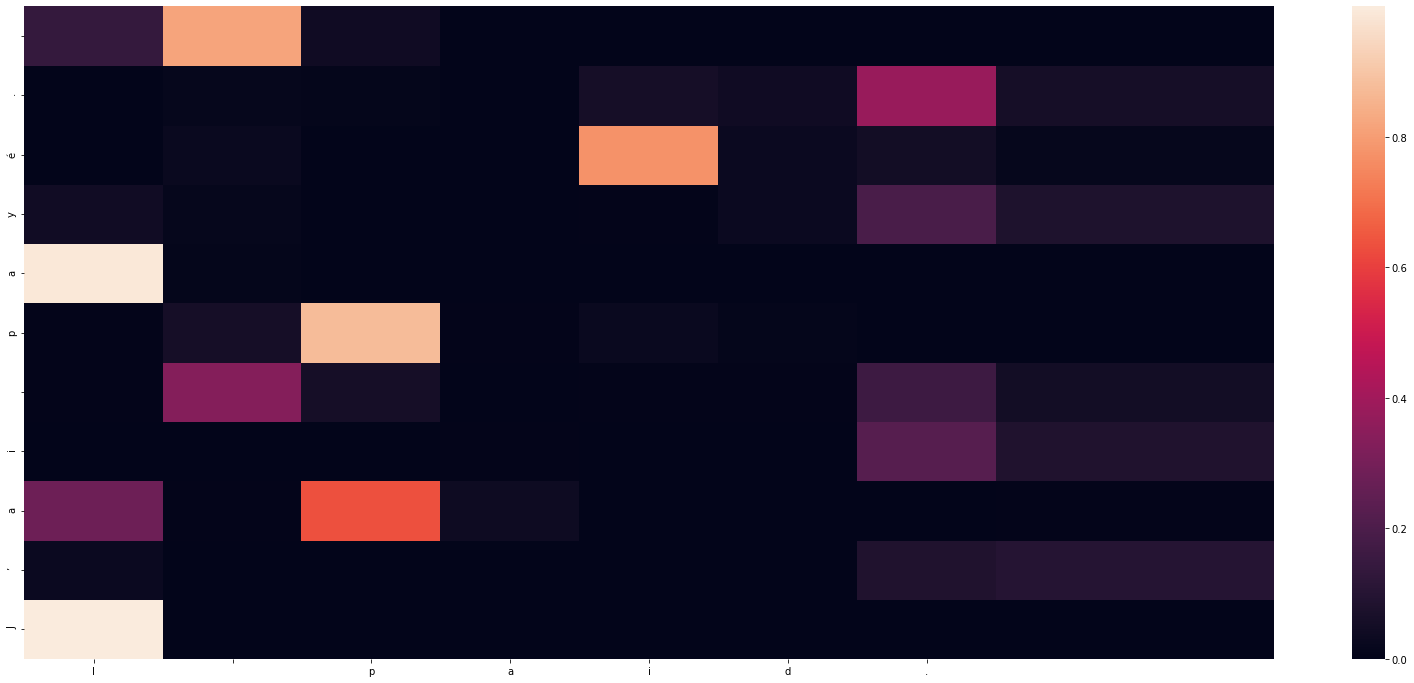

Decoded sentence: J’ai payé.

-
Input sentence: I'm 19.
GT sentence: 	J'ai 19 ans.



<Figure size 432x288 with 0 Axes>

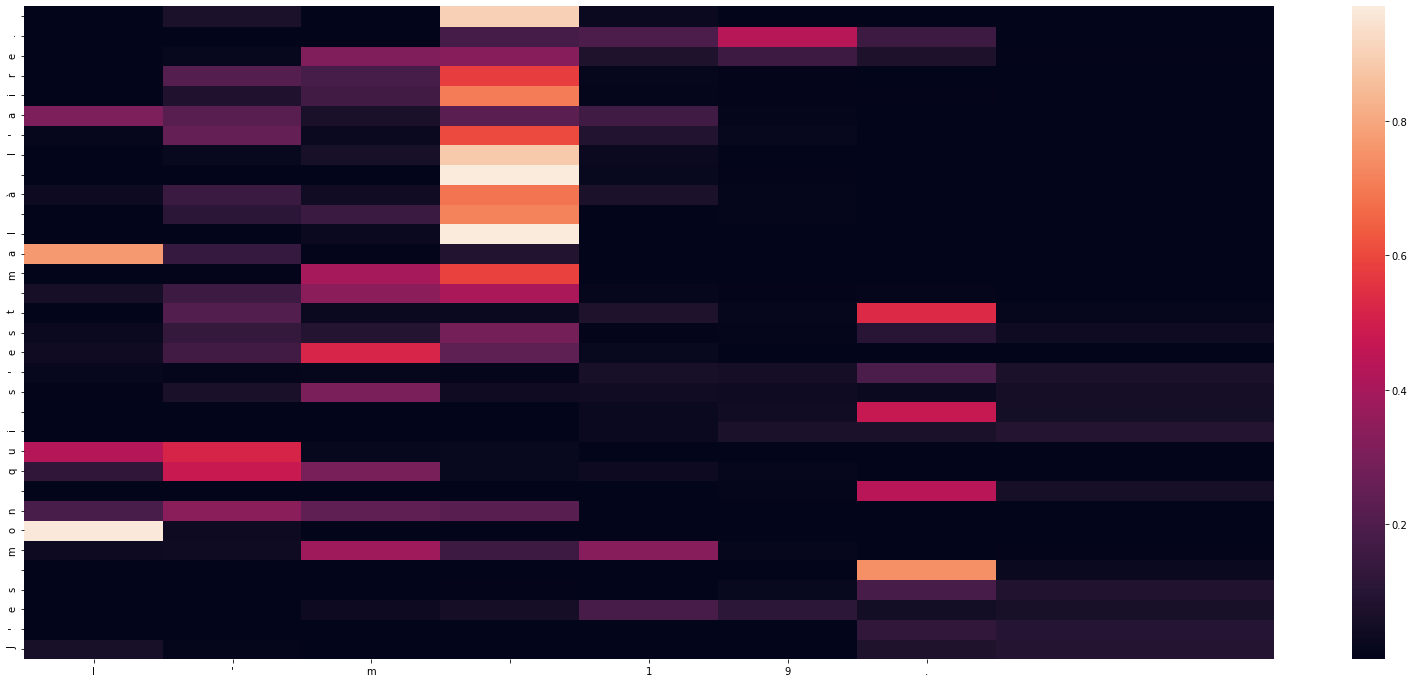

Decoded sentence: J'es mon qui s'est mal à l'aire.

-
Input sentence: I'm OK.
GT sentence: 	Je vais bien.



<Figure size 432x288 with 0 Axes>

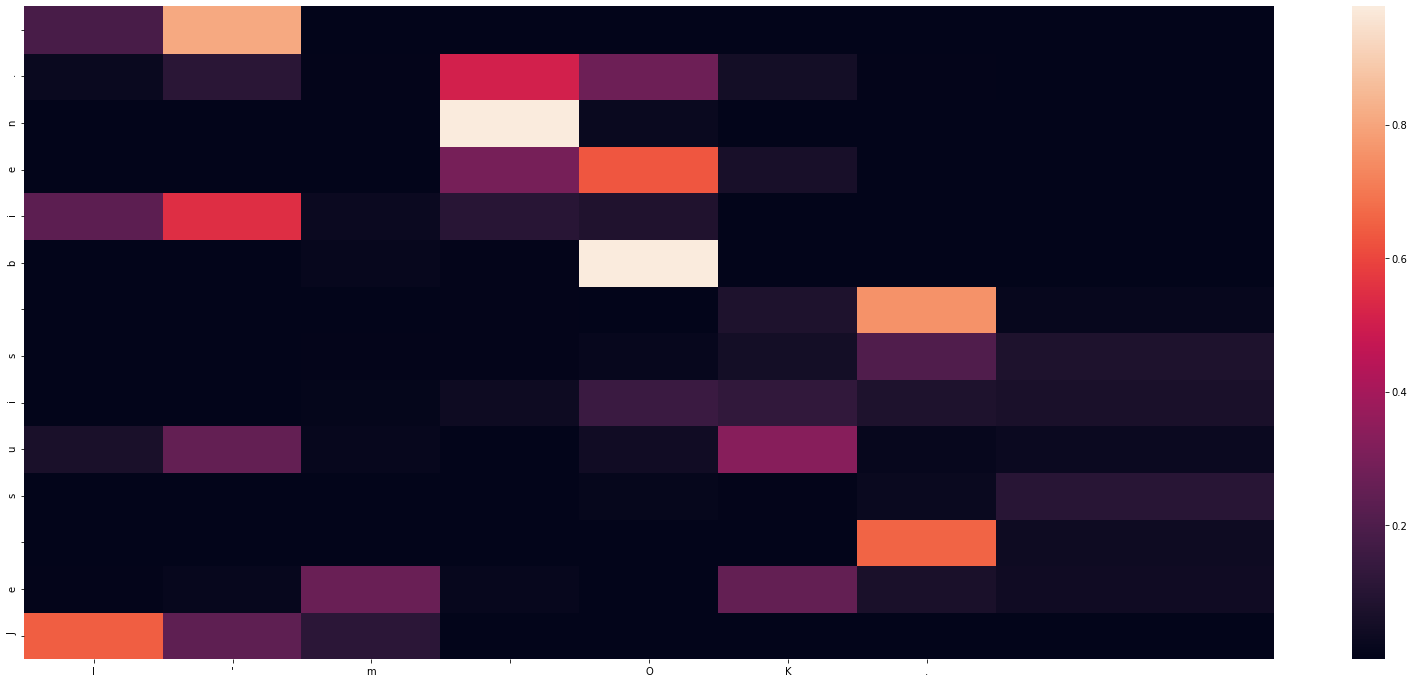

Decoded sentence: Je suis bien.

-
Input sentence: I'm OK.
GT sentence: 	Ça va.



<Figure size 432x288 with 0 Axes>

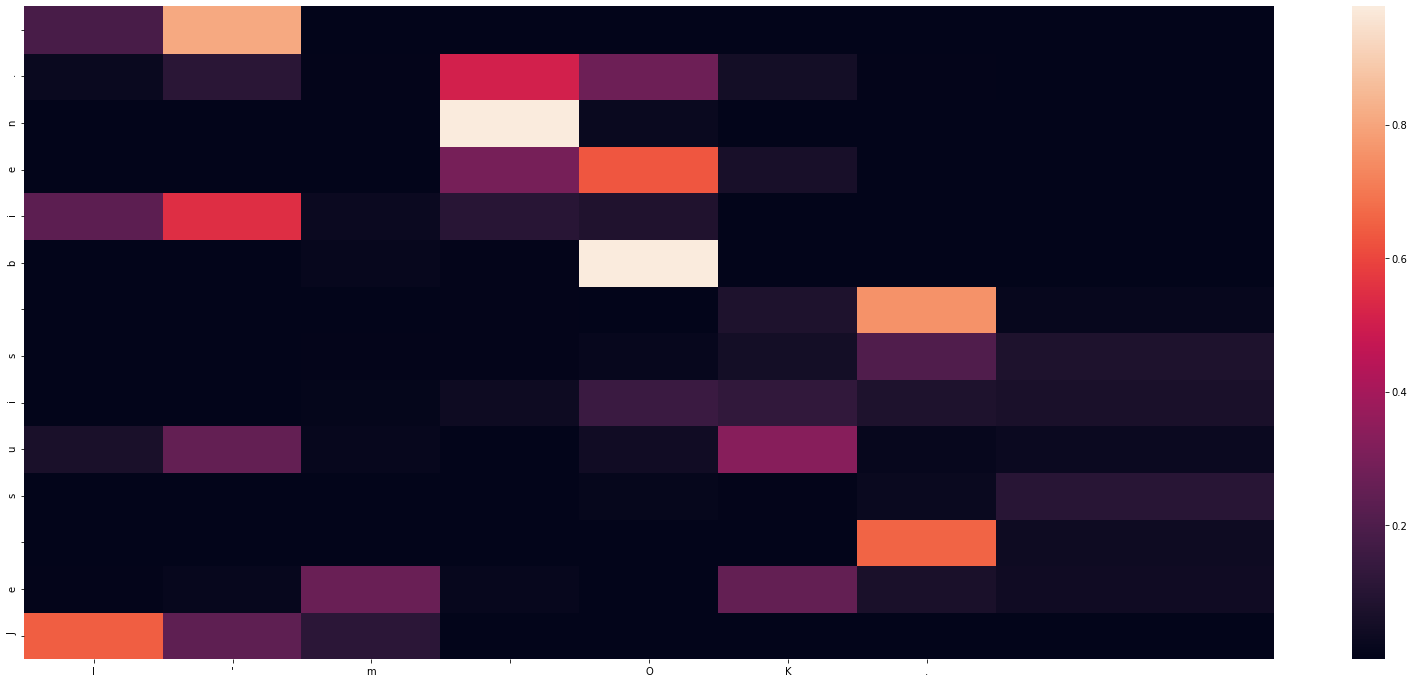

Decoded sentence: Je suis bien.

-
Input sentence: Listen.
GT sentence: 	Écoutez !



<Figure size 432x288 with 0 Axes>

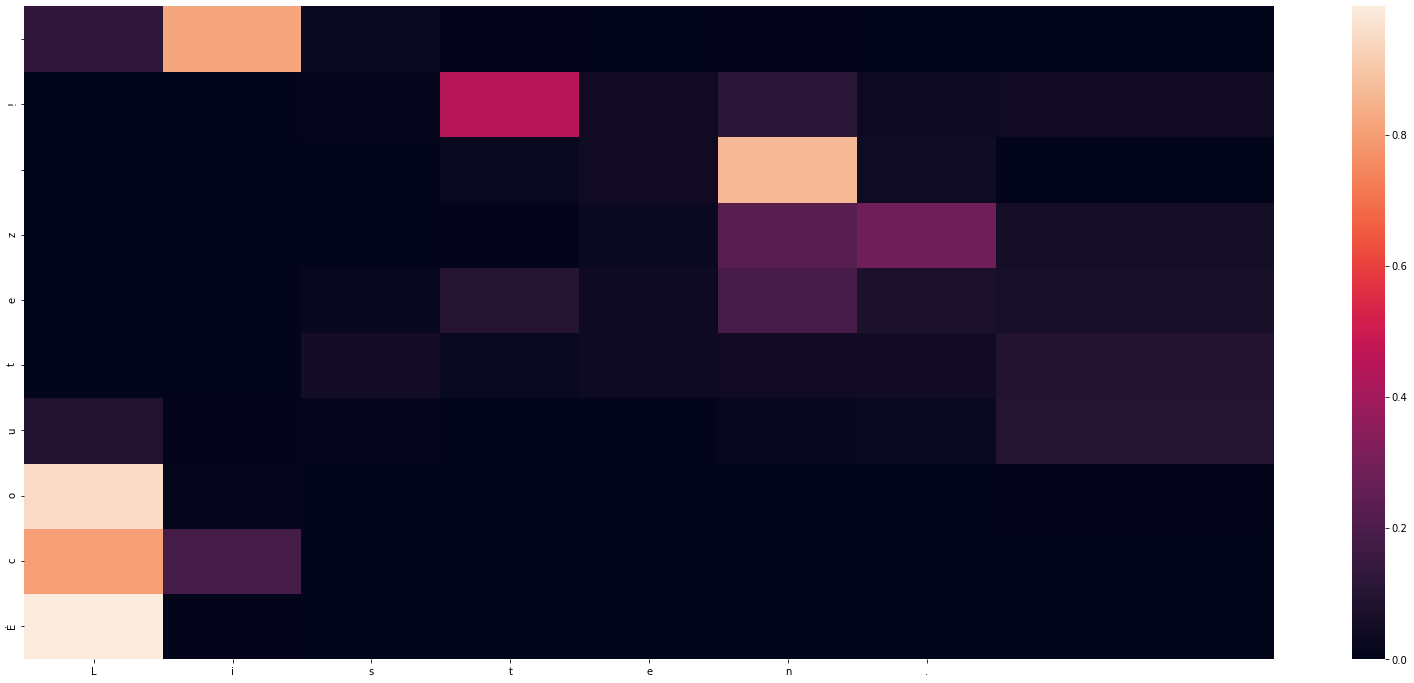

Decoded sentence: Écoutez !

-
Input sentence: No way!
GT sentence: 	C'est pas possible !



<Figure size 432x288 with 0 Axes>

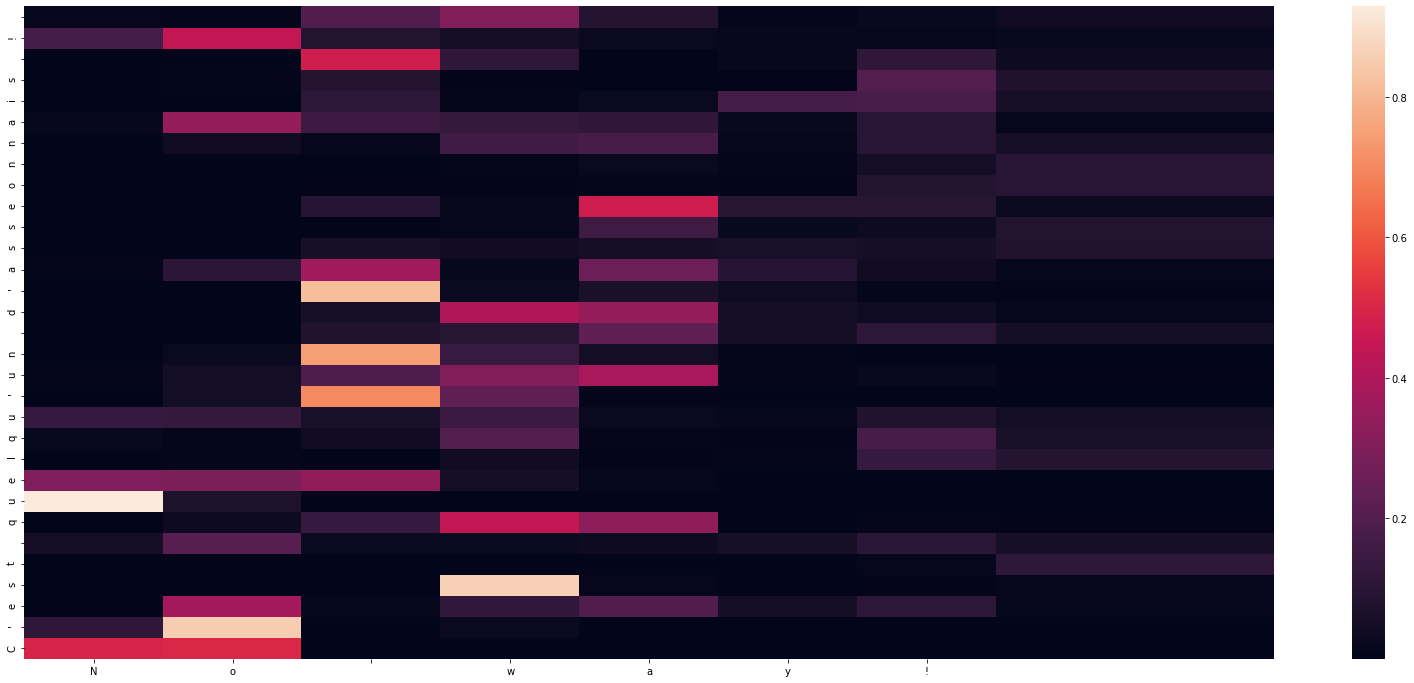

Decoded sentence: C'est quelqu'un d'asseonnais !

-
Input sentence: No way!
GT sentence: 	Impossible !



<Figure size 432x288 with 0 Axes>

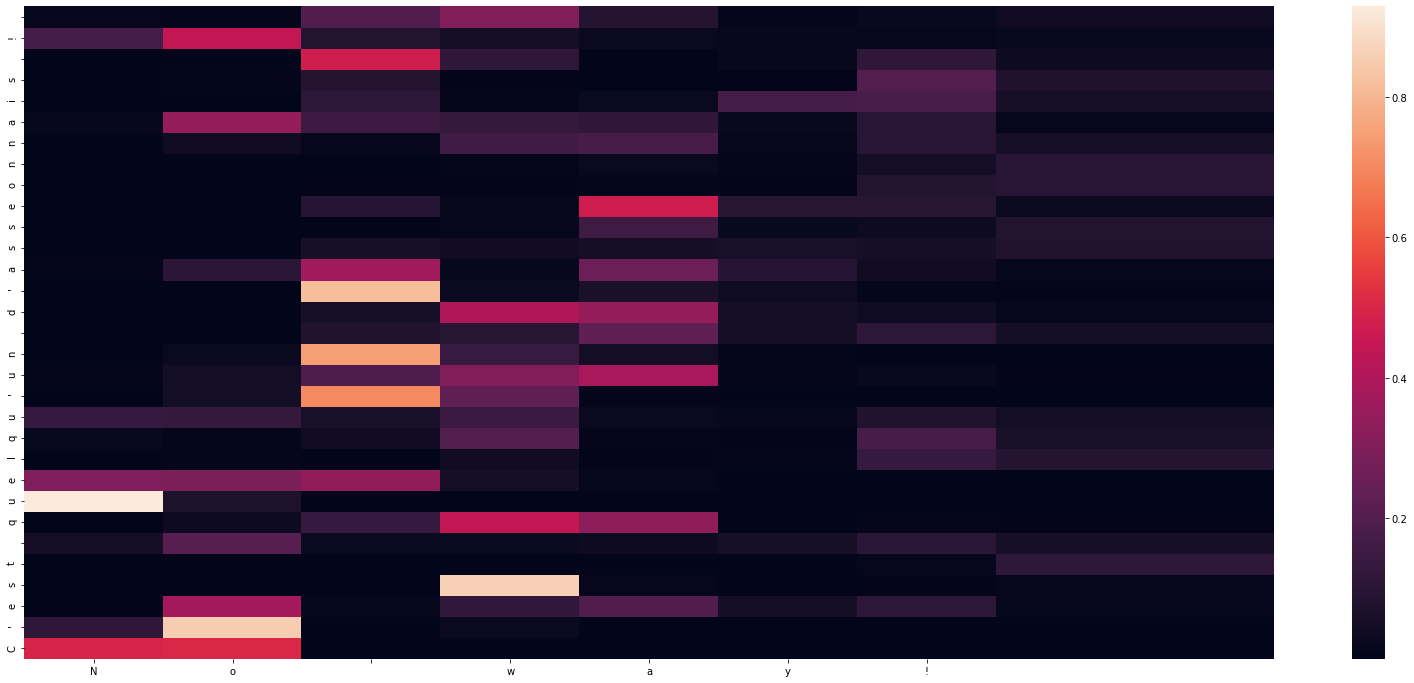

Decoded sentence: C'est quelqu'un d'asseonnais !

-
Input sentence: No way!
GT sentence: 	En aucun cas.



<Figure size 432x288 with 0 Axes>

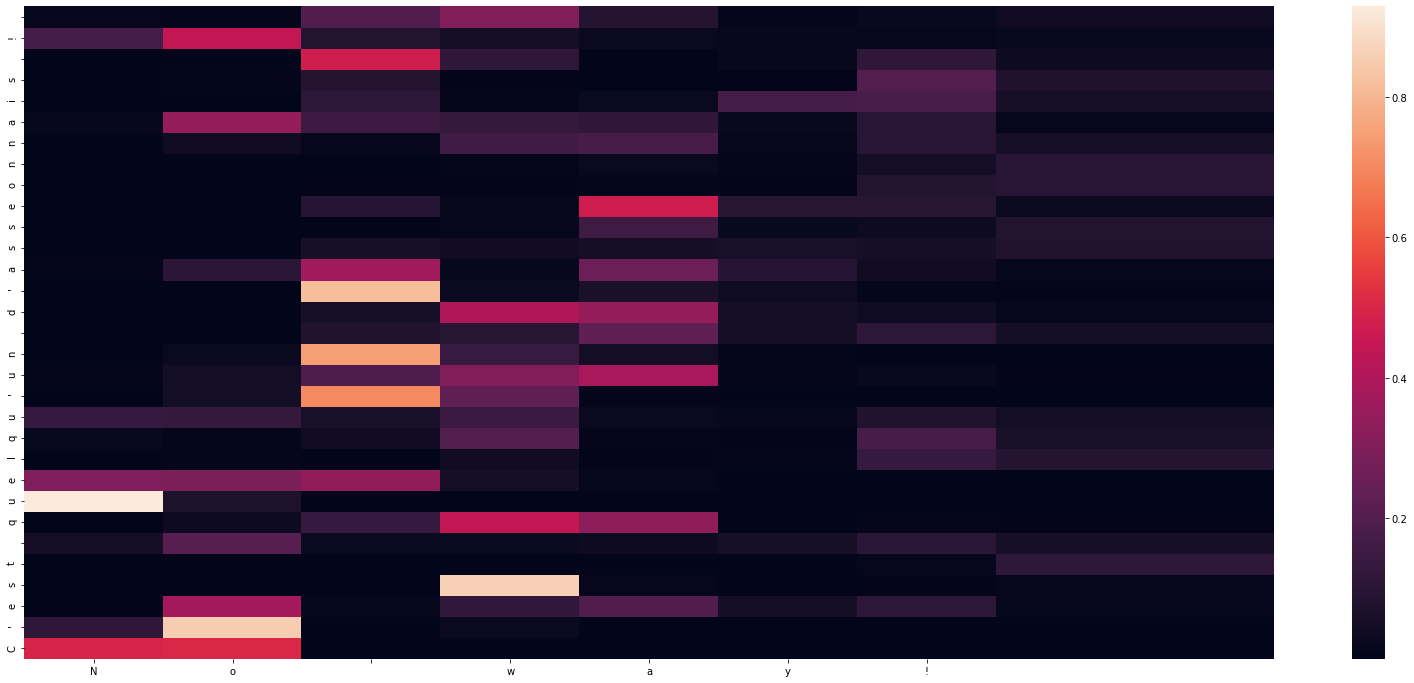

Decoded sentence: C'est quelqu'un d'asseonnais !

-
Input sentence: No way!
GT sentence: 	Sans façons !



<Figure size 432x288 with 0 Axes>

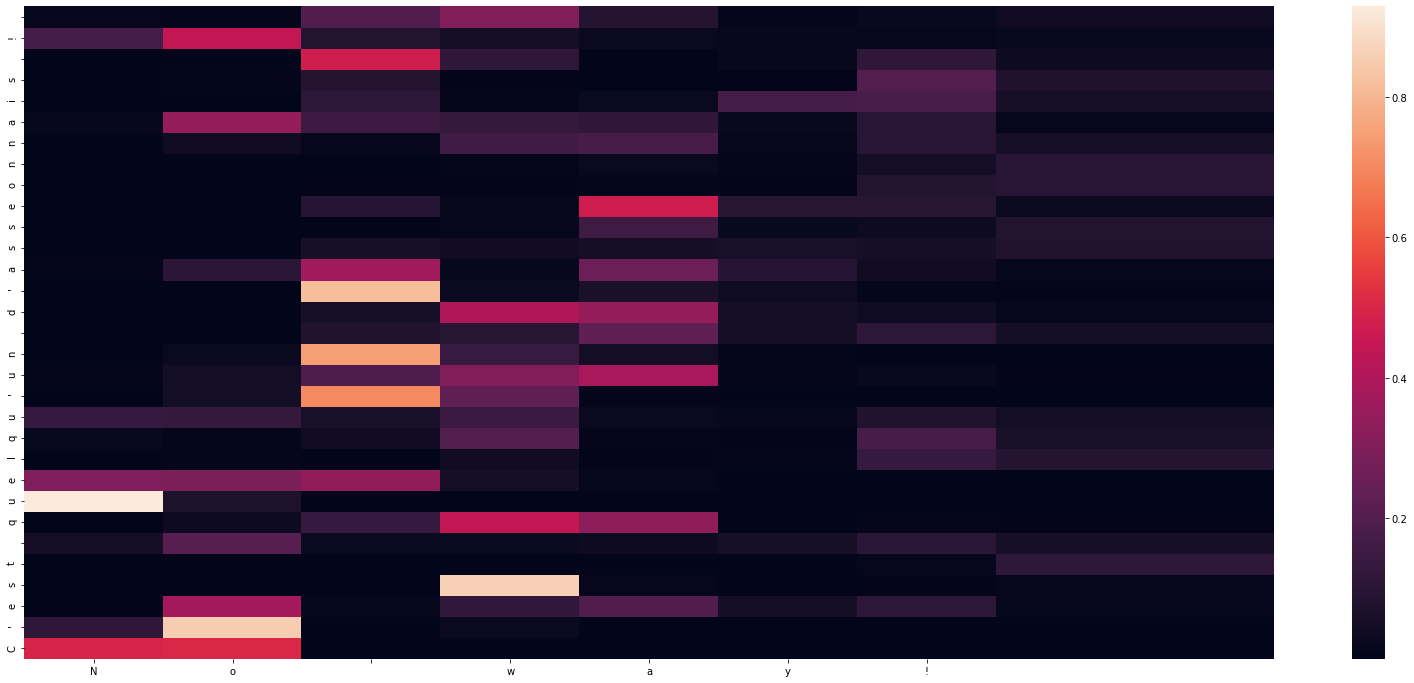

Decoded sentence: C'est quelqu'un d'asseonnais !

-
Input sentence: No way!
GT sentence: 	C'est hors de question !



<Figure size 432x288 with 0 Axes>

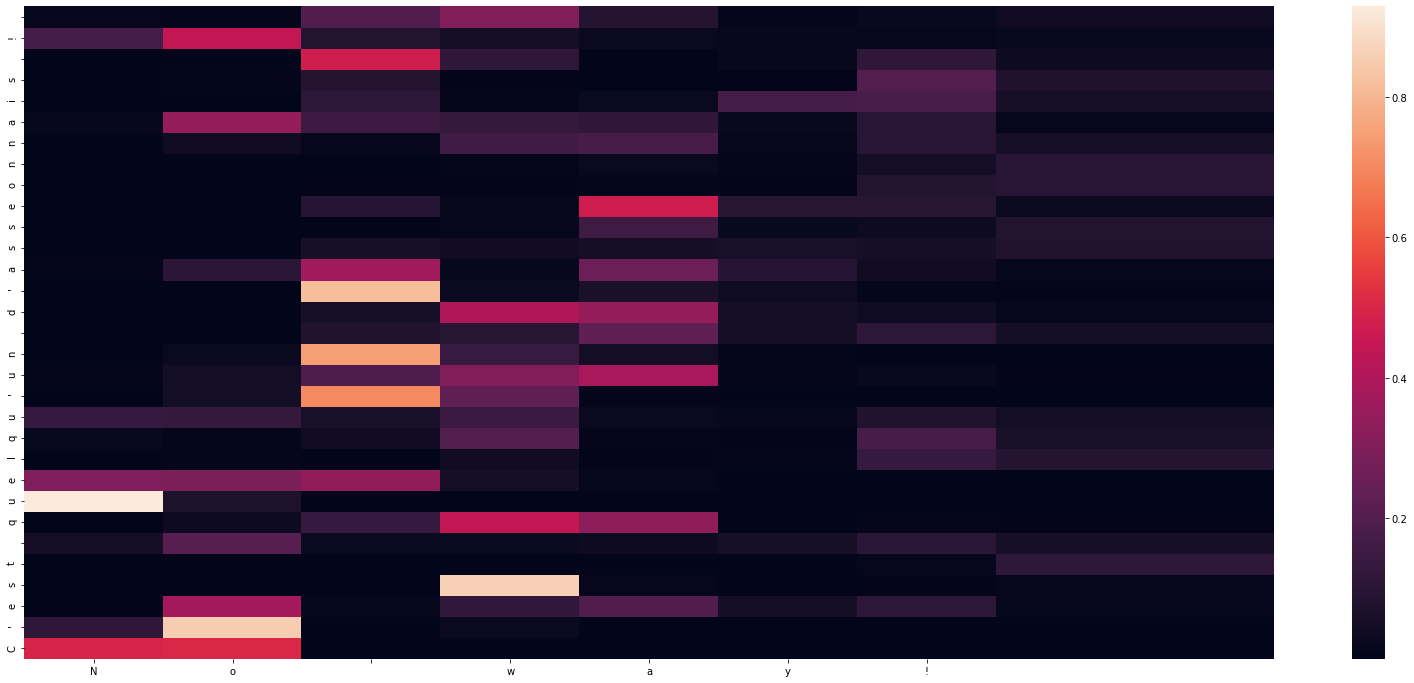

Decoded sentence: C'est quelqu'un d'asseonnais !

-
Input sentence: No way!
GT sentence: 	Il n'en est pas question !



<Figure size 432x288 with 0 Axes>

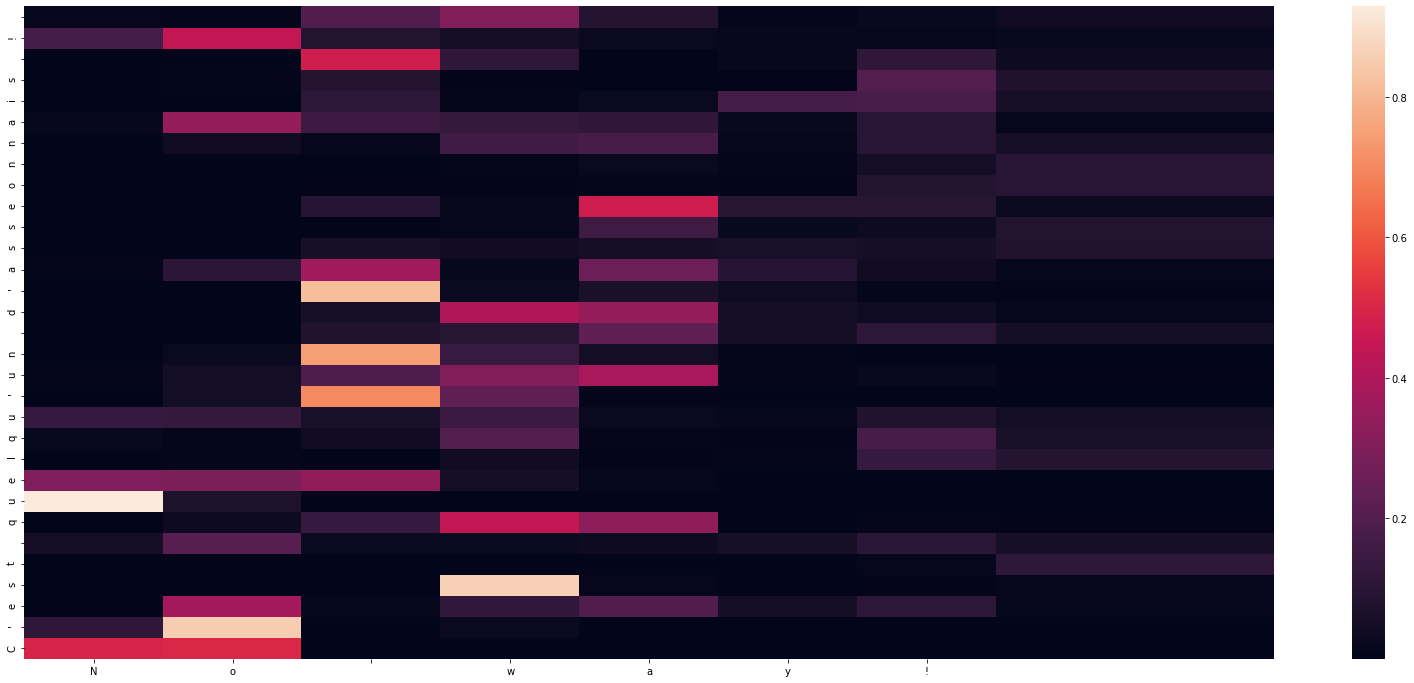

Decoded sentence: C'est quelqu'un d'asseonnais !

-
Input sentence: No way!
GT sentence: 	C'est exclu !



<Figure size 432x288 with 0 Axes>

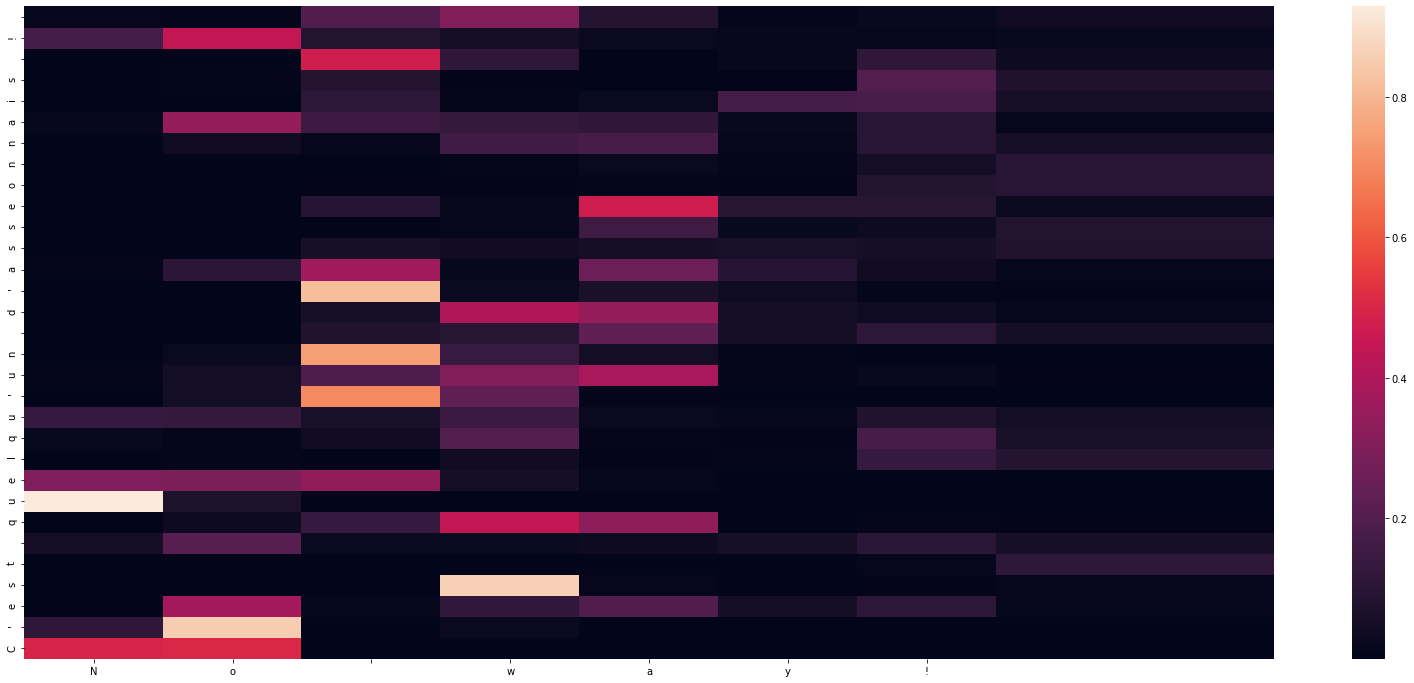

Decoded sentence: C'est quelqu'un d'asseonnais !

-
Input sentence: No way!
GT sentence: 	En aucune manière !



<Figure size 432x288 with 0 Axes>

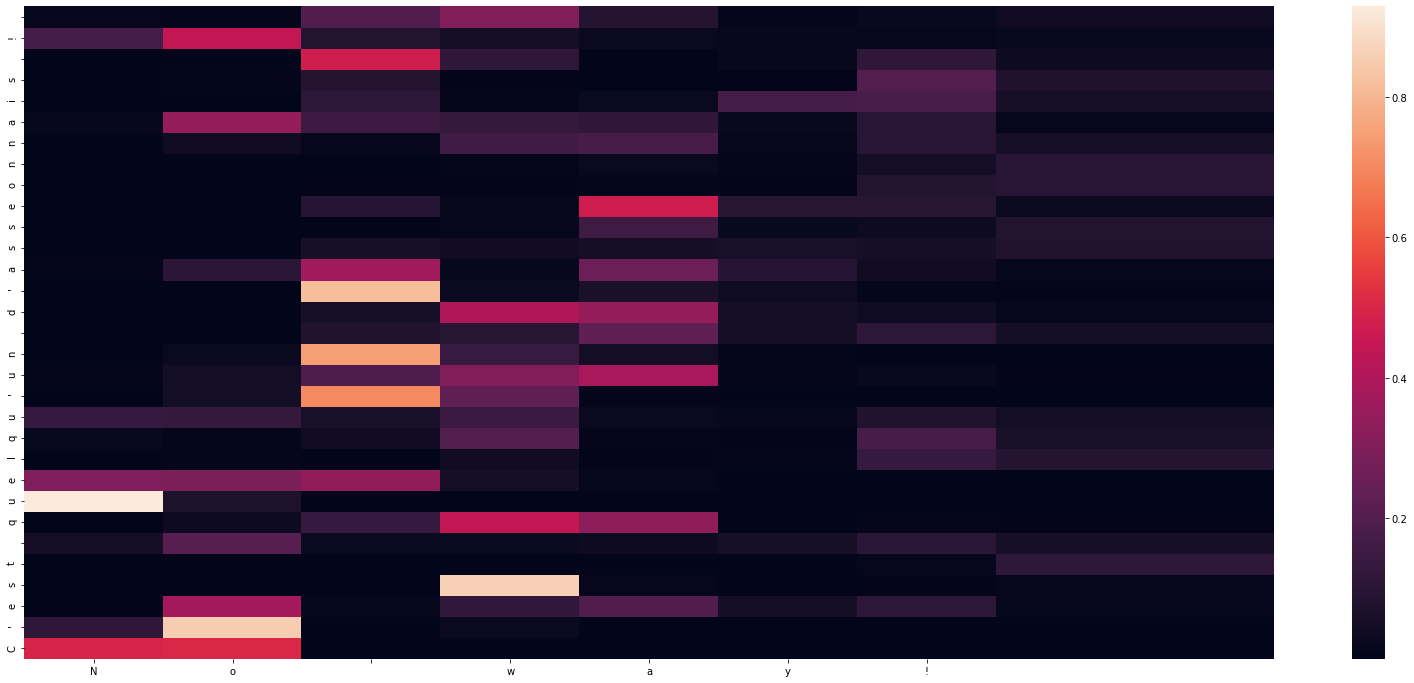

Decoded sentence: C'est quelqu'un d'asseonnais !

-
Input sentence: No way!
GT sentence: 	Hors de question !



<Figure size 432x288 with 0 Axes>

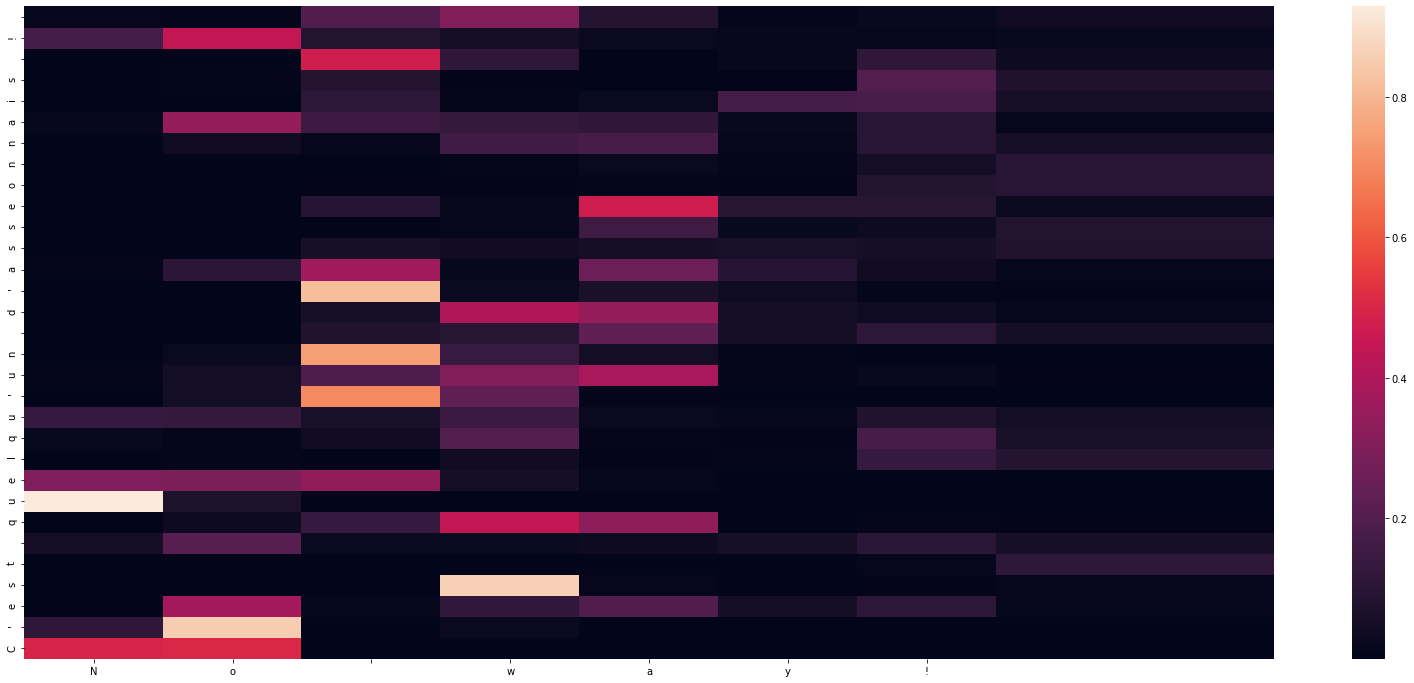

Decoded sentence: C'est quelqu'un d'asseonnais !

-
Input sentence: Really?
GT sentence: 	Vraiment ?



<Figure size 432x288 with 0 Axes>

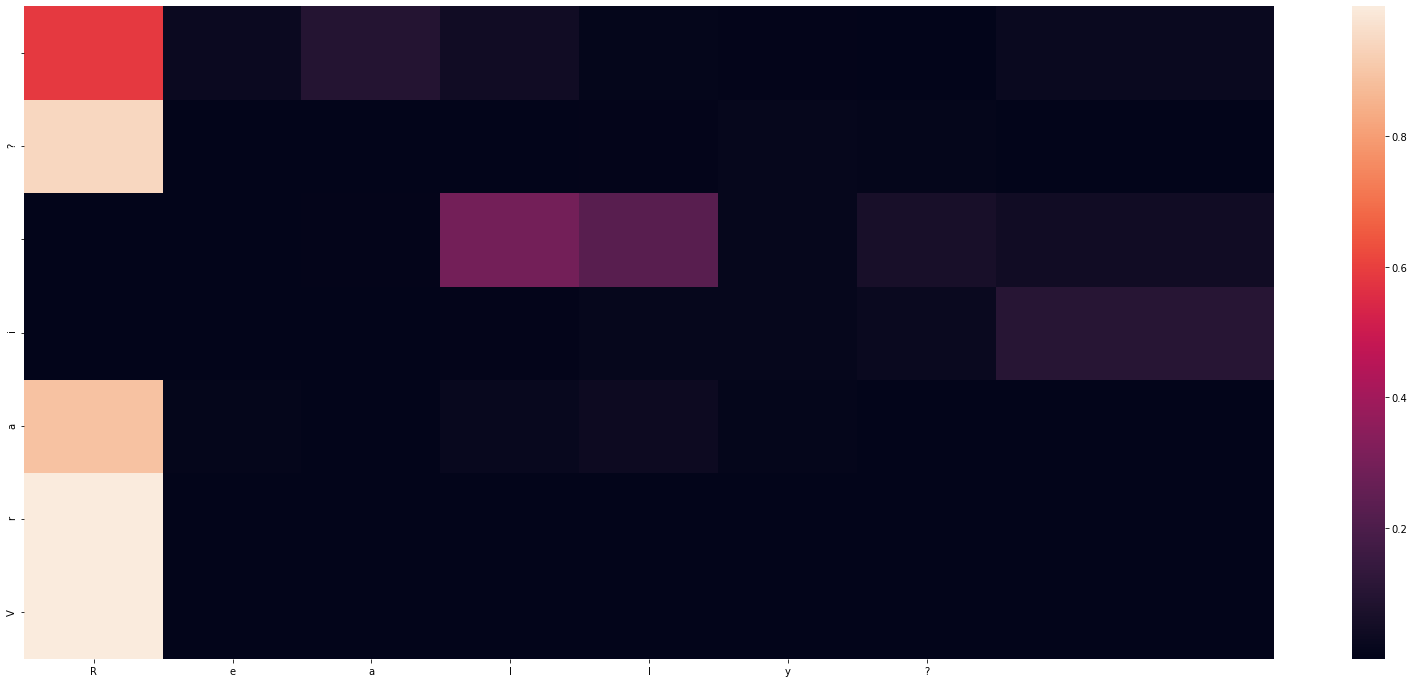

Decoded sentence: Vrai ?

-
Input sentence: Really?
GT sentence: 	Vrai ?



<Figure size 432x288 with 0 Axes>

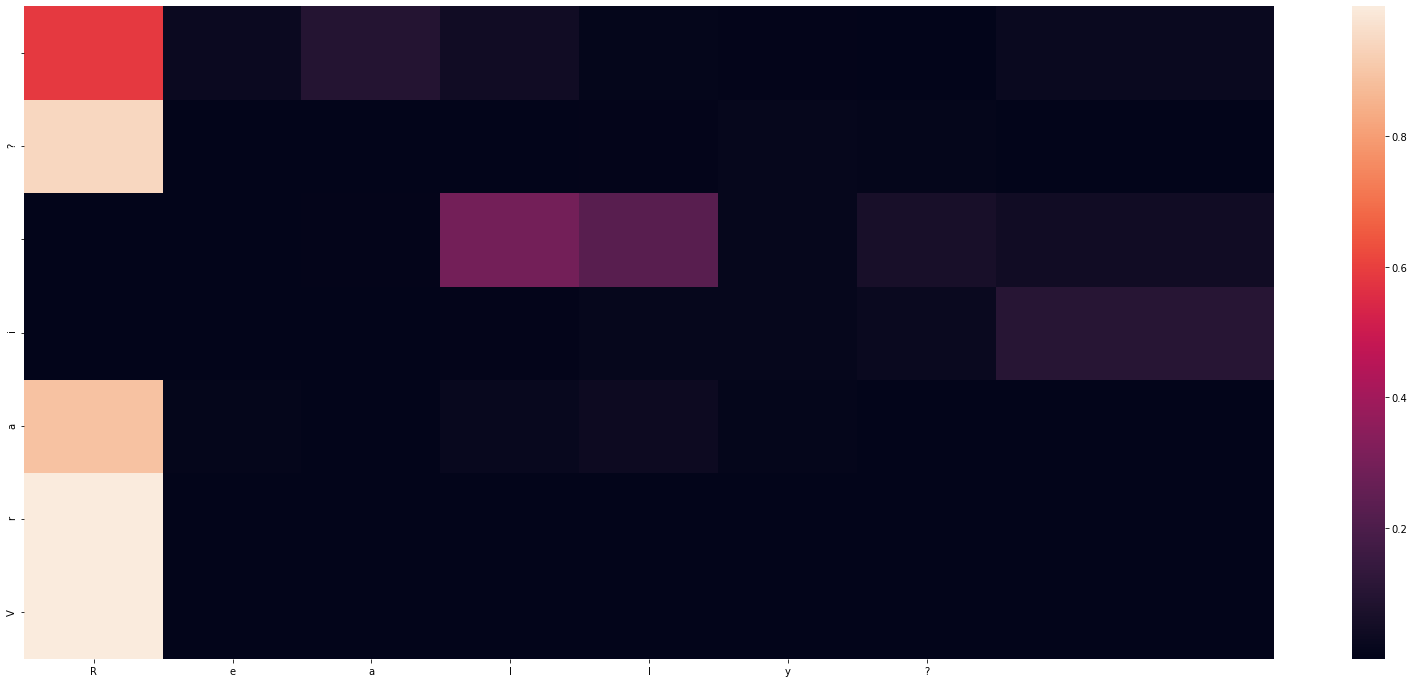

Decoded sentence: Vrai ?

-
Input sentence: Really?
GT sentence: 	Ah bon ?



<Figure size 432x288 with 0 Axes>

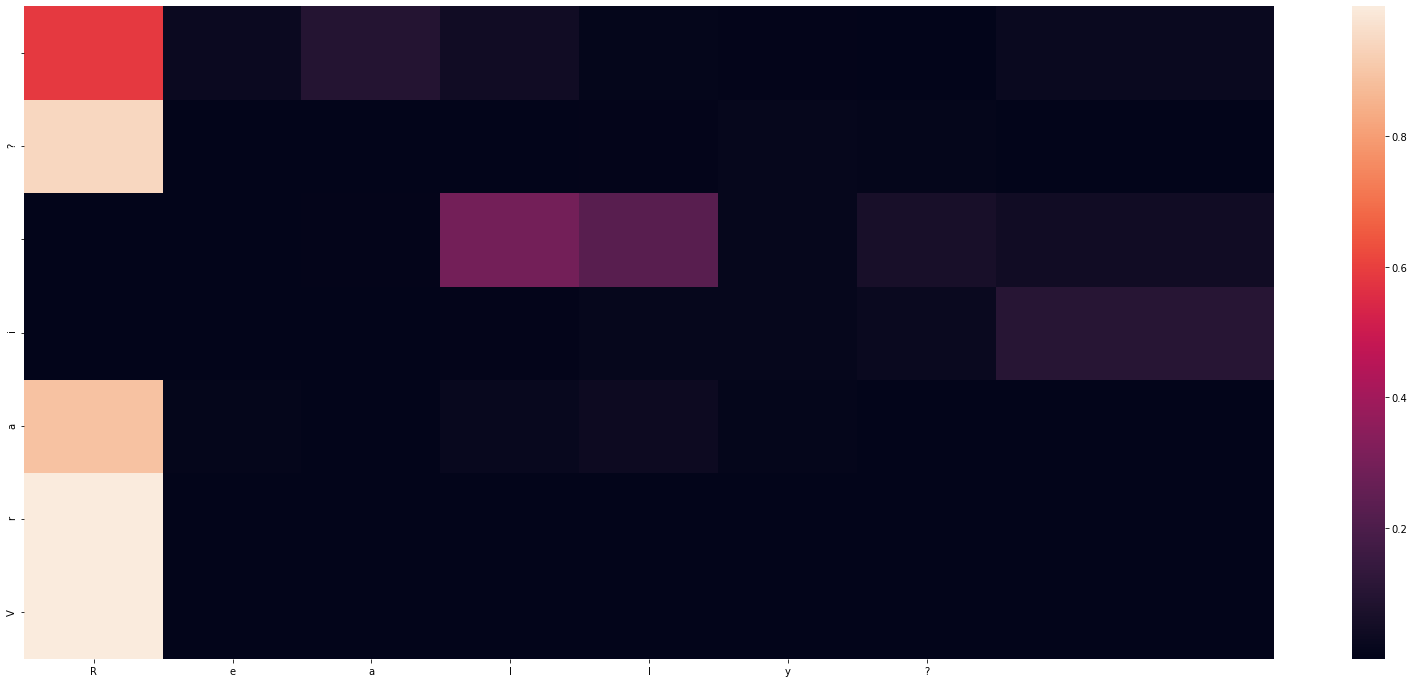

Decoded sentence: Vrai ?

-
Input sentence: Thanks.
GT sentence: 	Merci !



<Figure size 432x288 with 0 Axes>

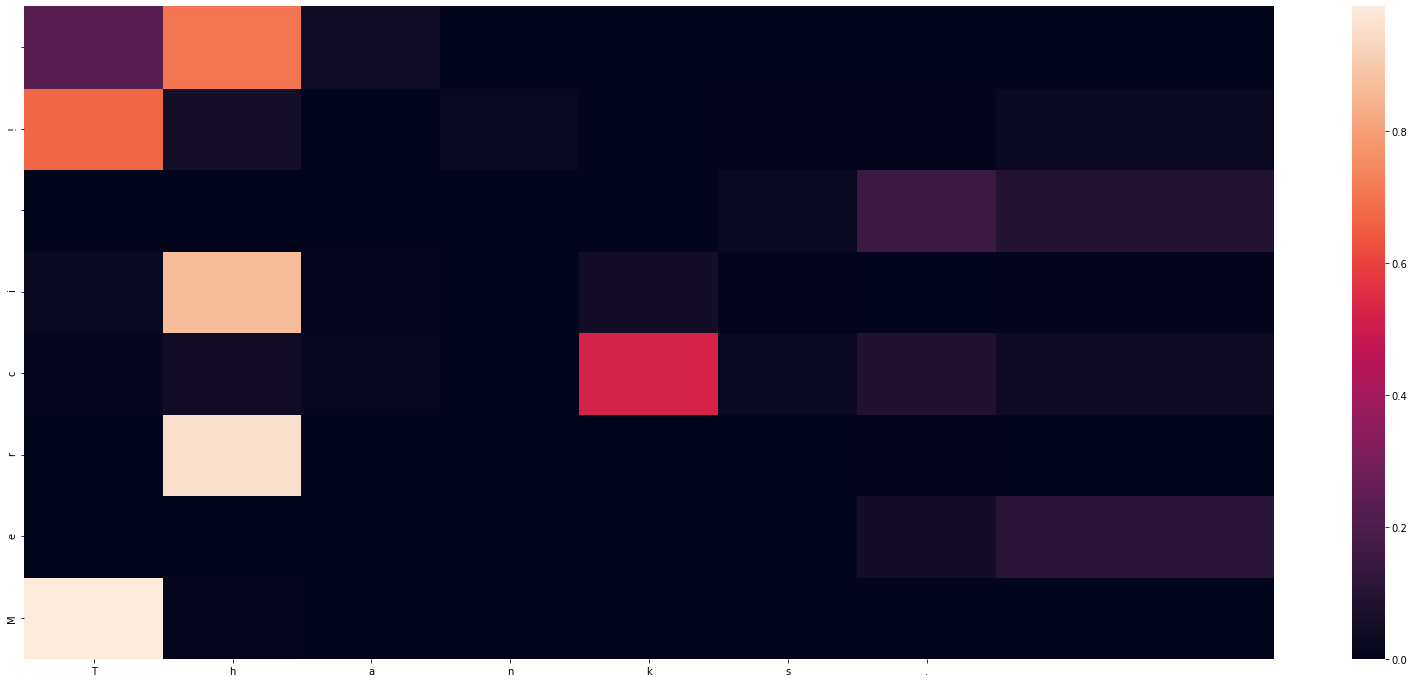

Decoded sentence: Merci !

-
Input sentence: We try.
GT sentence: 	On essaye.



<Figure size 432x288 with 0 Axes>

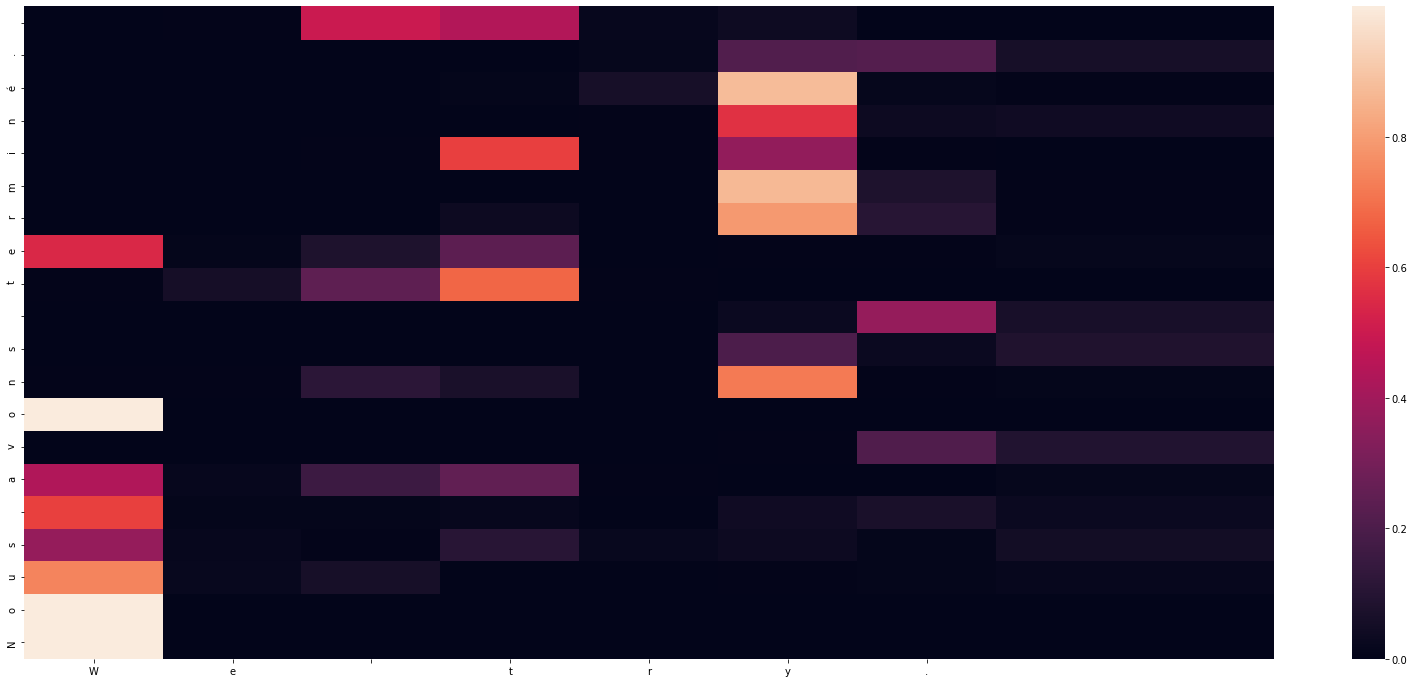

Decoded sentence: Nous avons terminé.

-
Input sentence: We won.
GT sentence: 	Nous avons gagné.



<Figure size 432x288 with 0 Axes>

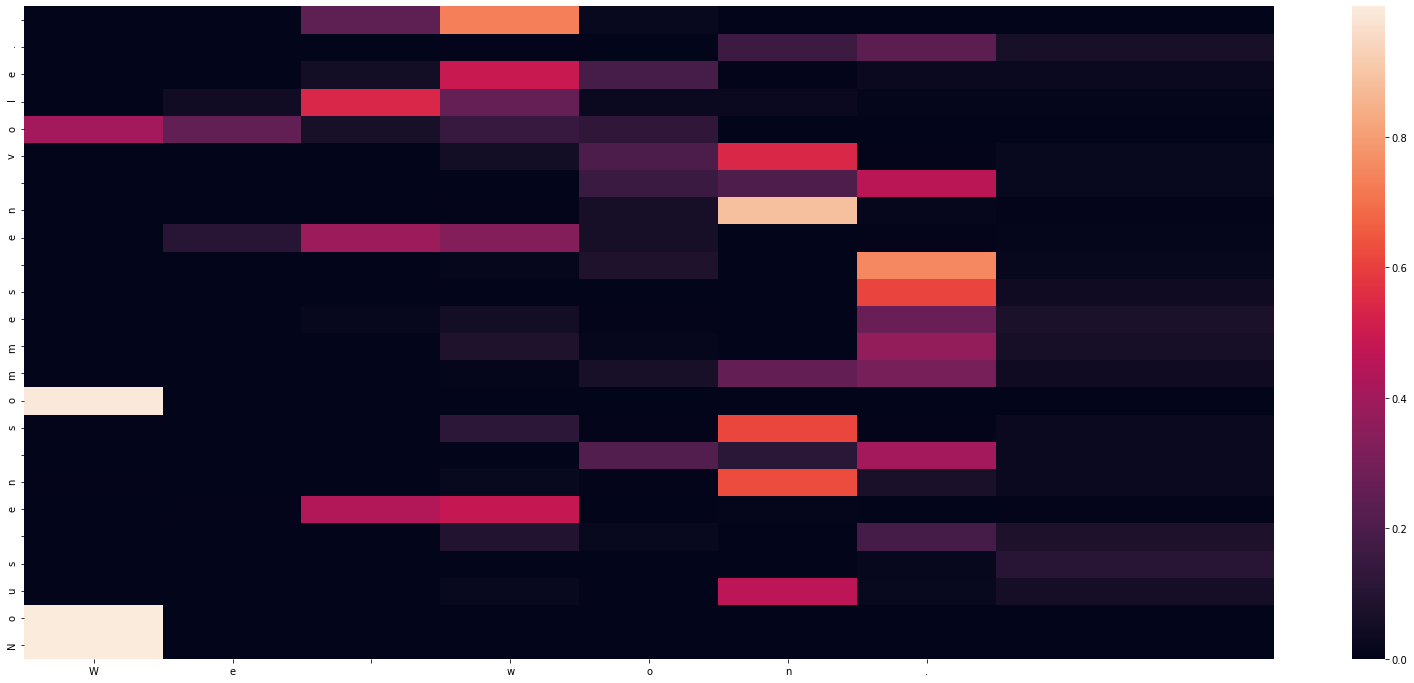

Decoded sentence: Nous en sommes en vole.

-
Input sentence: We won.
GT sentence: 	Nous gagnâmes.



<Figure size 432x288 with 0 Axes>

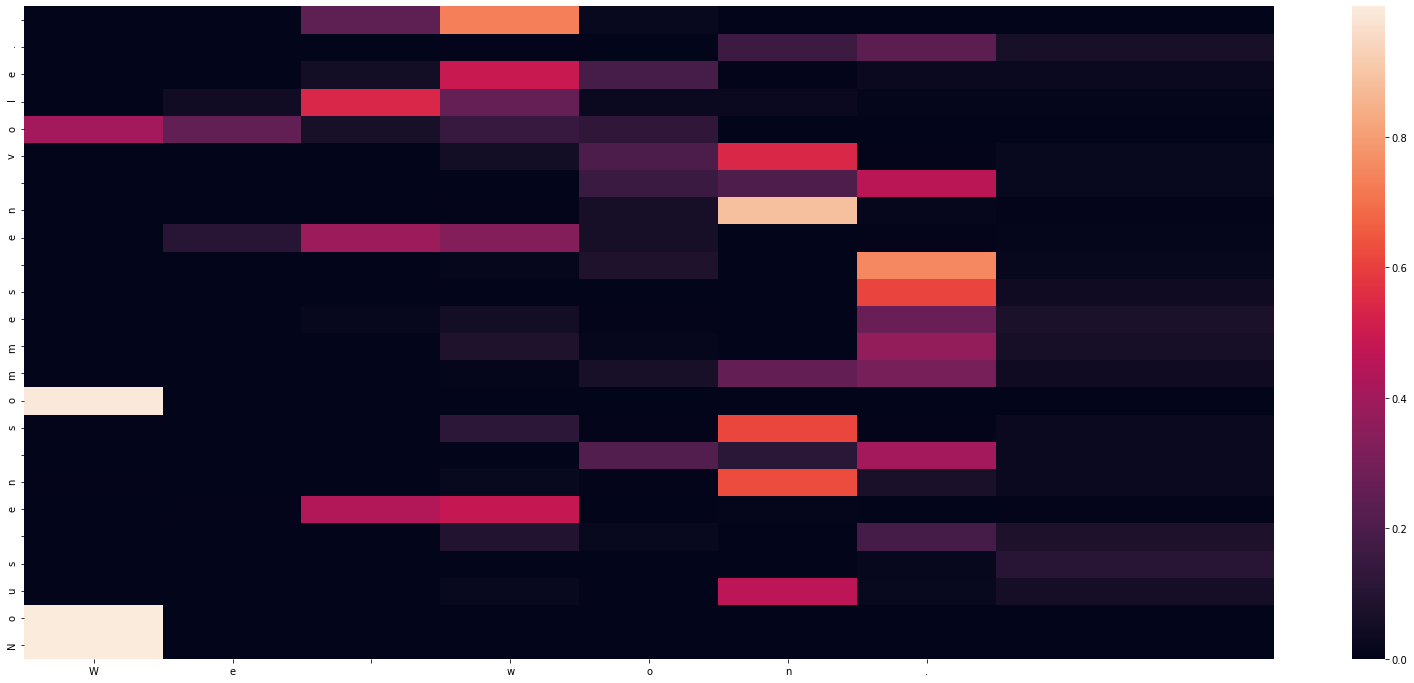

Decoded sentence: Nous en sommes en vole.

-
Input sentence: We won.
GT sentence: 	Nous l'avons emporté.



<Figure size 432x288 with 0 Axes>

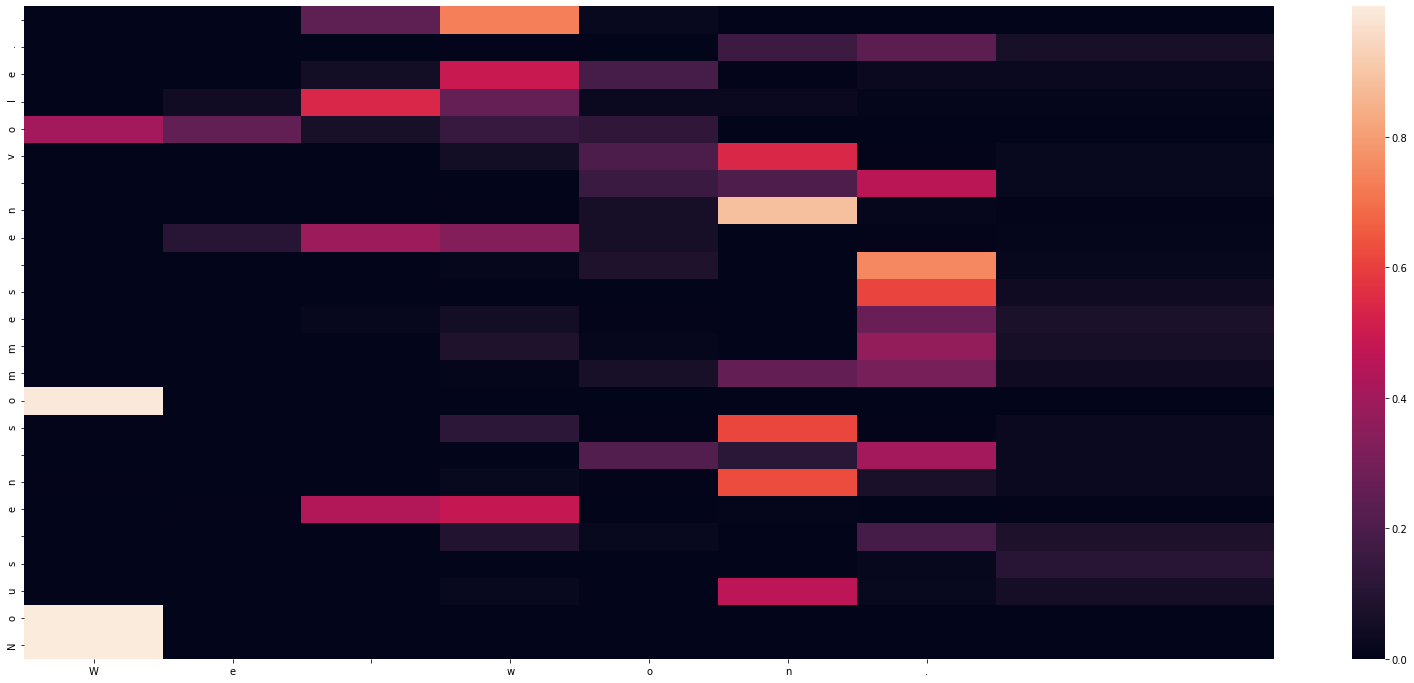

Decoded sentence: Nous en sommes en vole.

-
Input sentence: We won.
GT sentence: 	Nous l'emportâmes.



<Figure size 432x288 with 0 Axes>

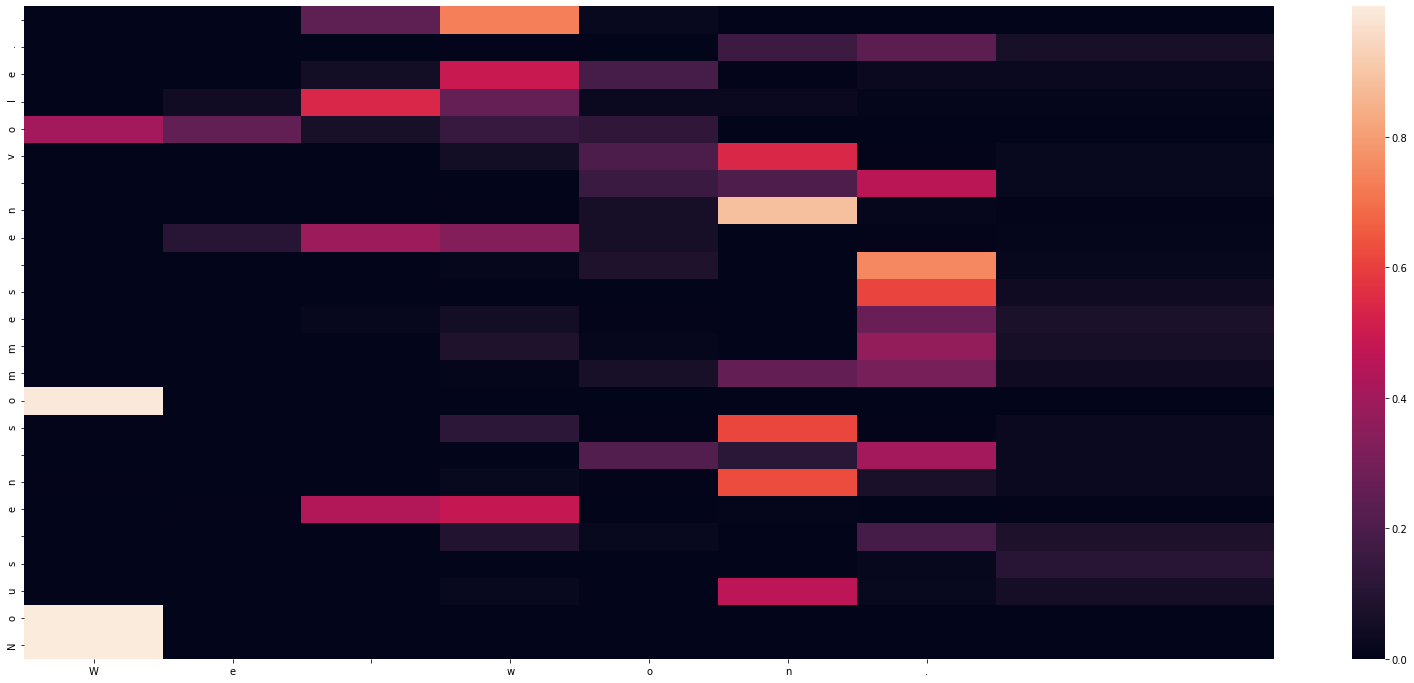

Decoded sentence: Nous en sommes en vole.

-
Input sentence: Ask Tom.
GT sentence: 	Demande à Tom.



<Figure size 432x288 with 0 Axes>

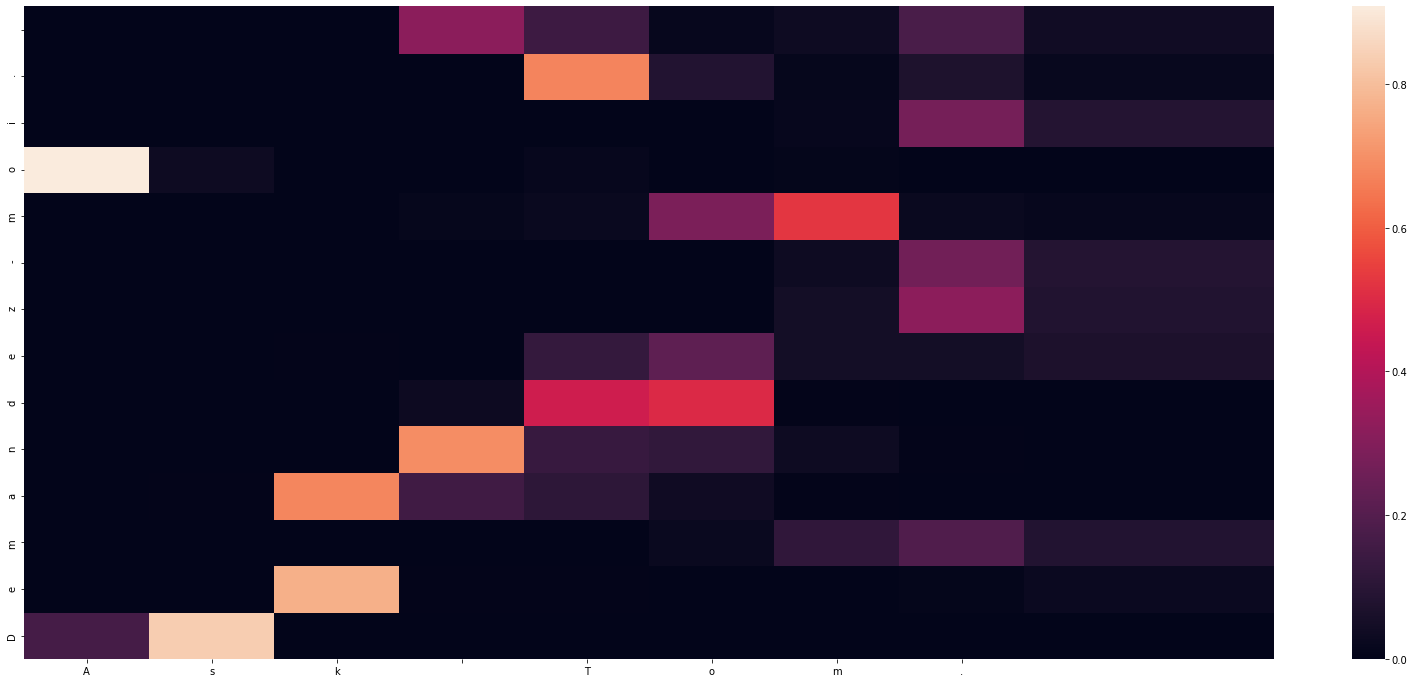

Decoded sentence: Demandez-moi.

-
Input sentence: Awesome!
GT sentence: 	Fantastique !



<Figure size 432x288 with 0 Axes>

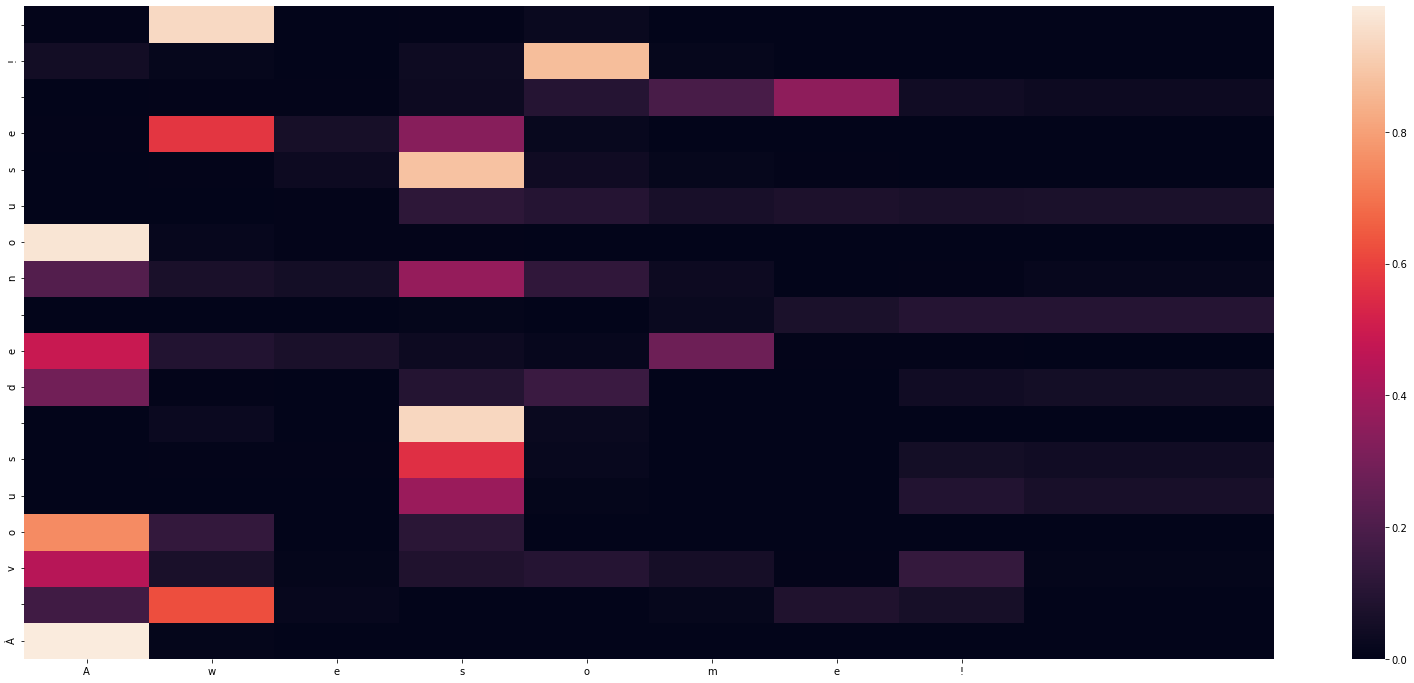

Decoded sentence: À vous de nouse !

-
Input sentence: Be calm.
GT sentence: 	Sois calme !



<Figure size 432x288 with 0 Axes>

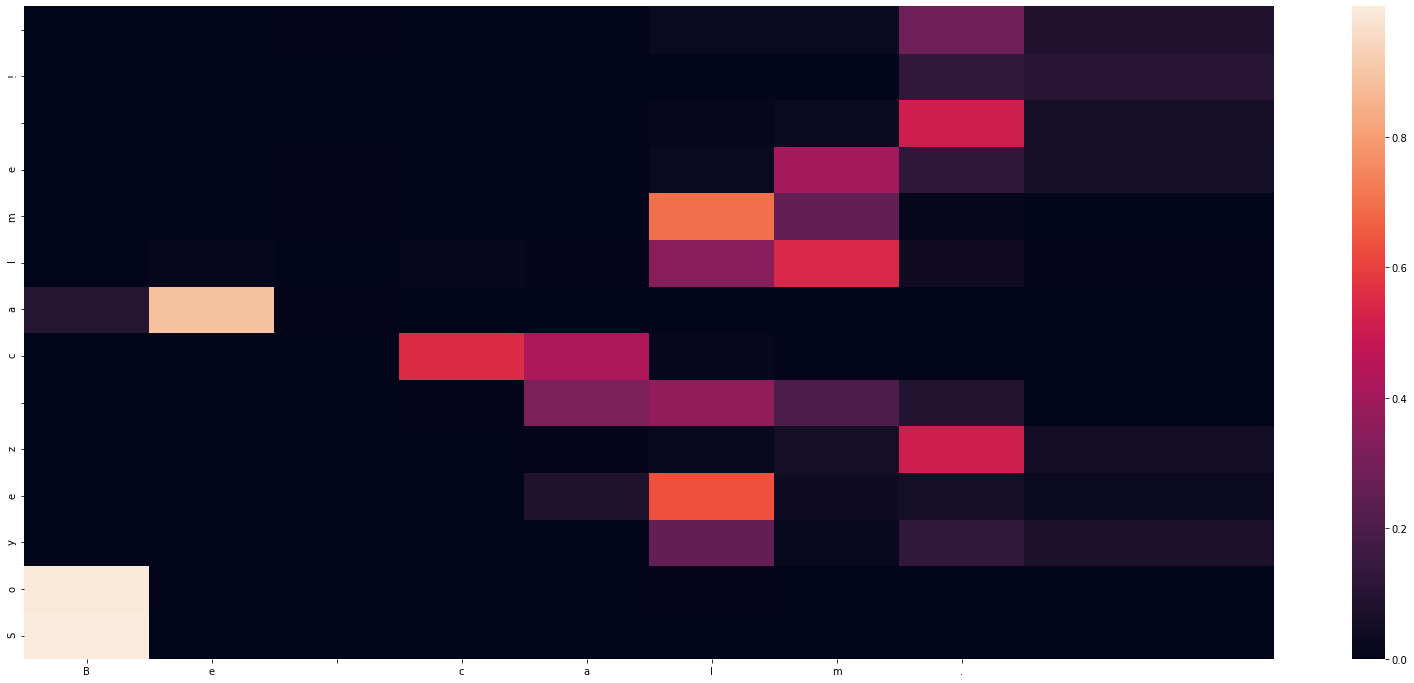

Decoded sentence: Soyez calme !

-
Input sentence: Be calm.
GT sentence: 	Soyez calme !



<Figure size 432x288 with 0 Axes>

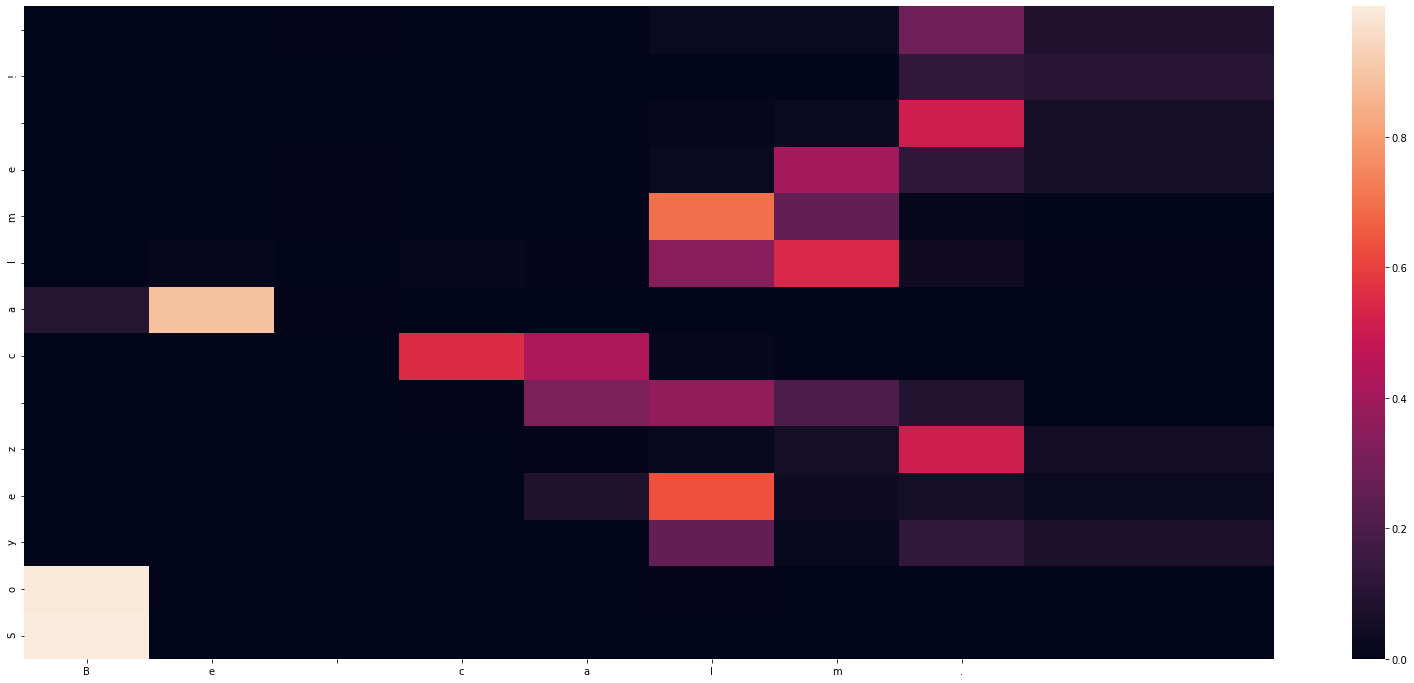

Decoded sentence: Soyez calme !

-
Input sentence: Be calm.
GT sentence: 	Soyez calmes !



<Figure size 432x288 with 0 Axes>

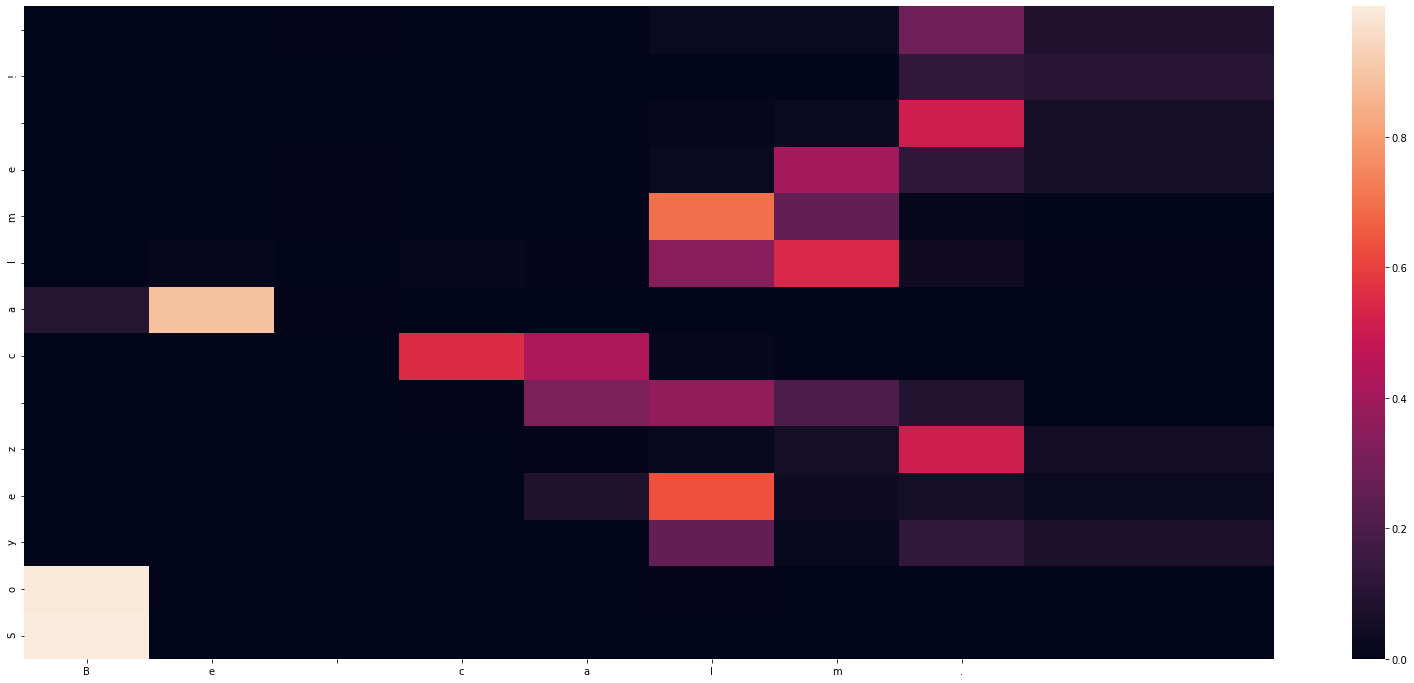

Decoded sentence: Soyez calme !

-
Input sentence: Be cool.
GT sentence: 	Sois détendu !



<Figure size 432x288 with 0 Axes>

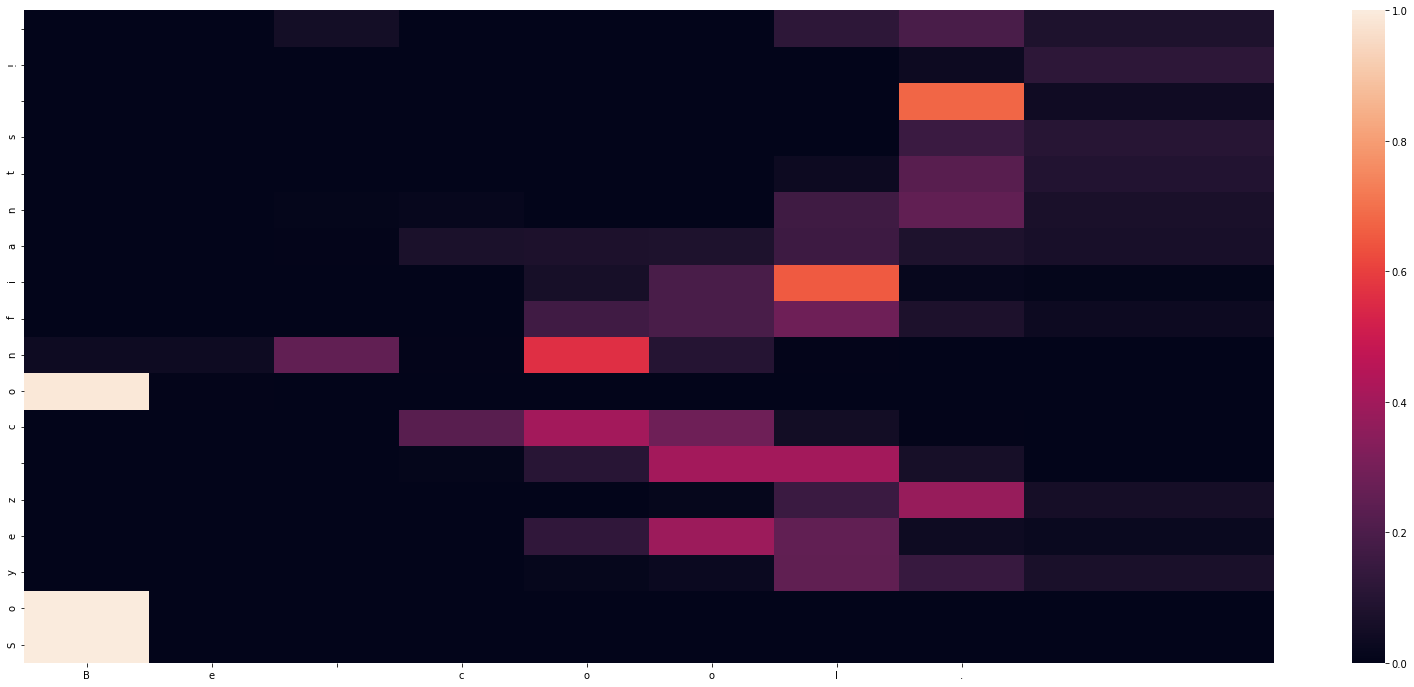

Decoded sentence: Soyez confiants !

-
Input sentence: Be fair.
GT sentence: 	Sois juste !



<Figure size 432x288 with 0 Axes>

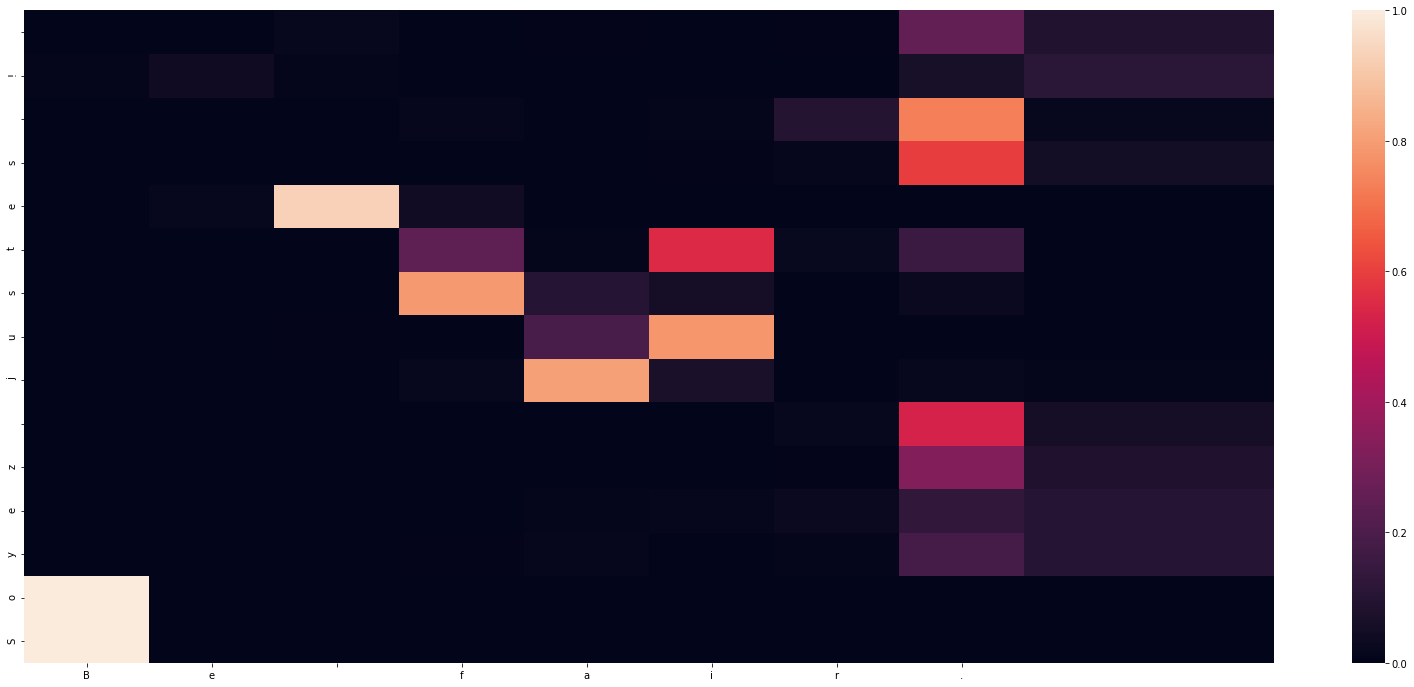

Decoded sentence: Soyez justes !

-
Input sentence: Be fair.
GT sentence: 	Soyez juste !



<Figure size 432x288 with 0 Axes>

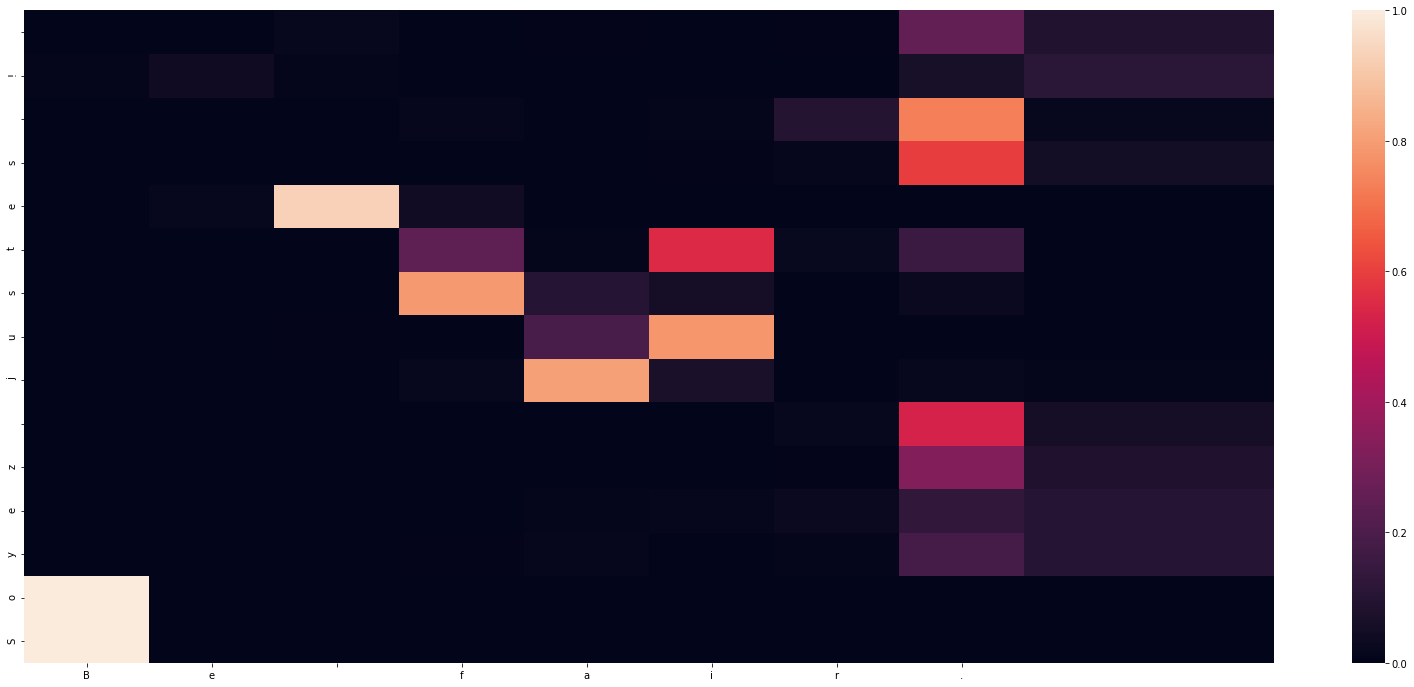

Decoded sentence: Soyez justes !

-
Input sentence: Be fair.
GT sentence: 	Soyez justes !



<Figure size 432x288 with 0 Axes>

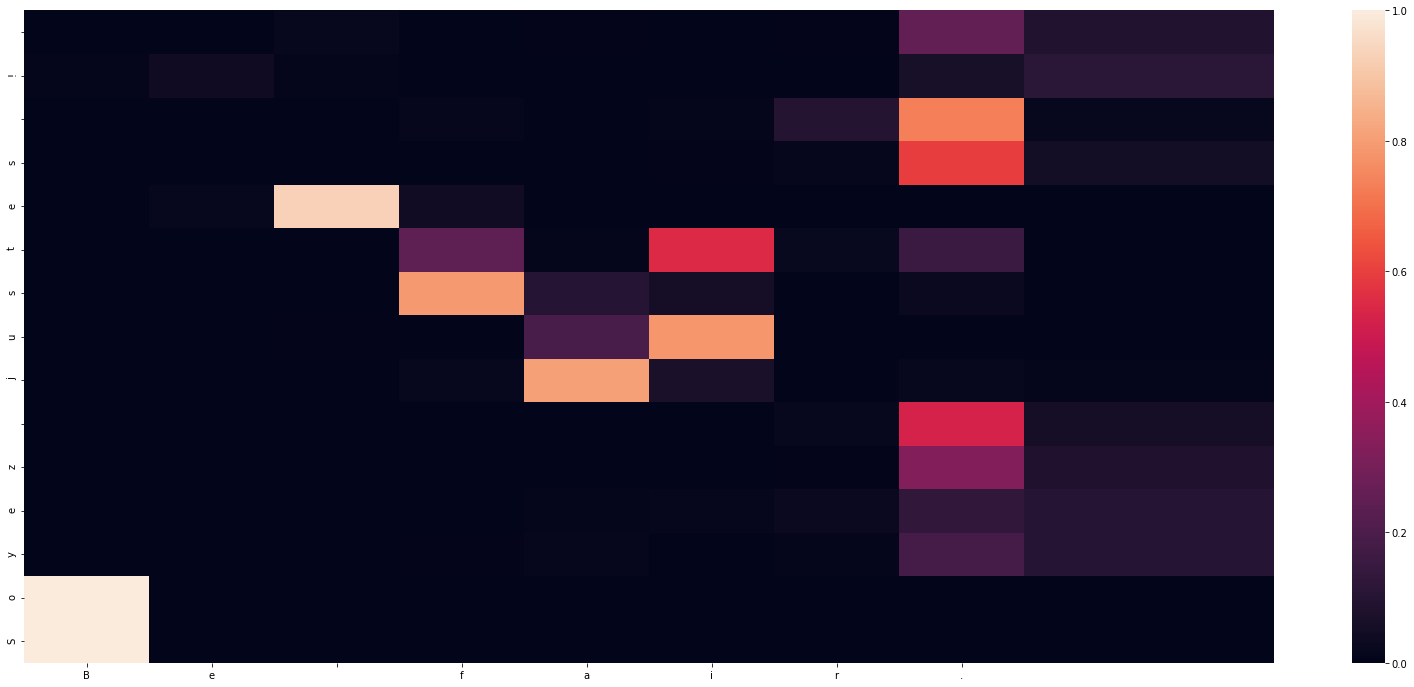

Decoded sentence: Soyez justes !

-
Input sentence: Be fair.
GT sentence: 	Sois équitable !



<Figure size 432x288 with 0 Axes>

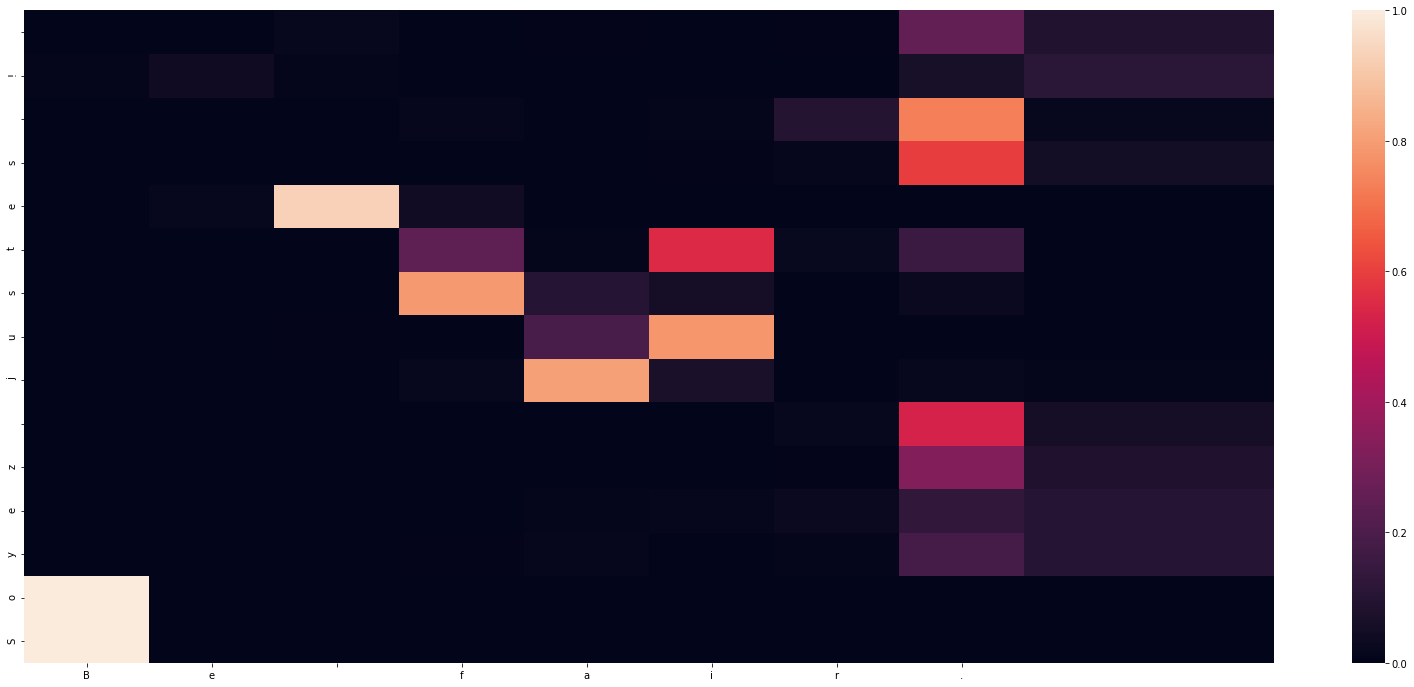

Decoded sentence: Soyez justes !

-
Input sentence: Be fair.
GT sentence: 	Soyez équitable !



<Figure size 432x288 with 0 Axes>

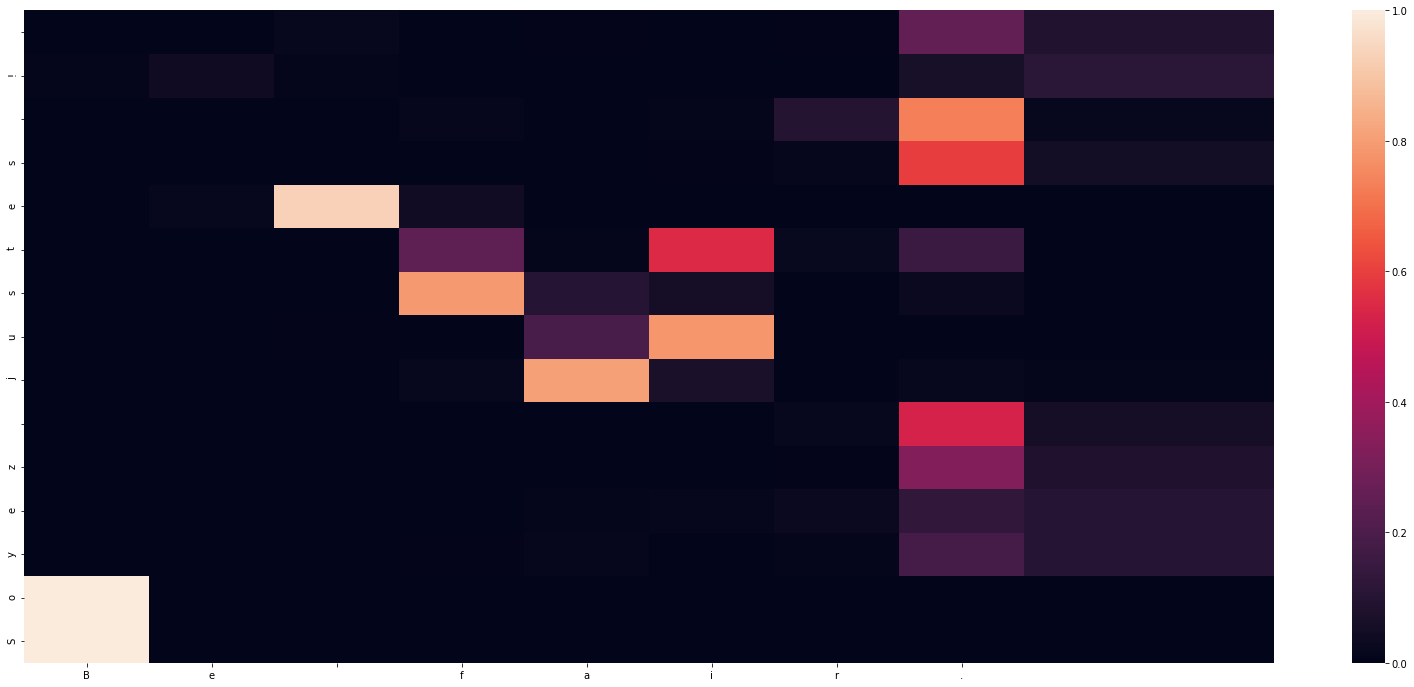

Decoded sentence: Soyez justes !

-
Input sentence: Be fair.
GT sentence: 	Soyez équitables !



<Figure size 432x288 with 0 Axes>

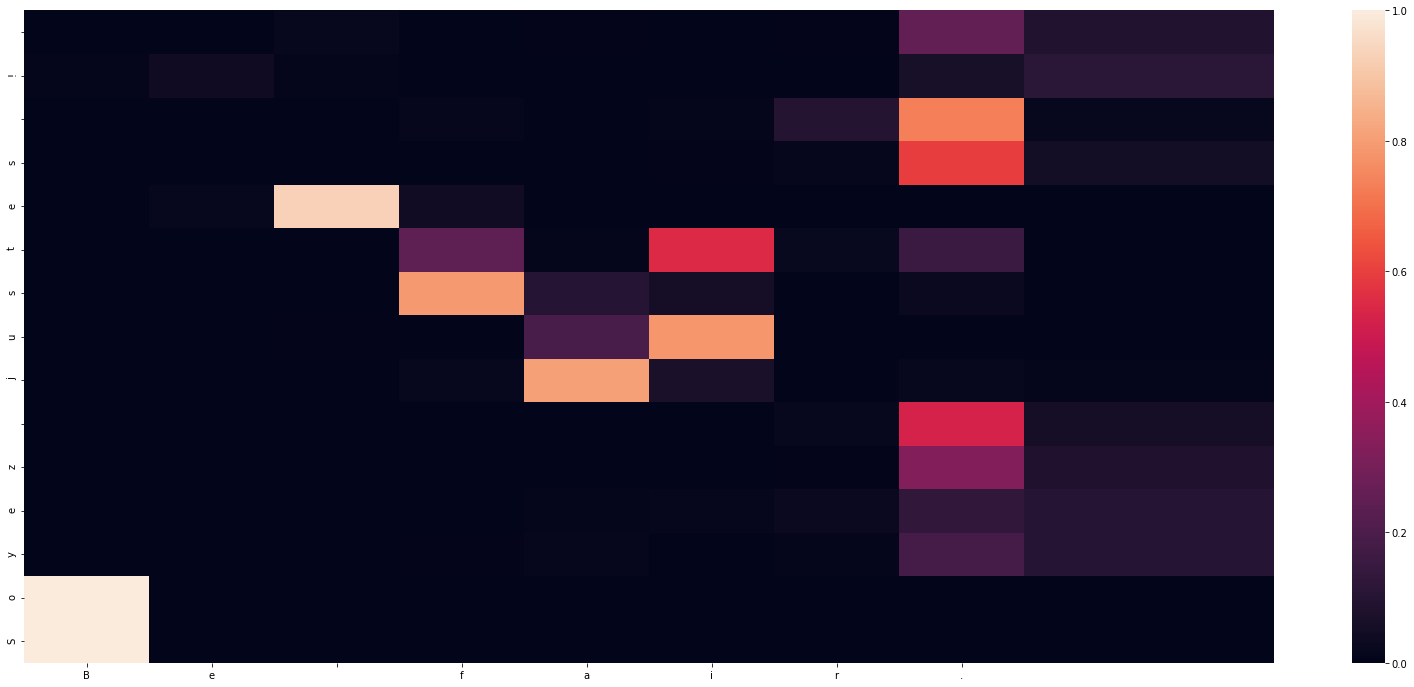

Decoded sentence: Soyez justes !

-
Input sentence: Be kind.
GT sentence: 	Sois gentil.



<Figure size 432x288 with 0 Axes>

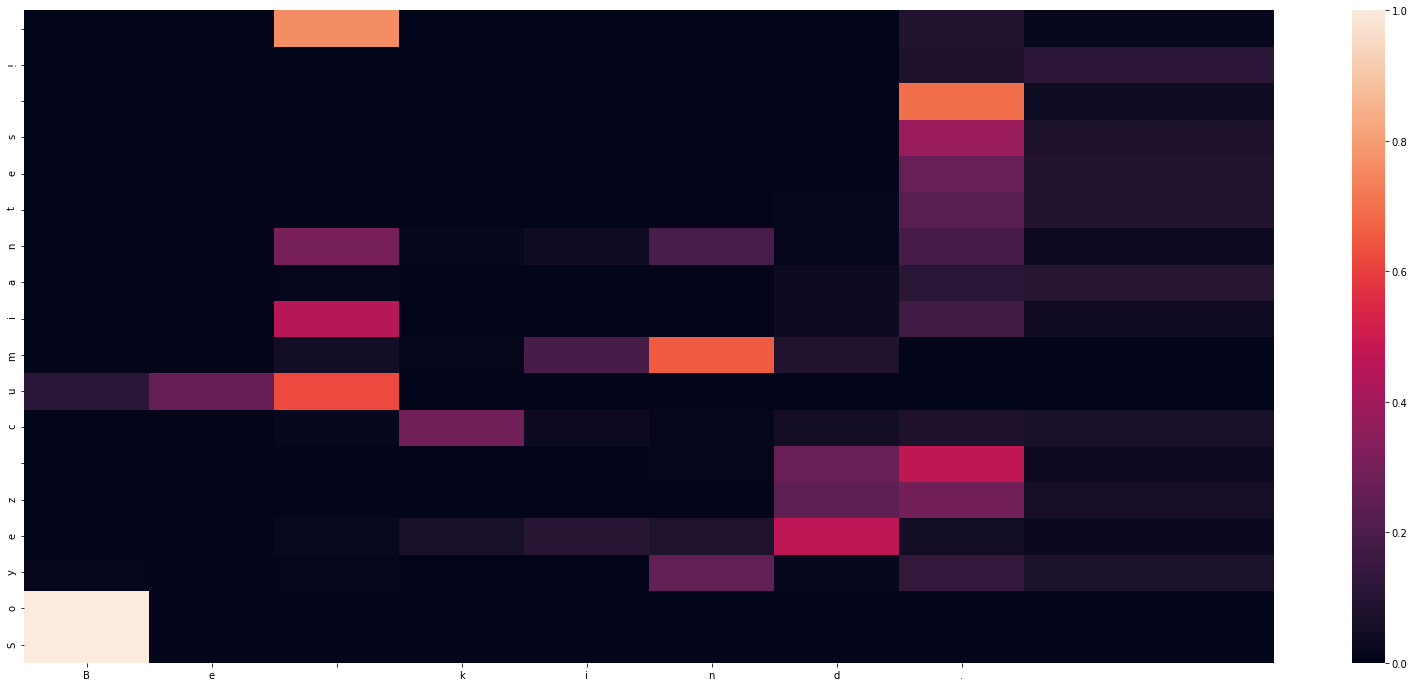

Decoded sentence: Soyez cumiantes !

-
Input sentence: Be nice.
GT sentence: 	Sois gentil !



<Figure size 432x288 with 0 Axes>

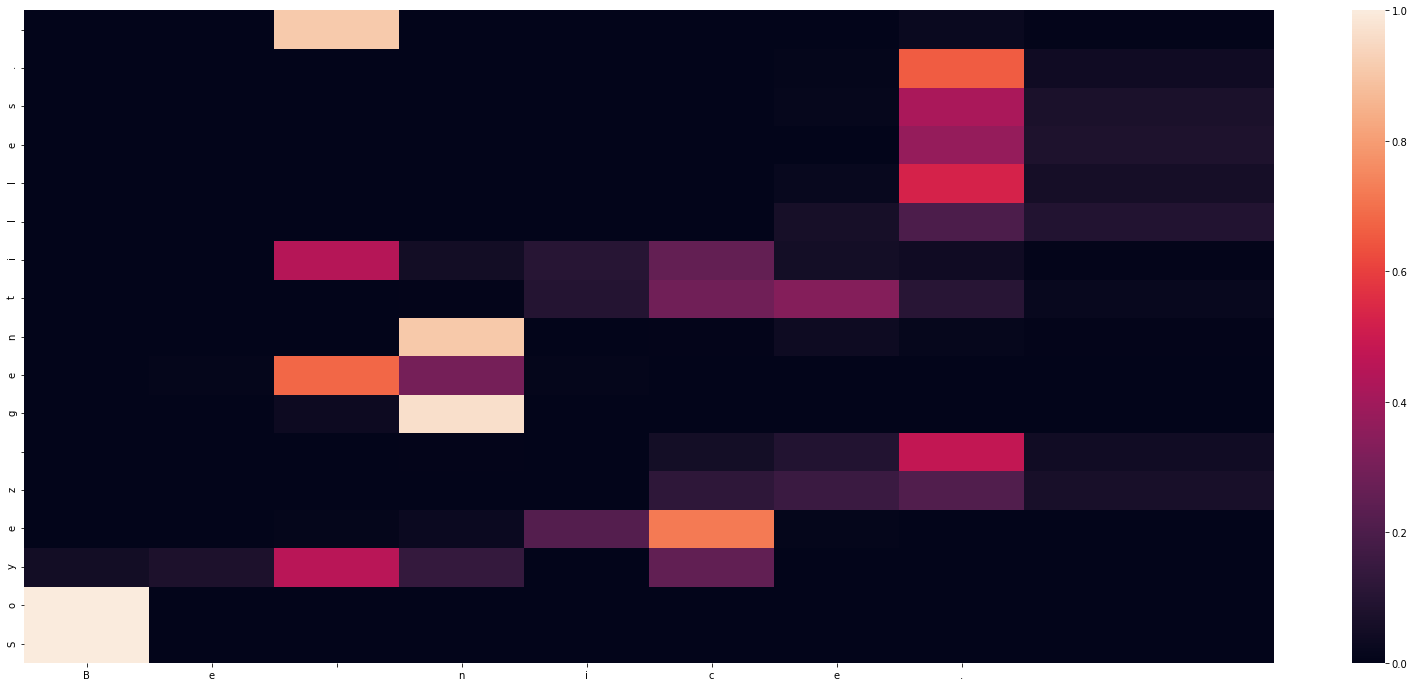

Decoded sentence: Soyez gentilles.

-
Input sentence: Be nice.
GT sentence: 	Sois gentille !



<Figure size 432x288 with 0 Axes>

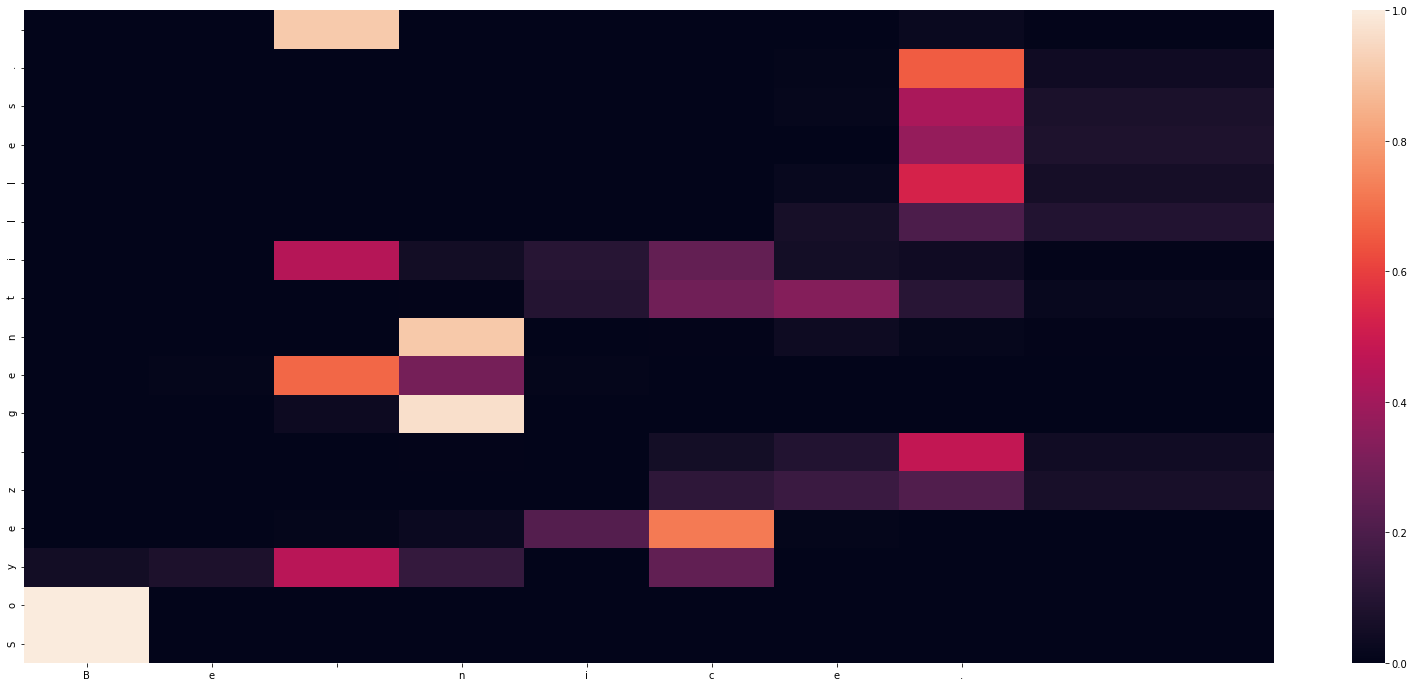

Decoded sentence: Soyez gentilles.

-
Input sentence: Be nice.
GT sentence: 	Soyez gentil !



<Figure size 432x288 with 0 Axes>

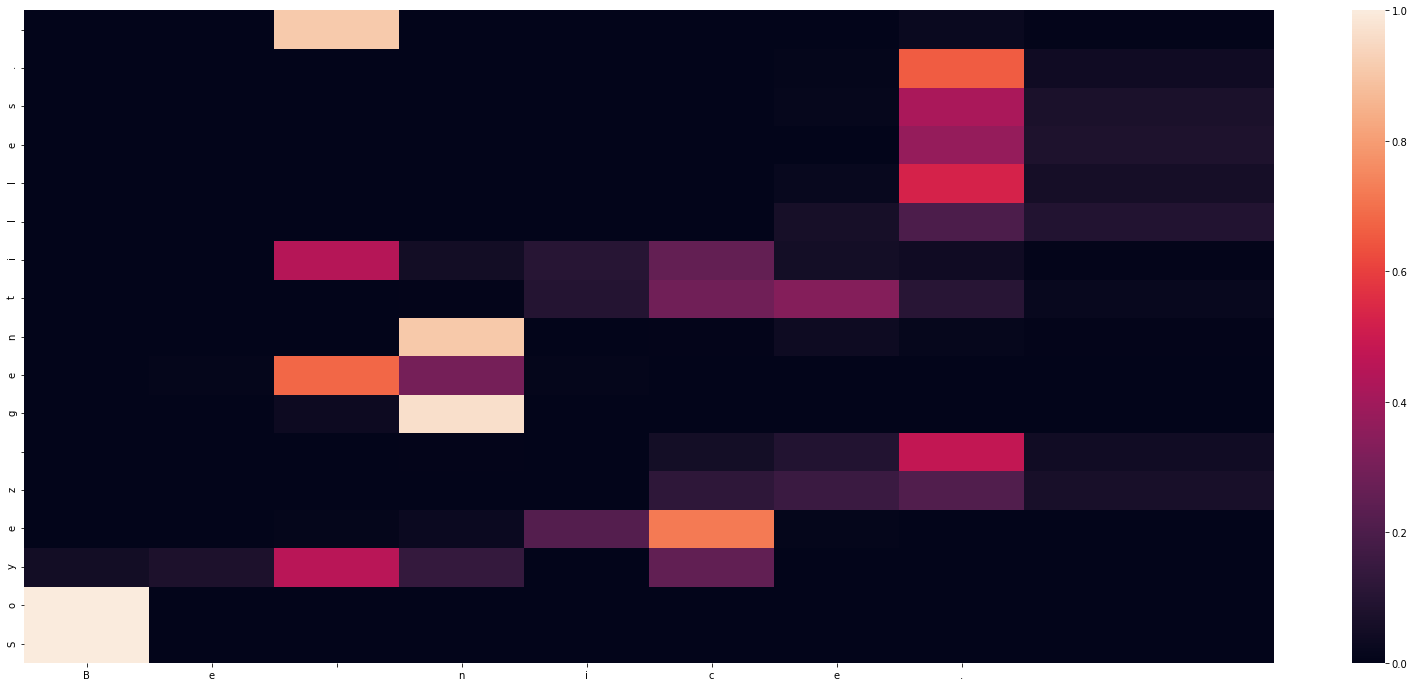

Decoded sentence: Soyez gentilles.

-
Input sentence: Be nice.
GT sentence: 	Soyez gentille !



<Figure size 432x288 with 0 Axes>

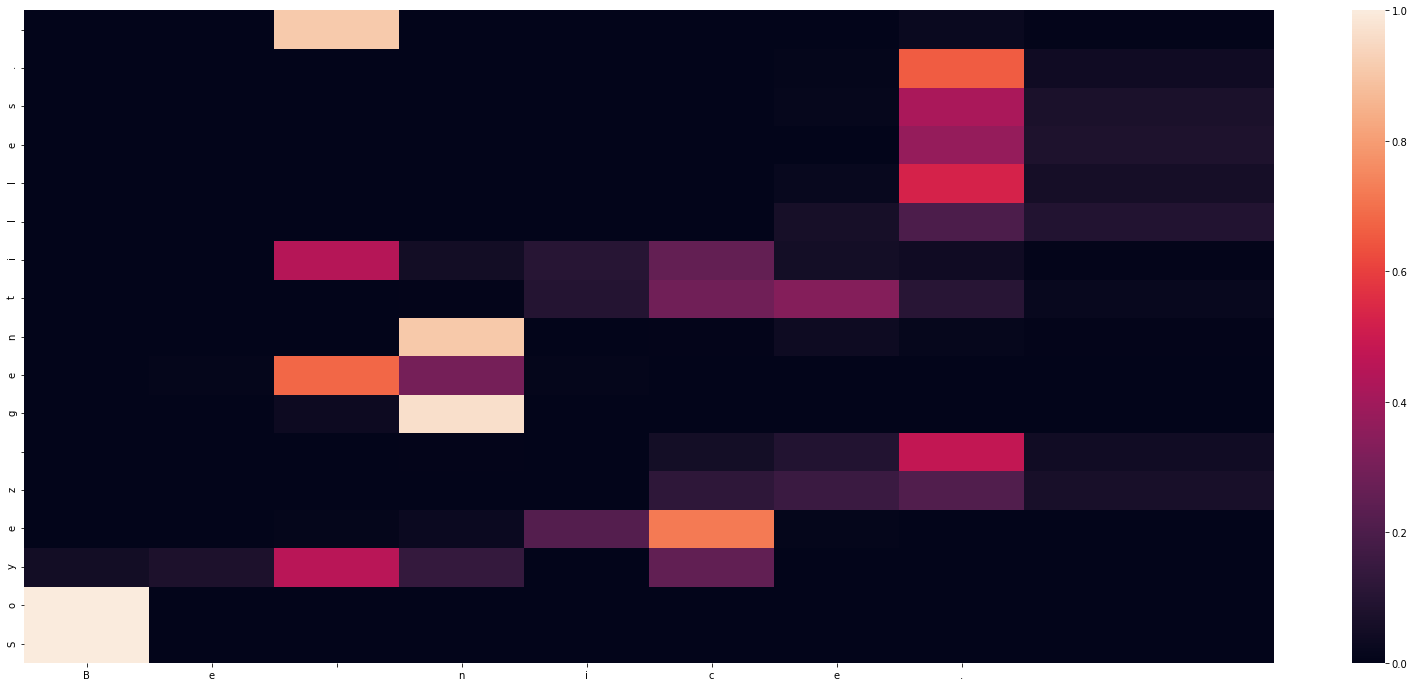

Decoded sentence: Soyez gentilles.

-
Input sentence: Be nice.
GT sentence: 	Soyez gentils !



<Figure size 432x288 with 0 Axes>

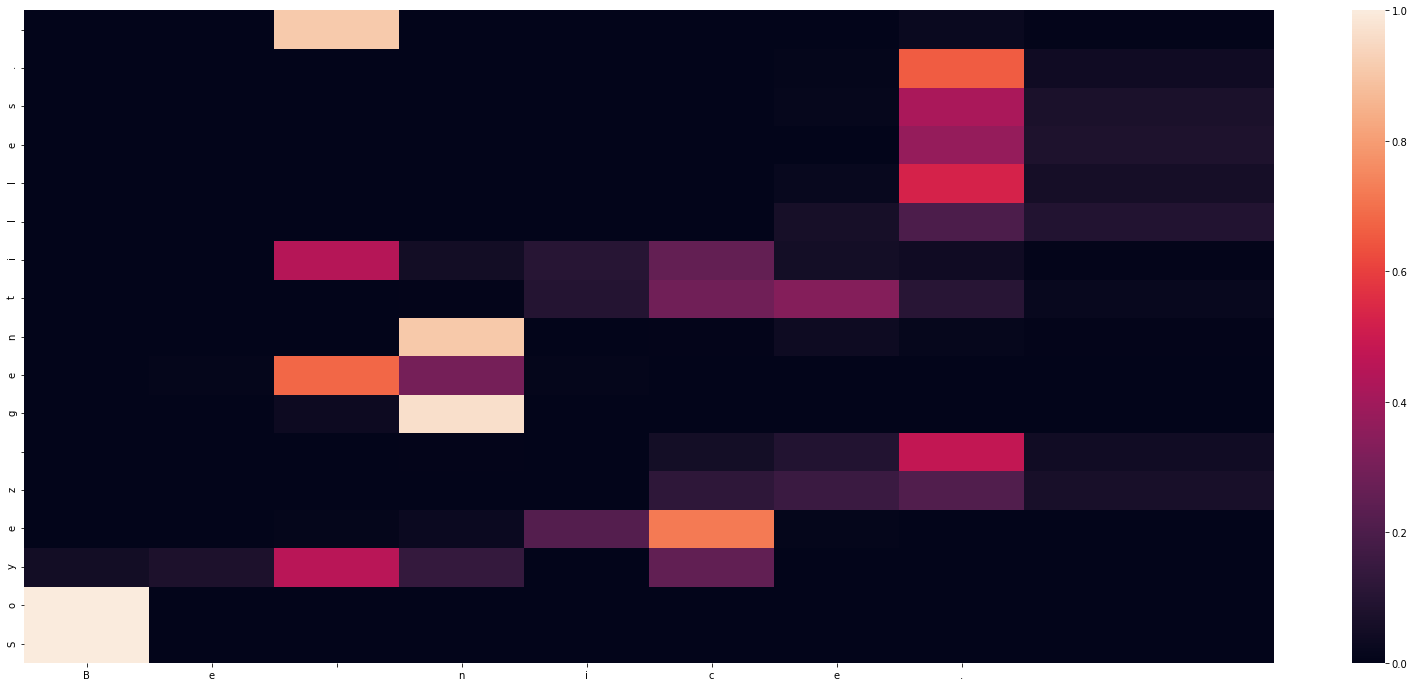

Decoded sentence: Soyez gentilles.

-
Input sentence: Be nice.
GT sentence: 	Soyez gentilles !



<Figure size 432x288 with 0 Axes>

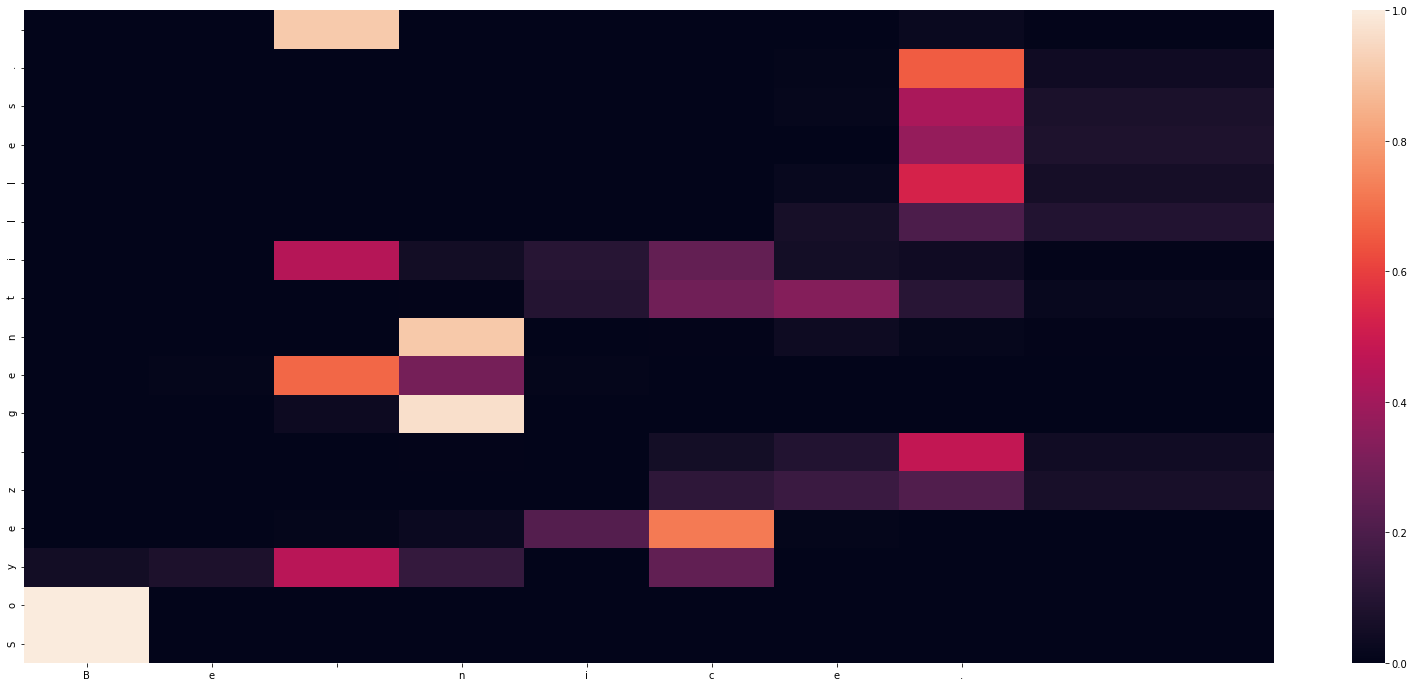

Decoded sentence: Soyez gentilles.

-
Input sentence: Beat it.
GT sentence: 	Dégage !



<Figure size 432x288 with 0 Axes>

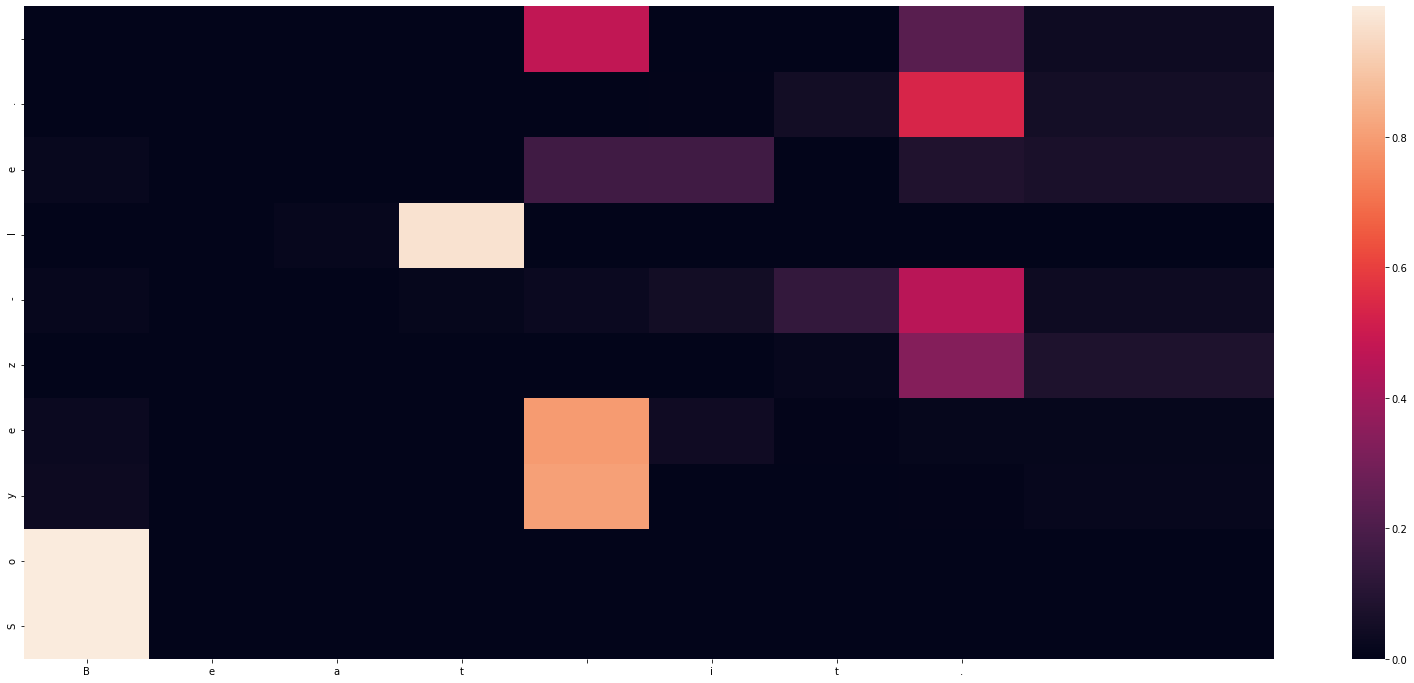

Decoded sentence: Soyez-le.

-
Input sentence: Call me.
GT sentence: 	Appelle-moi !



<Figure size 432x288 with 0 Axes>

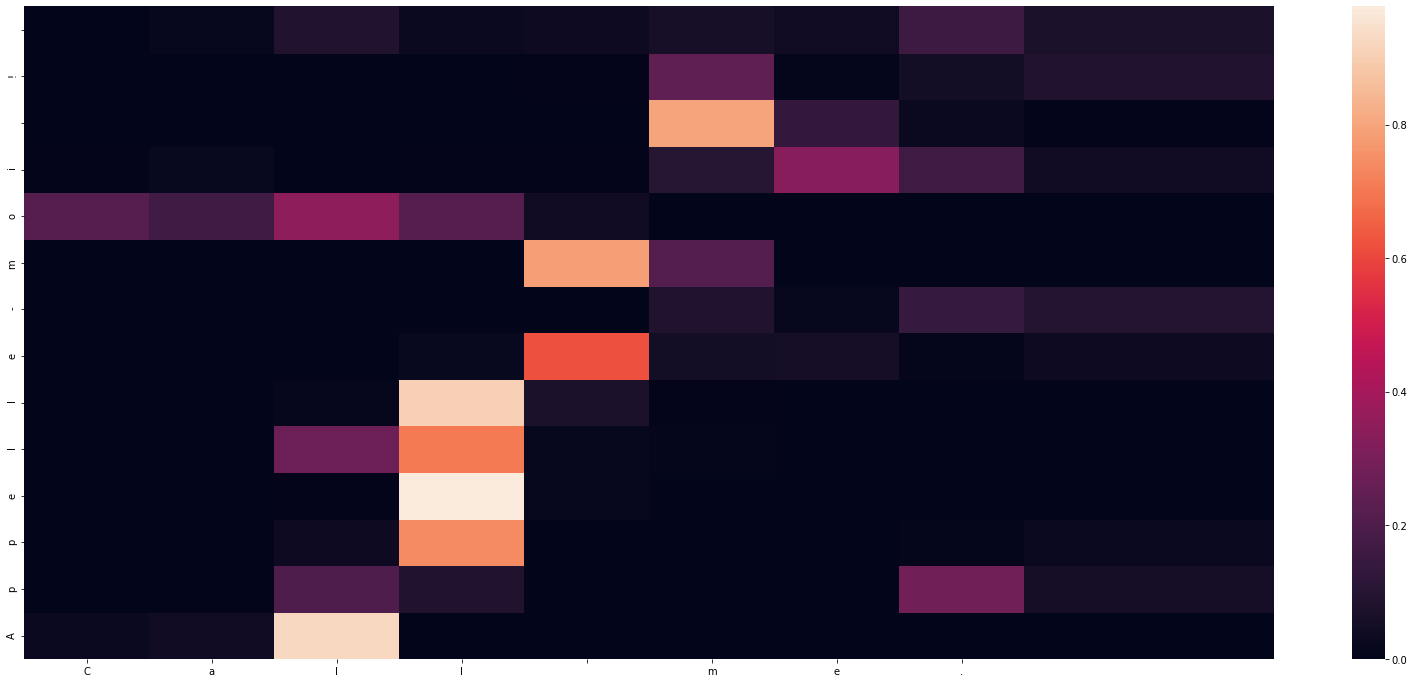

Decoded sentence: Appelle-moi !

-
Input sentence: Call me.
GT sentence: 	Appellez-moi !



<Figure size 432x288 with 0 Axes>

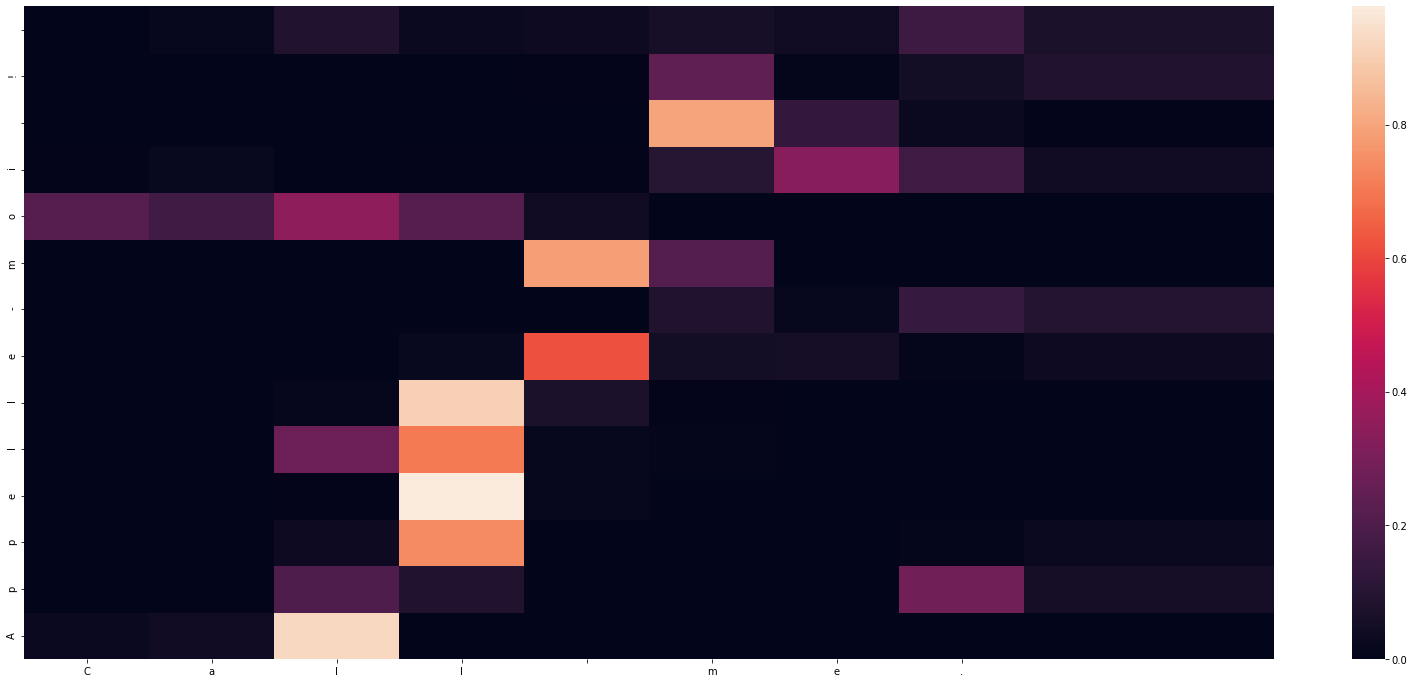

Decoded sentence: Appelle-moi !

-
Input sentence: Call us.
GT sentence: 	Appelle-nous !



<Figure size 432x288 with 0 Axes>

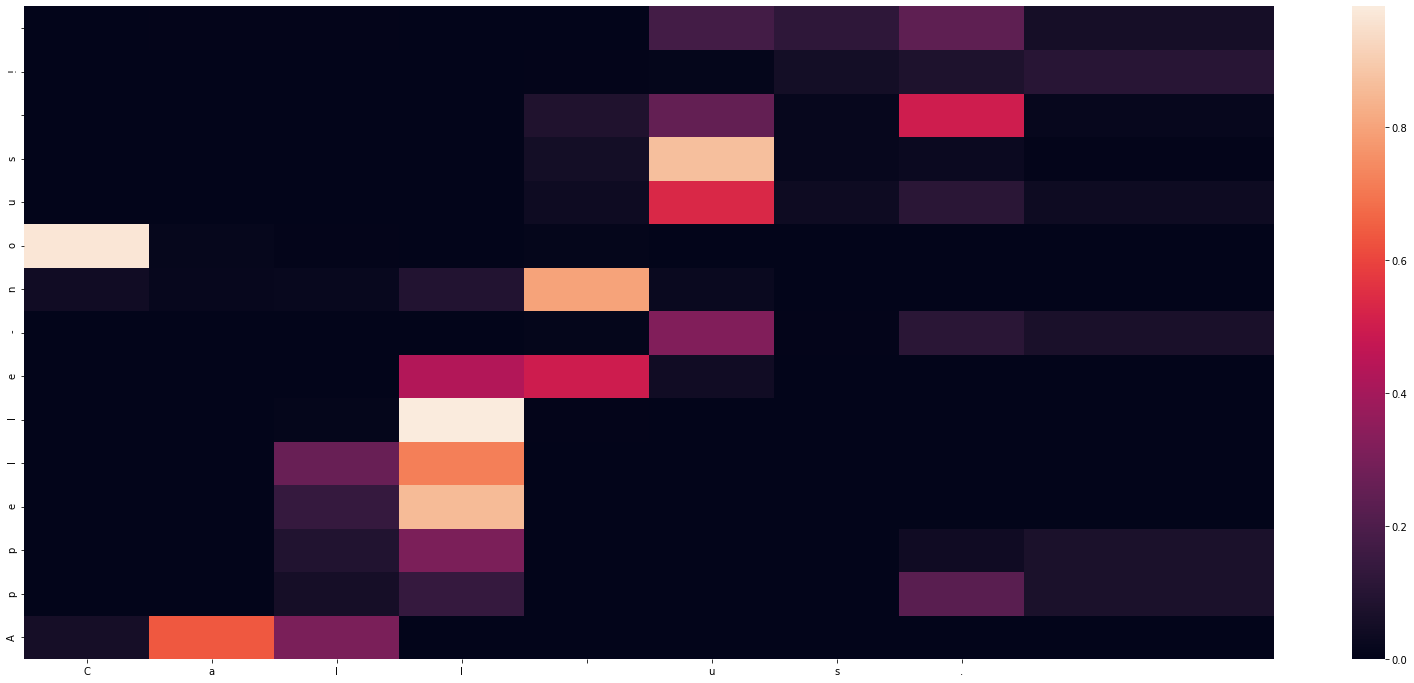

Decoded sentence: Appelle-nous !

-
Input sentence: Call us.
GT sentence: 	Appelez-nous !



<Figure size 432x288 with 0 Axes>

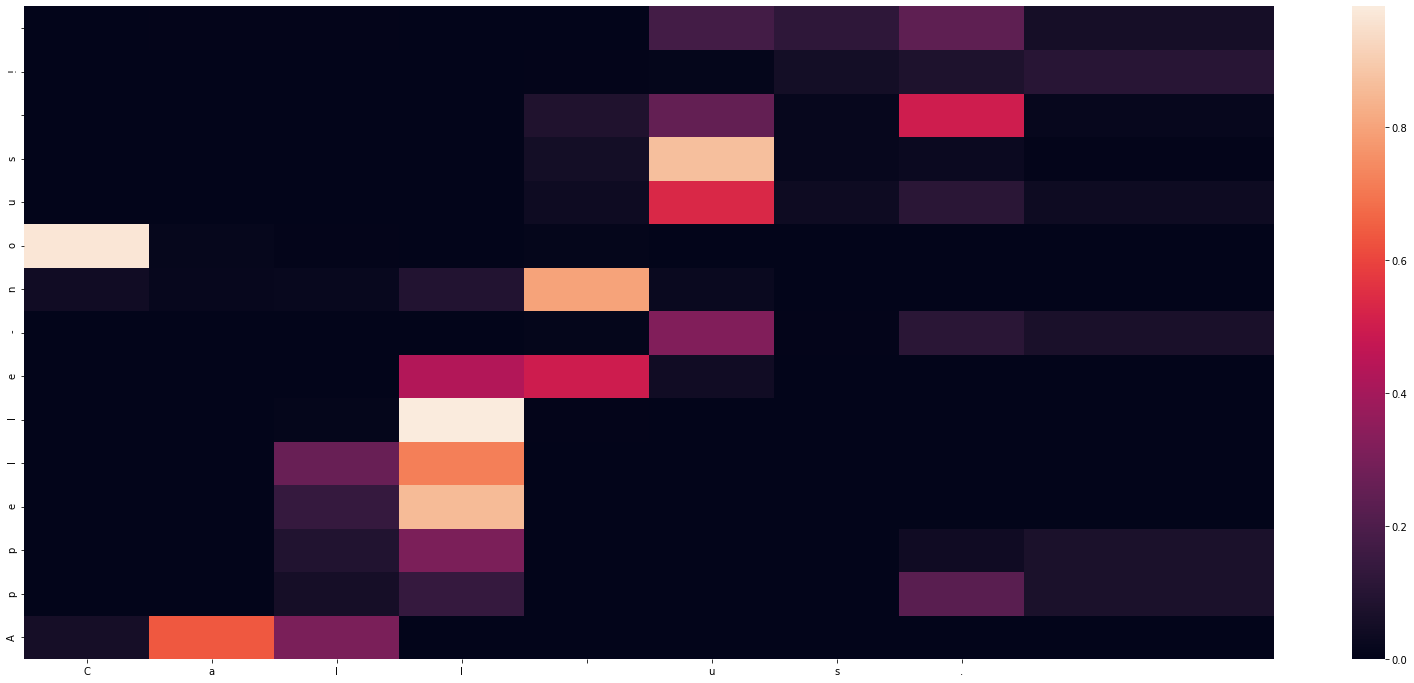

Decoded sentence: Appelle-nous !

-
Input sentence: Come in.
GT sentence: 	Entrez !



<Figure size 432x288 with 0 Axes>

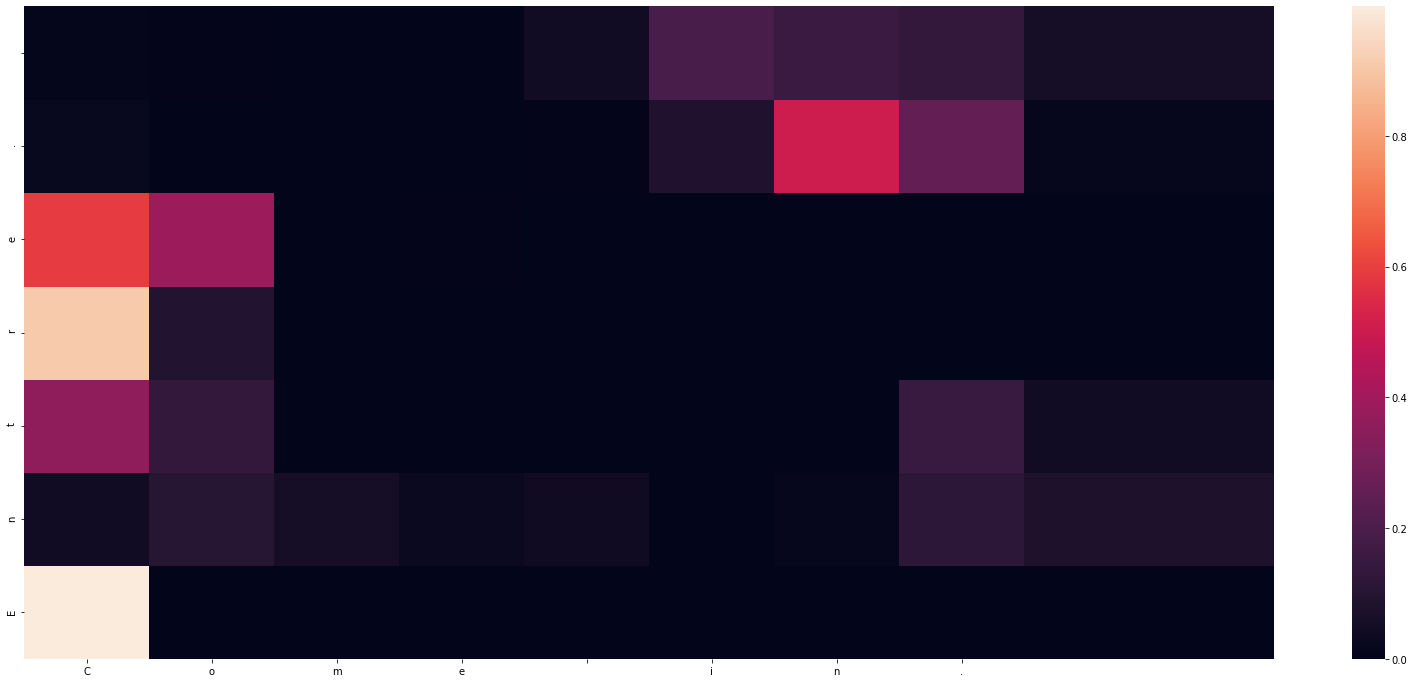

Decoded sentence: Entre.



In [ ]:
for seq_index in range(100):

    target_text = lines.target[seq_index]
    text = lines.input[seq_index]
    print('-')
    print('Input sentence:', text)    
    print('GT sentence:', target_text)
    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, input_token_index, reverse_target_tok_index, tok_split_fn, sep='')

    
    print('Decoded sentence:', decoded_sentence) 

# Evaluation



___In seq2seq tasks, accuracy is not always a good metric:___


- Accuracy definition is different according to the definition of _what is a token?_. As can be seen above, char level has much higher accuracy, but that doesn't mean a better NMT system!

What we care about is getting the correct sequence of _words_

- The input and target sequences are not necessarily aligned. We might have:
  - Deletions
  - Substitutions
  - Insertions


For that, we calculate the 1-edit distance as follows:

In [ ]:
def calculate_WER_sent(gt, pred):
    '''
    calculate_WER('calculating wer between two sentences', 'calculate wer between two sentences')
    '''
    gt_words = gt.lower().split(' ')
    pred_words = pred.lower().split(' ')
    d = np.zeros(((len(gt_words) + 1), (len(pred_words) + 1)), dtype=np.uint8)
    # d = d.reshape((len(gt_words)+1, len(pred_words)+1))

    # Initializing error matrix
    for i in range(len(gt_words) + 1):
        for j in range(len(pred_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(gt_words) + 1):
        for j in range(1, len(pred_words) + 1):
            if gt_words[i - 1] == pred_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    return d[len(gt_words)][len(pred_words)]
def calculate_WER(gt, pred):
    '''

    :param gt: list of sentences of the ground truth
    :param pred: list of sentences of the predictions
    both lists must have the same length
    :return: accumulated WER
    '''
#    assert len(gt) == len(pred)
    WER = 0
    nb_w = 0
    for i in range(len(gt)):
        #print(gt[i])
        #print(pred[i])
        WER += calculate_WER_sent(gt[i], pred[i])
        nb_w += len(gt[i])

    return WER / nb_w

Using this metric, we can better compare word to char models:

In [ ]:
target_sents = list(lines.target[:100])
target_sents = [x[1:-1] for x in target_sents]
word_decoded_sents = [' '.join(x.split()[1:-1]) for x in word_decoded_sents]
char_decoded_sents = [x[1:-1] for x in char_decoded_sents]


In [ ]:

WER_word = calculate_WER(target_sents, word_decoded_sents)
WER_char = calculate_WER(target_sents, char_decoded_sents)
print('Word level NMT WER = ', str(WER_word))
print('Char level NMT WER = ', str(WER_char))


Word level NMT WER =  0.17337715694330322
Char level NMT WER =  0.18405916187345933


# Possible fixes:
- Custom loss: after the char2char model generates its output, decoder chat by char, then split/tokenize into `decoded_seq` as sequence of words. This enables to calculate a custom loss at the word level (which we care about). Possible losses are:
  - CTC loss: `ctc_loss(gt_seq, decoded_seq)`
  - WER loss: `calculate_WER(gt_seq, decoded_seq)`

- char2word: input=char level, output=word level
  - Learn word boundaries/notion end2end
  - Leading to similar situation as custom loss; the loss will be higher as long as we don't decode the exact needed word.

  - Could be integrated with pre-trained decoder on word level NLM. 

# Char2Word

In [ ]:
lines = pd.DataFrame({'input':inputs, 'target':targets})
num_samples = 10000
lines = lines[0:num_samples]
pad_tok = 'PAD'
sep_tok = ' '
st_tok = 'START_'
end_tok = '_END'
def data_prep(lines):
  cleanup(lines)
  lines.target = lines.target.apply(lambda x : st_tok + ' ' + x + ' ' + end_tok)
data_prep(lines)

input_tok_split_fn = tok_split_char2char
target_tok_split_fn=tok_split_word2word 

lstm_sz = emb_sz = 50


input_tokens, target_tokens, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length = data_stats(lines, input_tok_split_fn, target_tok_split_fn)
print('Number of samples:', len(lines))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

max_encoder_seq_length = 116 
max_decoder_seq_length = 16
  
special_tokens = [pad_tok, sep_tok, st_tok, end_tok]
num_encoder_tokens += len(special_tokens)
num_decoder_tokens += len(special_tokens)

input_token_index, target_token_index, reverse_input_tok_index, reverse_target_tok_index = vocab(input_tokens, target_tokens)

encoder_input_data, decoder_input_data, decoder_target_data  = vectorize(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens, input_tok_split_fn, target_tok_split_fn)

model, encoder_model, decoder_model = seq2seq_attention(num_encoder_tokens, num_decoder_tokens, emb_sz, emb_sz)
print(model.summary())
plot_model(model)

model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=128,
          epochs=10,
          validation_split=0.05)
          


Number of samples: 10000
Number of unique input tokens: 32
Number of unique output tokens: 4545
Max sequence length for inputs: 20
Max sequence length for outputs: 12
[<tf.Tensor 'concatenate_7/concat:0' shape=(None, 100) dtype=float32>, <tf.Tensor 'concatenate_8/concat:0' shape=(None, 100) dtype=float32>]
Tensor("lstm_12/transpose_2:0", shape=(None, None, 100), dtype=float32)
Tensor("bidirectional_3/concat:0", shape=(None, None, 100), dtype=float32)
attention Tensor("attention_4/truediv:0", shape=(None, None, None), dtype=float32)
encoder-decoder  model:
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, None, 50)     1800        input_23[0][0]                   
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) [(None, None, 100),  40400       embedding_11[0][0]               
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9500 samples, validate on 500 samples
Epoch 1/10
9500/9500 [==============================] - 43s 5ms/step - loss: 1.6507 - acc: 0.2617 - val_loss: 1.5478 - val_acc: 0.2636
Epoch 2/10
9500/9500 [==============================] - 42s 4ms/step - loss: 1.3589 - acc: 0.3676 - val_loss: 1.4879 - val_acc: 0.3777
Epoch 3/10
9500/9500 [==============================] - 41s 4ms/step - loss: 1.2535 - acc: 0.4292 - val_loss: 1.4331 - val_acc: 0.3800
Epoch 4/10
9500/9500 [==============================] - 41s 4ms/step - loss: 1.2017 - acc: 0.4404 - val_loss: 1.4047 - val_acc: 0.3796
Epoch 5/10
9500/9500 [==============================] - 41s 4ms/step - loss: 1.1613 - acc: 0.4493 - val_loss: 1.3924 - val_acc: 0.3785
Epoch 6/10
9500/9500 [==============================] - 41s 4ms/step - loss: 1.1275 - acc: 0.4550 - val_loss: 1.3608 - val_acc: 0.3819
Epoch 7/10
9500/9500 [==============================] - 41s 4ms/step - loss: 1.0946 - acc: 0.4641 - val_loss: 1.3380 - val_acc: 0.4050
Epoch 8/

-
Input sentence: 0    go
Name: input, dtype: object
GT sentence: TART_ va  _EN
Decoded sentence: _END
-
Input sentence: 1    hi
Name: input, dtype: object
GT sentence: TART_ salut  _EN
Decoded sentence: _END
-
Input sentence: 2    hi
Name: input, dtype: object
GT sentence: TART_ salut _EN
Decoded sentence: _END
-
Input sentence: 3    run
Name: input, dtype: object
GT sentence: TART_ cours  _EN
Decoded sentence: _END
-
Input sentence: 4    run
Name: input, dtype: object
GT sentence: TART_ courez  _EN
Decoded sentence: _END
-
Input sentence: 5    who
Name: input, dtype: object
GT sentence: TART_ qui  _EN
Decoded sentence: _END
-
Input sentence: 6    wow
Name: input, dtype: object
GT sentence: TART_ ça alors  _EN
Decoded sentence: _END
-
Input sentence: 7    fire
Name: input, dtype: object
GT sentence: TART_ au feu  _EN
Decoded sentence: _END
-
Input sentence: 8    help
Name: input, dtype: object
GT sentence: TART_ à laide  _EN
Decoded sentence: _END
-
Input sentence: 9    jump
Name: inp

<Figure size 432x288 with 0 Axes>

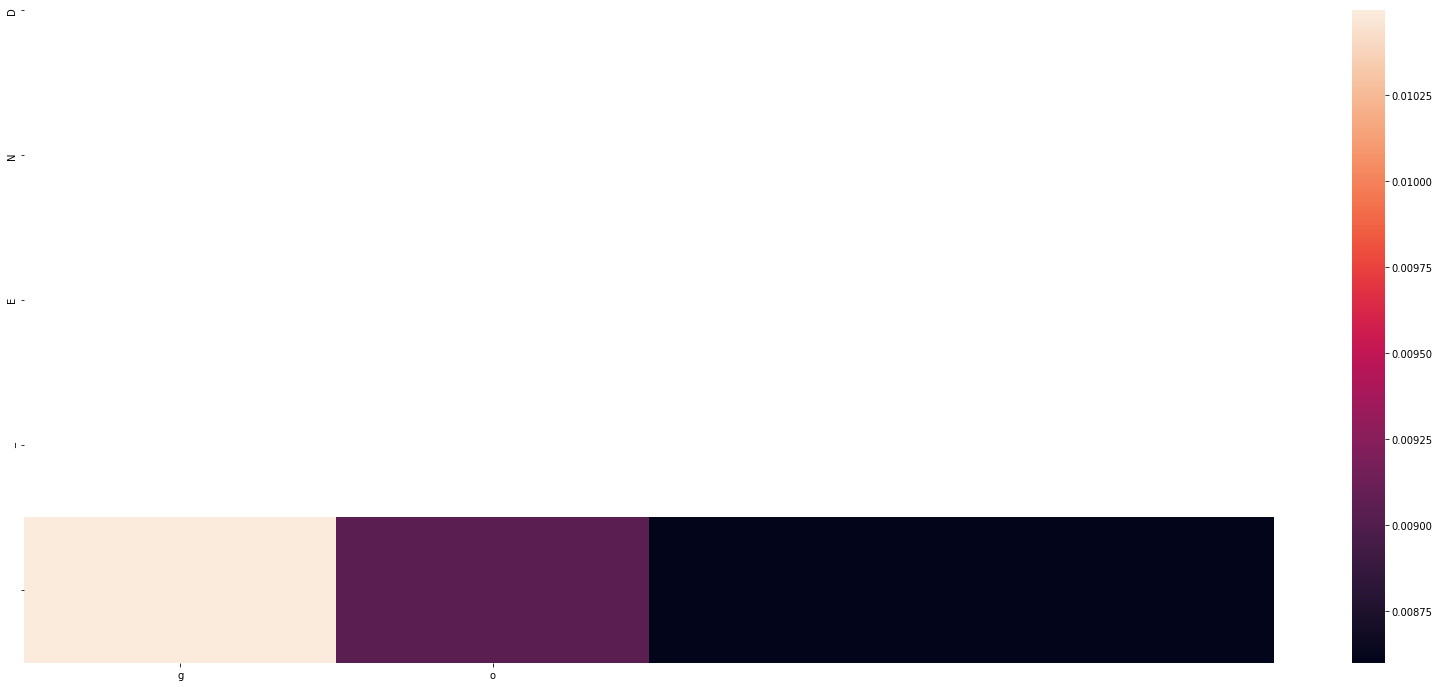

Decoded sentence:  _END
-
Input sentence: hi
GT sentence: START_ salut  _END


<Figure size 432x288 with 0 Axes>

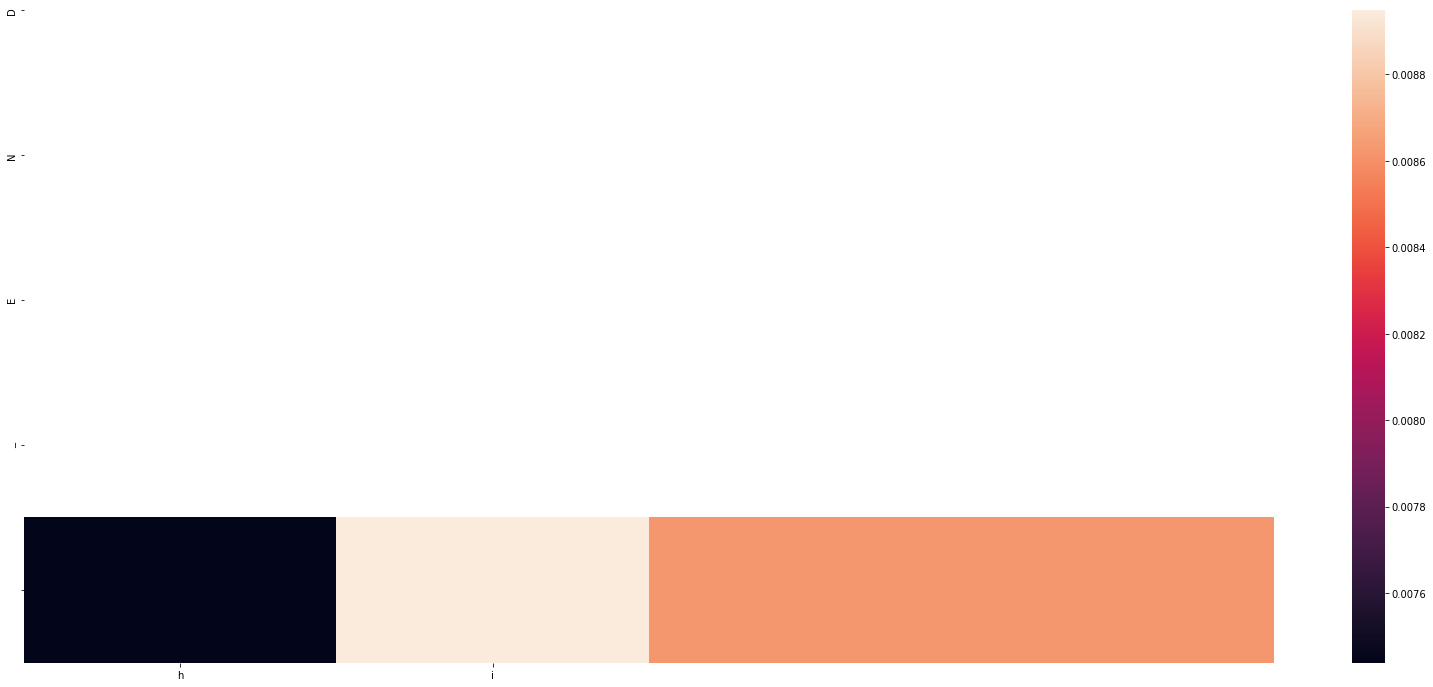

Decoded sentence:  _END
-
Input sentence: hi
GT sentence: START_ salut _END


<Figure size 432x288 with 0 Axes>

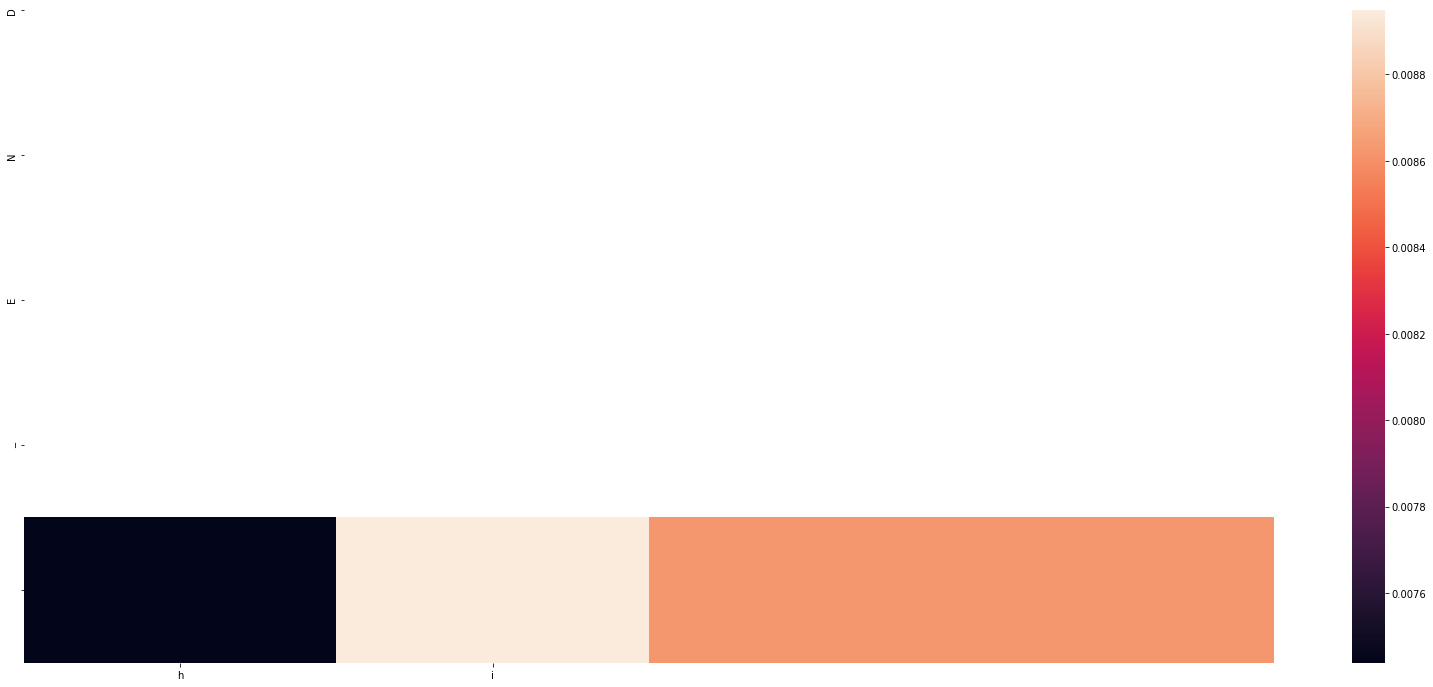

Decoded sentence:  _END
-
Input sentence: run
GT sentence: START_ cours  _END


<Figure size 432x288 with 0 Axes>

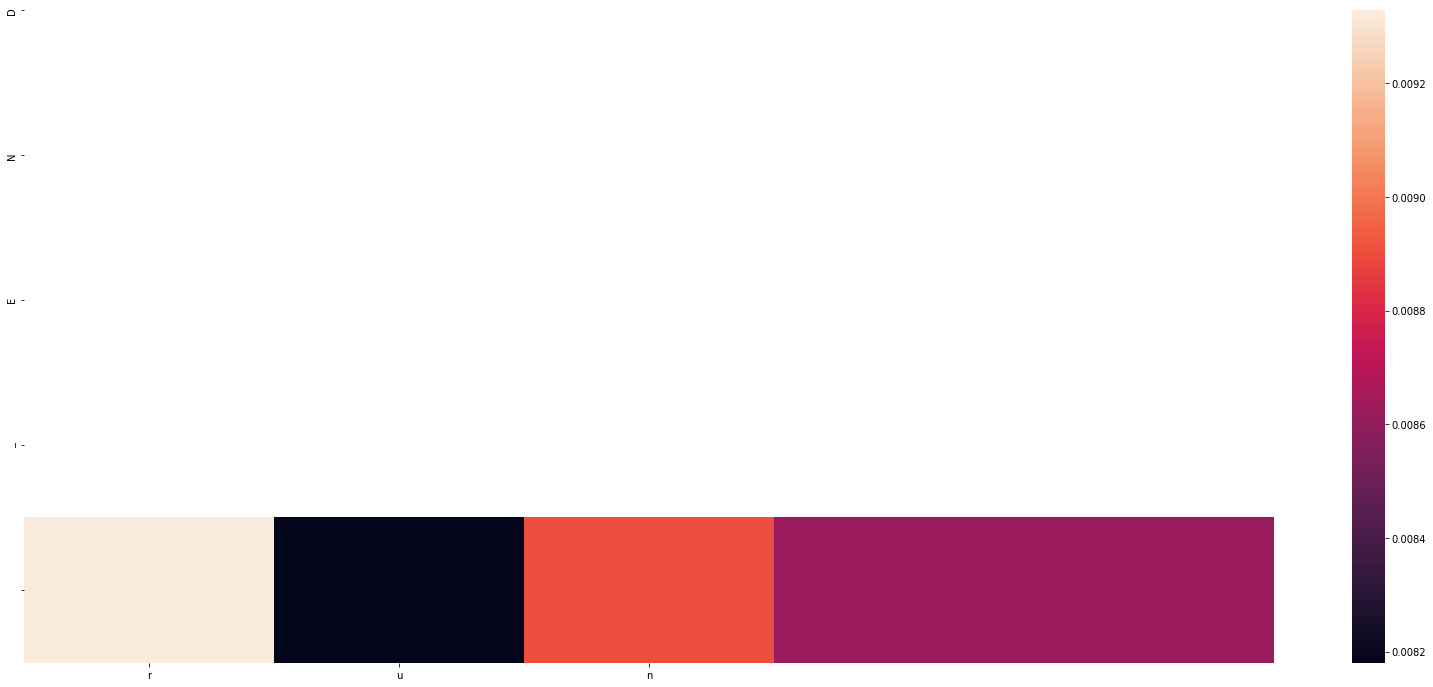

Decoded sentence:  _END
-
Input sentence: run
GT sentence: START_ courez  _END


<Figure size 432x288 with 0 Axes>

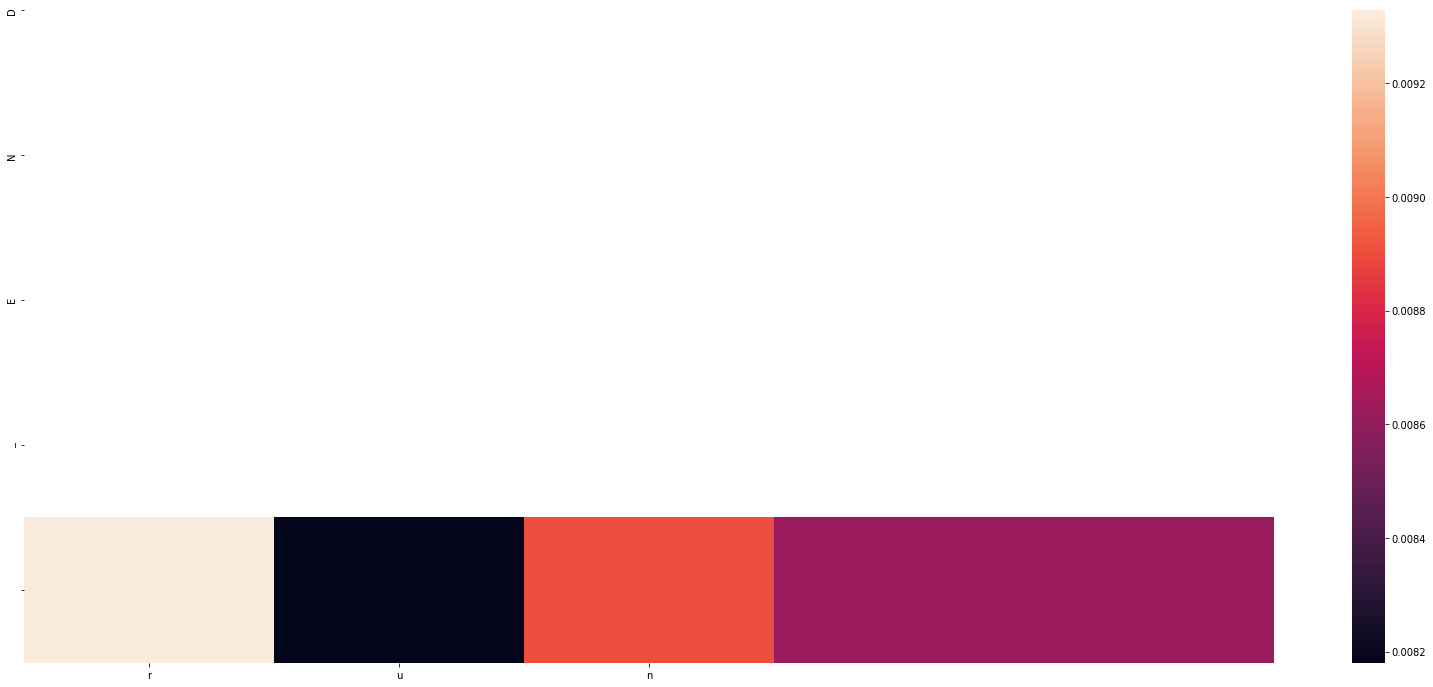

Decoded sentence:  _END
-
Input sentence: who
GT sentence: START_ qui  _END


<Figure size 432x288 with 0 Axes>

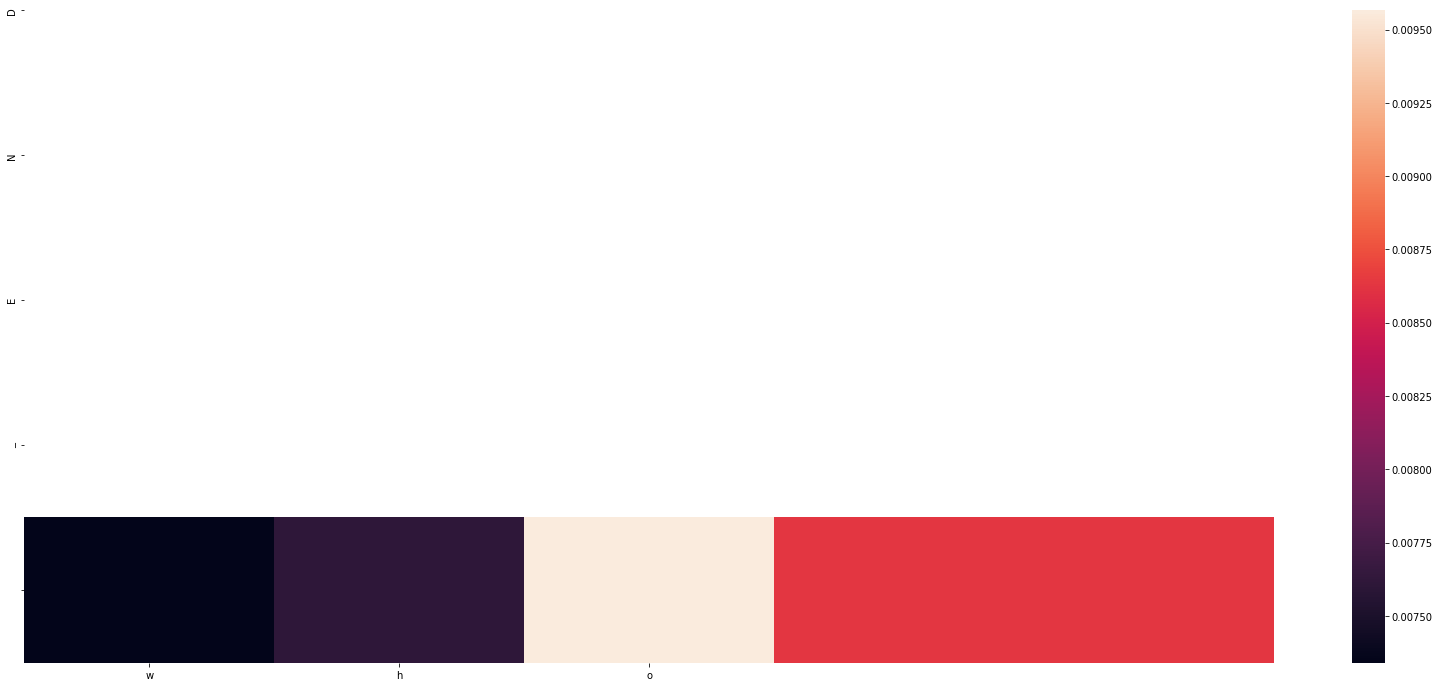

Decoded sentence:  _END
-
Input sentence: wow
GT sentence: START_ ça alors  _END


<Figure size 432x288 with 0 Axes>

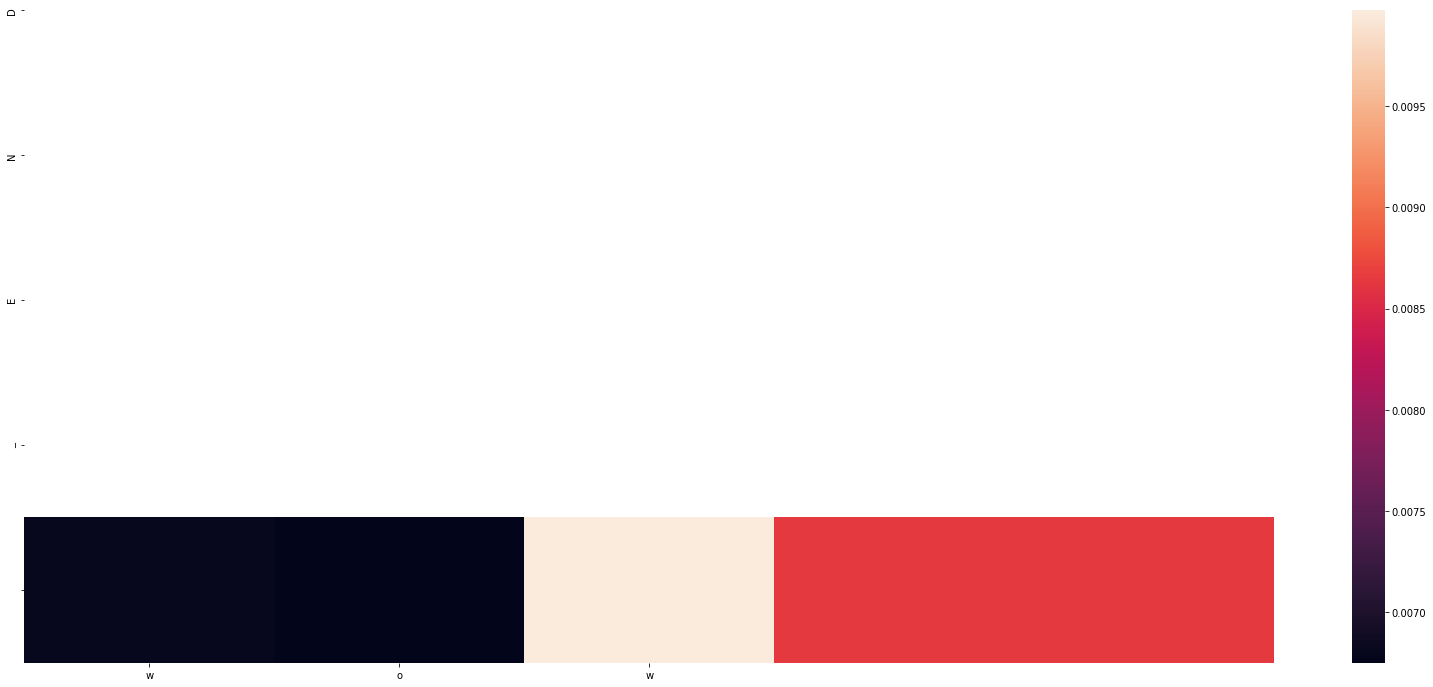

Decoded sentence:  _END
-
Input sentence: fire
GT sentence: START_ au feu  _END


<Figure size 432x288 with 0 Axes>

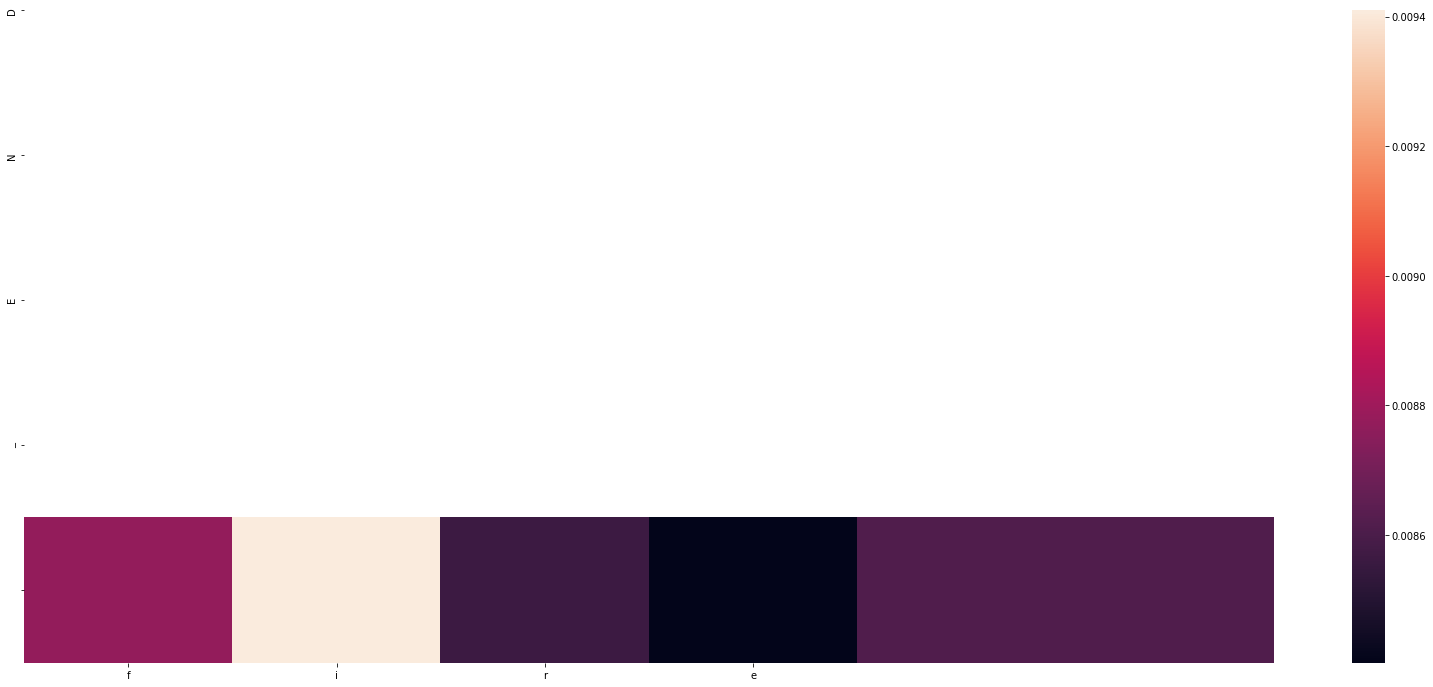

Decoded sentence:  _END
-
Input sentence: help
GT sentence: START_ à laide  _END


<Figure size 432x288 with 0 Axes>

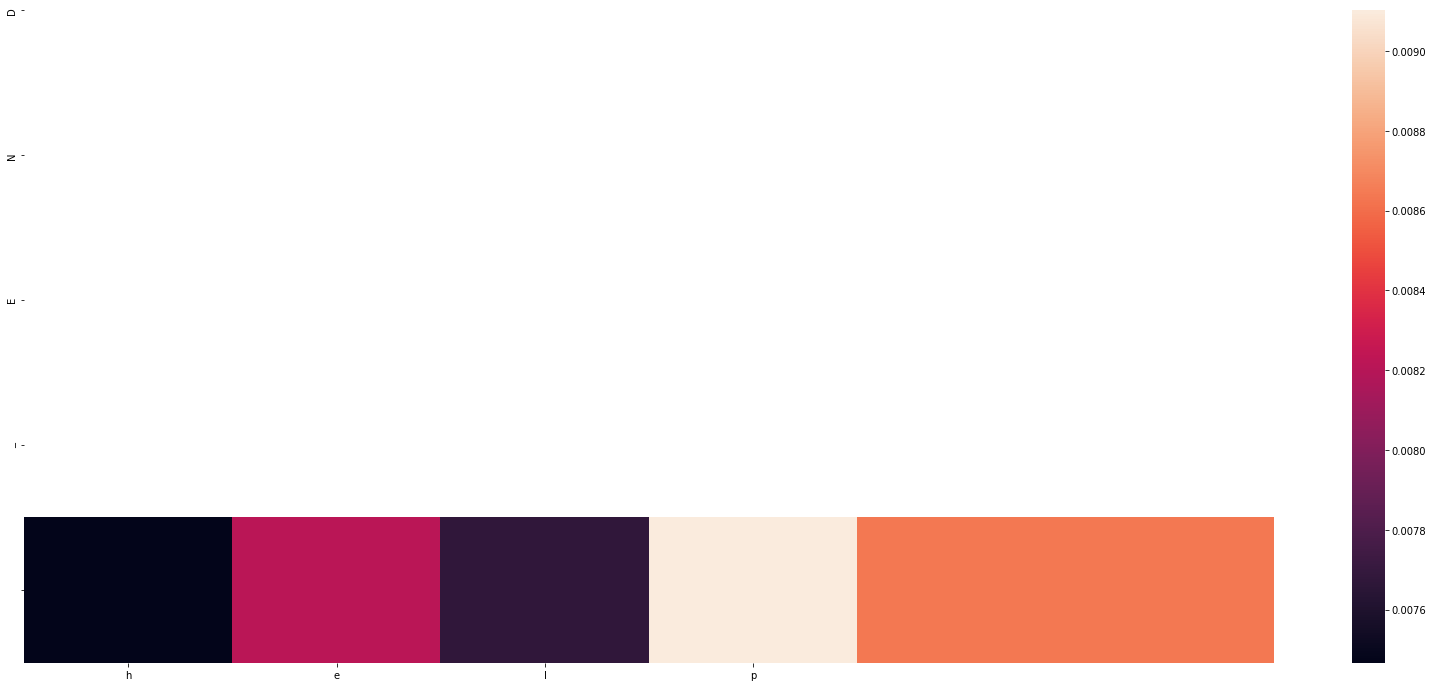

Decoded sentence:  _END
-
Input sentence: jump
GT sentence: START_ saute _END


<Figure size 432x288 with 0 Axes>

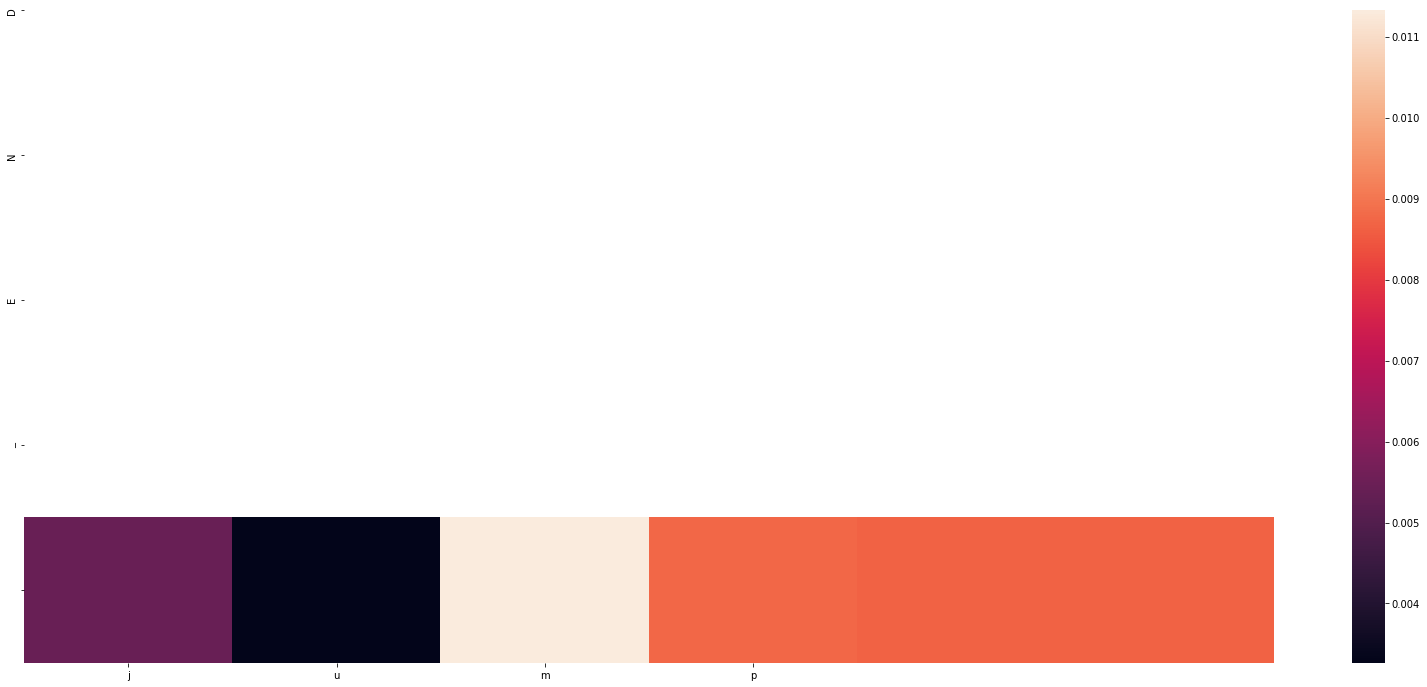

Decoded sentence:  _END
-
Input sentence: stop
GT sentence: START_ ça suffit  _END


<Figure size 432x288 with 0 Axes>

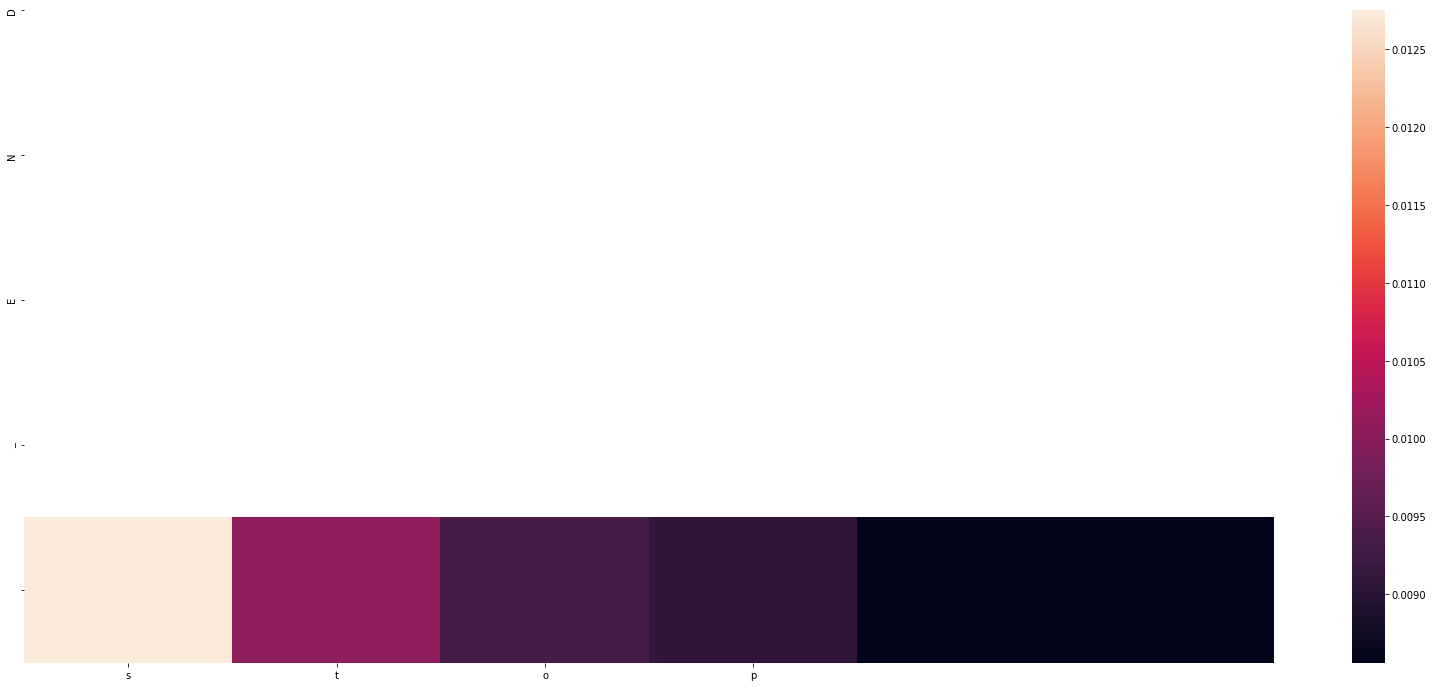

Decoded sentence:  _END
-
Input sentence: stop
GT sentence: START_ stop  _END


<Figure size 432x288 with 0 Axes>

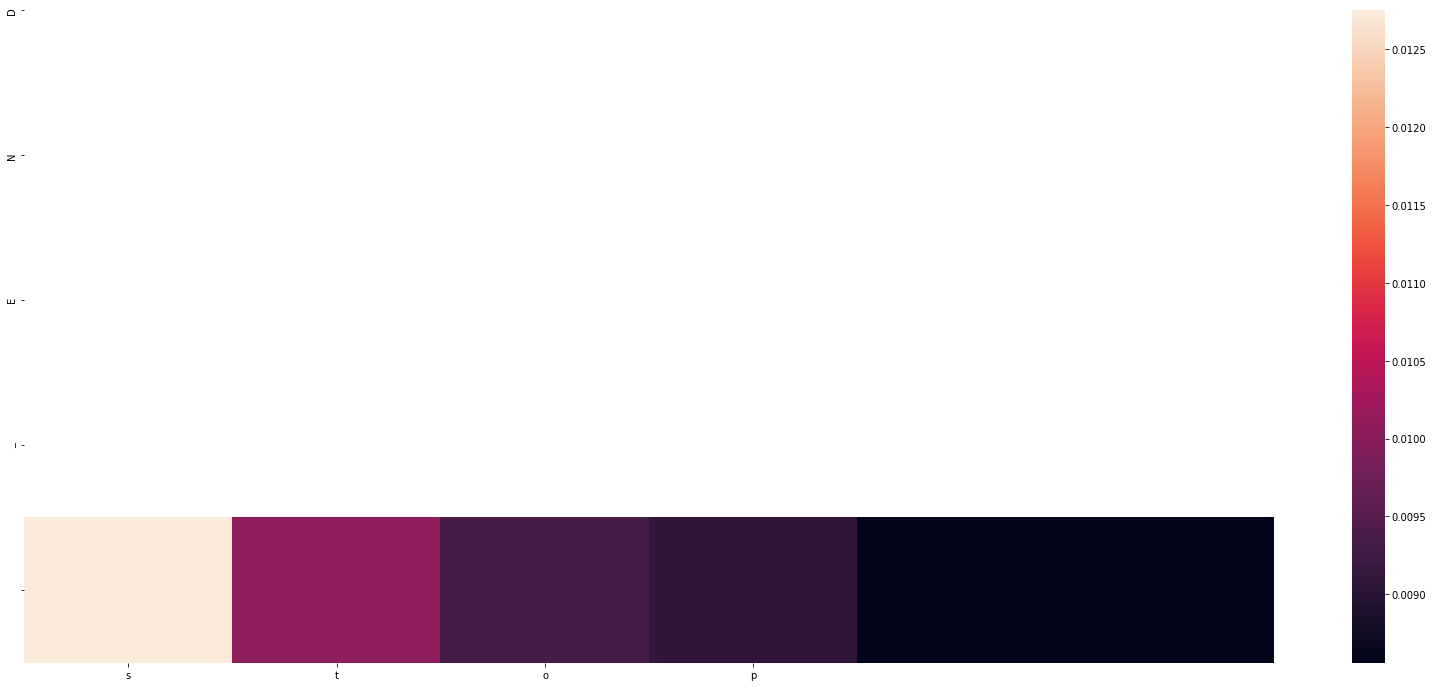

Decoded sentence:  _END
-
Input sentence: stop
GT sentence: START_ arrêtetoi  _END


<Figure size 432x288 with 0 Axes>

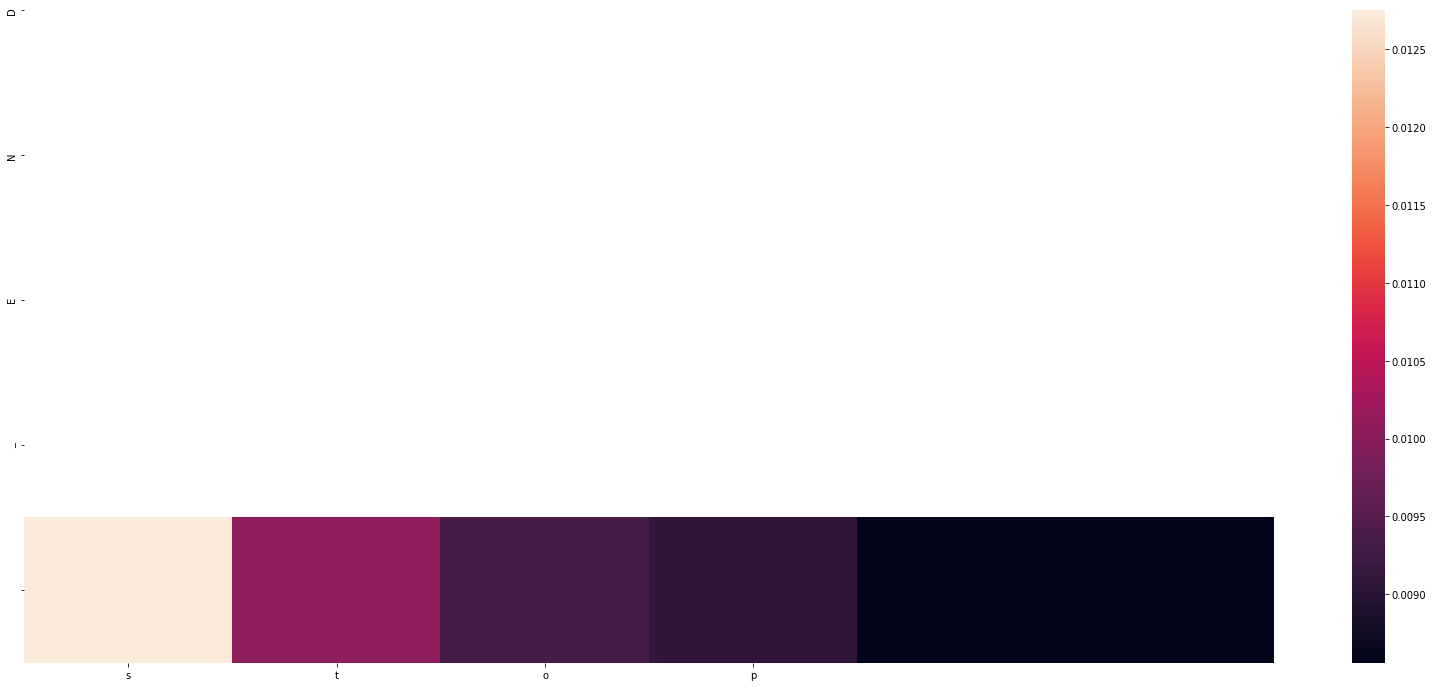

Decoded sentence:  _END
-
Input sentence: wait
GT sentence: START_ attends  _END


<Figure size 432x288 with 0 Axes>

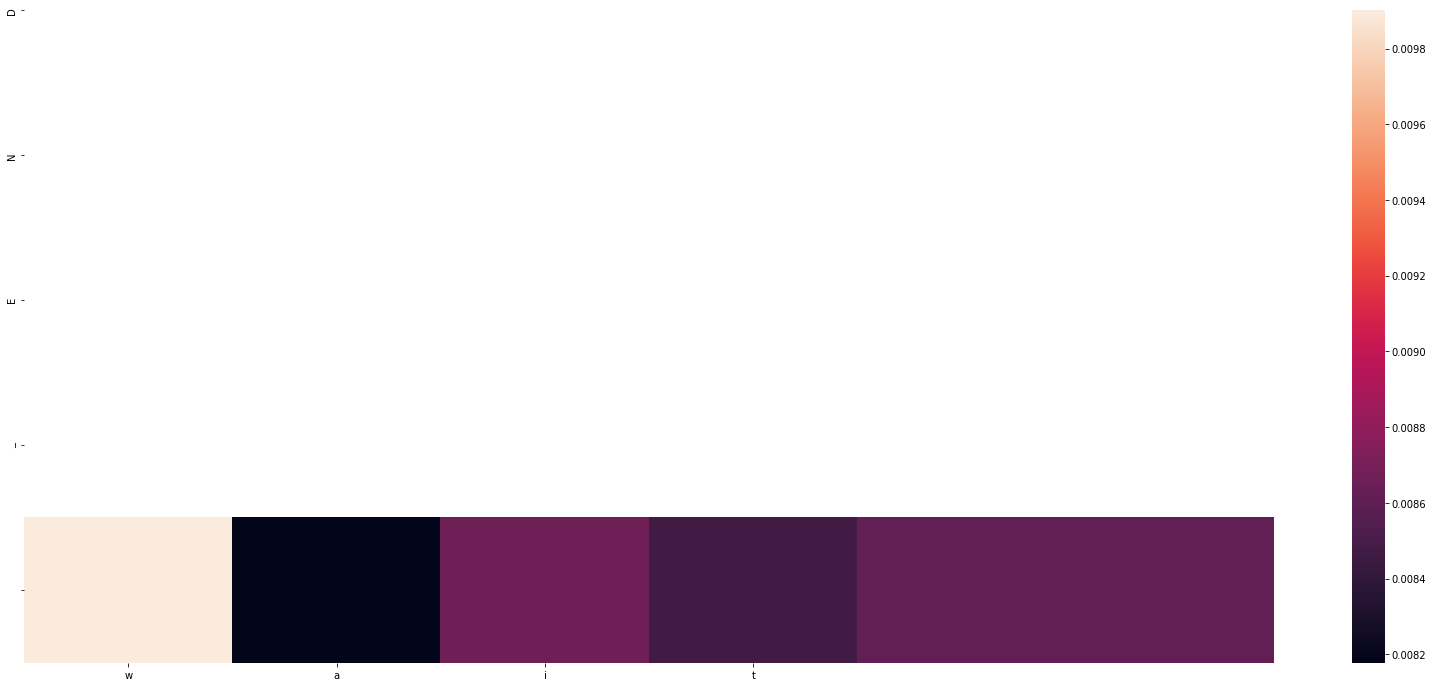

Decoded sentence:  _END
-
Input sentence: wait
GT sentence: START_ attendez  _END


<Figure size 432x288 with 0 Axes>

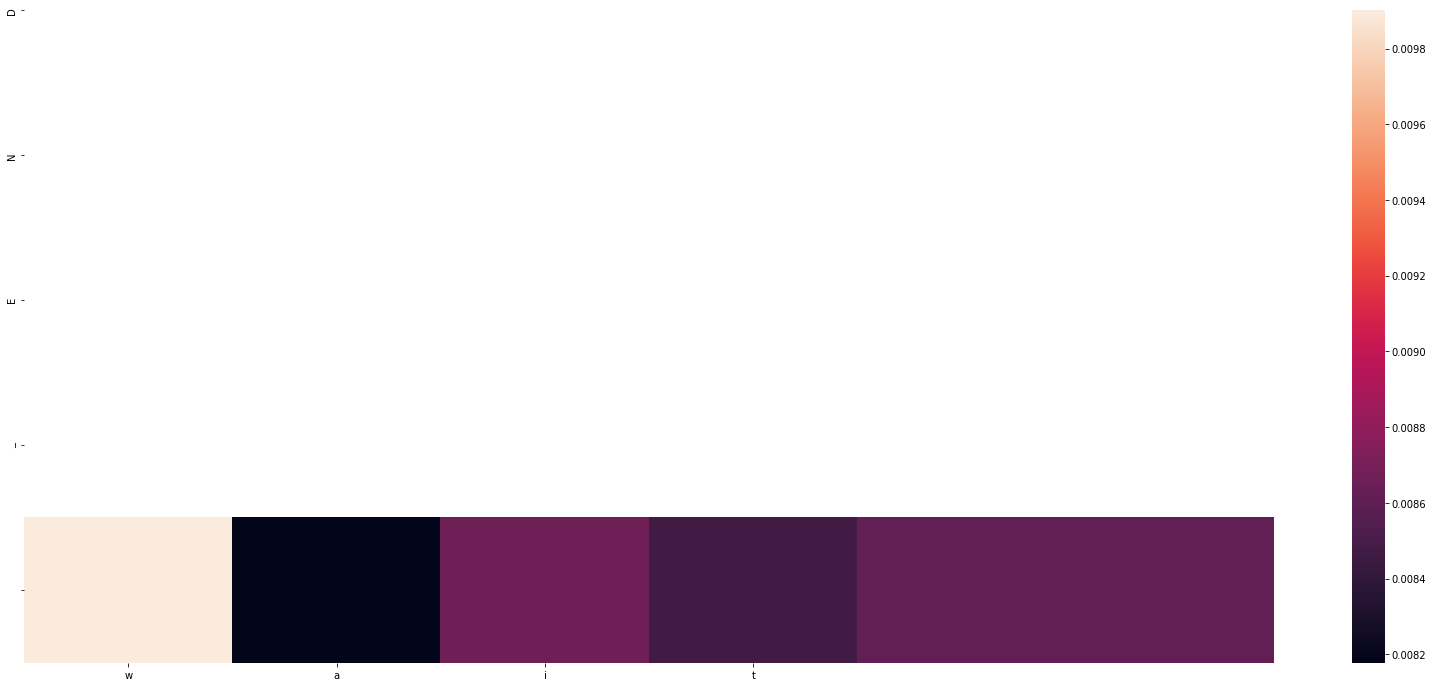

Decoded sentence:  _END
-
Input sentence: go on
GT sentence: START_ poursuis _END


<Figure size 432x288 with 0 Axes>

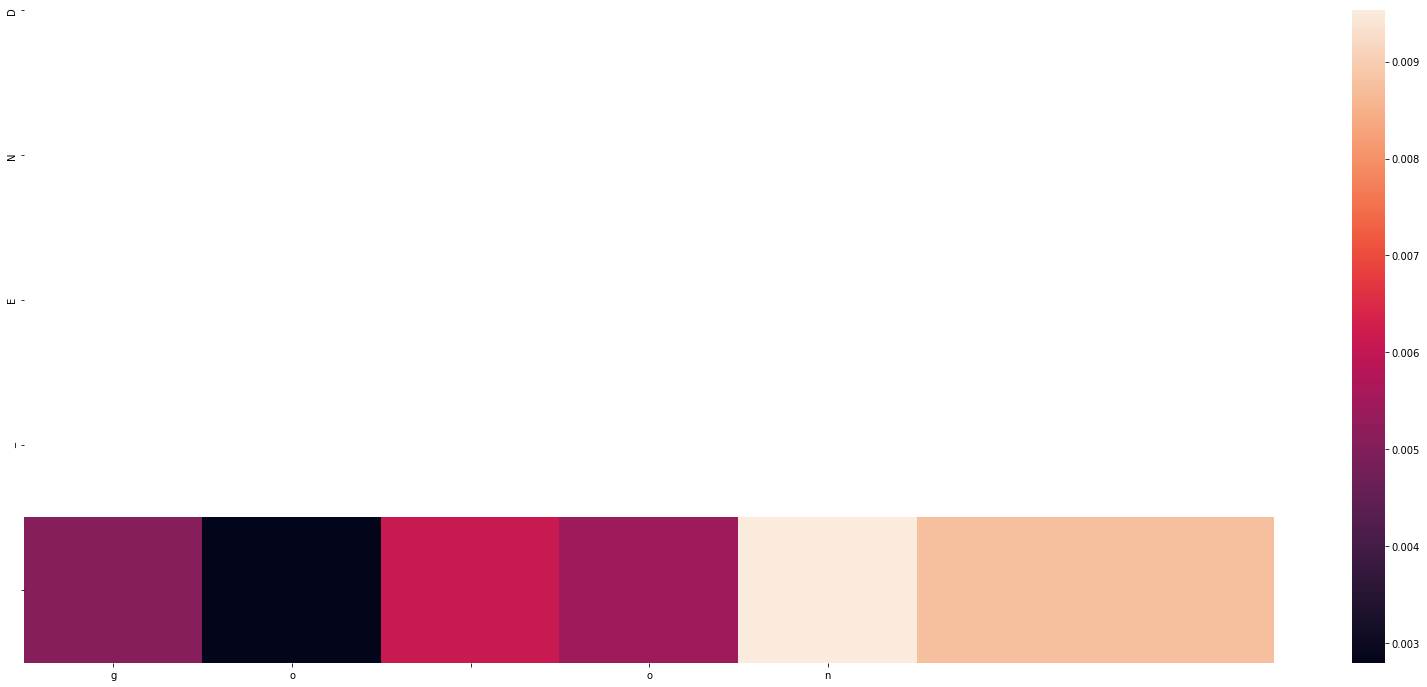

Decoded sentence:  _END
-
Input sentence: go on
GT sentence: START_ continuez _END


<Figure size 432x288 with 0 Axes>

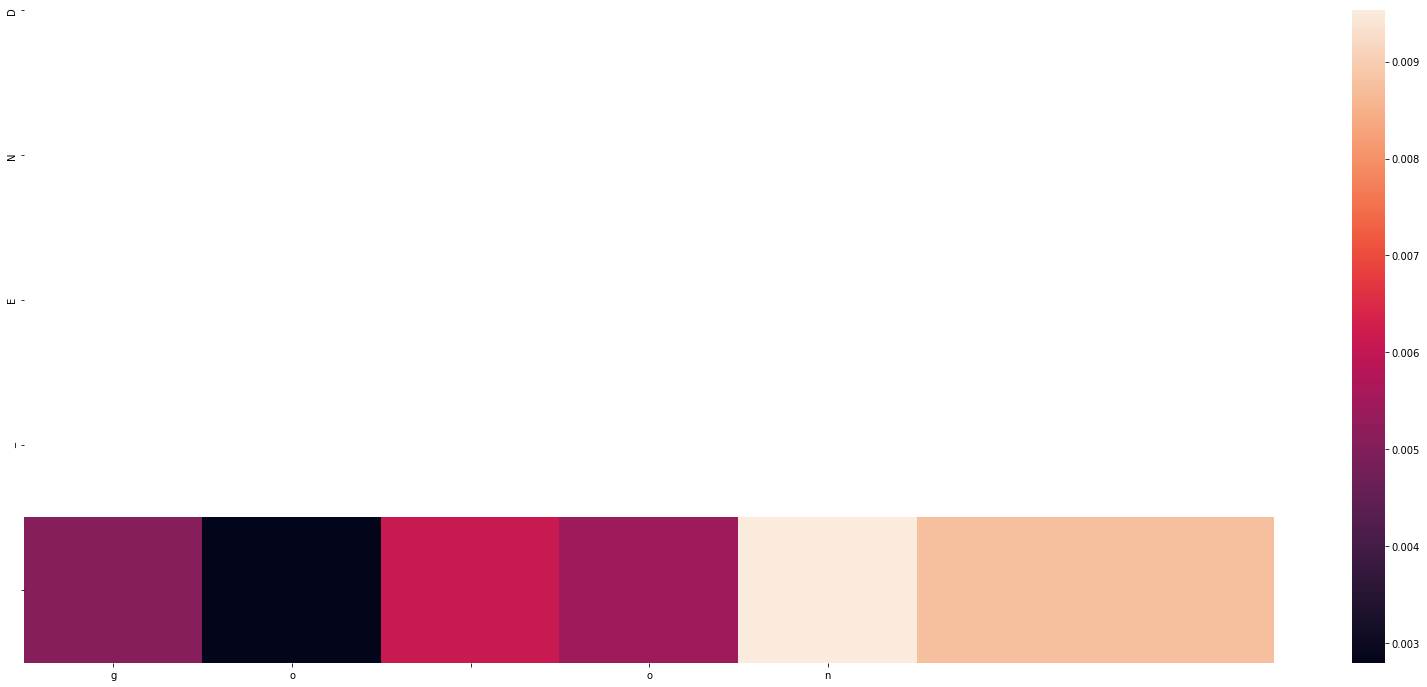

Decoded sentence:  _END
-
Input sentence: go on
GT sentence: START_ poursuivez _END


<Figure size 432x288 with 0 Axes>

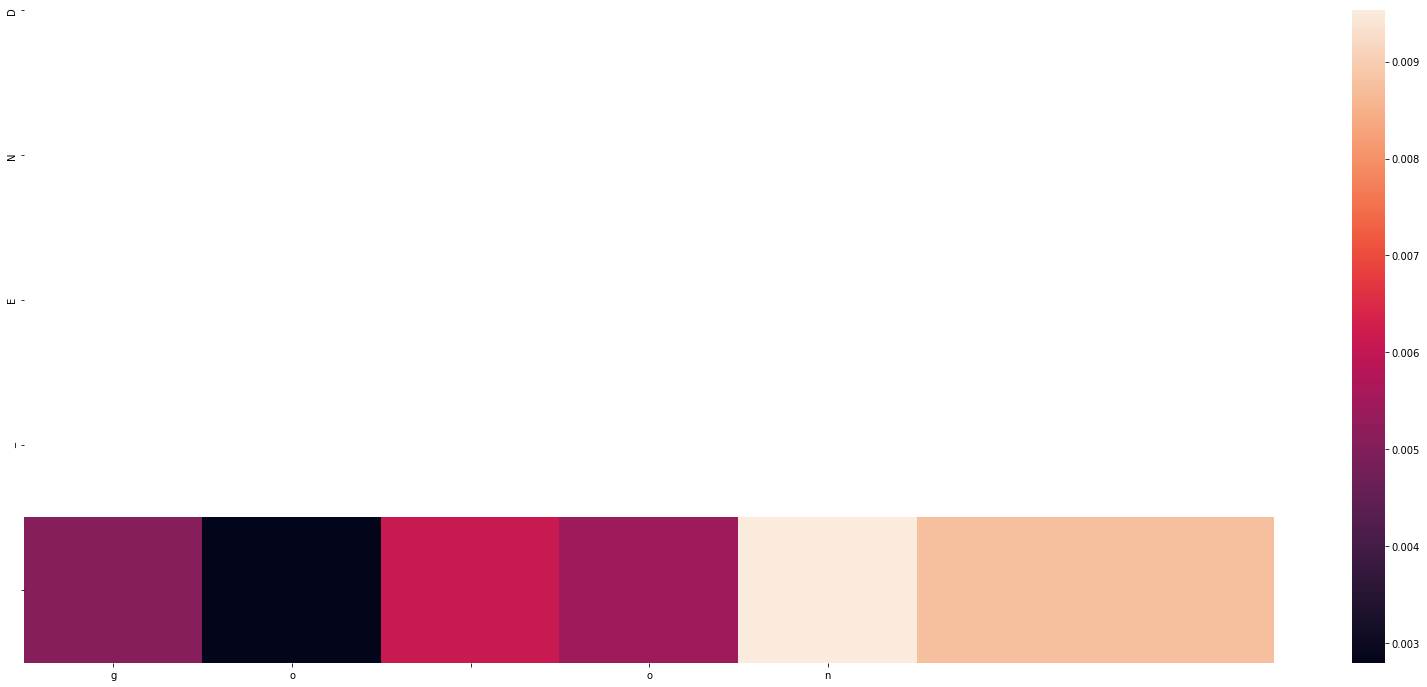

Decoded sentence:  _END
-
Input sentence: hello
GT sentence: START_ bonjour  _END


<Figure size 432x288 with 0 Axes>

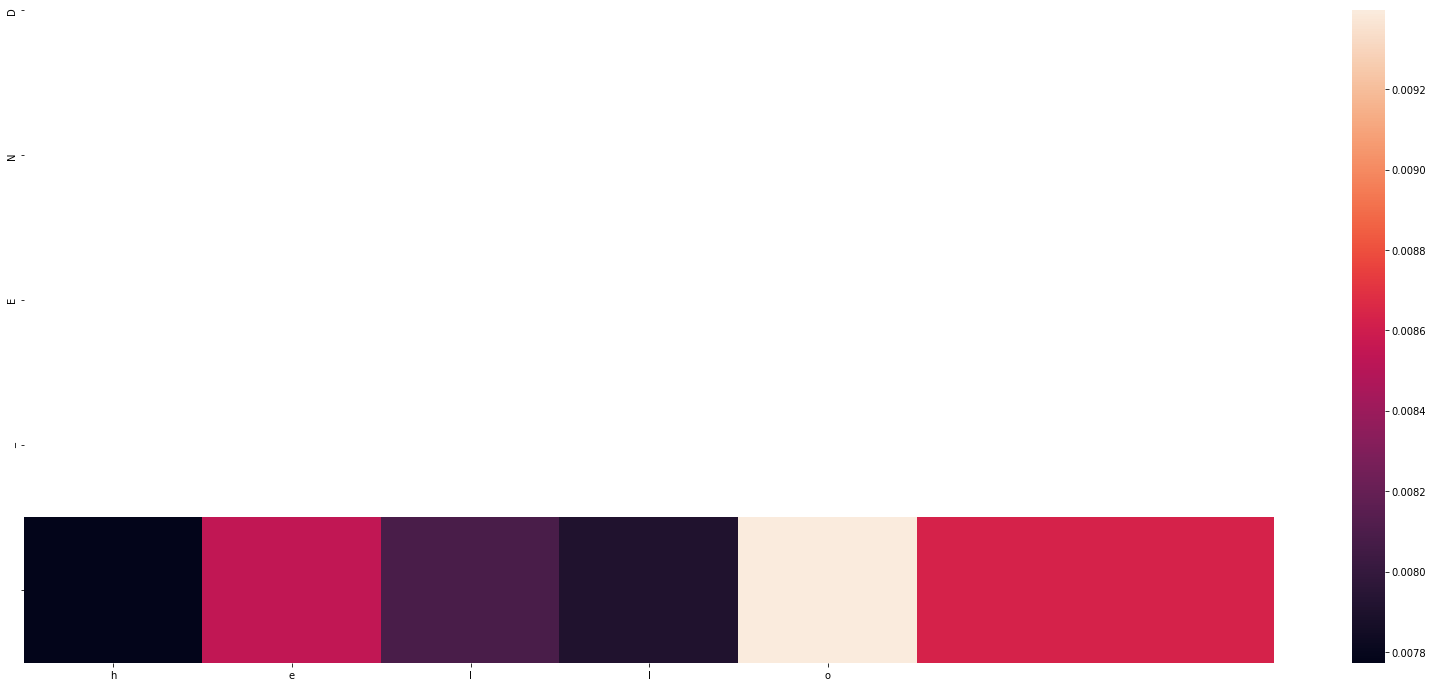

Decoded sentence:  _END
-
Input sentence: hello
GT sentence: START_ salut  _END


<Figure size 432x288 with 0 Axes>

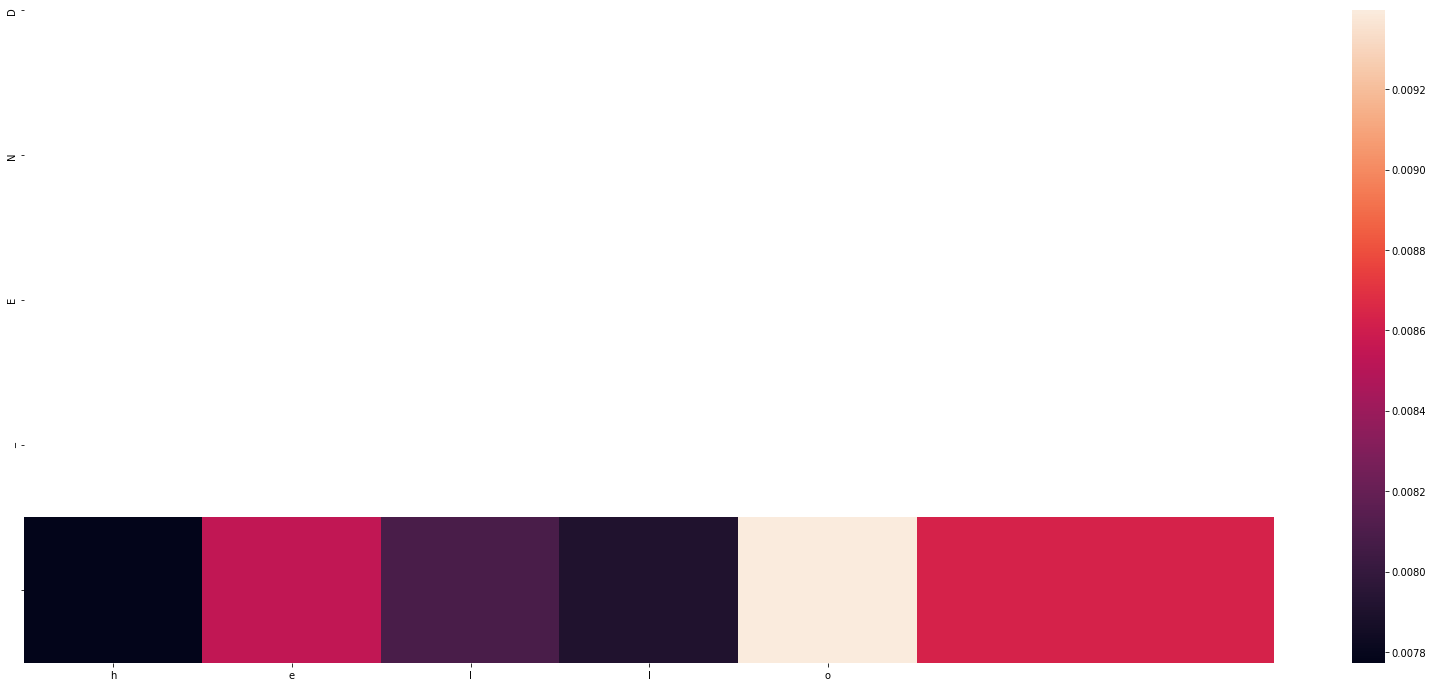

Decoded sentence:  _END
-
Input sentence: i see
GT sentence: START_ je comprends _END


<Figure size 432x288 with 0 Axes>

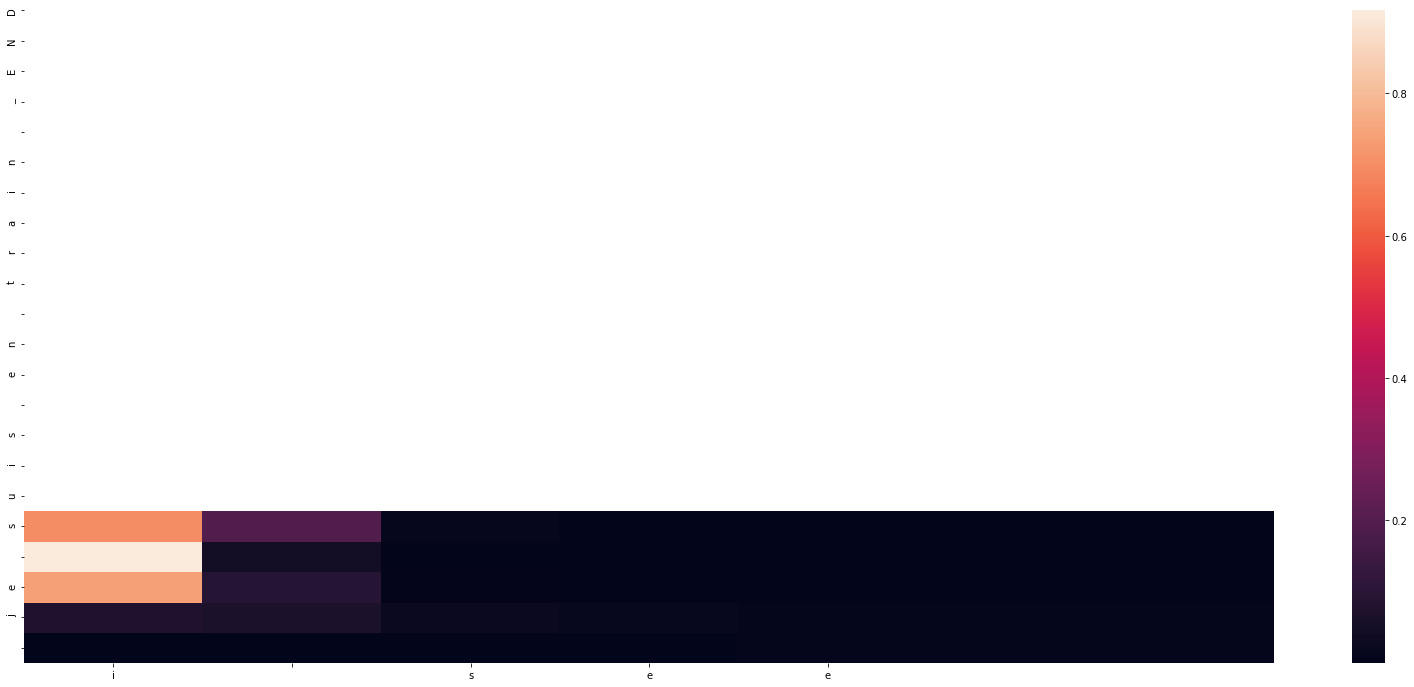

Decoded sentence:  je suis en train _END
-
Input sentence: i try
GT sentence: START_ jessaye _END


<Figure size 432x288 with 0 Axes>

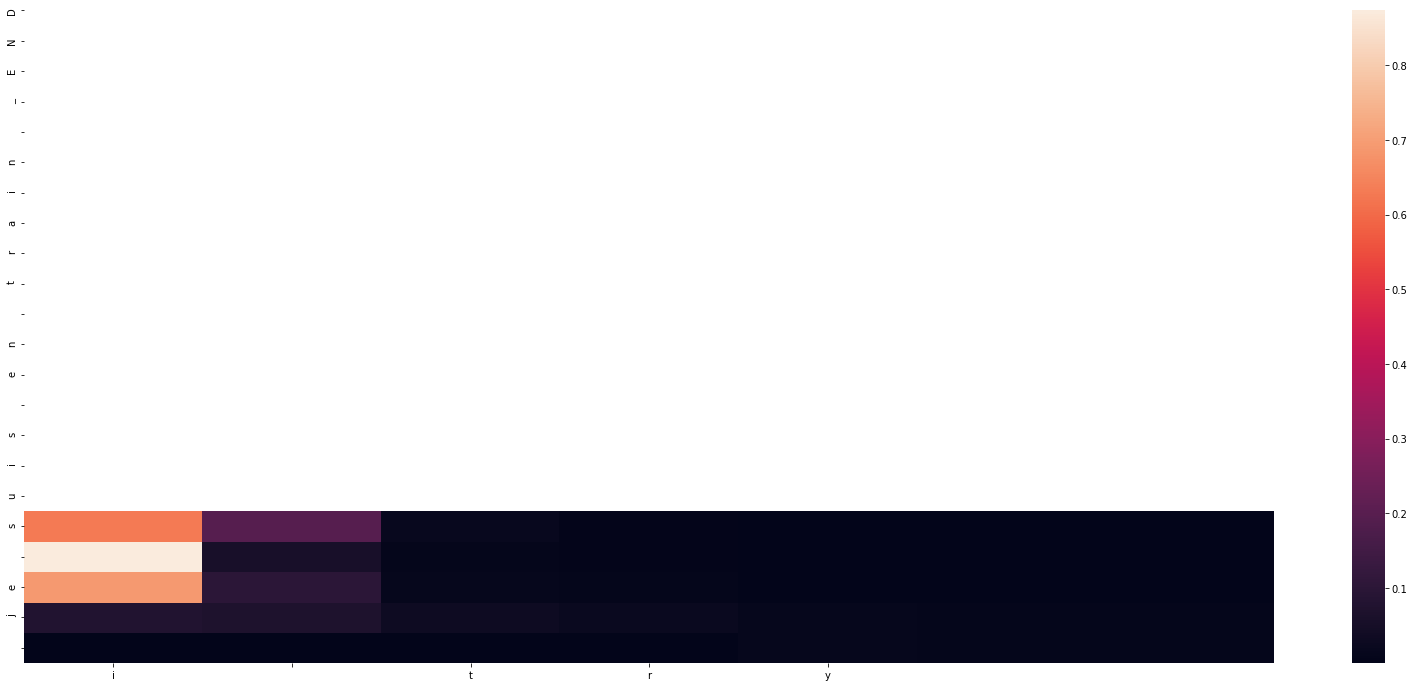

Decoded sentence:  je suis en train _END
-
Input sentence: i won
GT sentence: START_ jai gagné  _END


<Figure size 432x288 with 0 Axes>

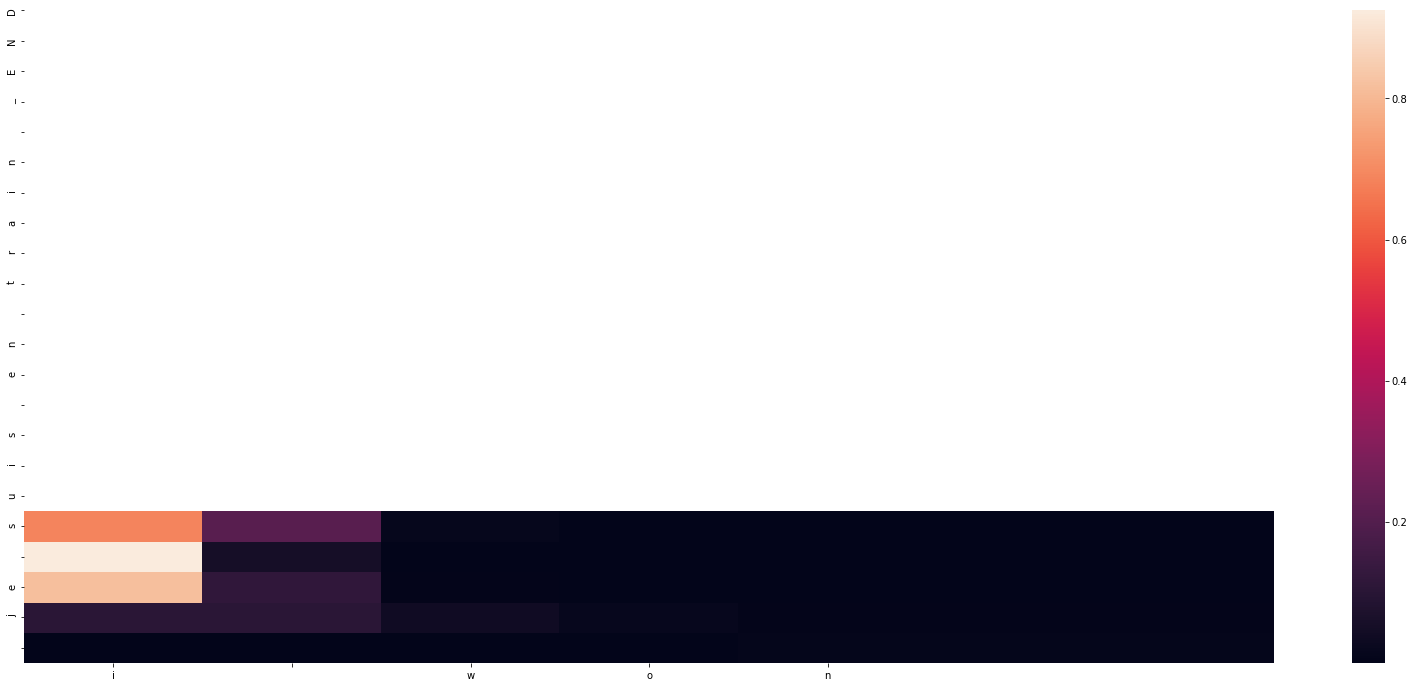

Decoded sentence:  je suis en train _END
-
Input sentence: i won
GT sentence: START_ je lai emporté  _END


<Figure size 432x288 with 0 Axes>

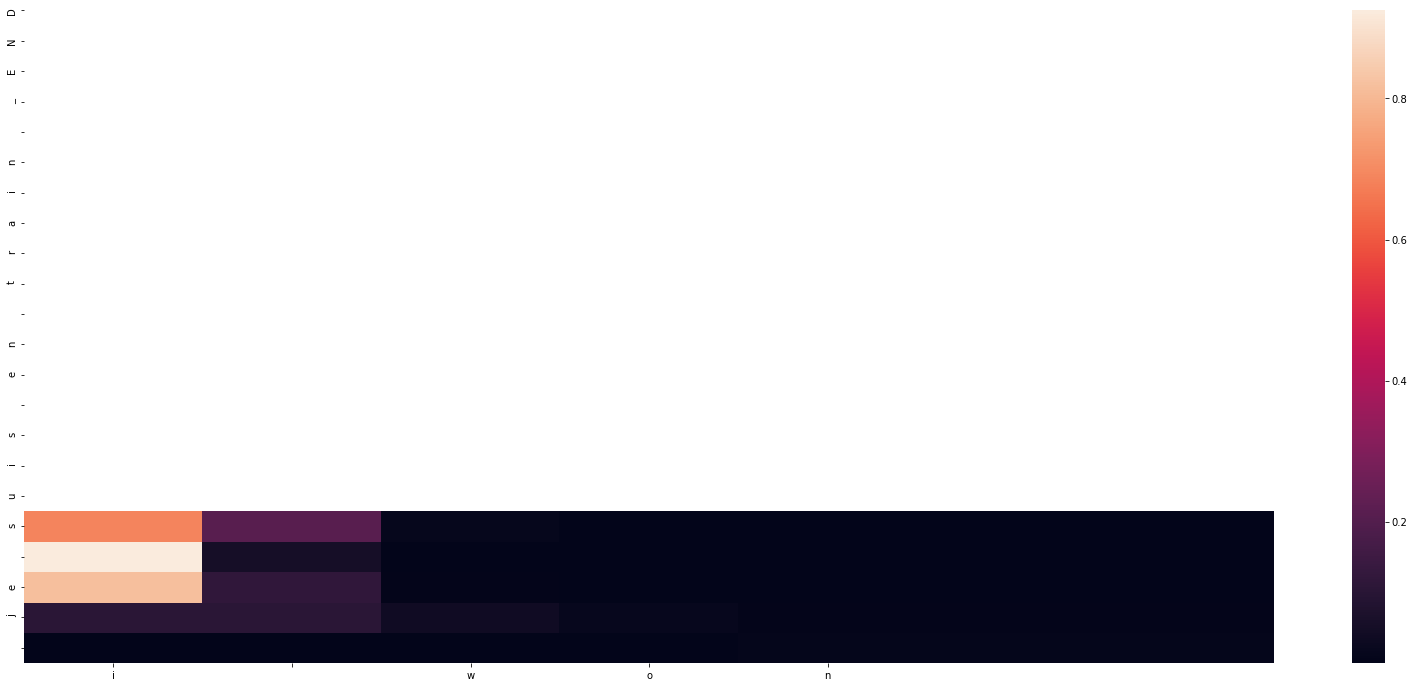

Decoded sentence:  je suis en train _END
-
Input sentence: i won
GT sentence: START_ j’ai gagné _END


<Figure size 432x288 with 0 Axes>

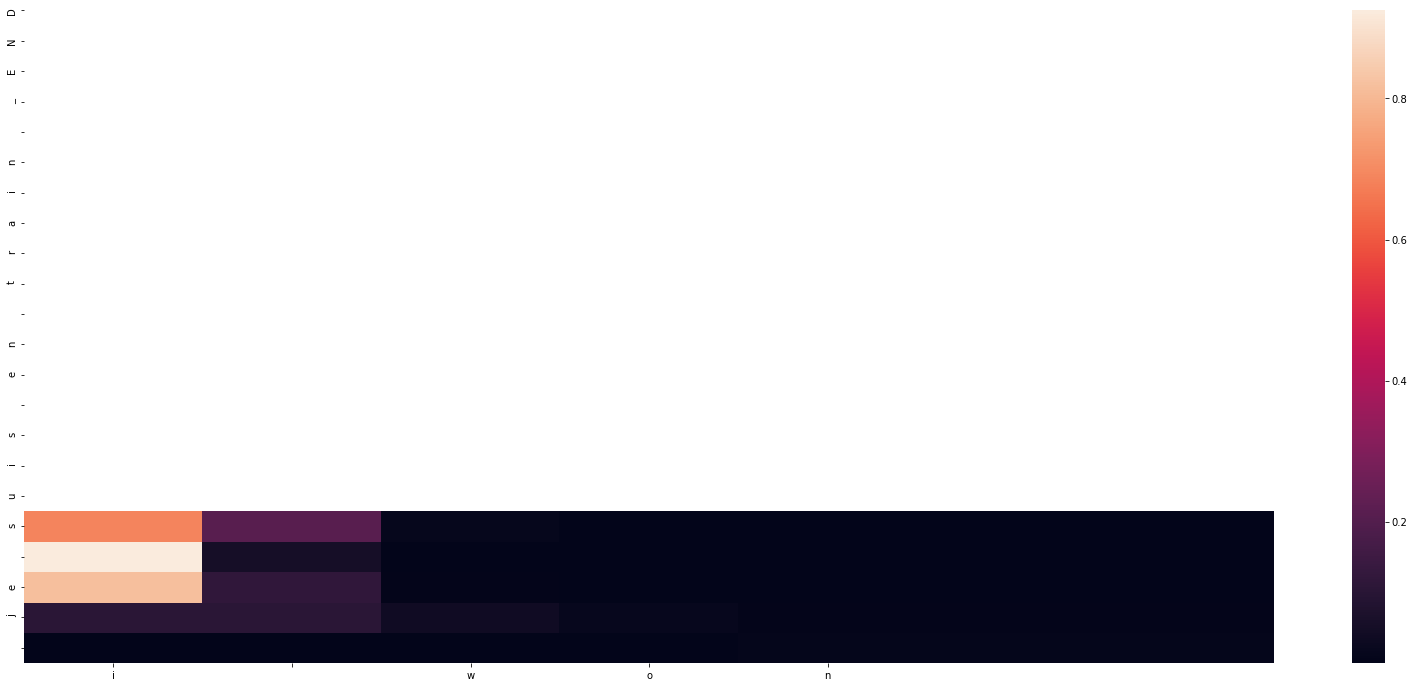

Decoded sentence:  je suis en train _END
-
Input sentence: oh no
GT sentence: START_ oh non  _END


<Figure size 432x288 with 0 Axes>

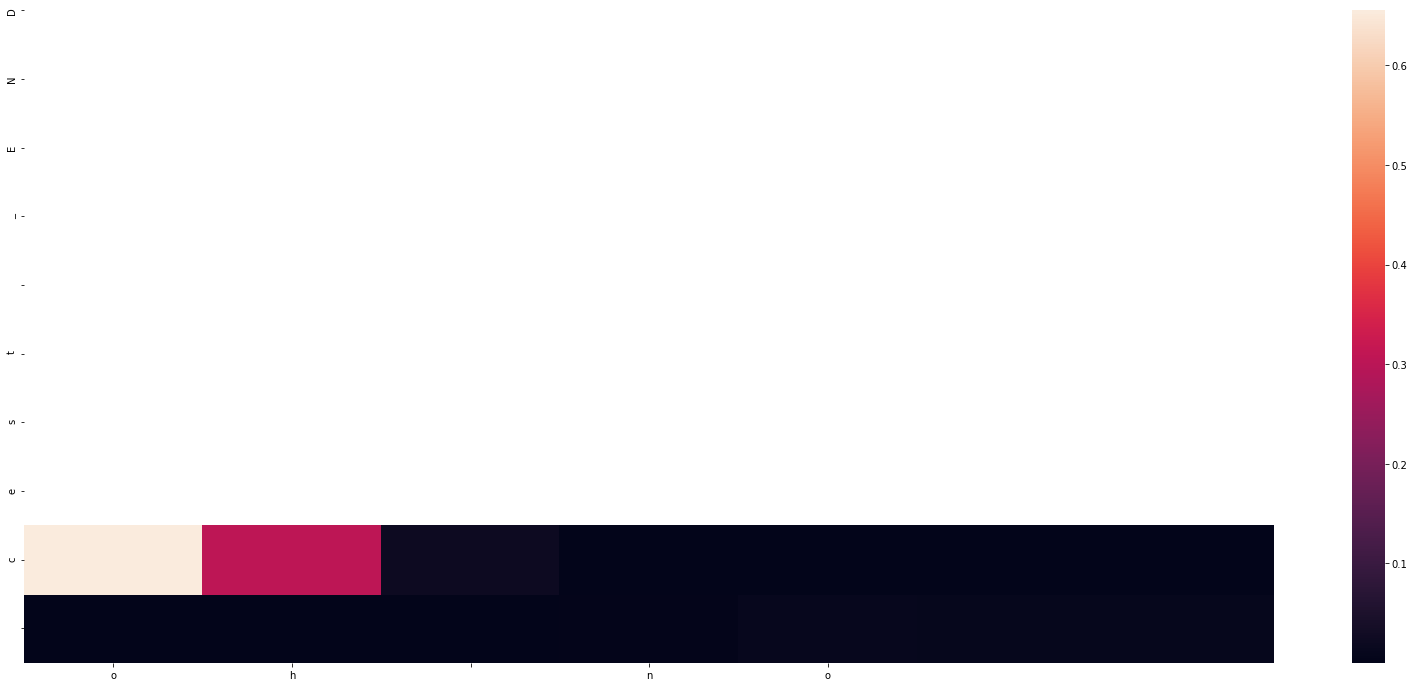

Decoded sentence:  cest _END
-
Input sentence: attack
GT sentence: START_ attaque  _END


<Figure size 432x288 with 0 Axes>

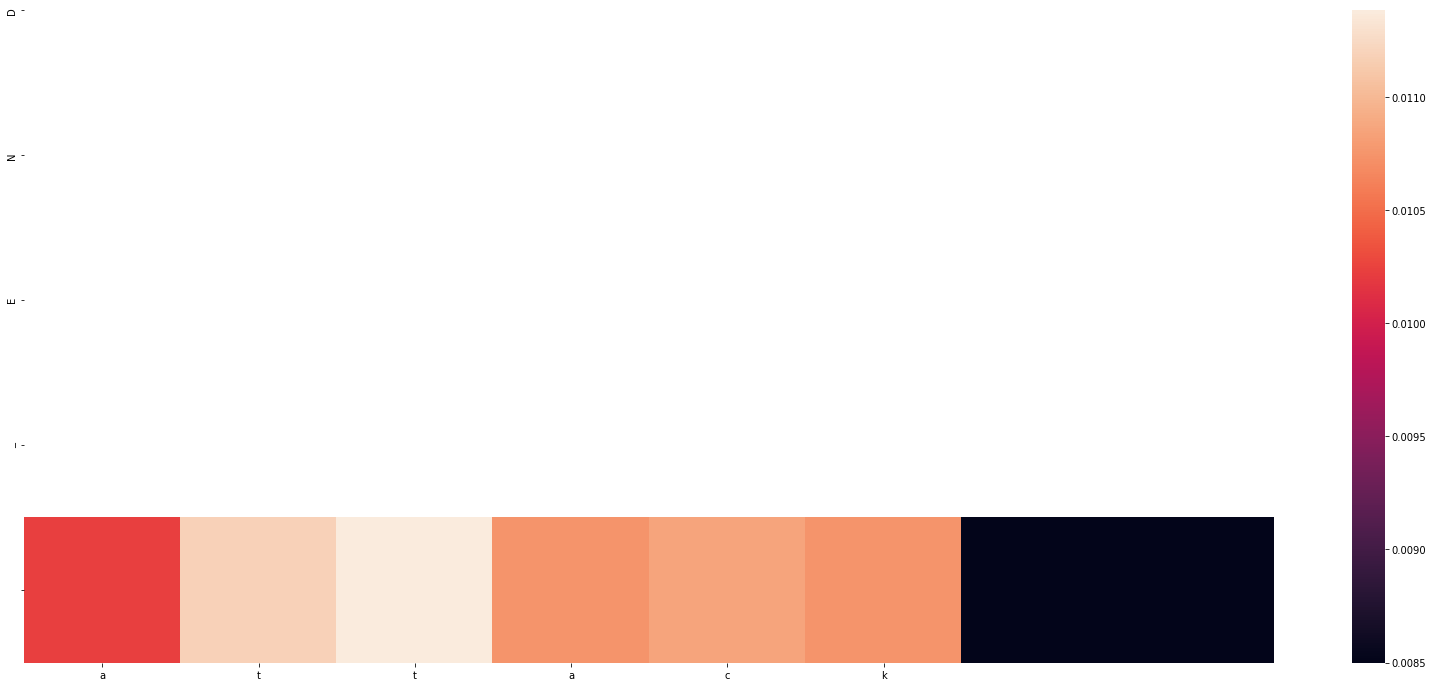

Decoded sentence:  _END
-
Input sentence: attack
GT sentence: START_ attaquez  _END


<Figure size 432x288 with 0 Axes>

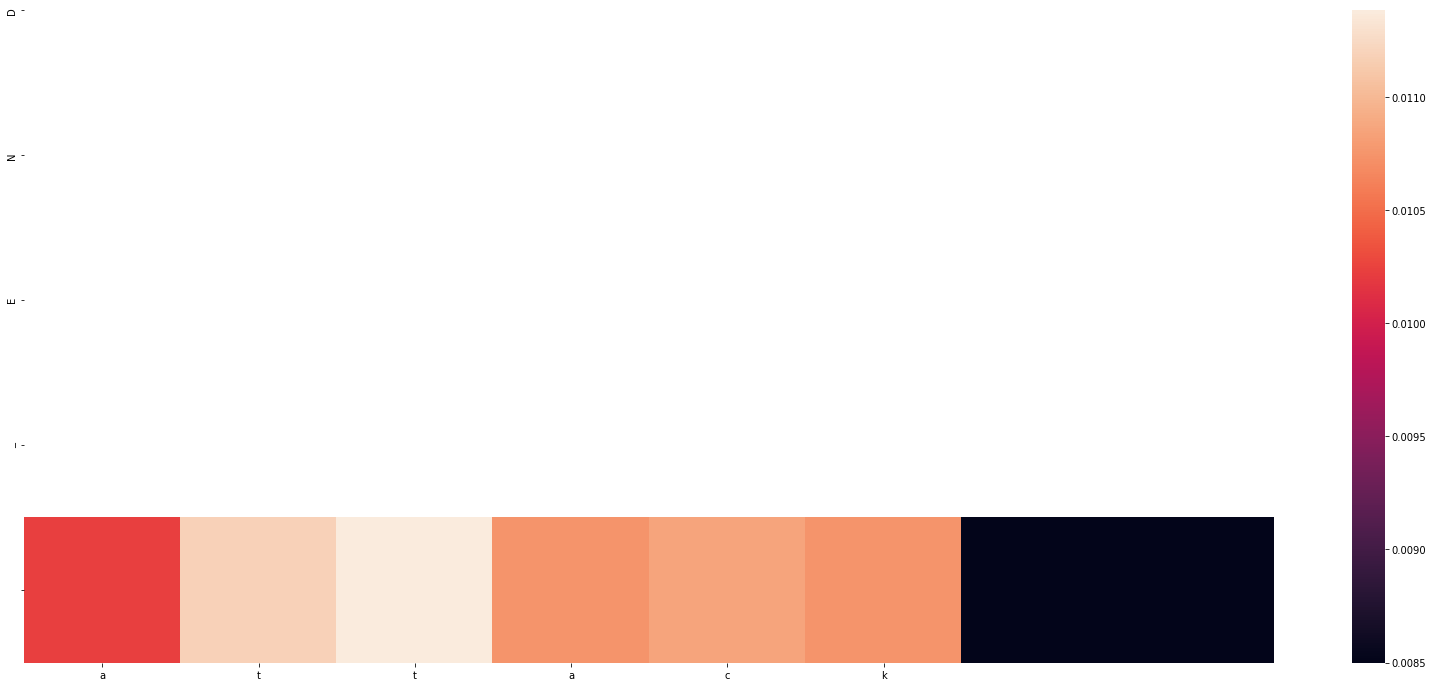

Decoded sentence:  _END
-
Input sentence: cheers
GT sentence: START_ santé  _END


<Figure size 432x288 with 0 Axes>

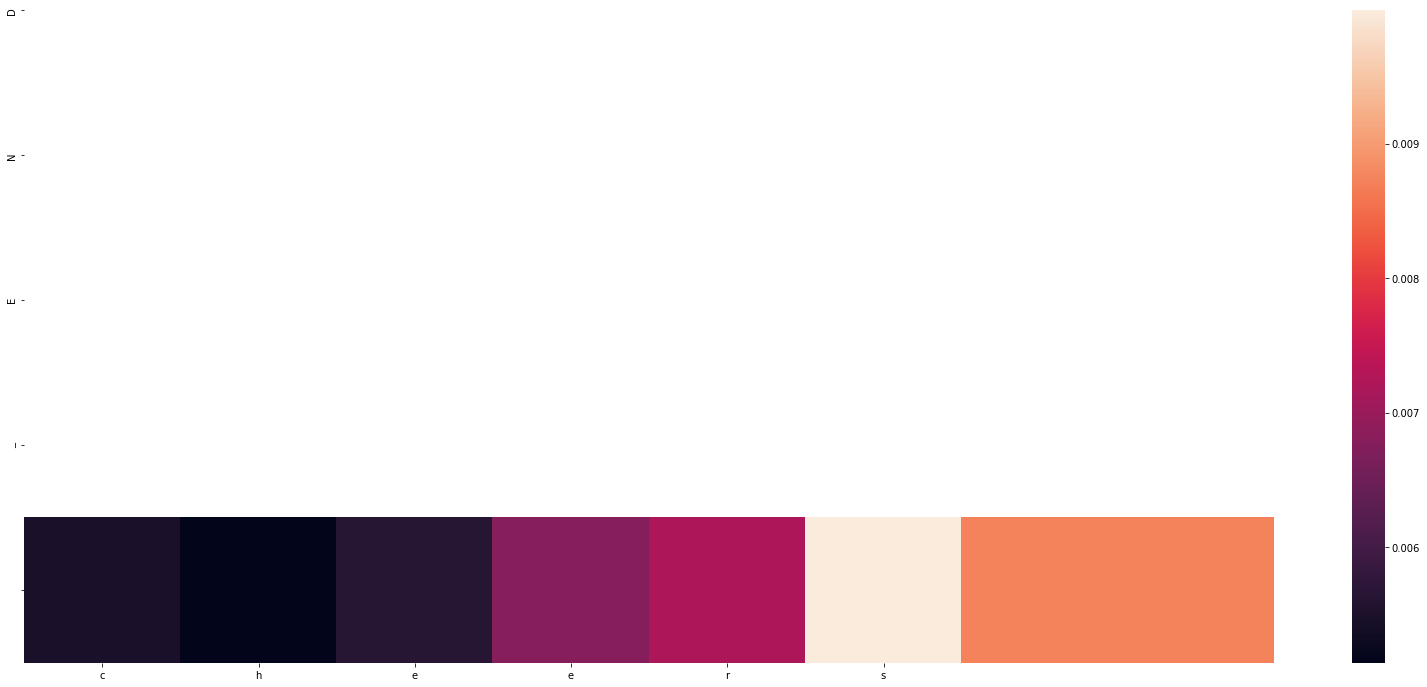

Decoded sentence:  _END
-
Input sentence: cheers
GT sentence: START_ à votre santé  _END


<Figure size 432x288 with 0 Axes>

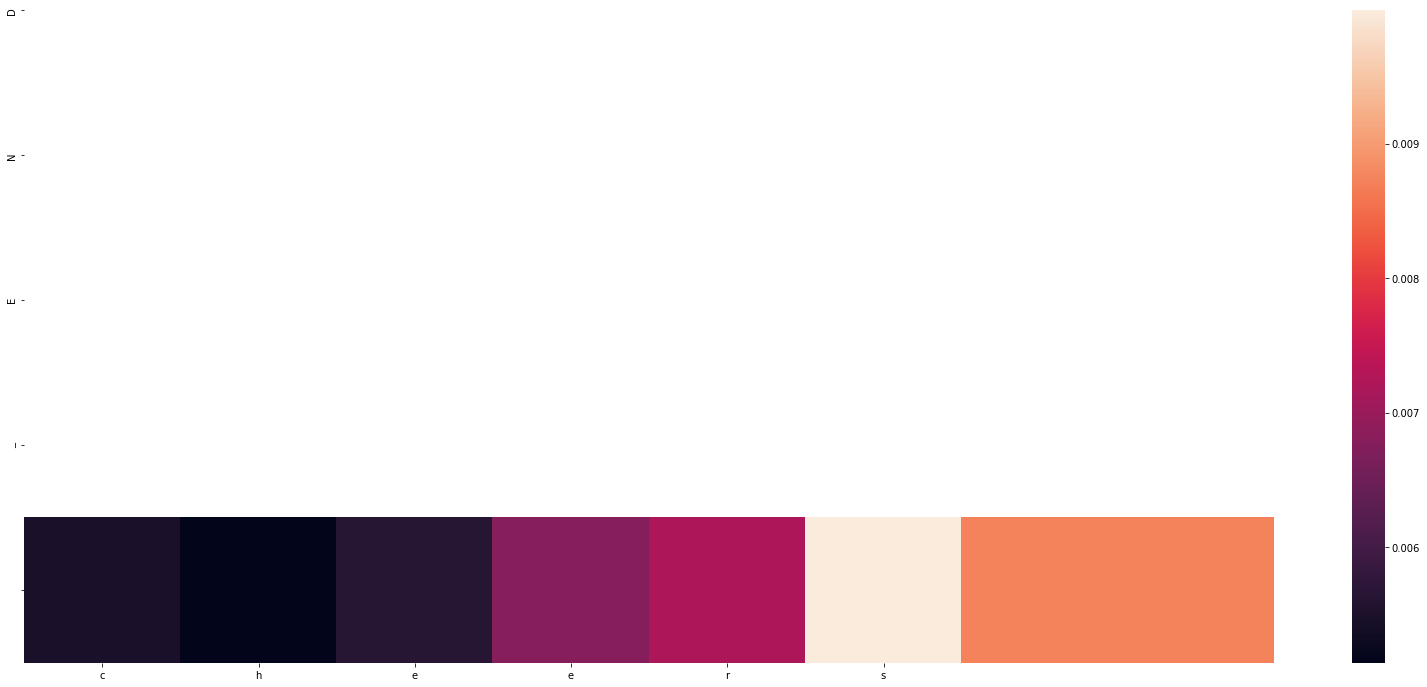

Decoded sentence:  _END
-
Input sentence: cheers
GT sentence: START_ merci  _END


<Figure size 432x288 with 0 Axes>

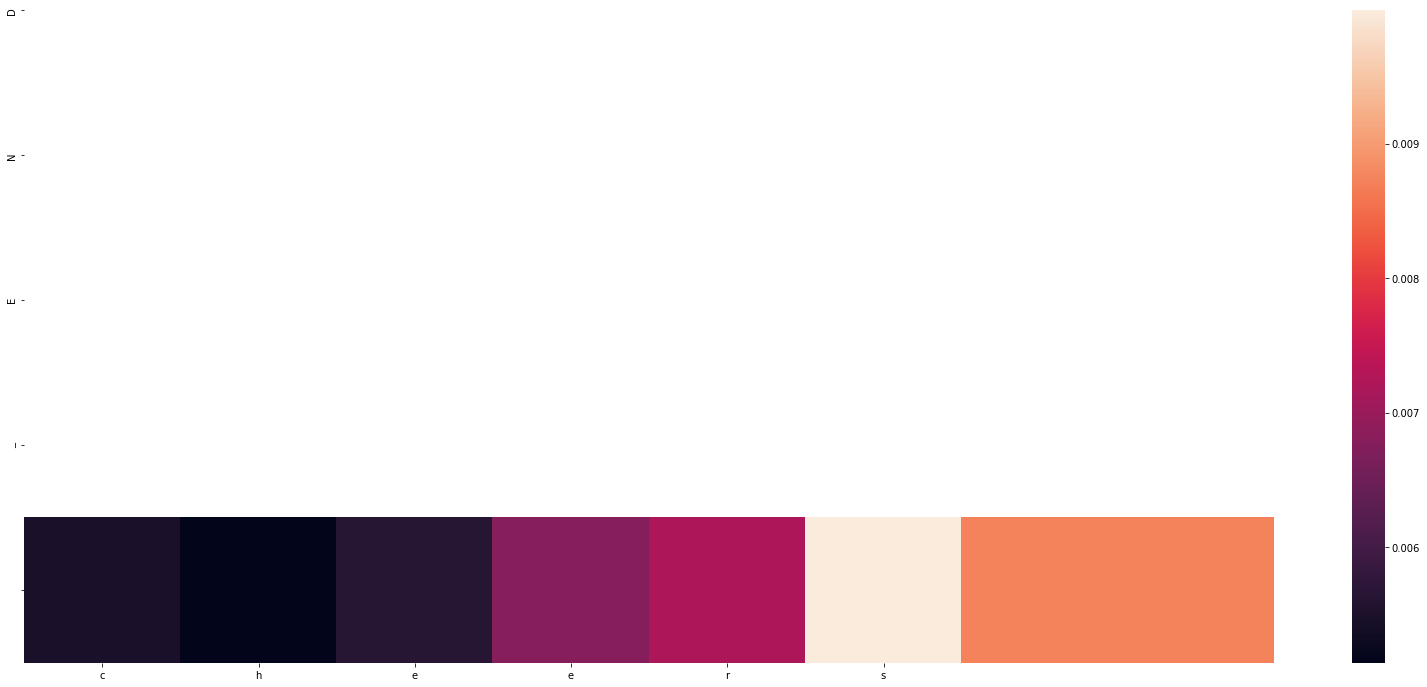

Decoded sentence:  _END
-
Input sentence: cheers
GT sentence: START_ tchintchin  _END


<Figure size 432x288 with 0 Axes>

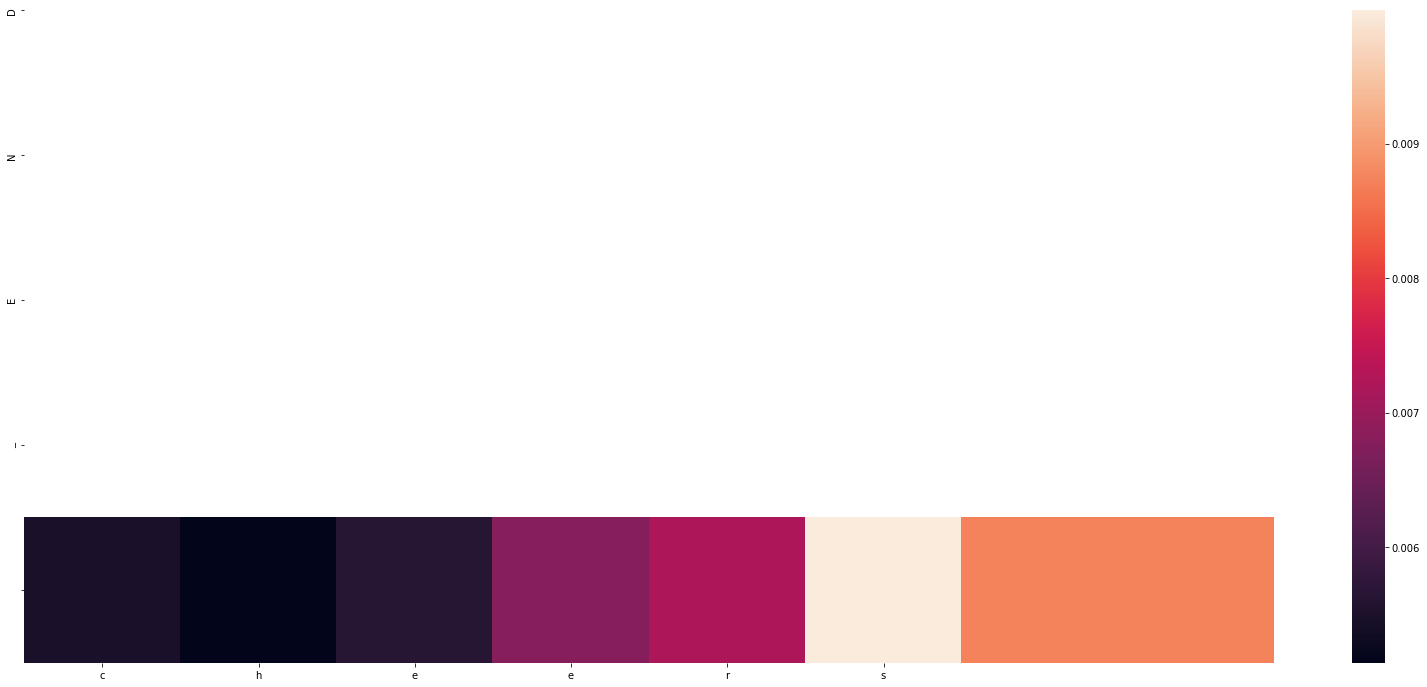

Decoded sentence:  _END
-
Input sentence: get up
GT sentence: START_ lèvetoi _END


<Figure size 432x288 with 0 Axes>

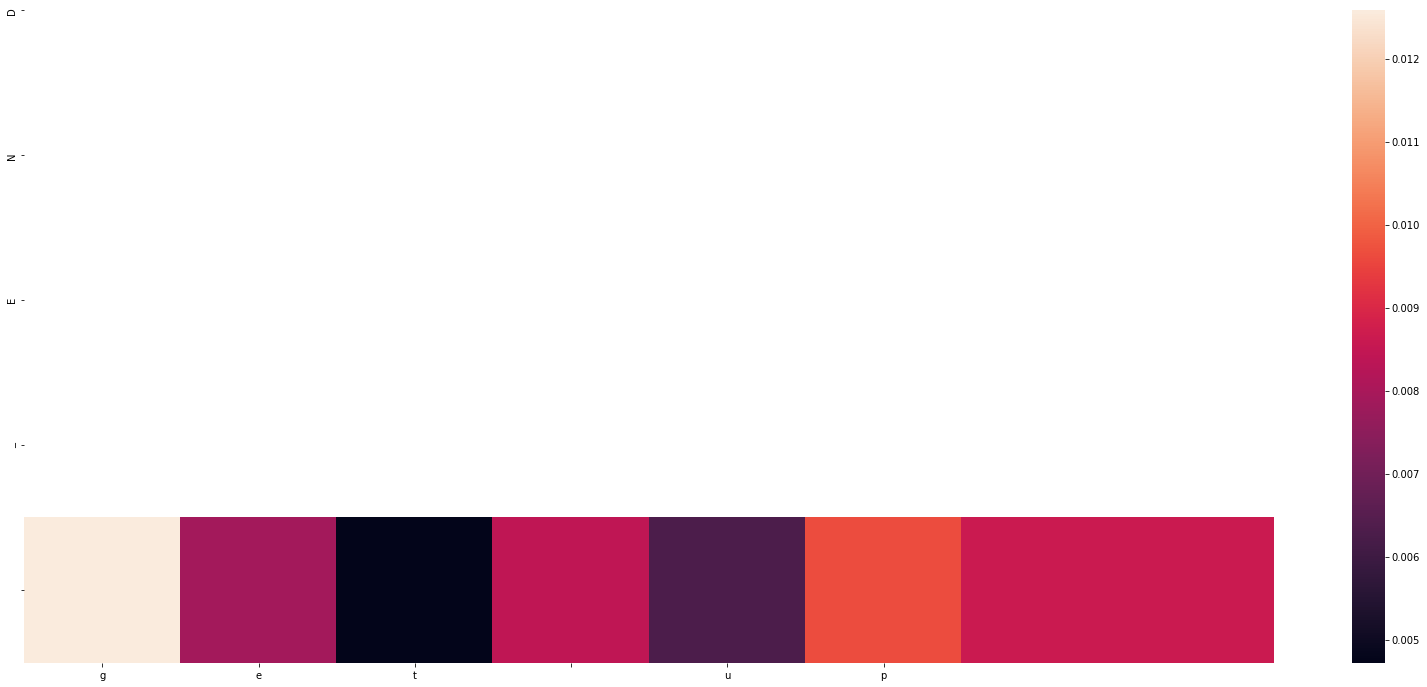

Decoded sentence:  _END
-
Input sentence: go now
GT sentence: START_ va COMMA maintenant _END


<Figure size 432x288 with 0 Axes>

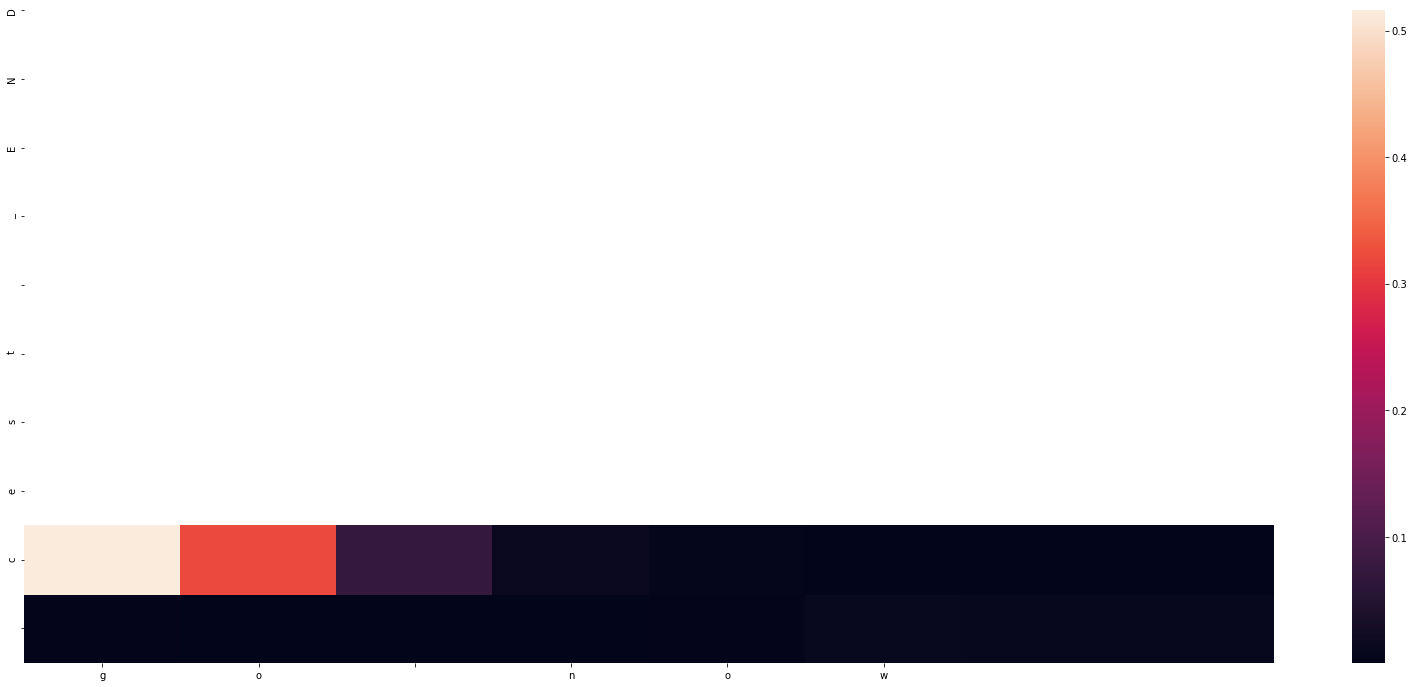

Decoded sentence:  cest _END
-
Input sentence: go now
GT sentence: START_ allezy maintenant _END


<Figure size 432x288 with 0 Axes>

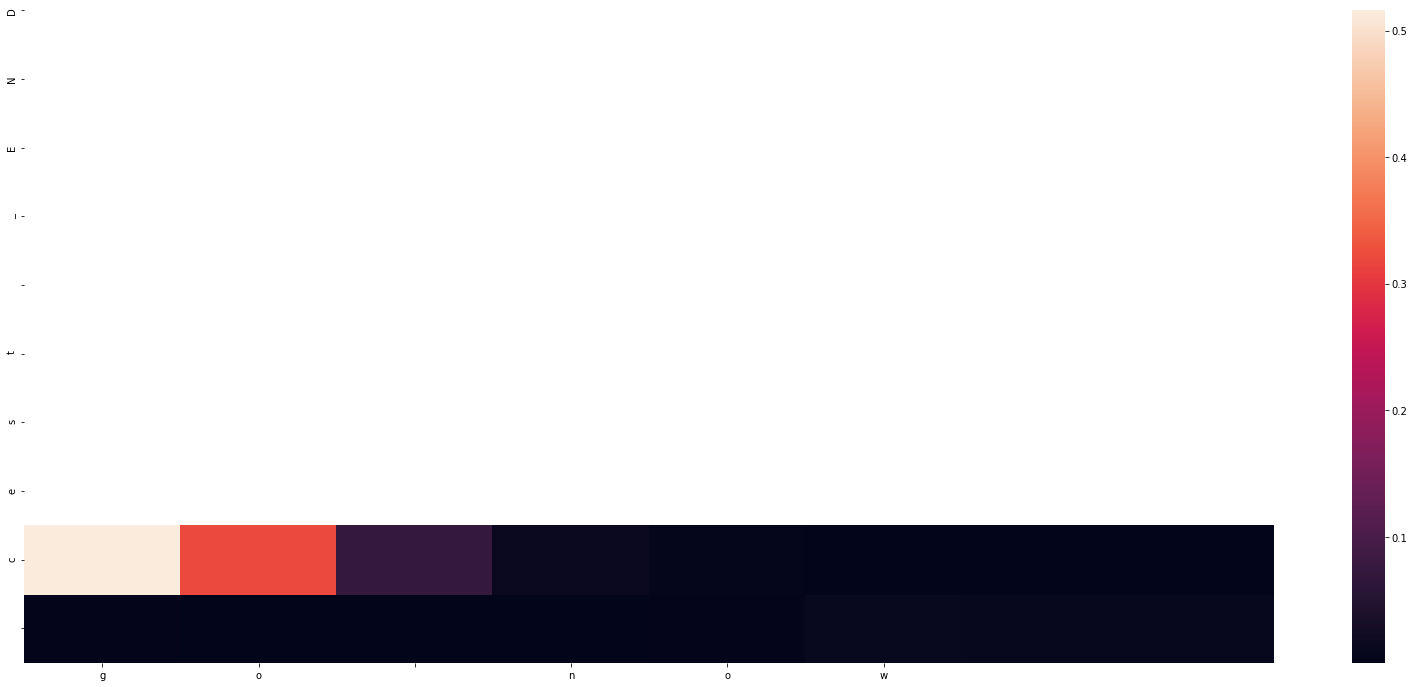

Decoded sentence:  cest _END
-
Input sentence: go now
GT sentence: START_ vasy maintenant _END


<Figure size 432x288 with 0 Axes>

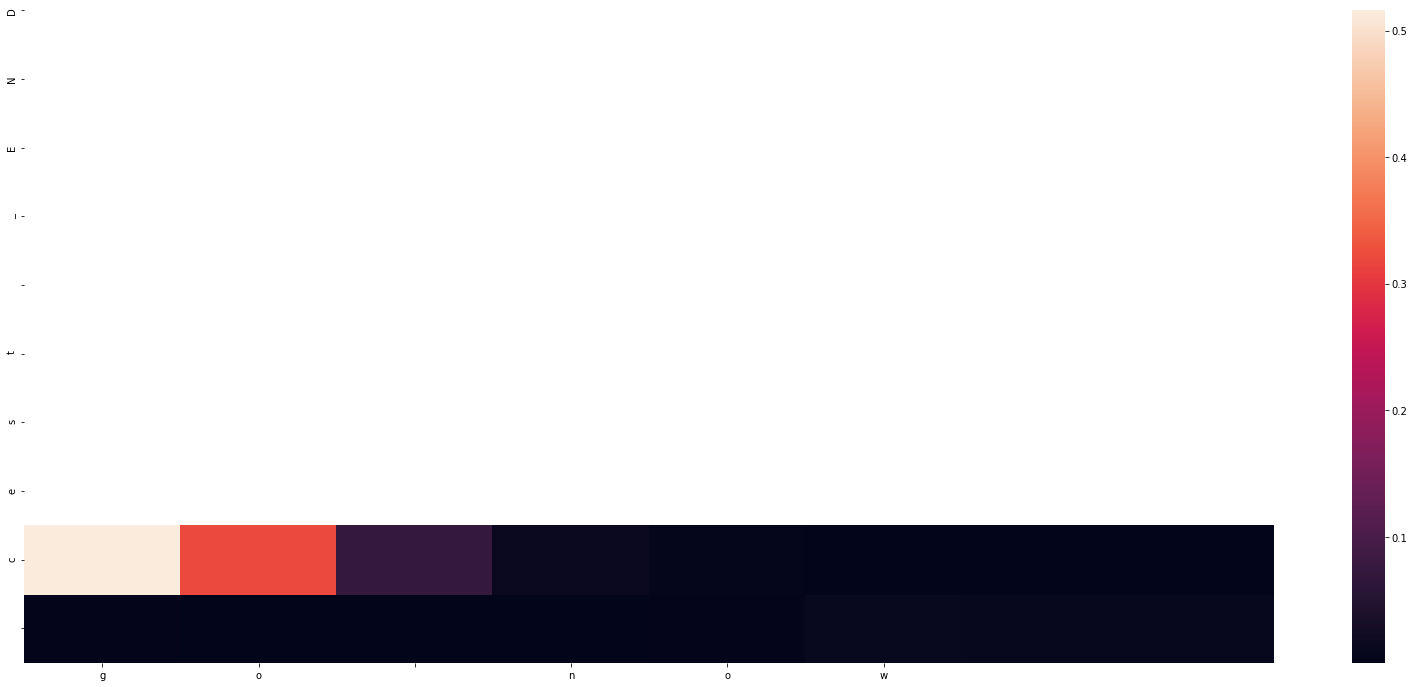

Decoded sentence:  cest _END
-
Input sentence: got it
GT sentence: START_ jai pigé  _END


<Figure size 432x288 with 0 Axes>

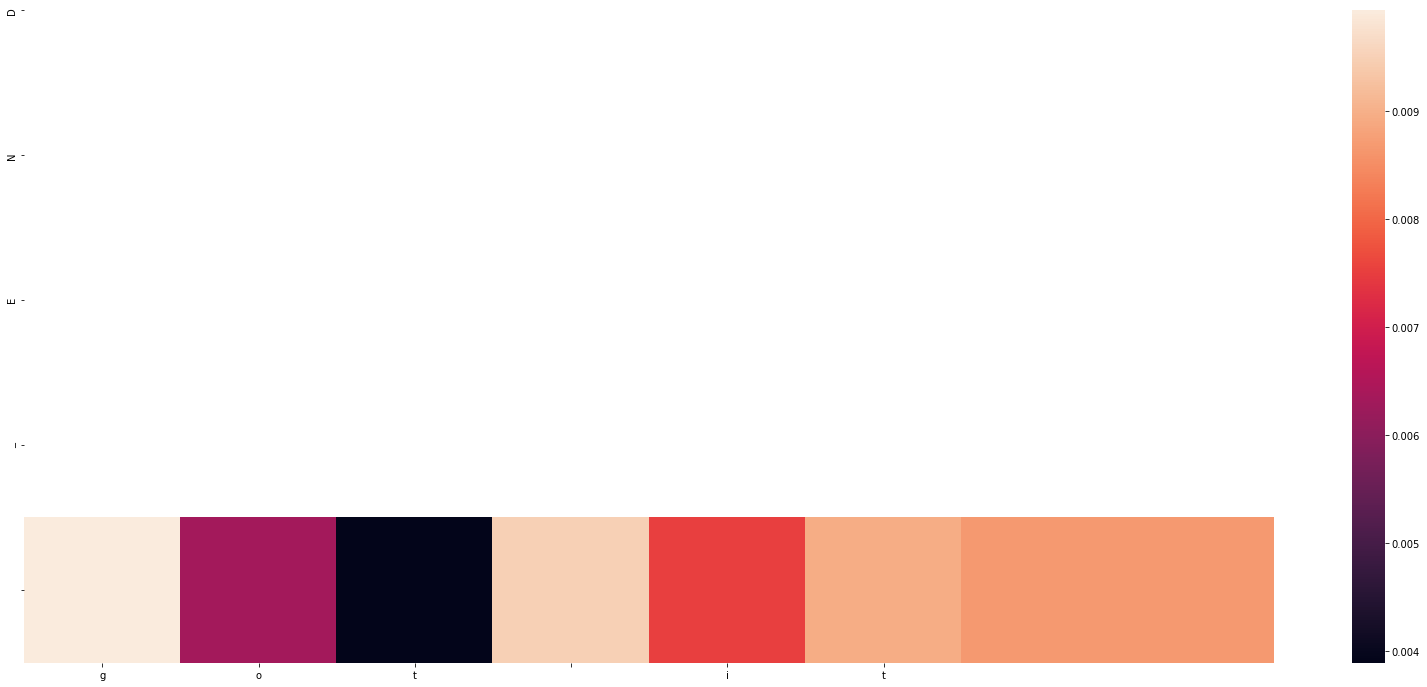

Decoded sentence:  _END
-
Input sentence: got it
GT sentence: START_ compris  _END


<Figure size 432x288 with 0 Axes>

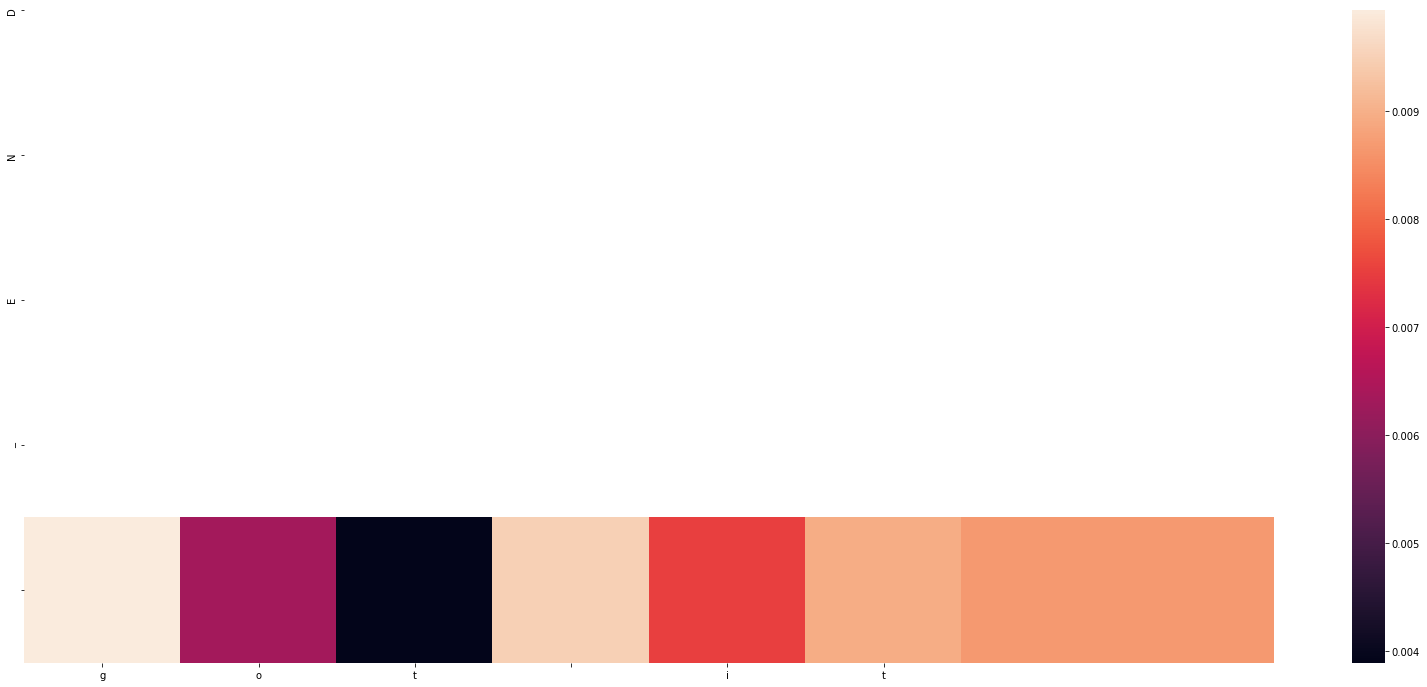

Decoded sentence:  _END
-
Input sentence: got it
GT sentence: START_ pigé  _END


<Figure size 432x288 with 0 Axes>

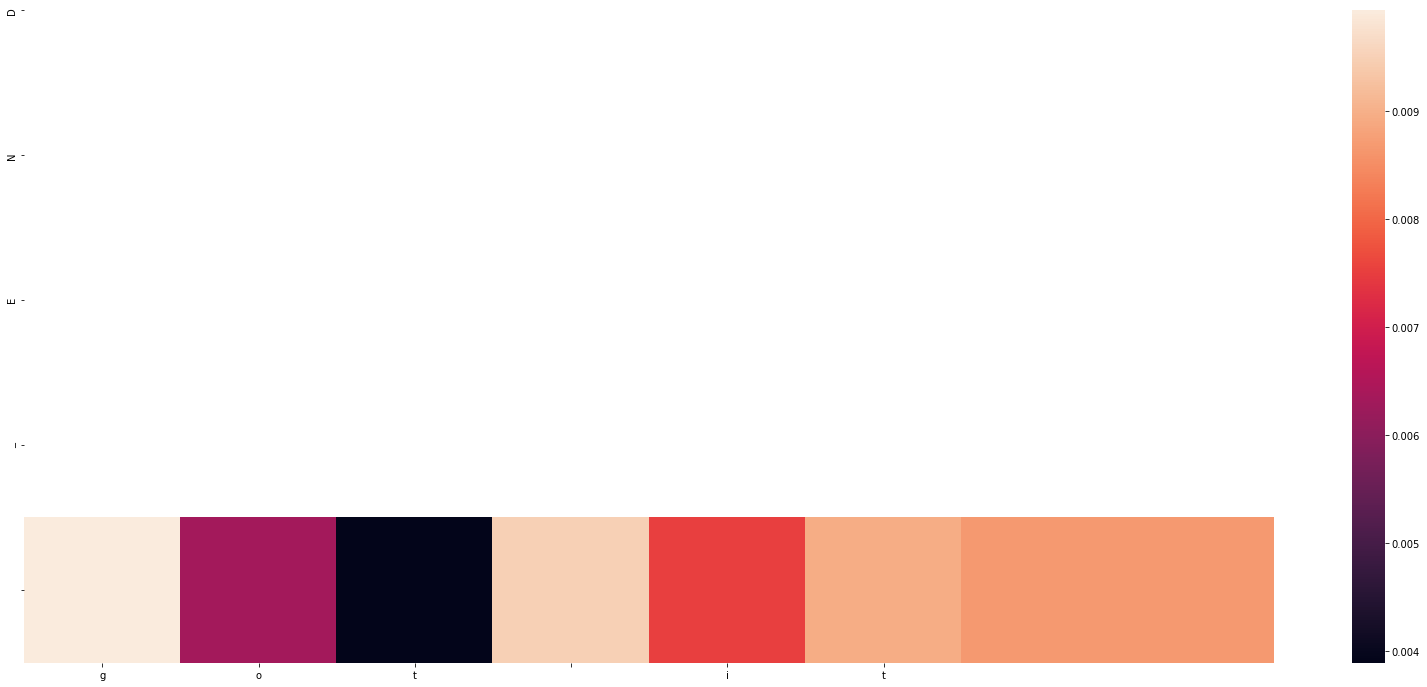

Decoded sentence:  _END
-
Input sentence: got it
GT sentence: START_ compris  _END


<Figure size 432x288 with 0 Axes>

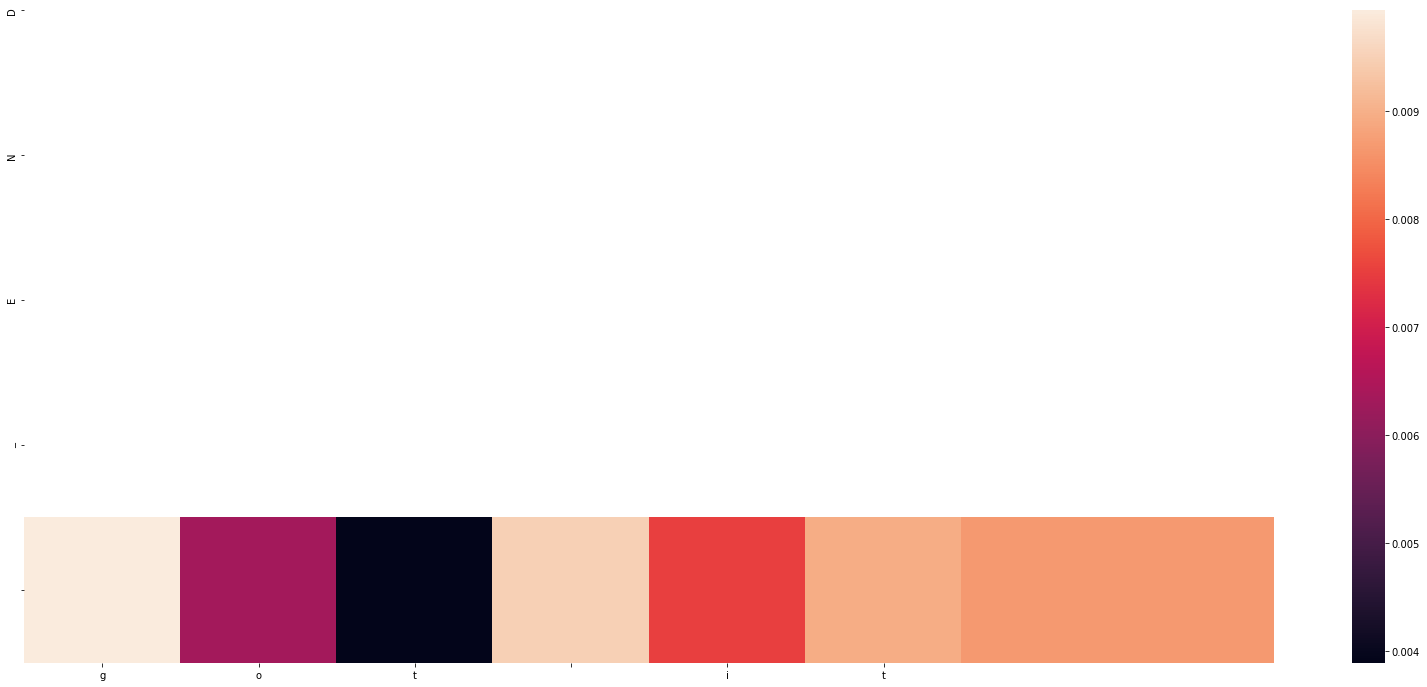

Decoded sentence:  _END
-
Input sentence: got it
GT sentence: START_ tas capté  _END


<Figure size 432x288 with 0 Axes>

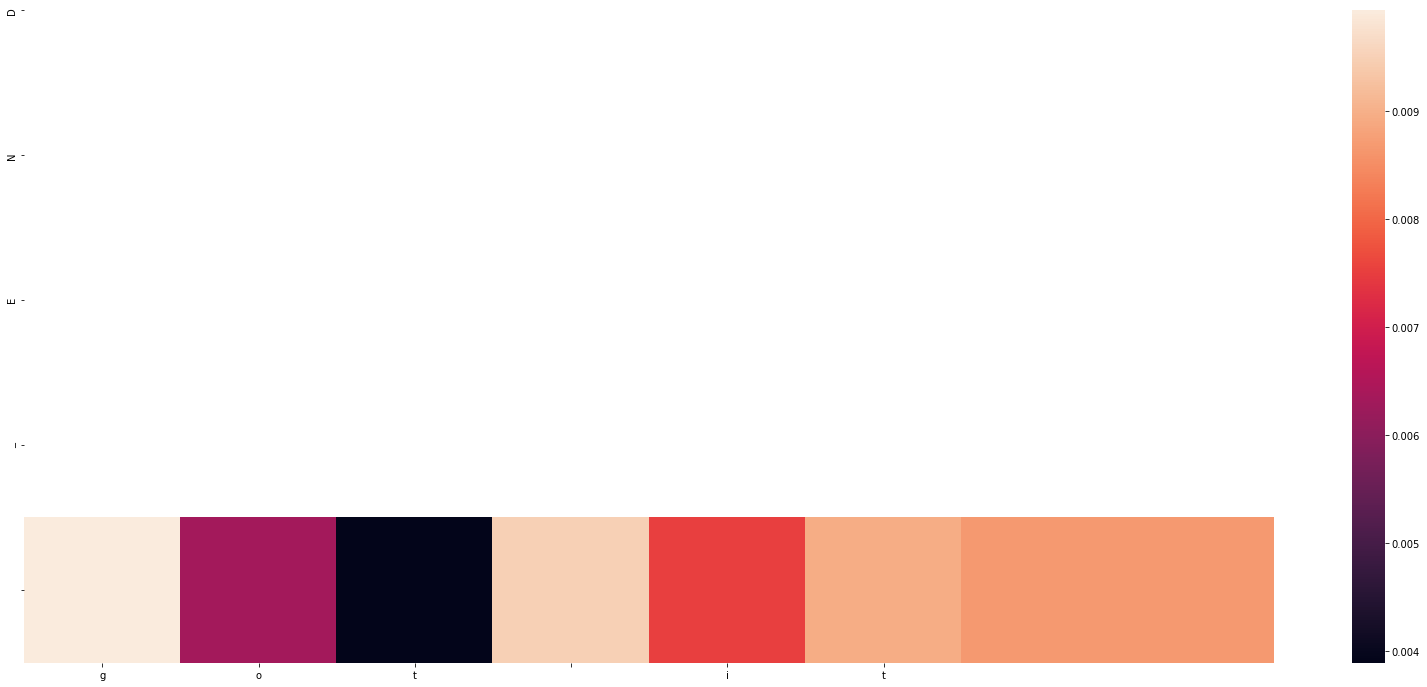

Decoded sentence:  _END
-
Input sentence: hop in
GT sentence: START_ monte _END


<Figure size 432x288 with 0 Axes>

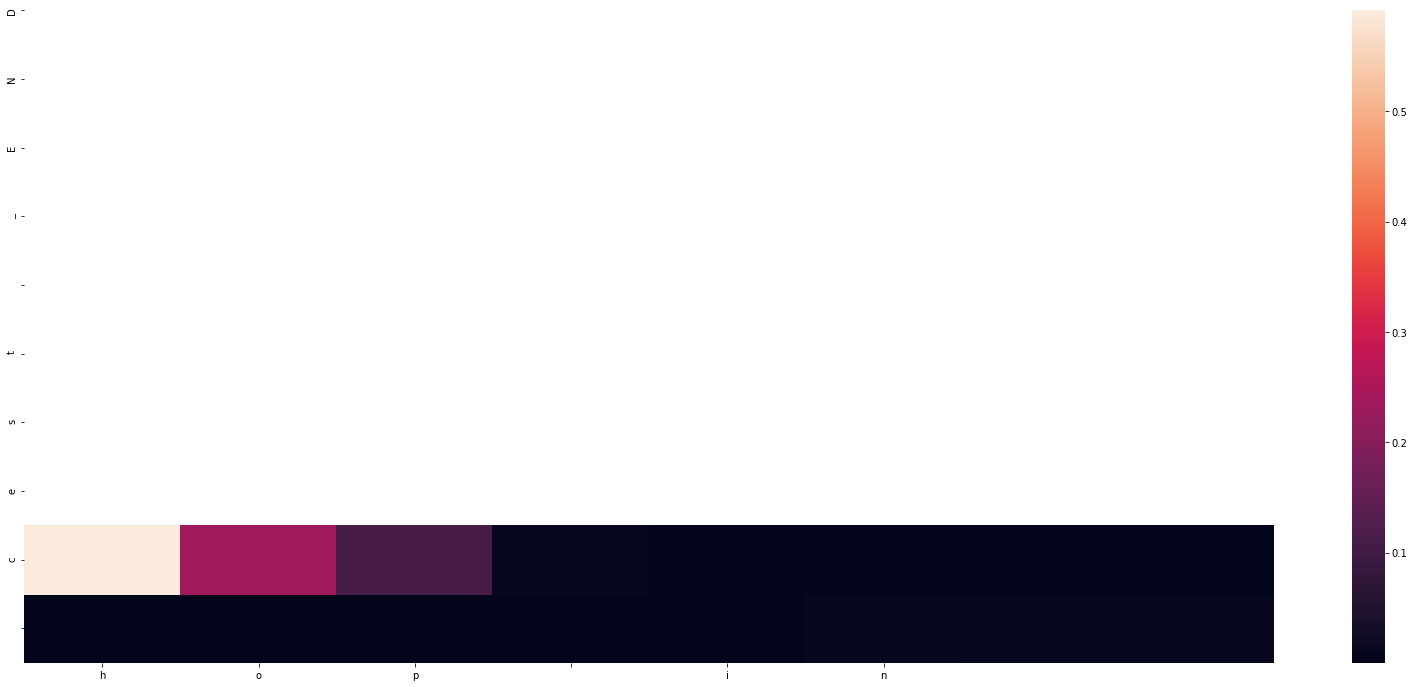

Decoded sentence:  cest _END
-
Input sentence: hop in
GT sentence: START_ montez _END


<Figure size 432x288 with 0 Axes>

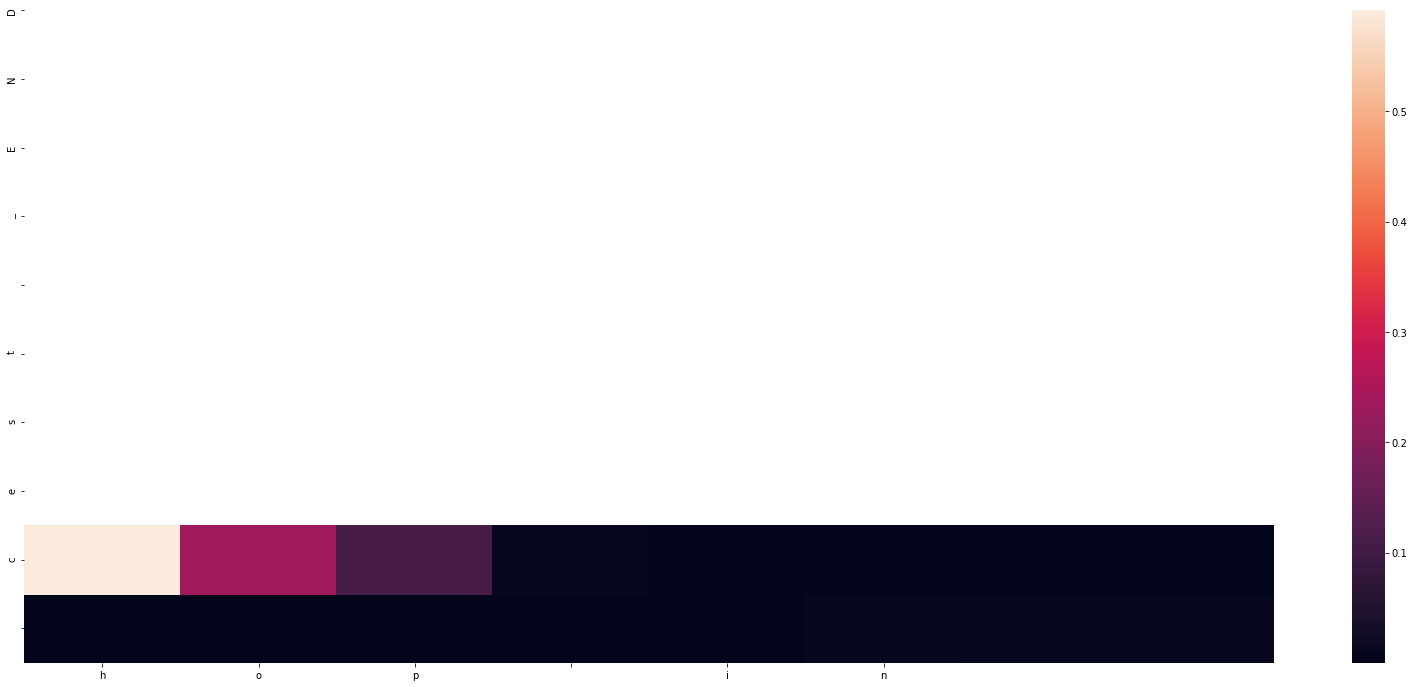

Decoded sentence:  cest _END
-
Input sentence: hug me
GT sentence: START_ serremoi dans tes bras  _END


<Figure size 432x288 with 0 Axes>

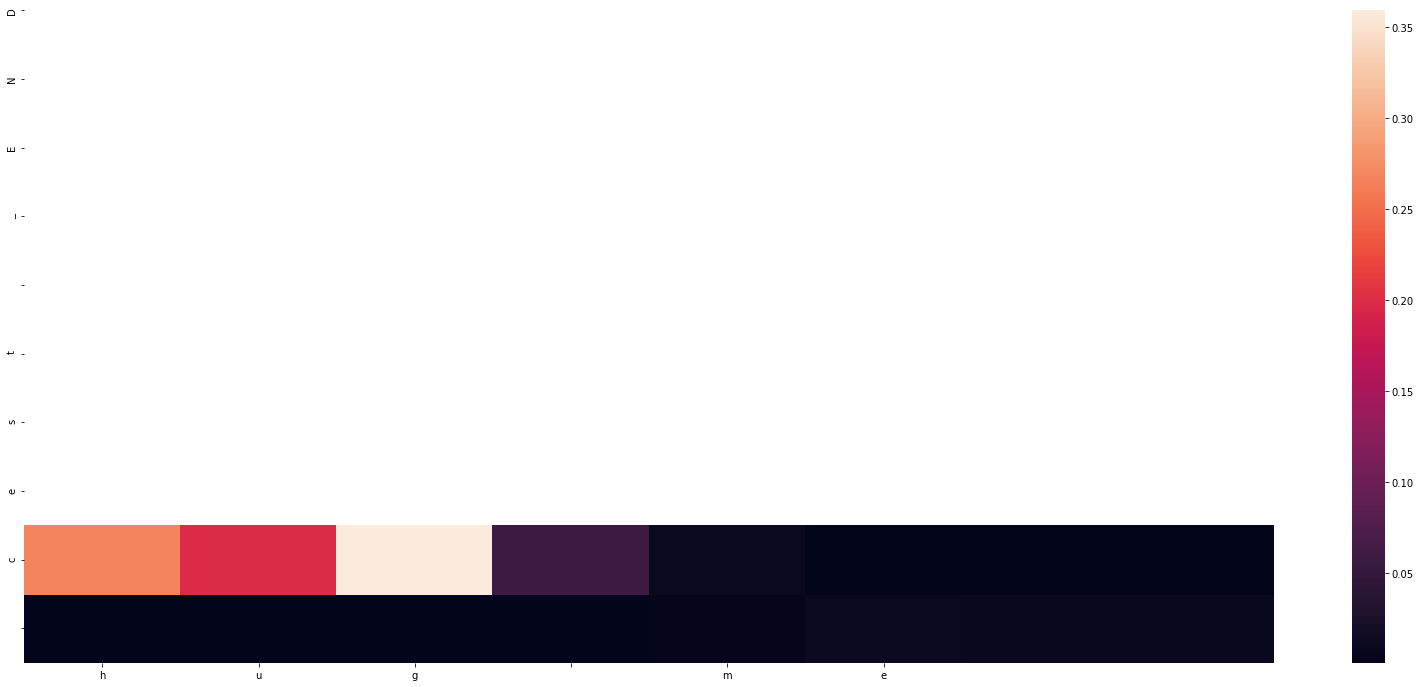

Decoded sentence:  cest _END
-
Input sentence: hug me
GT sentence: START_ serrezmoi dans vos bras  _END


<Figure size 432x288 with 0 Axes>

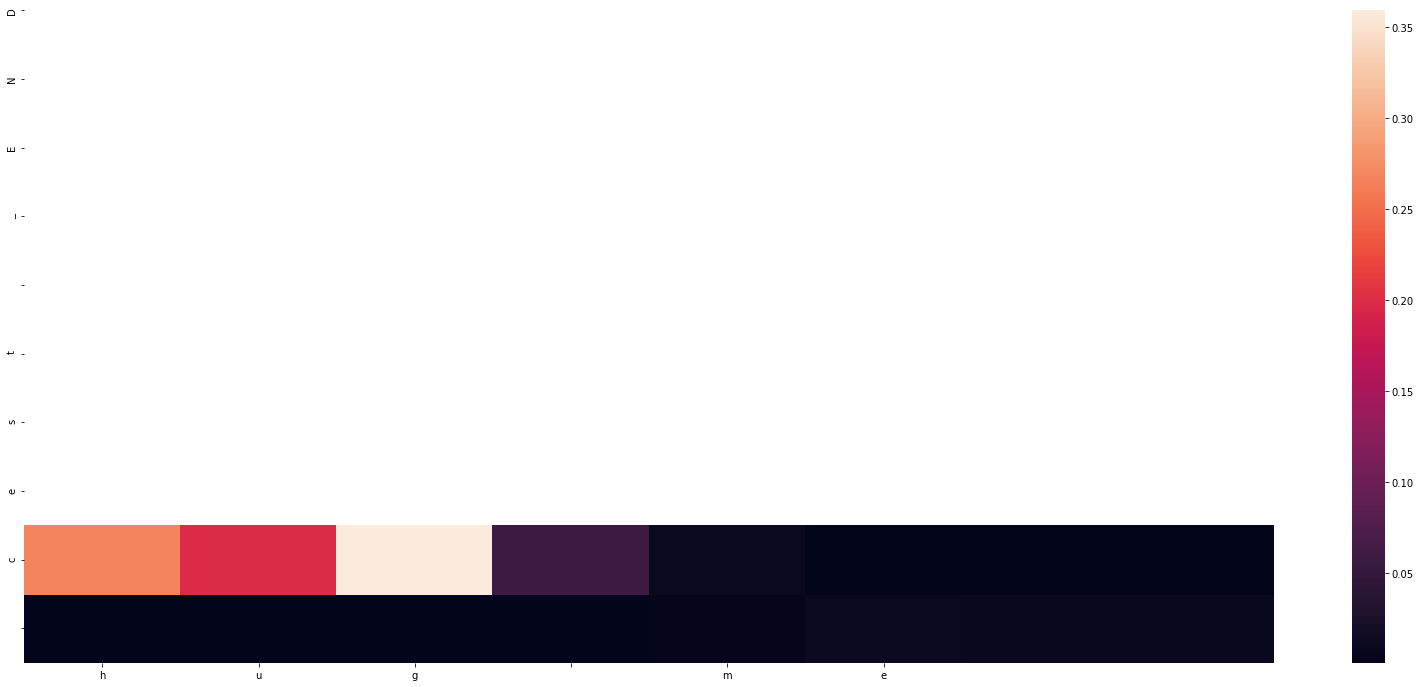

Decoded sentence:  cest _END
-
Input sentence: i fell
GT sentence: START_ je suis tombée _END


<Figure size 432x288 with 0 Axes>

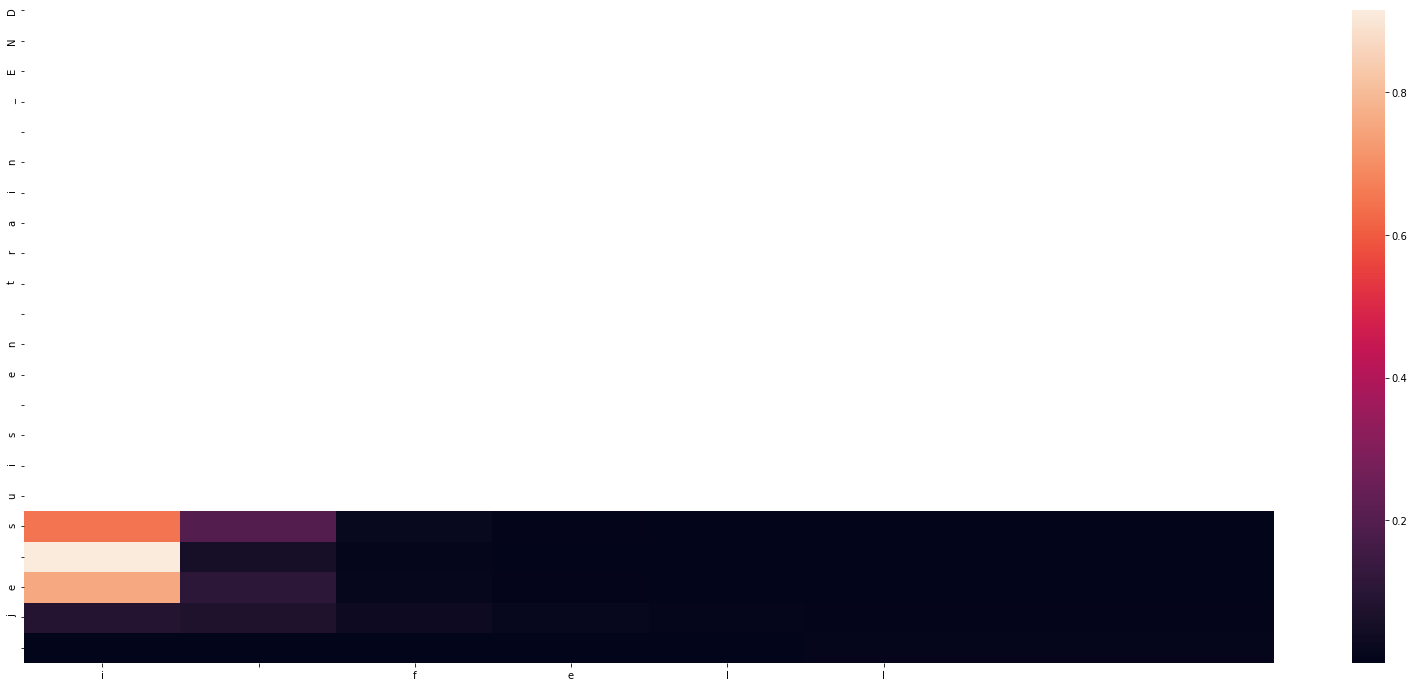

Decoded sentence:  je suis en train _END
-
Input sentence: i fell
GT sentence: START_ je suis tombé _END


<Figure size 432x288 with 0 Axes>

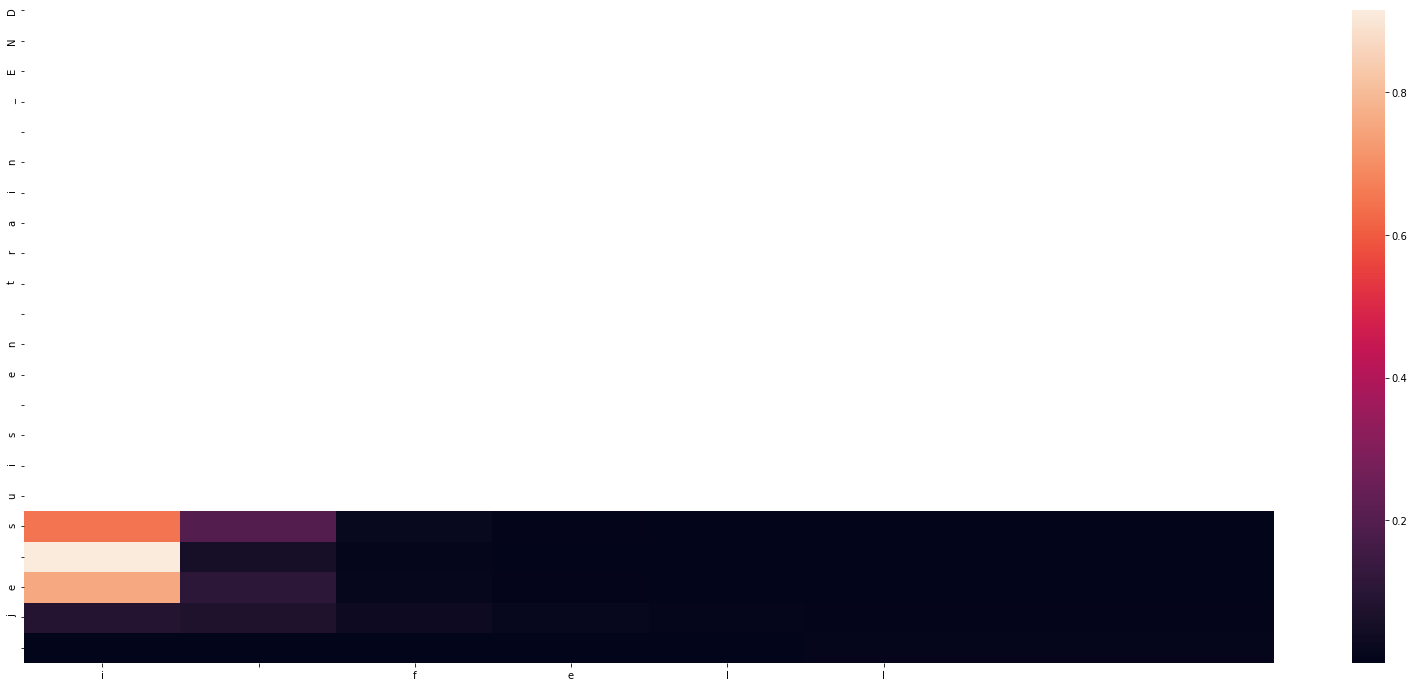

Decoded sentence:  je suis en train _END
-
Input sentence: i know
GT sentence: START_ je sais _END


<Figure size 432x288 with 0 Axes>

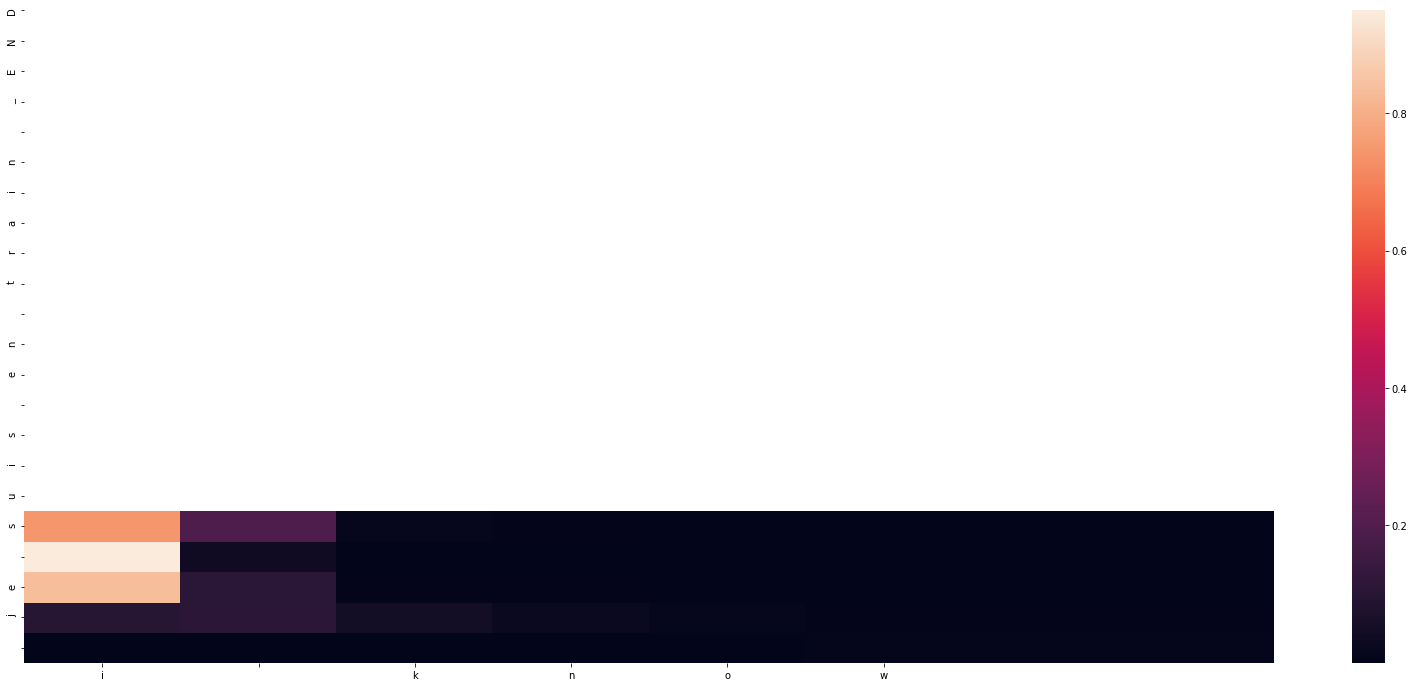

Decoded sentence:  je suis en train _END
-
Input sentence: i left
GT sentence: START_ je suis parti _END


<Figure size 432x288 with 0 Axes>

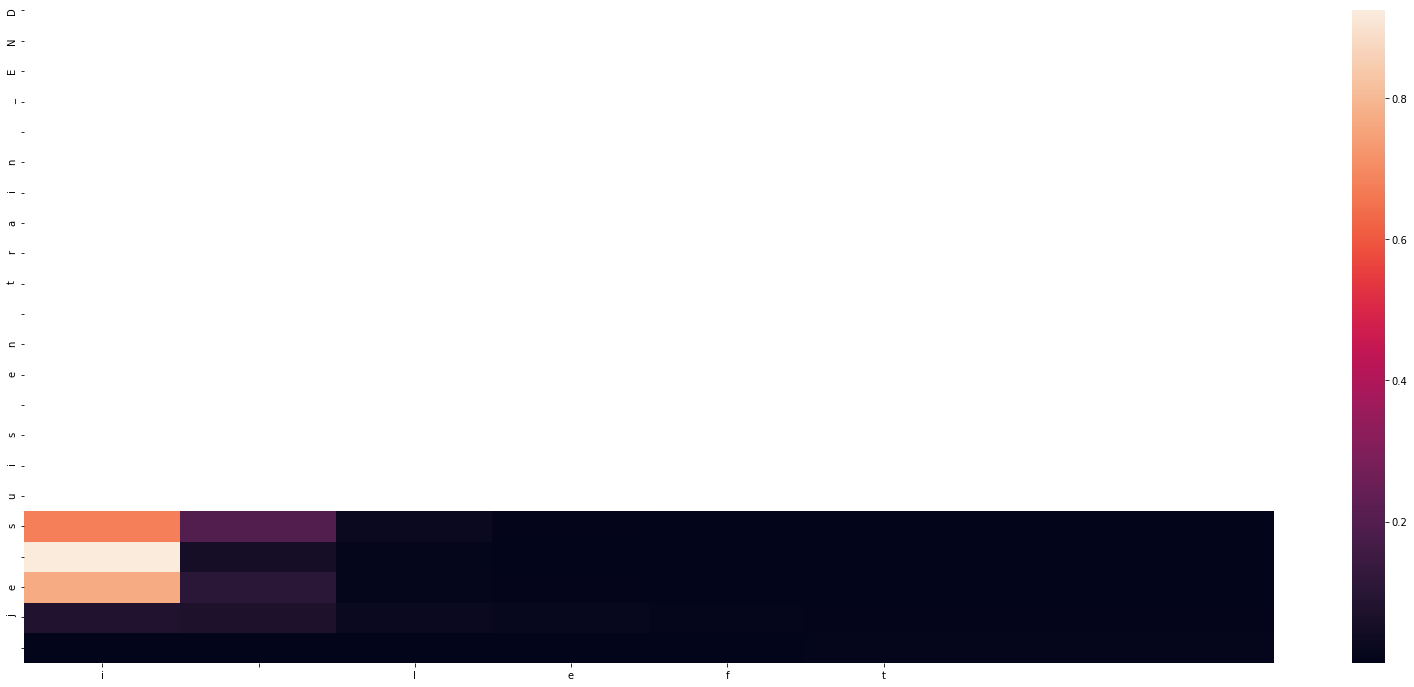

Decoded sentence:  je suis en train _END
-
Input sentence: i left
GT sentence: START_ je suis partie _END


<Figure size 432x288 with 0 Axes>

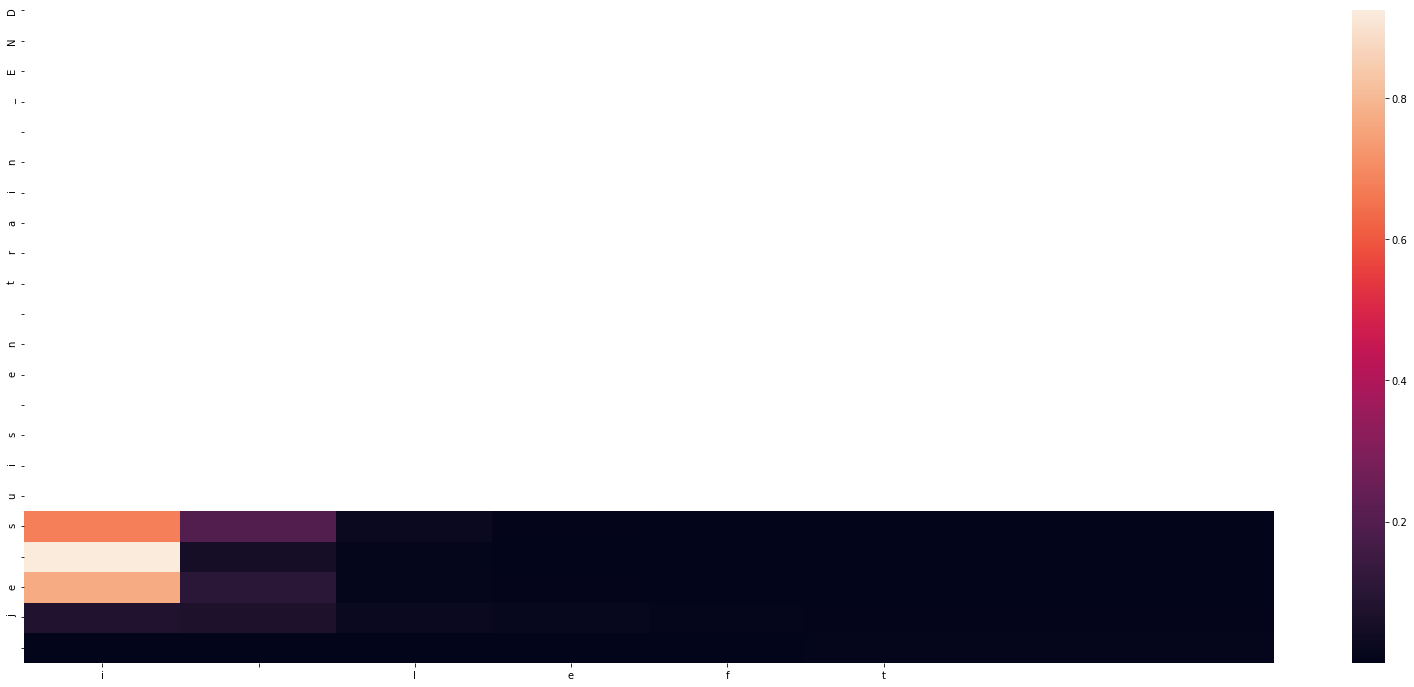

Decoded sentence:  je suis en train _END
-
Input sentence: i lied
GT sentence: START_ jai menti _END


<Figure size 432x288 with 0 Axes>

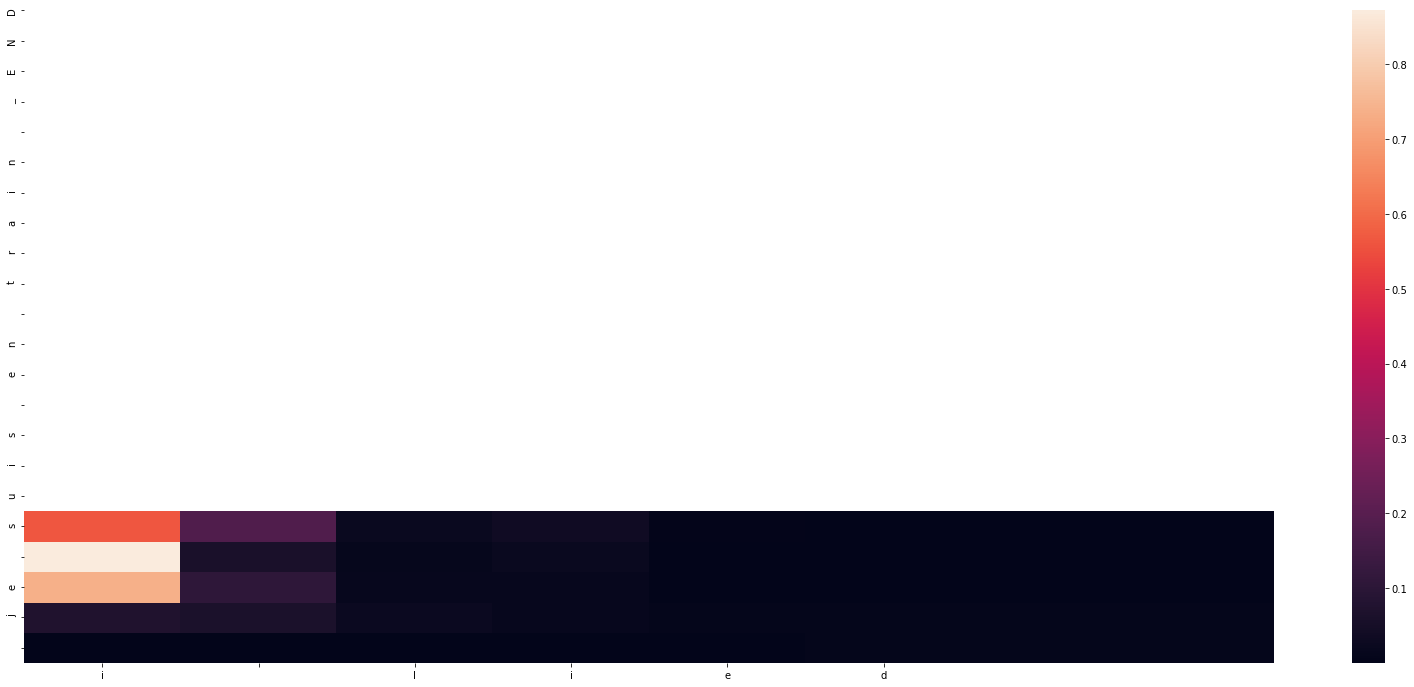

Decoded sentence:  je suis en train _END
-
Input sentence: i lost
GT sentence: START_ jai perdu _END


<Figure size 432x288 with 0 Axes>

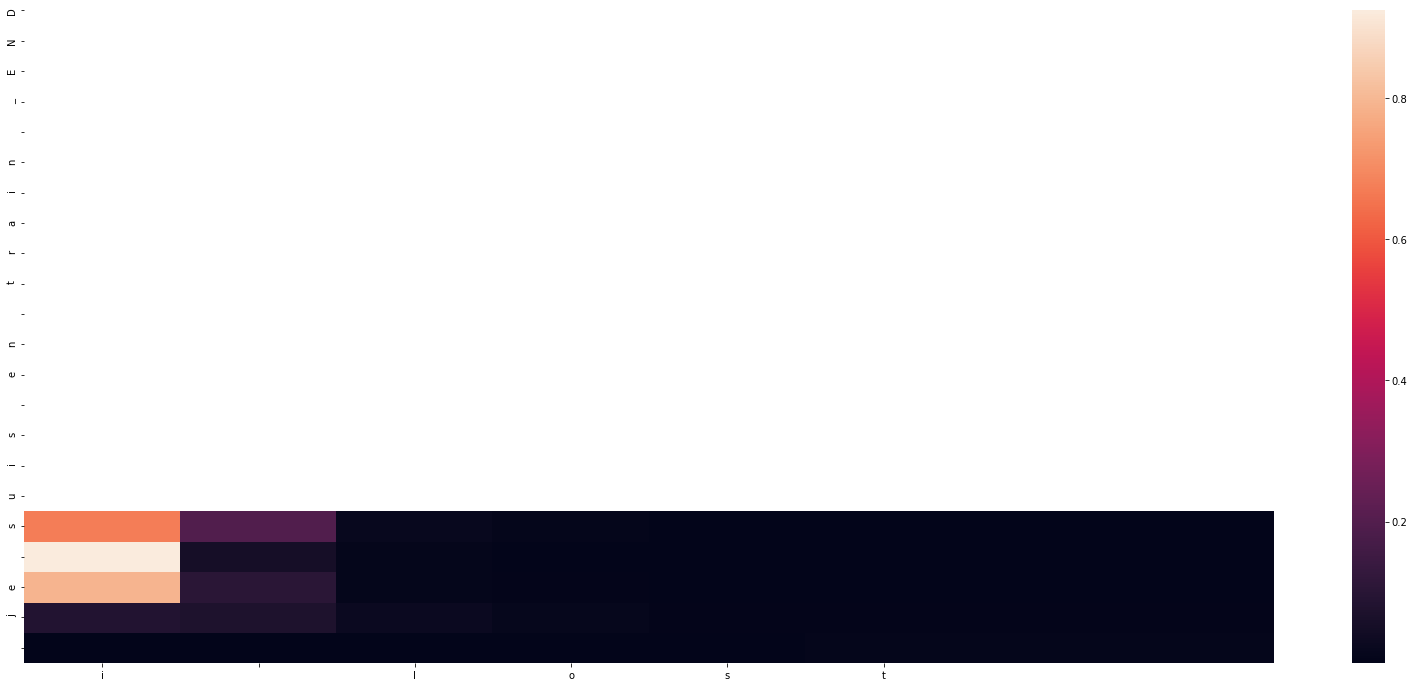

Decoded sentence:  je suis en train _END
-
Input sentence: i paid
GT sentence: START_ j’ai payé _END


<Figure size 432x288 with 0 Axes>

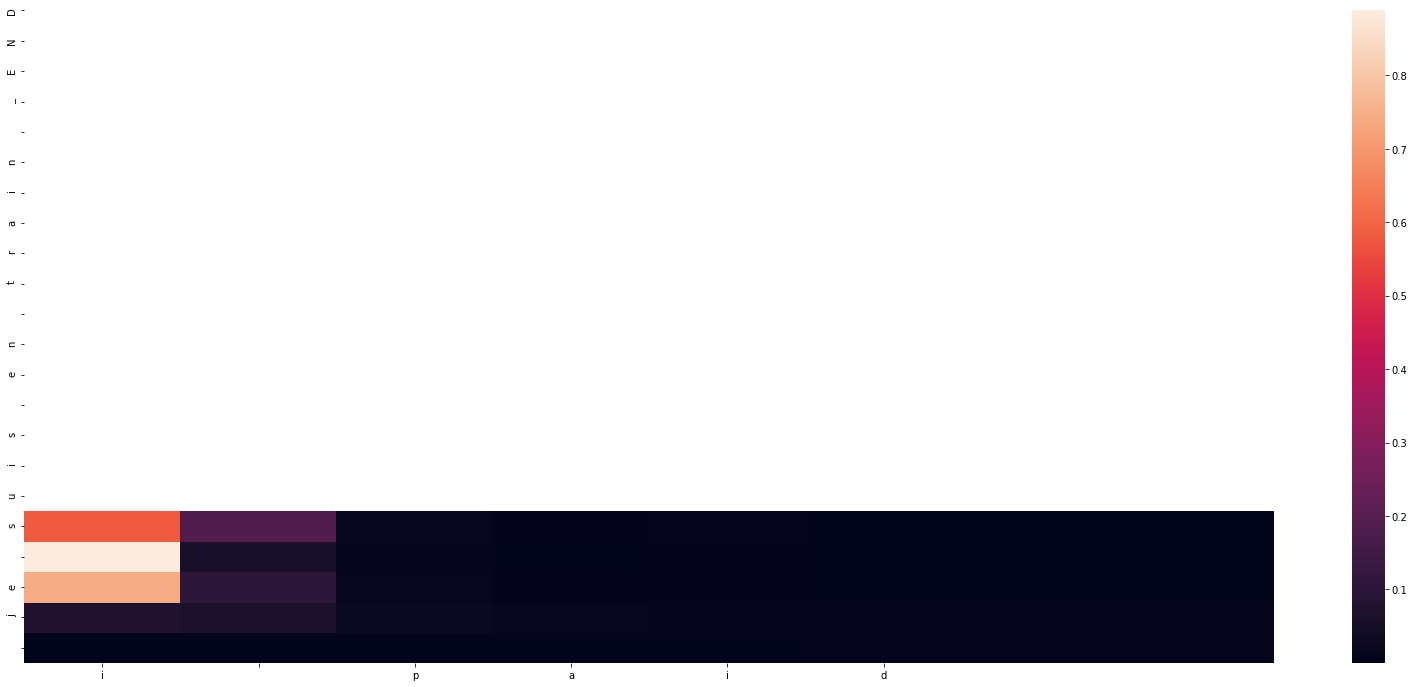

Decoded sentence:  je suis en train _END
-
Input sentence: im 
GT sentence: START_ jai  ans _END


<Figure size 432x288 with 0 Axes>

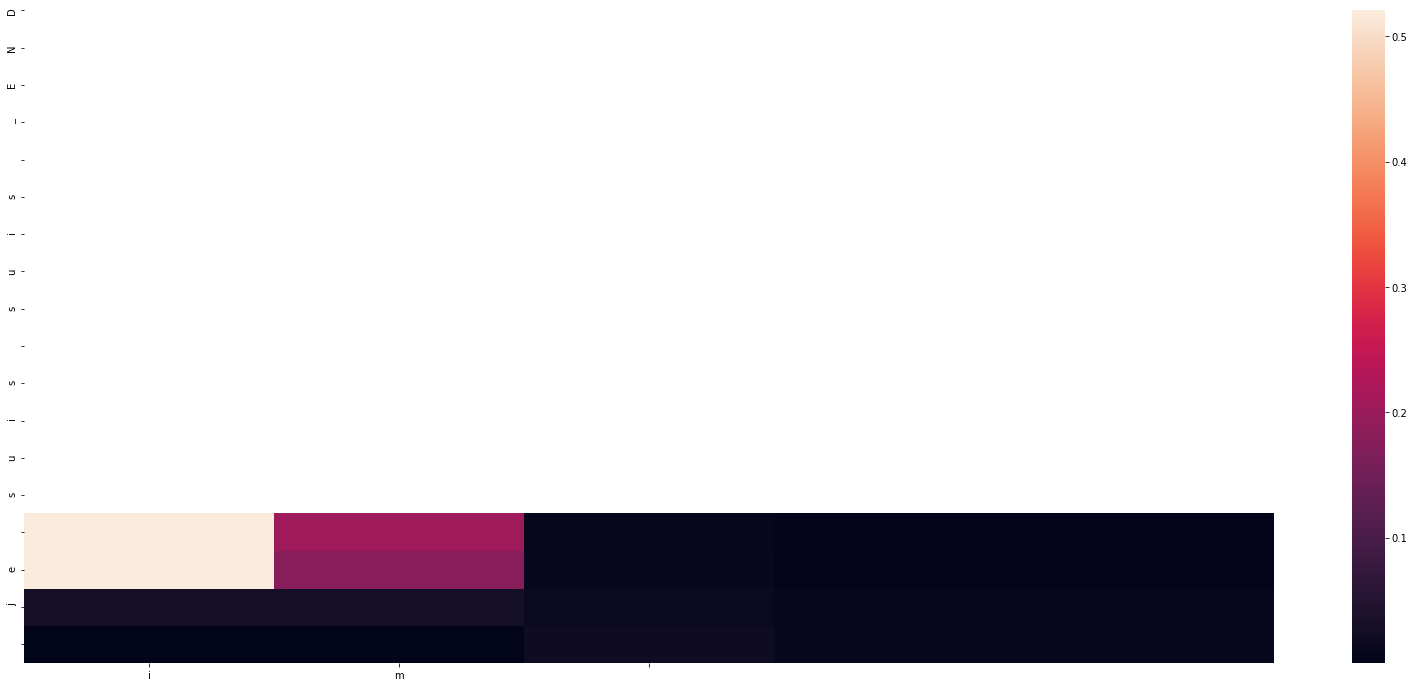

Decoded sentence:  je suis suis _END
-
Input sentence: im ok
GT sentence: START_ je vais bien _END


<Figure size 432x288 with 0 Axes>

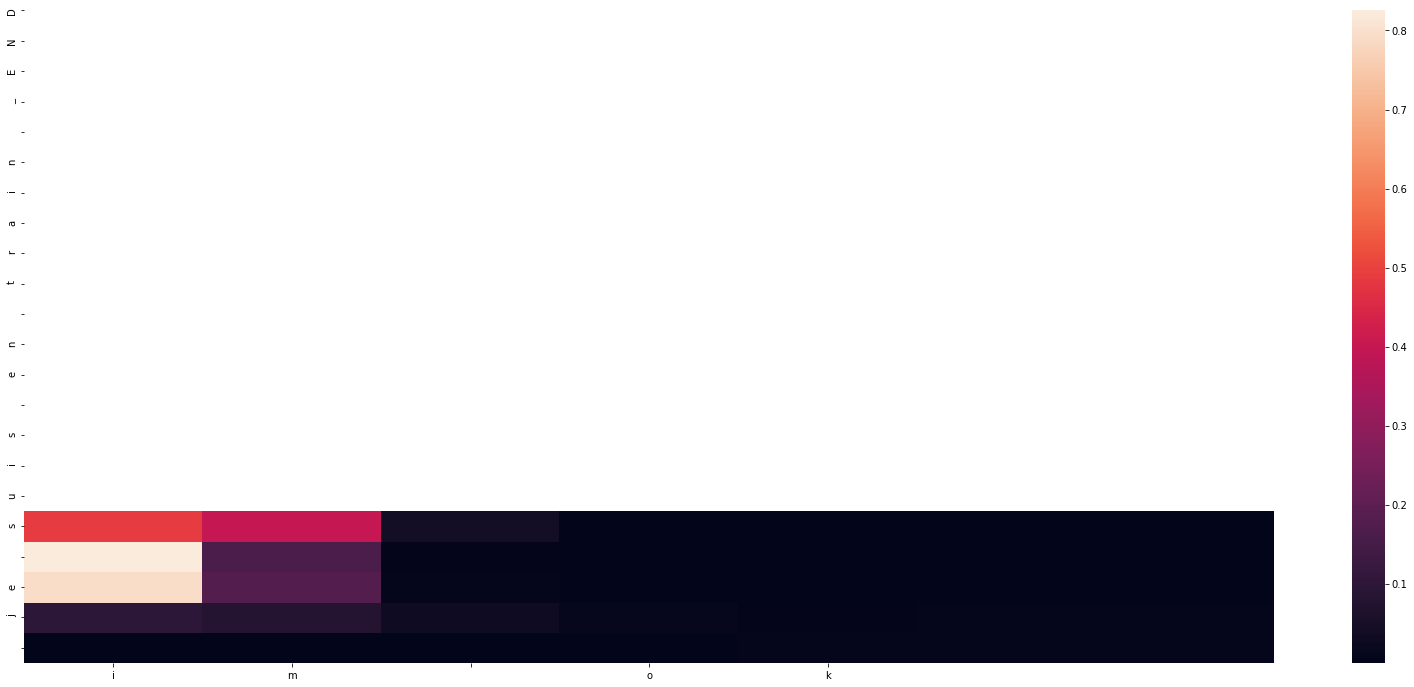

Decoded sentence:  je suis en train _END
-
Input sentence: im ok
GT sentence: START_ ça va _END


<Figure size 432x288 with 0 Axes>

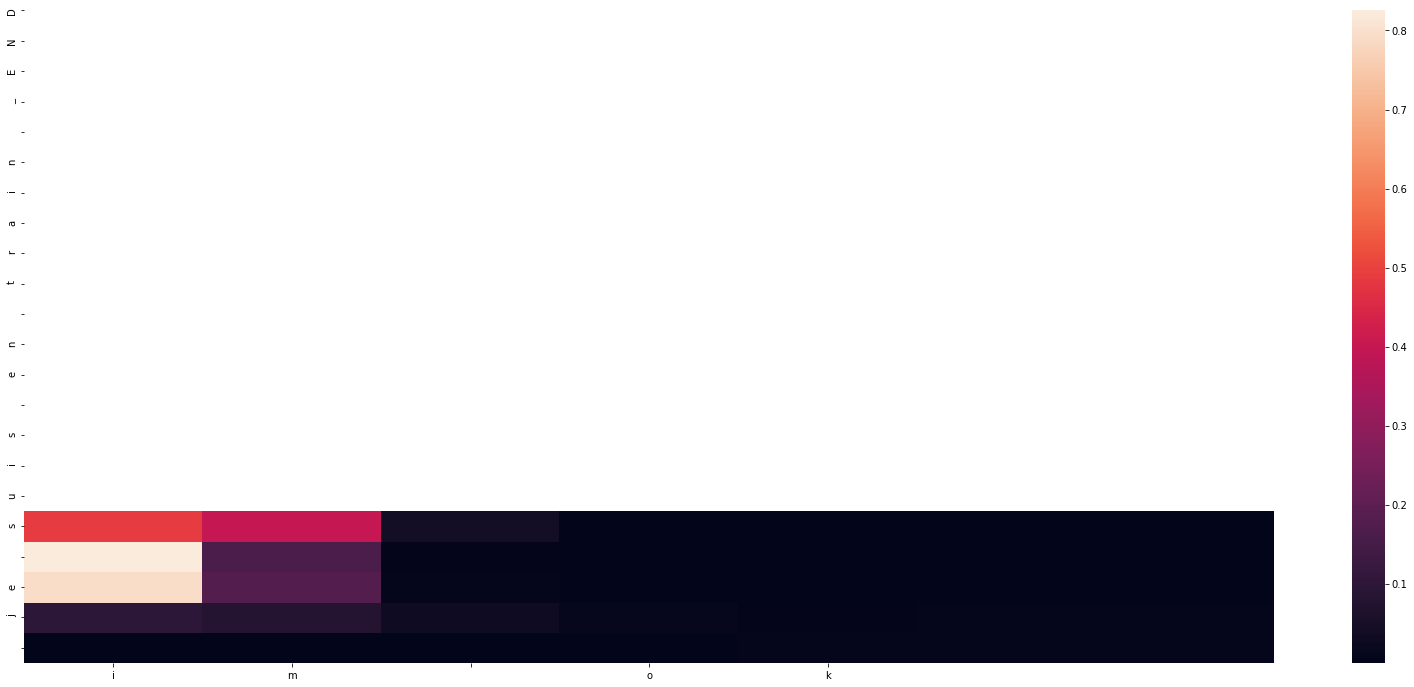

Decoded sentence:  je suis en train _END
-
Input sentence: listen
GT sentence: START_ écoutez  _END


<Figure size 432x288 with 0 Axes>

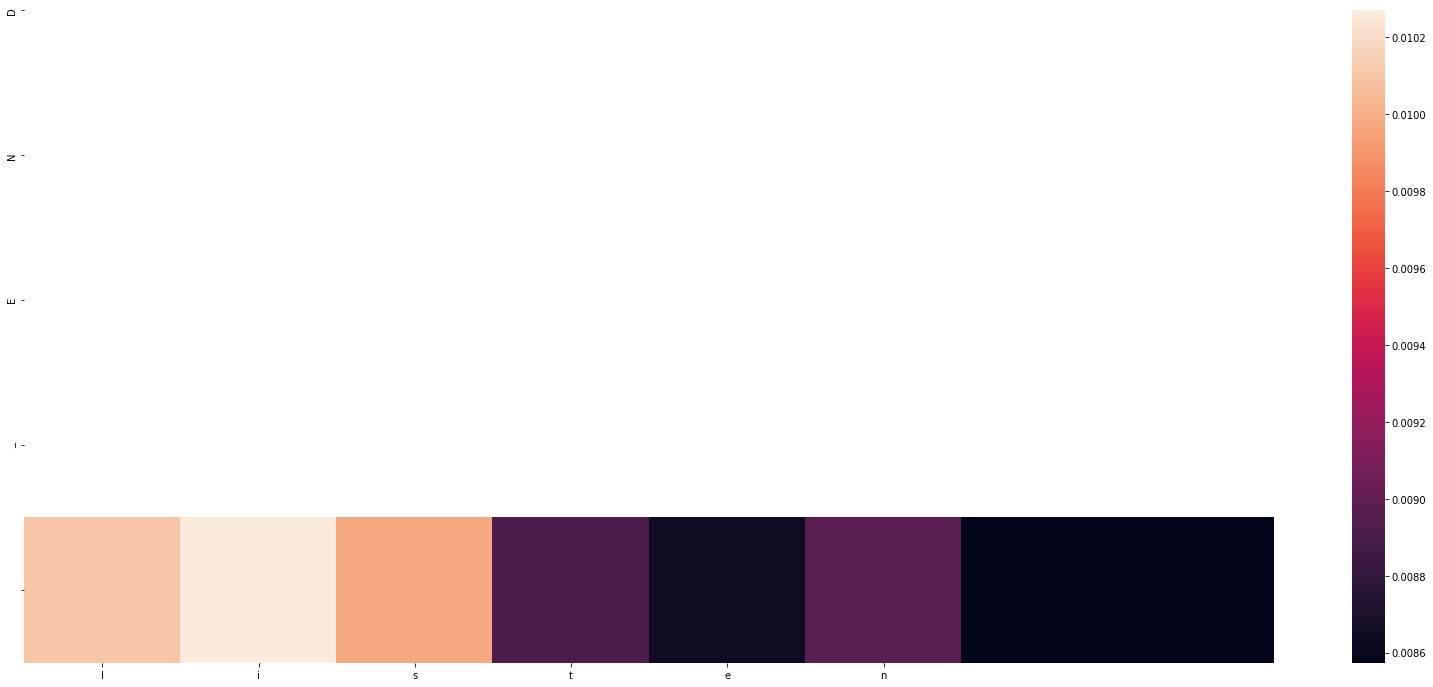

Decoded sentence:  _END
-
Input sentence: no way
GT sentence: START_ cest pas possible  _END


<Figure size 432x288 with 0 Axes>

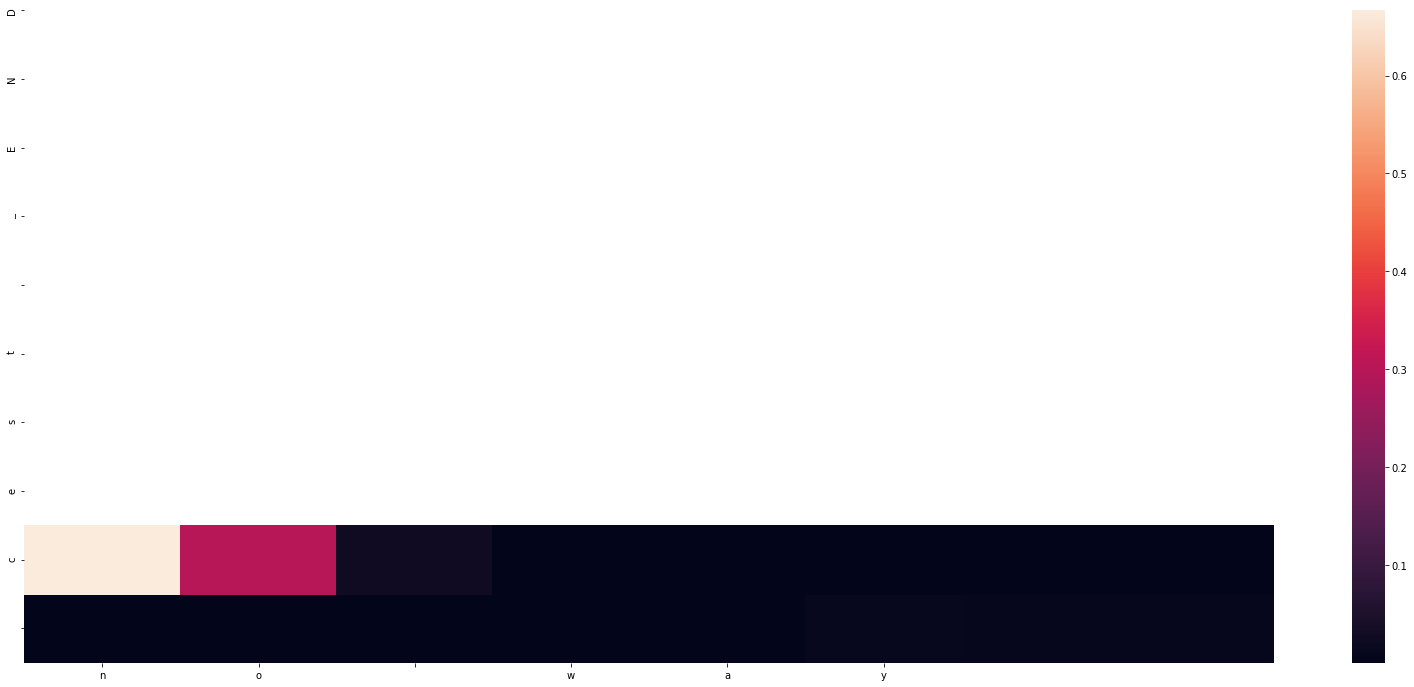

Decoded sentence:  cest _END
-
Input sentence: no way
GT sentence: START_ impossible  _END


<Figure size 432x288 with 0 Axes>

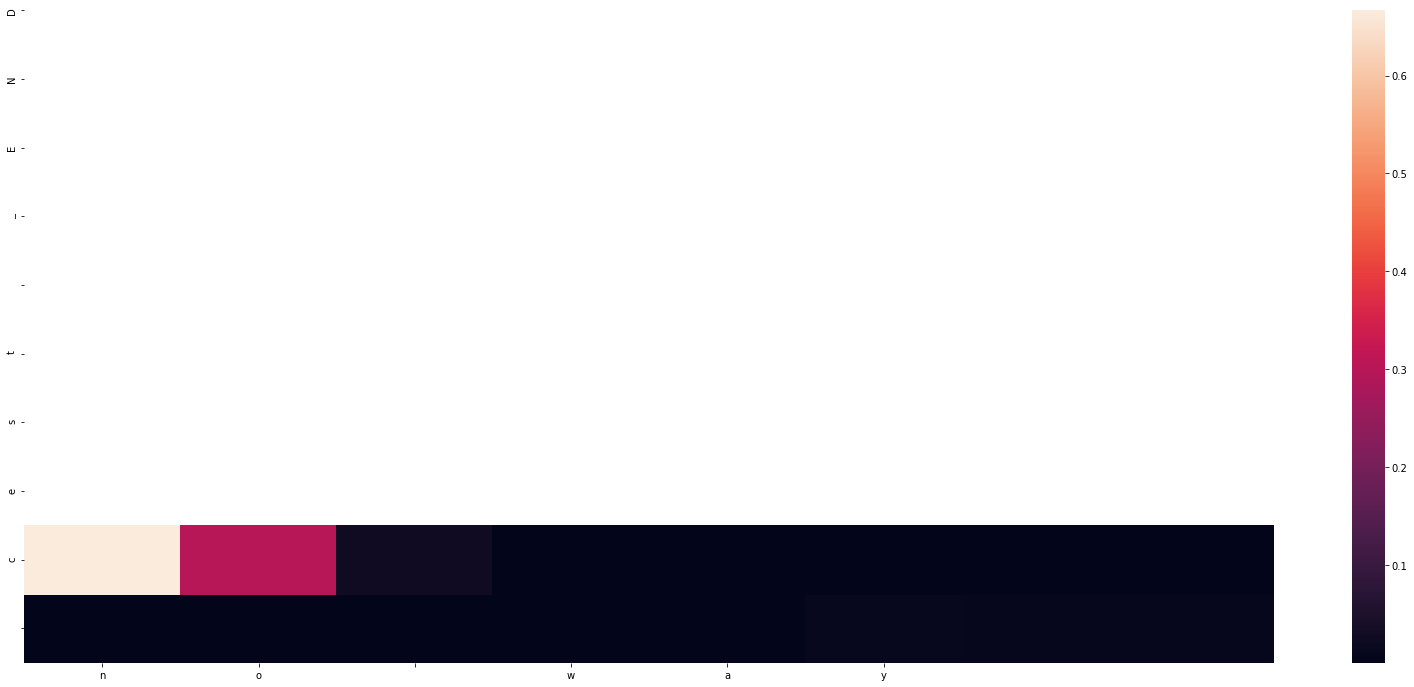

Decoded sentence:  cest _END
-
Input sentence: no way
GT sentence: START_ en aucun cas _END


<Figure size 432x288 with 0 Axes>

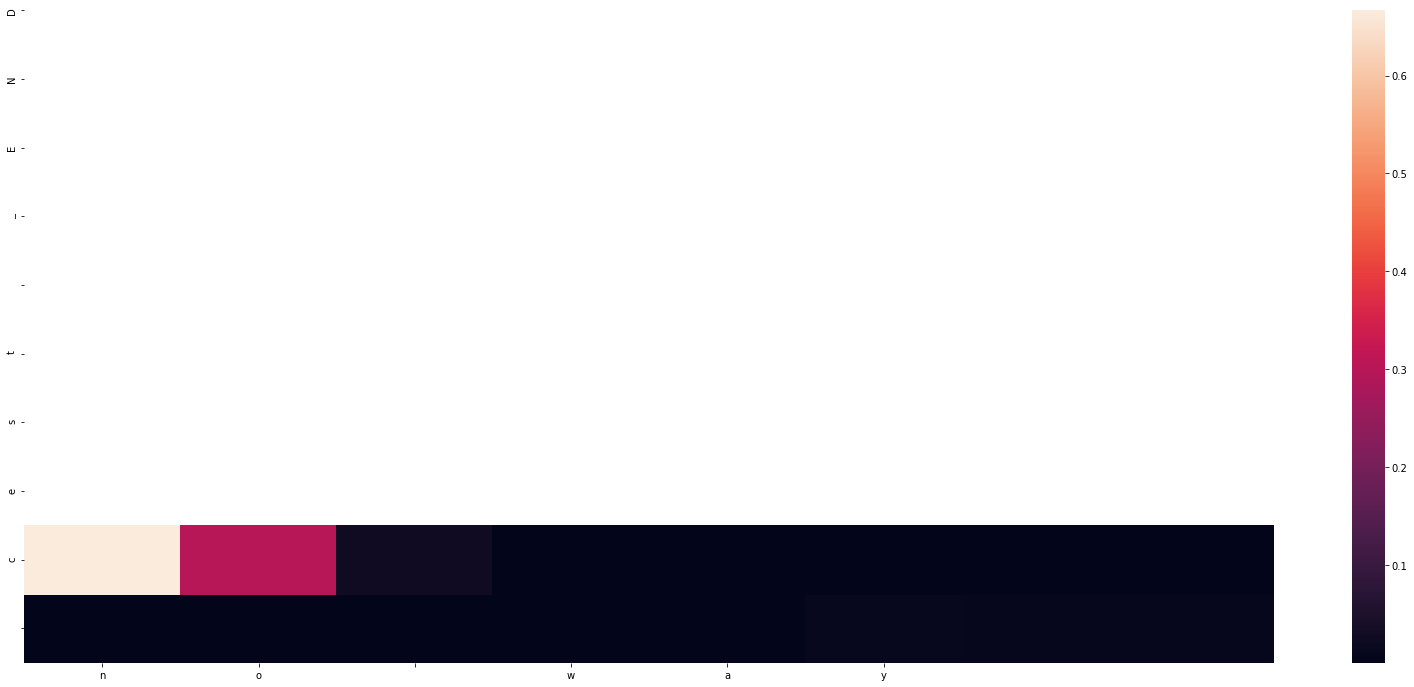

Decoded sentence:  cest _END
-
Input sentence: no way
GT sentence: START_ sans façons  _END


<Figure size 432x288 with 0 Axes>

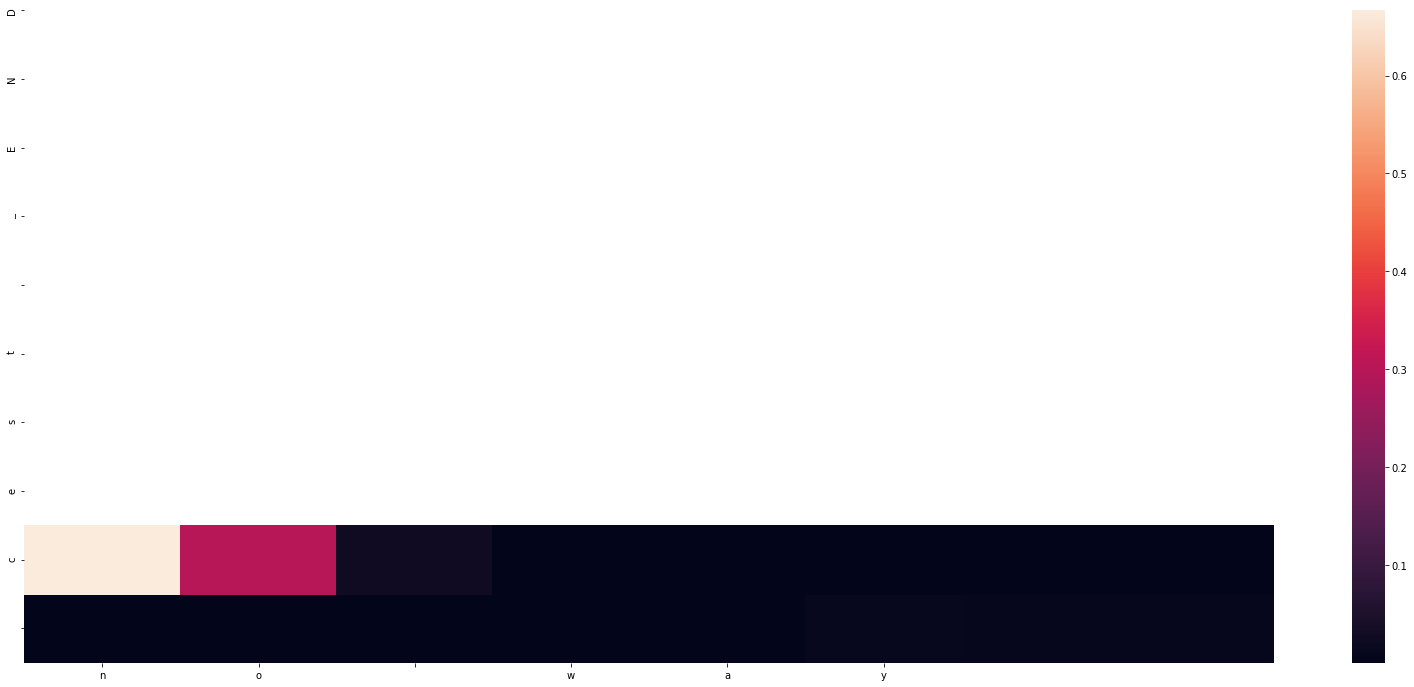

Decoded sentence:  cest _END
-
Input sentence: no way
GT sentence: START_ cest hors de question  _END


<Figure size 432x288 with 0 Axes>

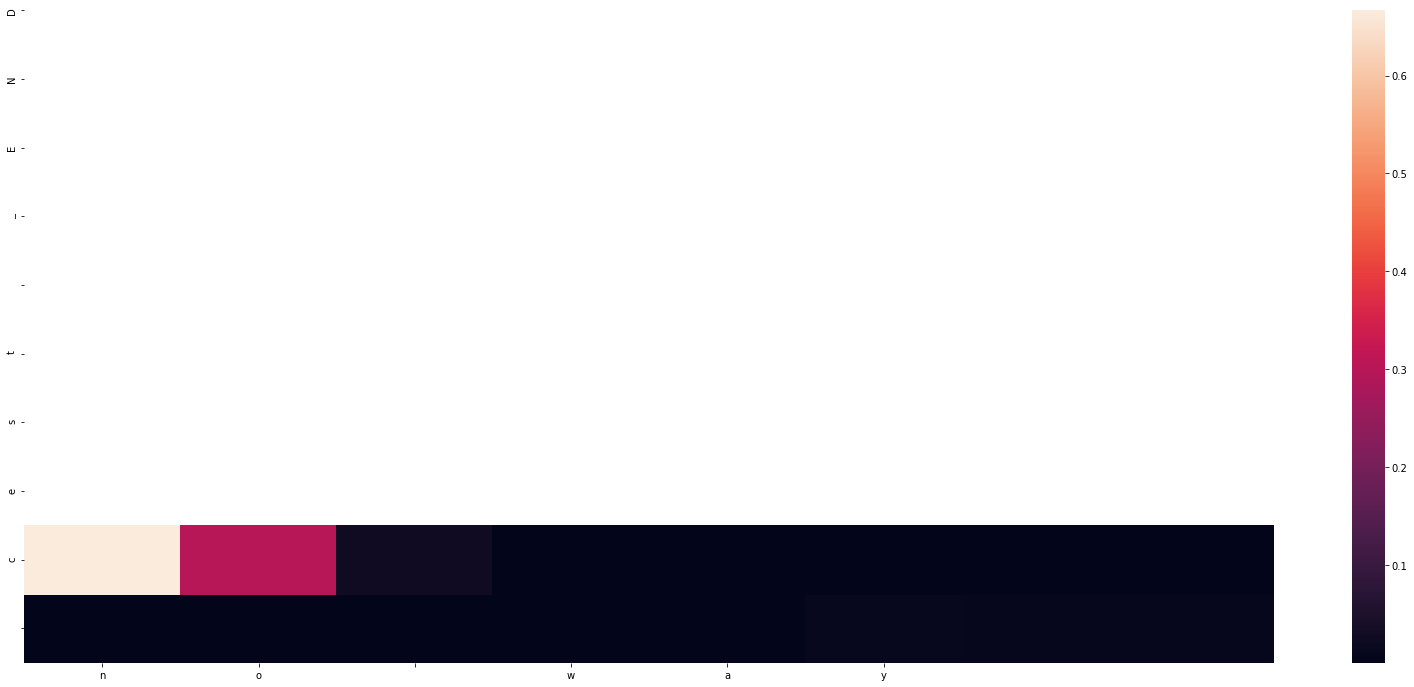

Decoded sentence:  cest _END
-
Input sentence: no way
GT sentence: START_ il nen est pas question  _END


<Figure size 432x288 with 0 Axes>

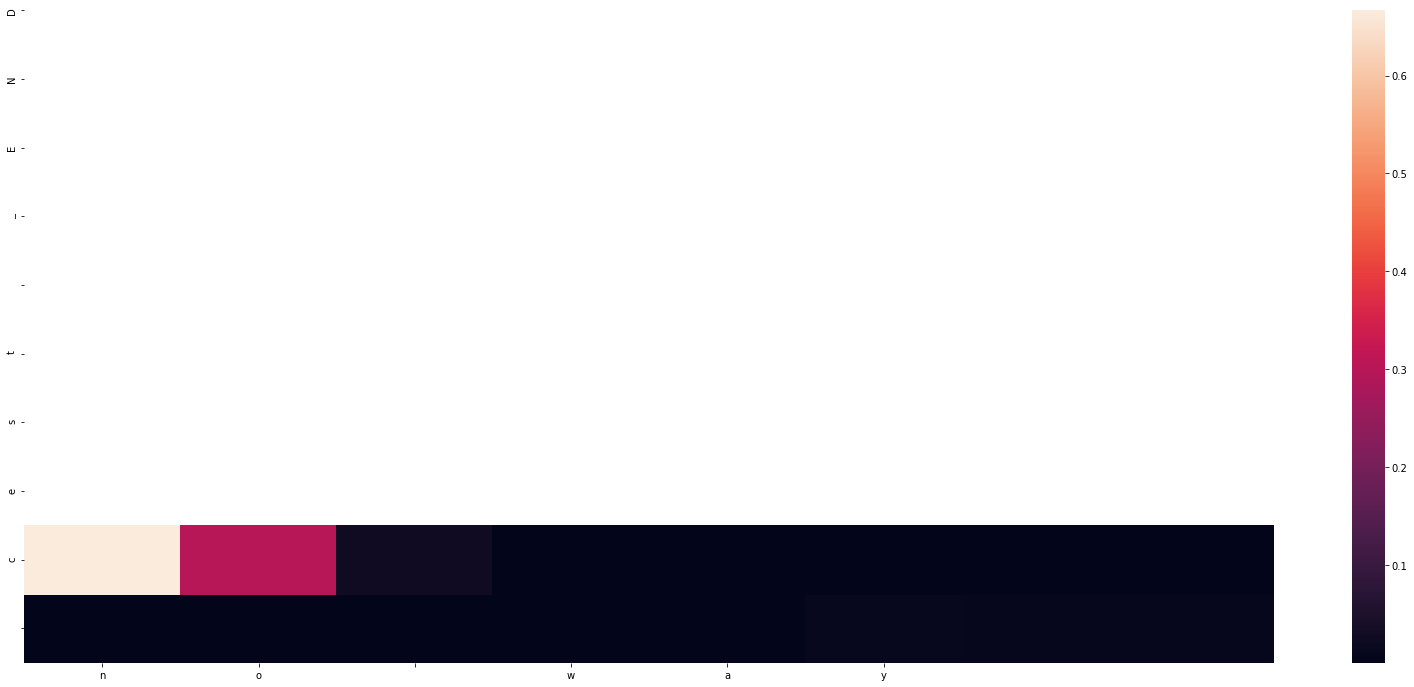

Decoded sentence:  cest _END
-
Input sentence: no way
GT sentence: START_ cest exclu  _END


<Figure size 432x288 with 0 Axes>

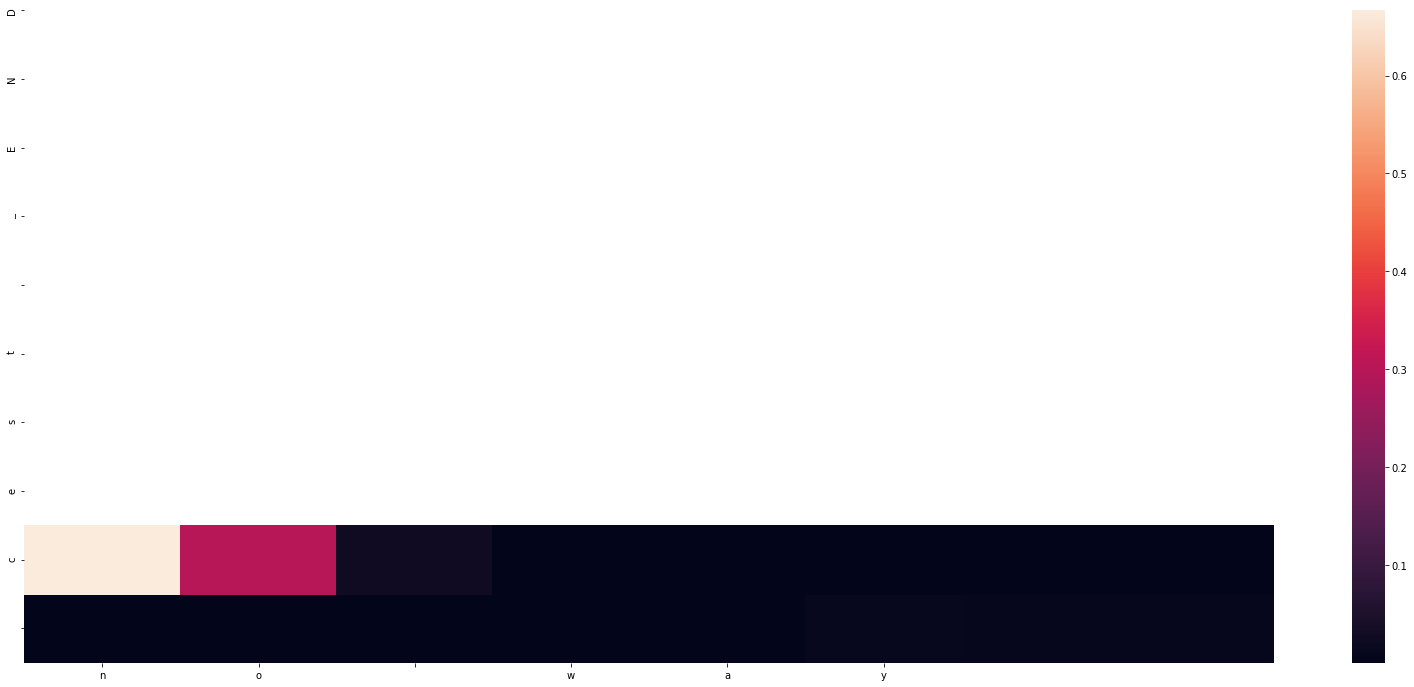

Decoded sentence:  cest _END
-
Input sentence: no way
GT sentence: START_ en aucune manière  _END


<Figure size 432x288 with 0 Axes>

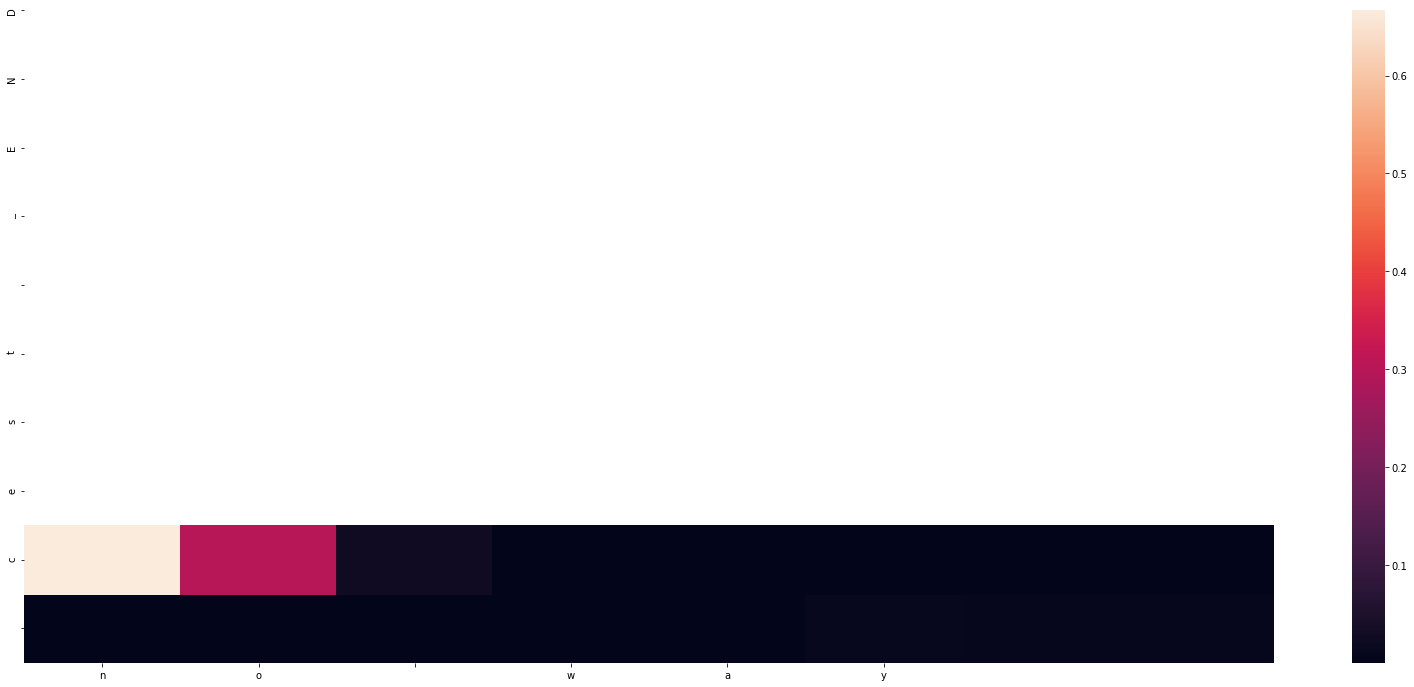

Decoded sentence:  cest _END
-
Input sentence: no way
GT sentence: START_ hors de question  _END


<Figure size 432x288 with 0 Axes>

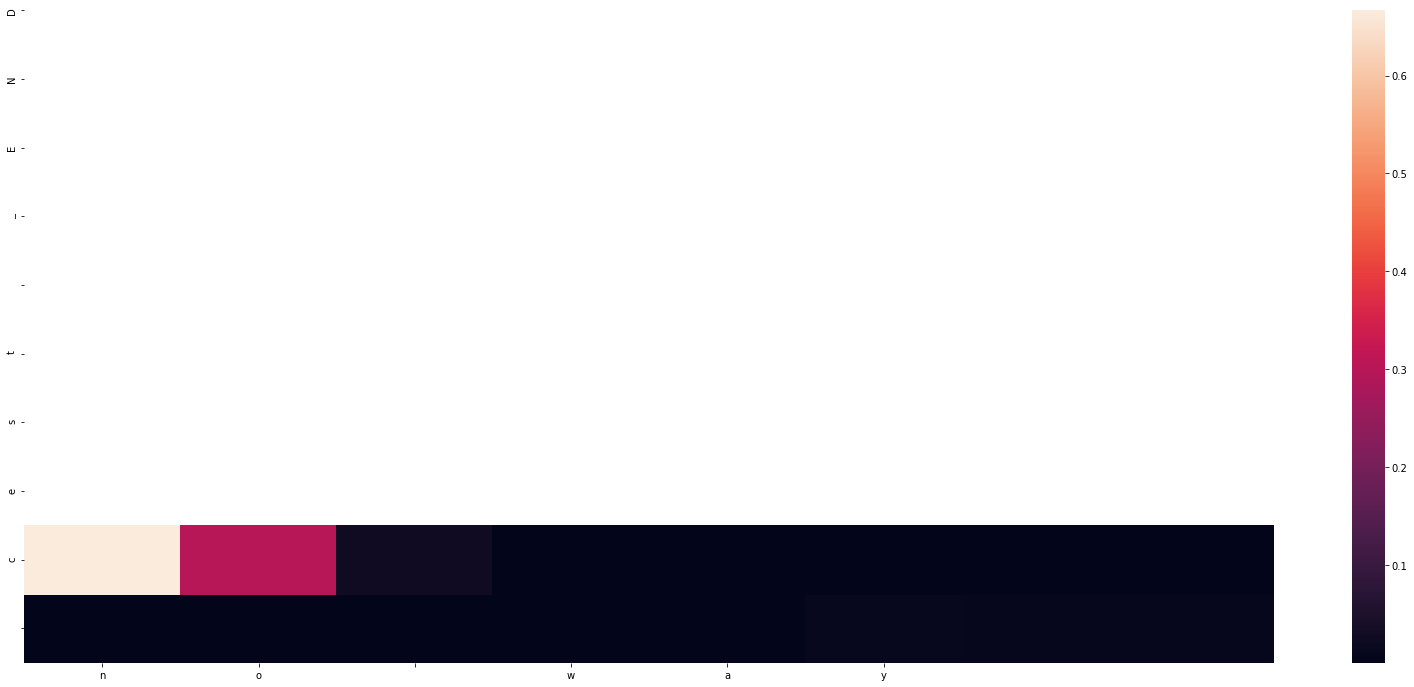

Decoded sentence:  cest _END
-
Input sentence: really
GT sentence: START_ vraiment  _END


<Figure size 432x288 with 0 Axes>

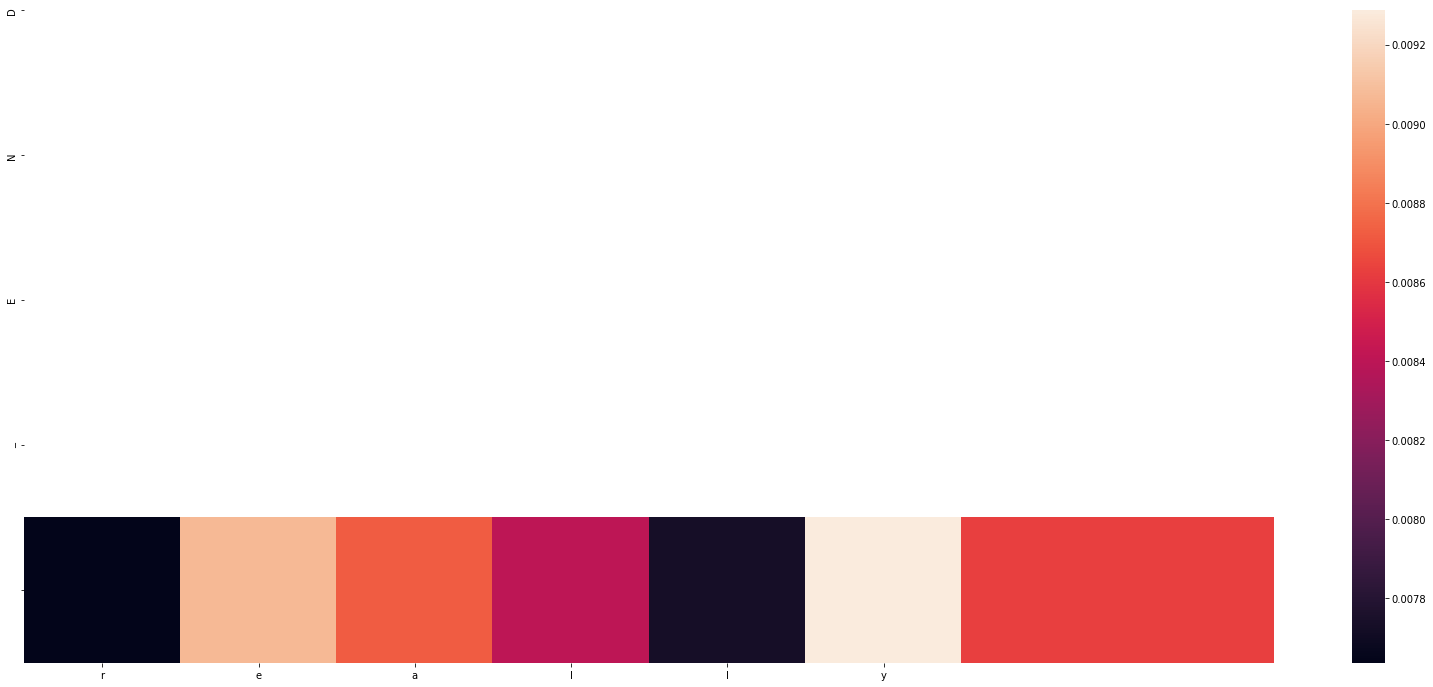

Decoded sentence:  _END
-
Input sentence: really
GT sentence: START_ vrai  _END


<Figure size 432x288 with 0 Axes>

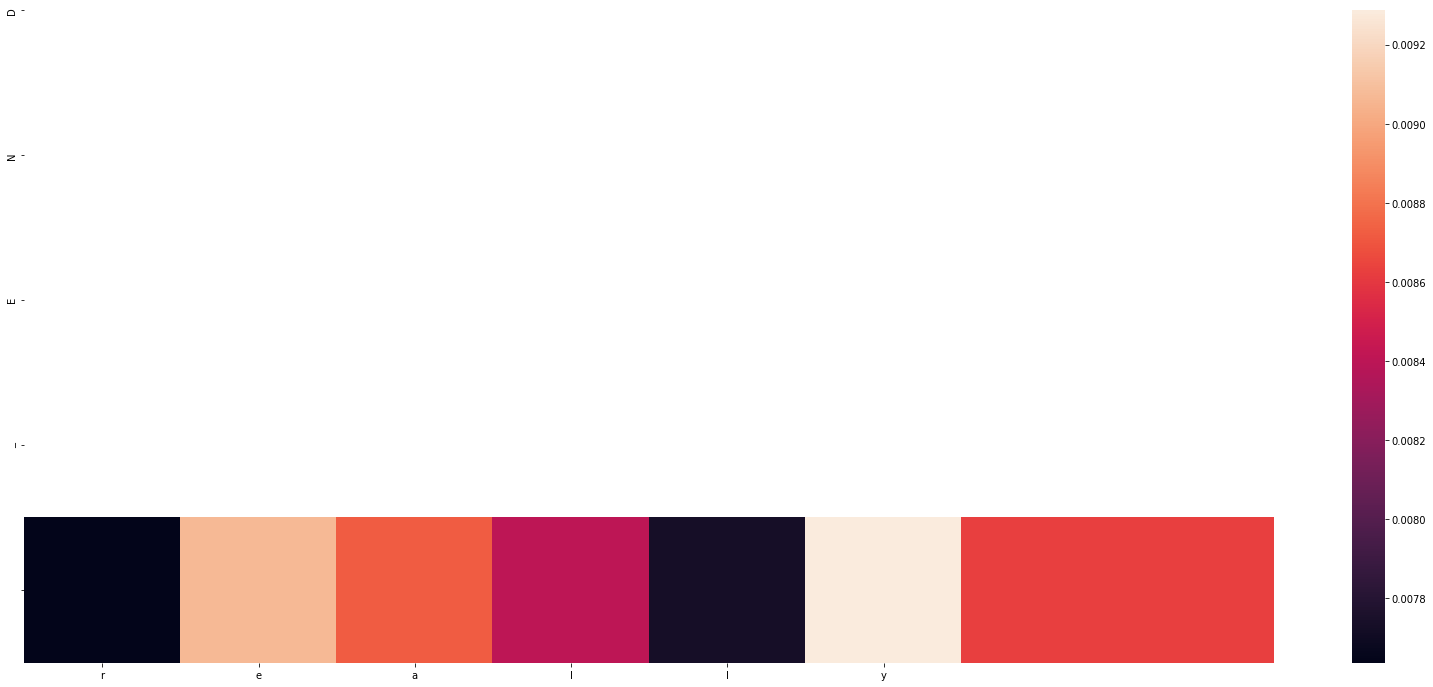

Decoded sentence:  _END
-
Input sentence: really
GT sentence: START_ ah bon  _END


<Figure size 432x288 with 0 Axes>

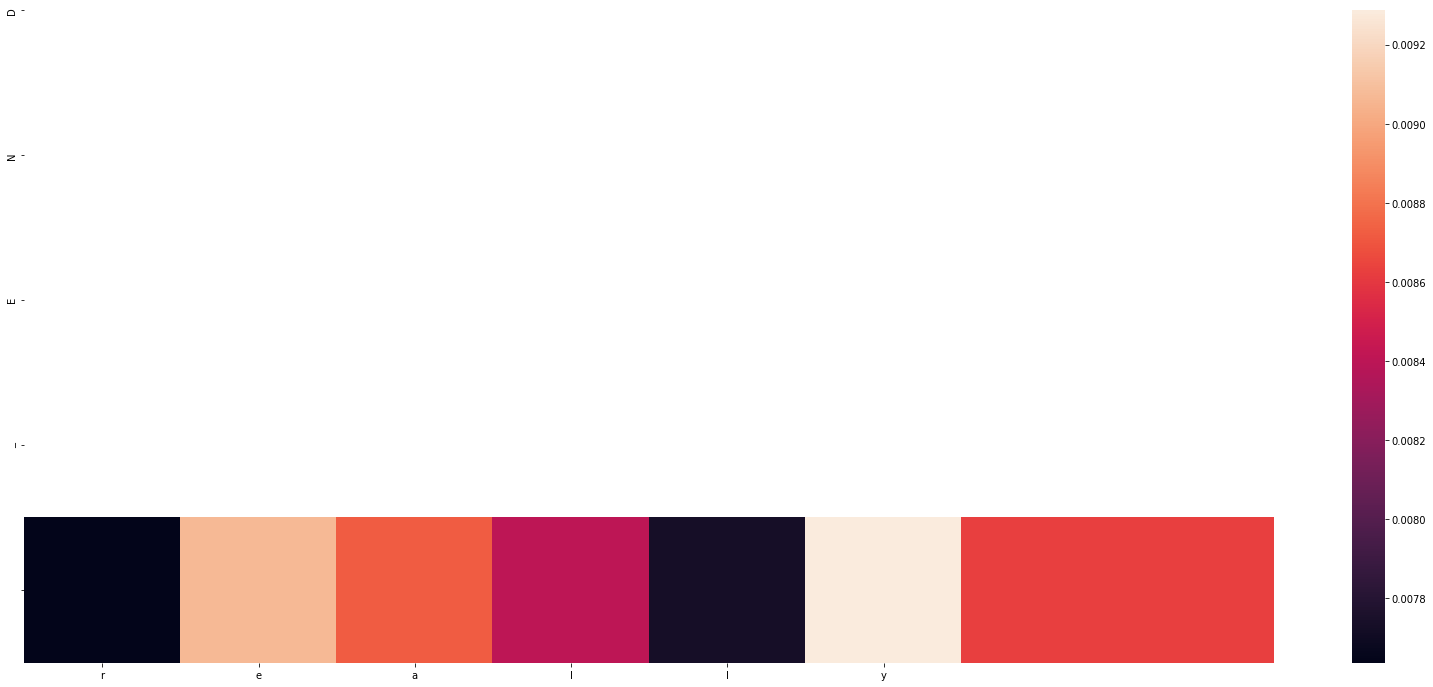

Decoded sentence:  _END
-
Input sentence: thanks
GT sentence: START_ merci  _END


<Figure size 432x288 with 0 Axes>

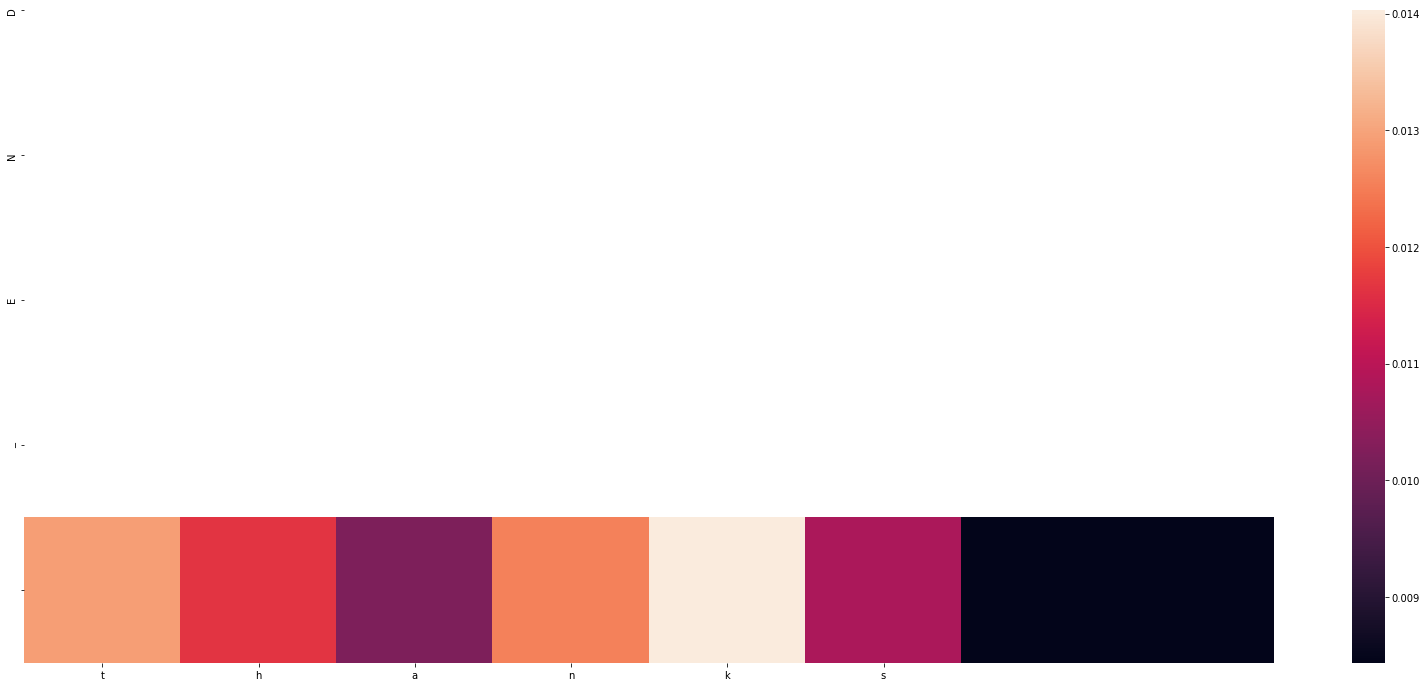

Decoded sentence:  _END
-
Input sentence: we try
GT sentence: START_ on essaye _END


<Figure size 432x288 with 0 Axes>

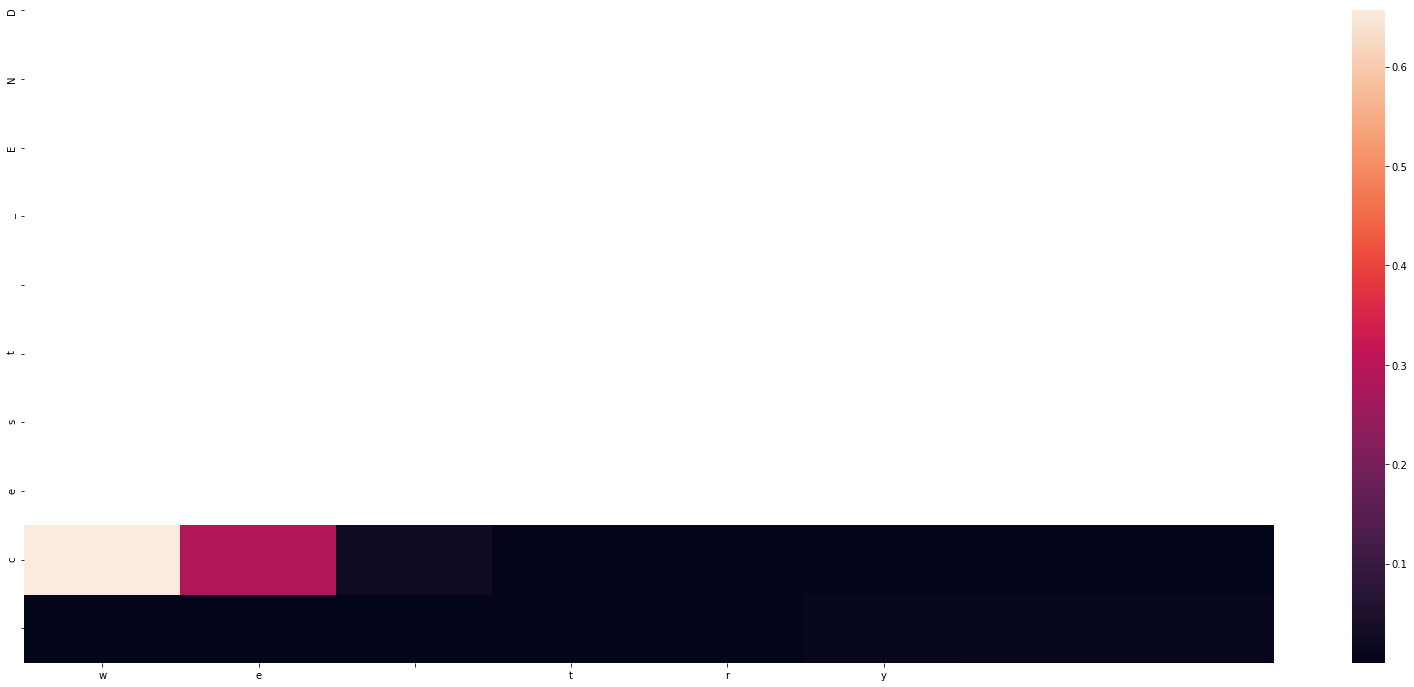

Decoded sentence:  cest _END
-
Input sentence: we won
GT sentence: START_ nous avons gagné _END


<Figure size 432x288 with 0 Axes>

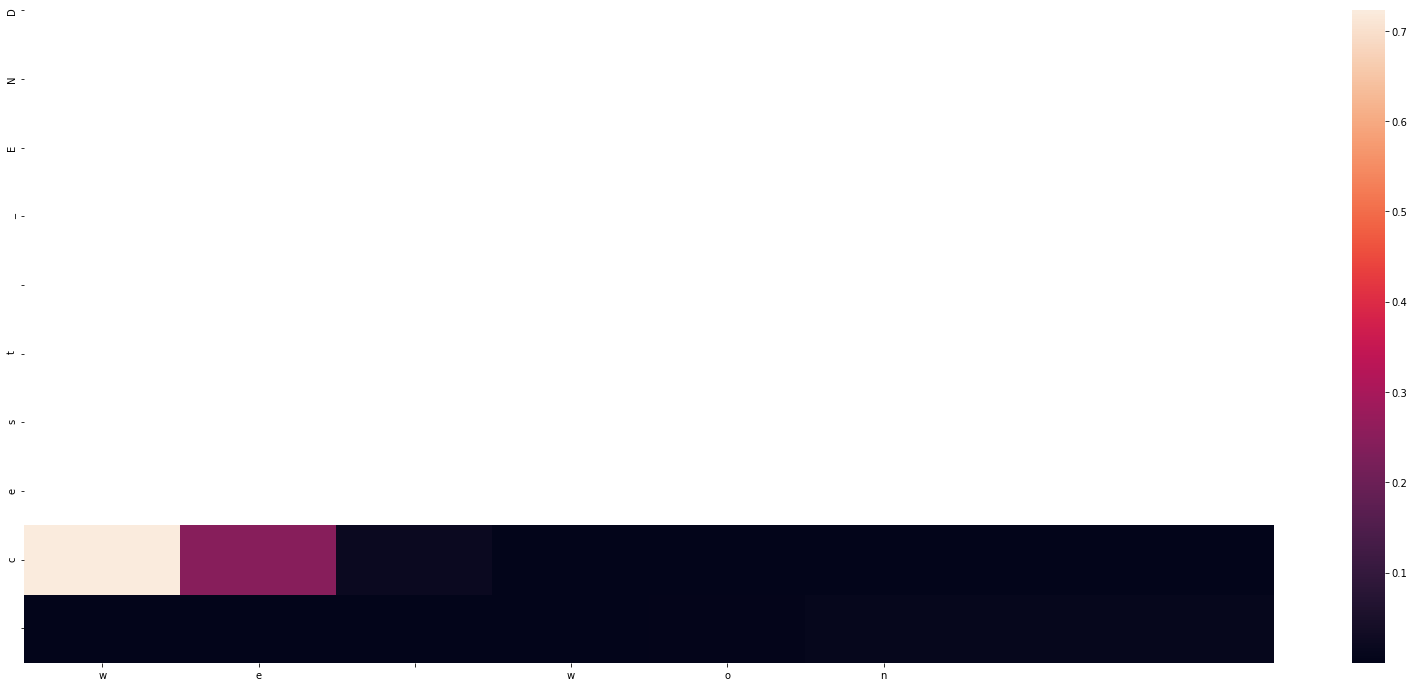

Decoded sentence:  cest _END
-
Input sentence: we won
GT sentence: START_ nous gagnâmes _END


<Figure size 432x288 with 0 Axes>

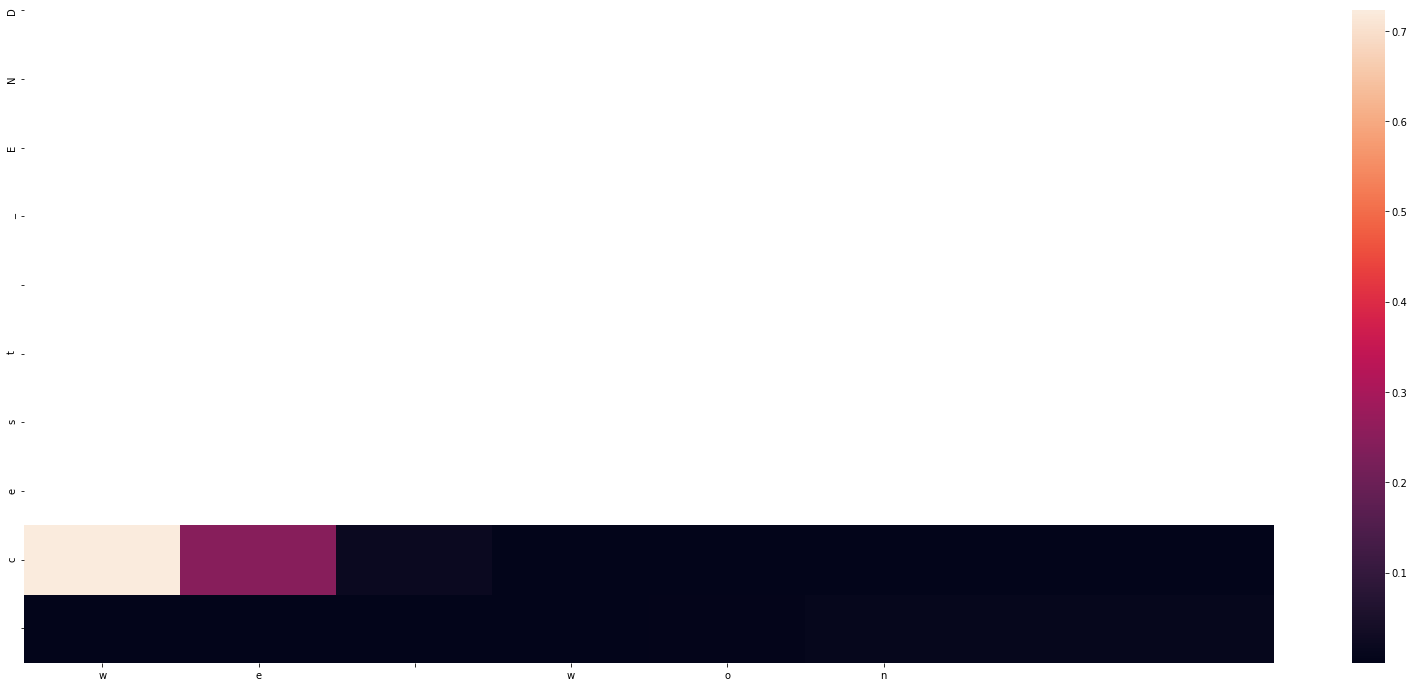

Decoded sentence:  cest _END
-
Input sentence: we won
GT sentence: START_ nous lavons emporté _END


<Figure size 432x288 with 0 Axes>

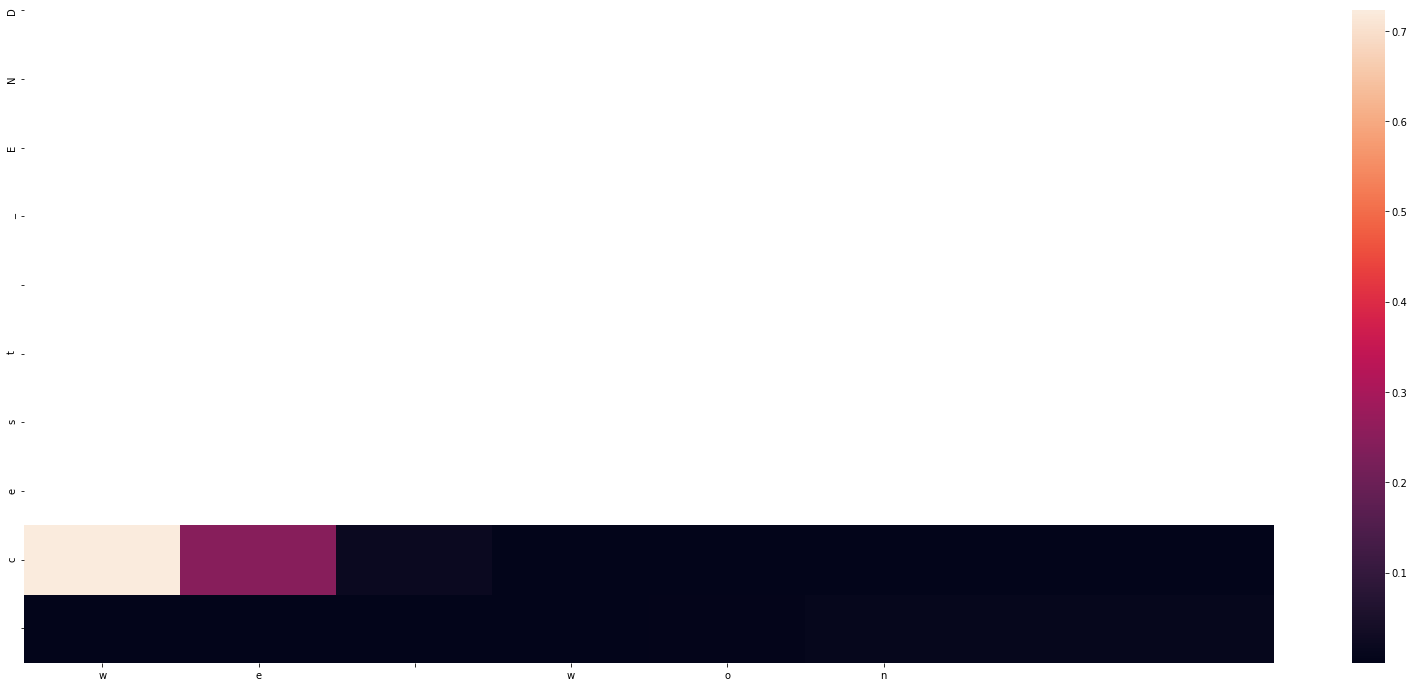

Decoded sentence:  cest _END
-
Input sentence: we won
GT sentence: START_ nous lemportâmes _END


<Figure size 432x288 with 0 Axes>

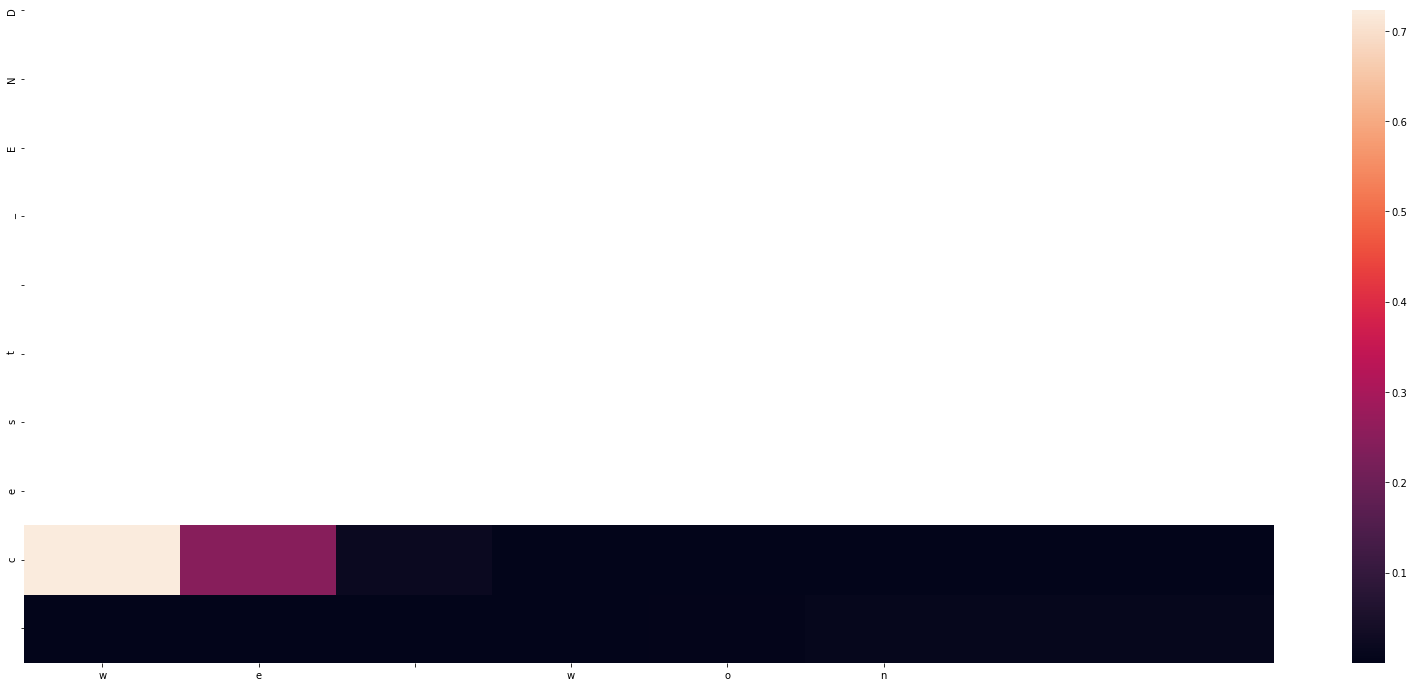

Decoded sentence:  cest _END
-
Input sentence: ask tom
GT sentence: START_ demande à tom _END


<Figure size 432x288 with 0 Axes>

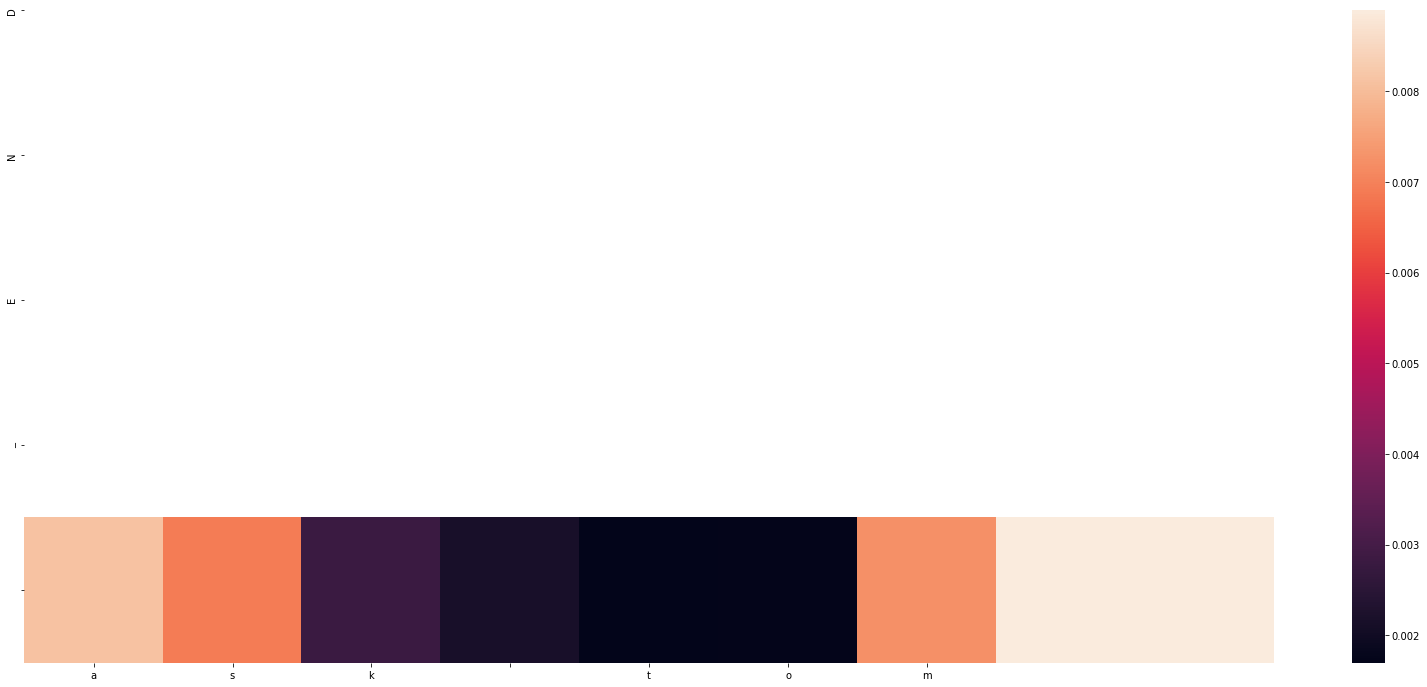

Decoded sentence:  _END
-
Input sentence: awesome
GT sentence: START_ fantastique  _END


<Figure size 432x288 with 0 Axes>

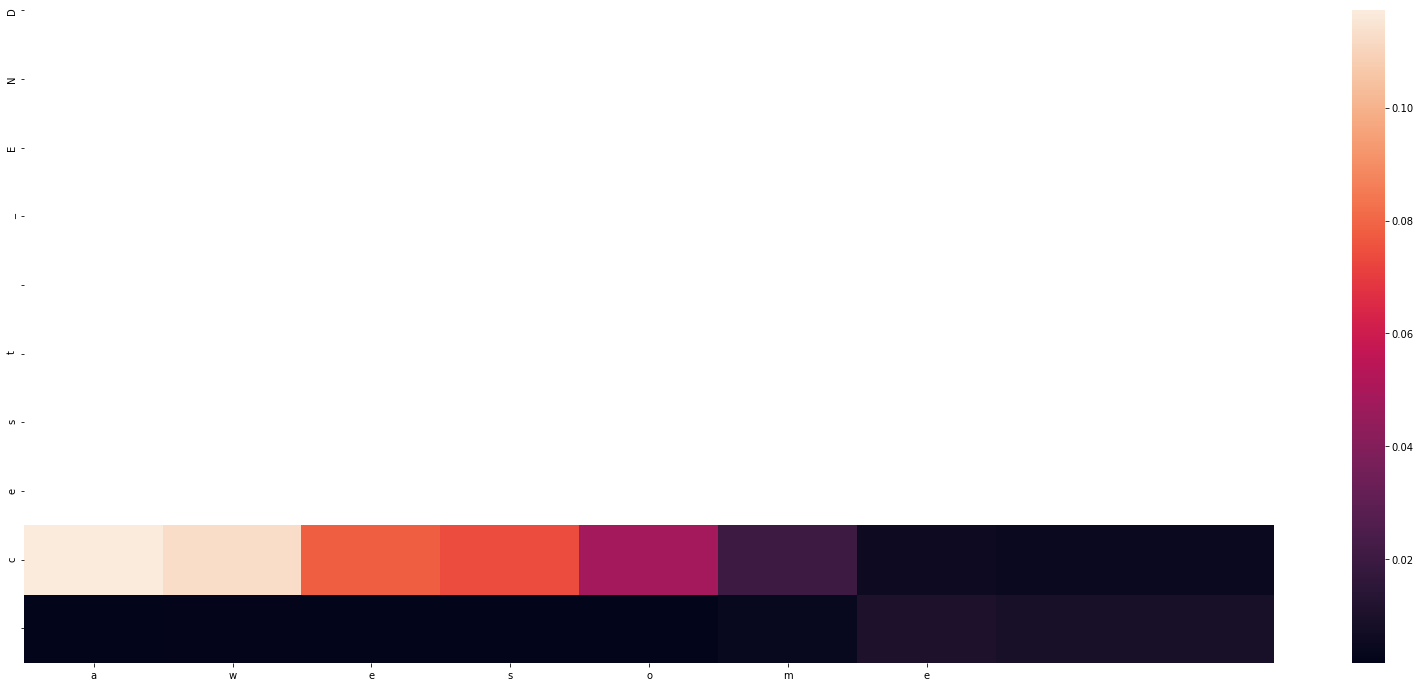

Decoded sentence:  cest _END
-
Input sentence: be calm
GT sentence: START_ sois calme  _END


<Figure size 432x288 with 0 Axes>

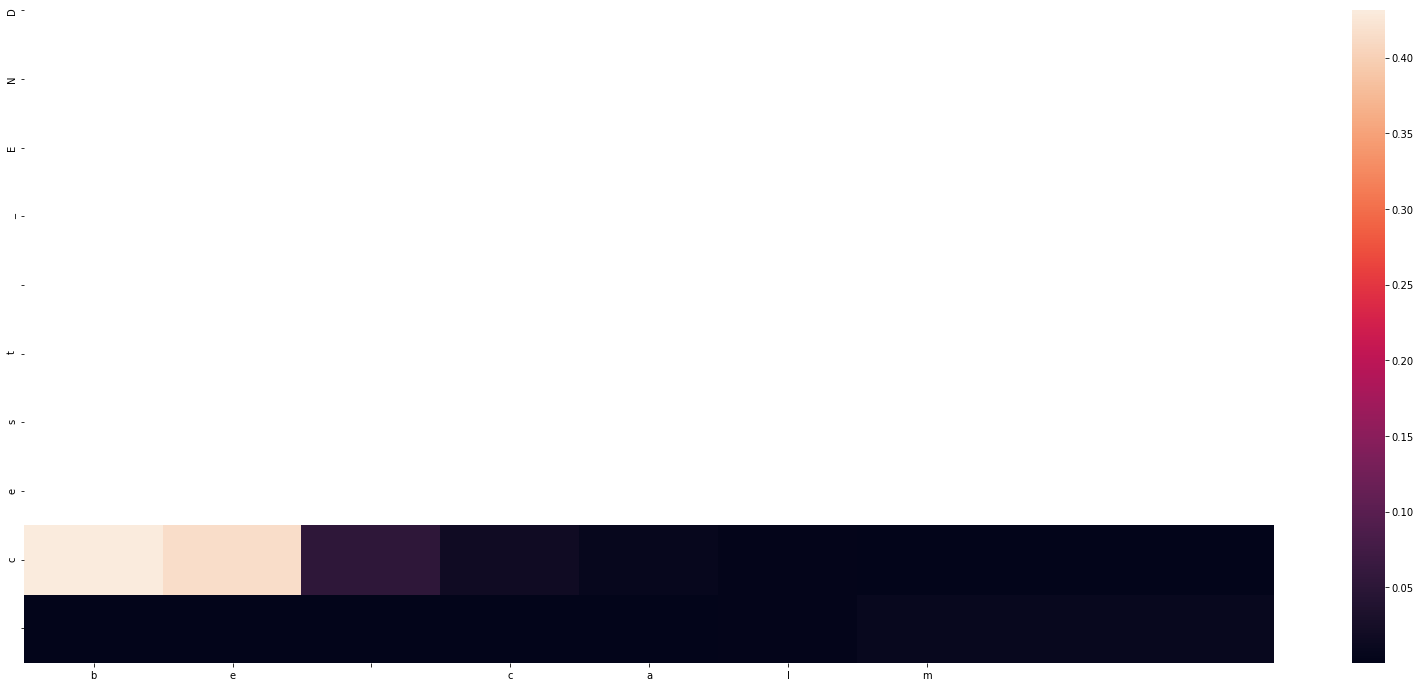

Decoded sentence:  cest _END
-
Input sentence: be calm
GT sentence: START_ soyez calme  _END


<Figure size 432x288 with 0 Axes>

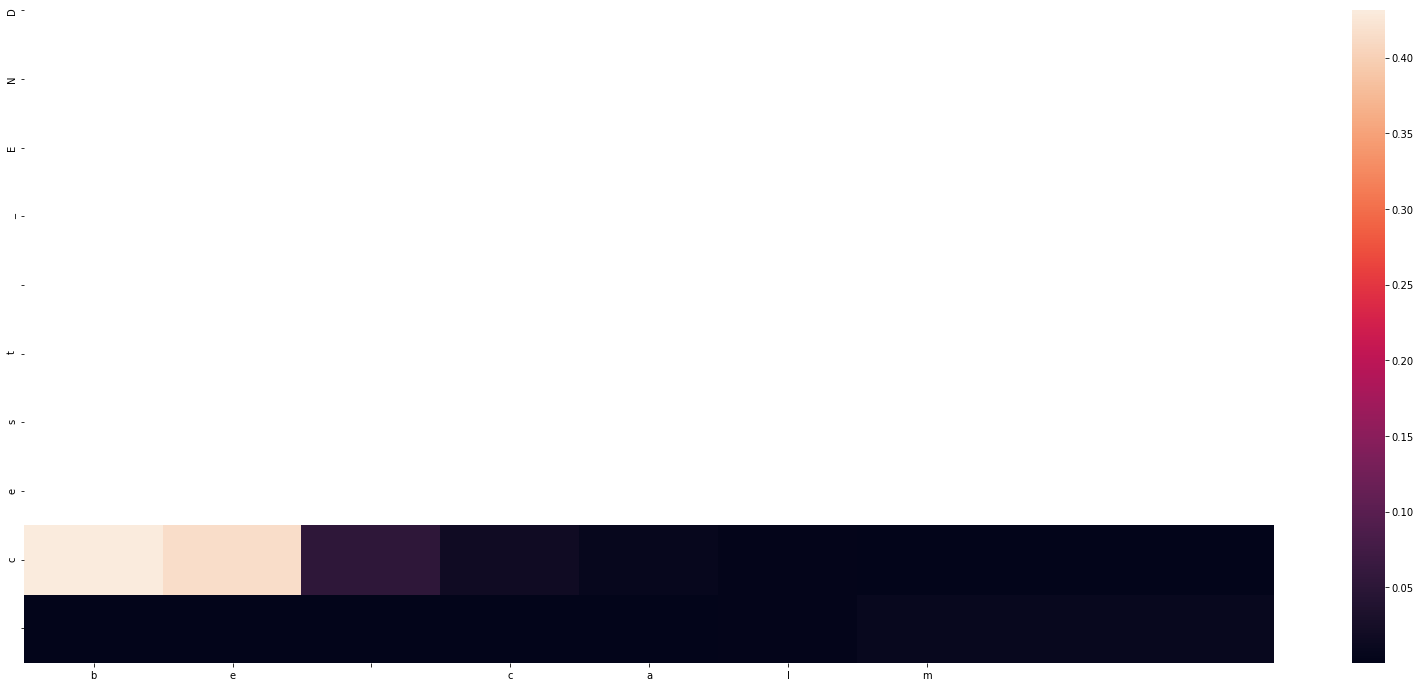

Decoded sentence:  cest _END
-
Input sentence: be calm
GT sentence: START_ soyez calmes  _END


<Figure size 432x288 with 0 Axes>

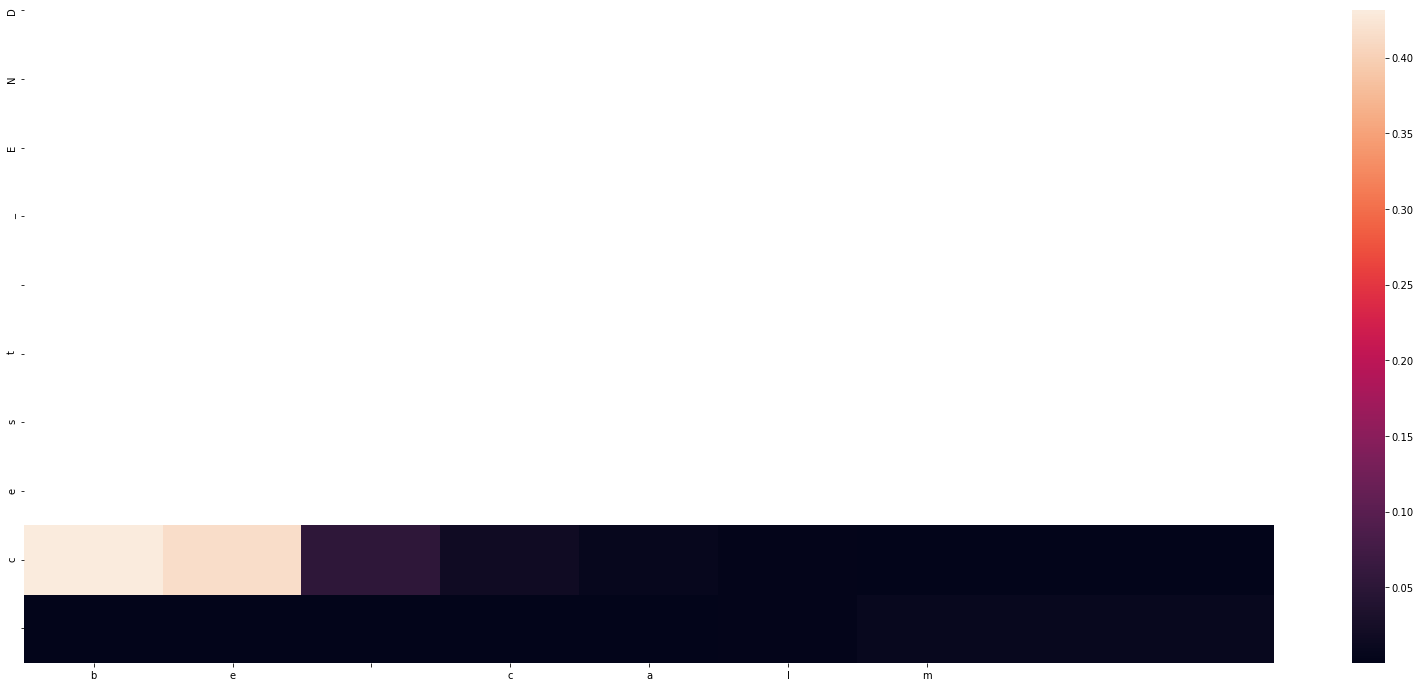

Decoded sentence:  cest _END
-
Input sentence: be cool
GT sentence: START_ sois détendu  _END


<Figure size 432x288 with 0 Axes>

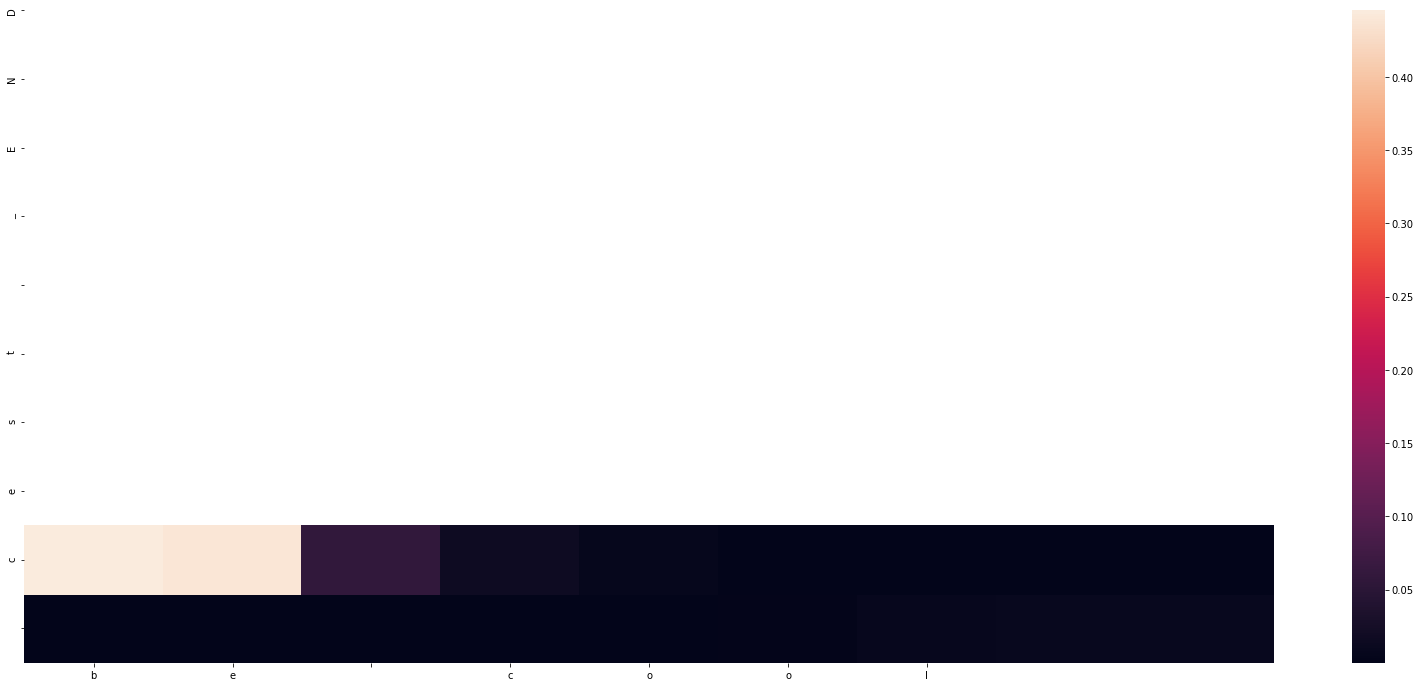

Decoded sentence:  cest _END
-
Input sentence: be fair
GT sentence: START_ sois juste  _END


<Figure size 432x288 with 0 Axes>

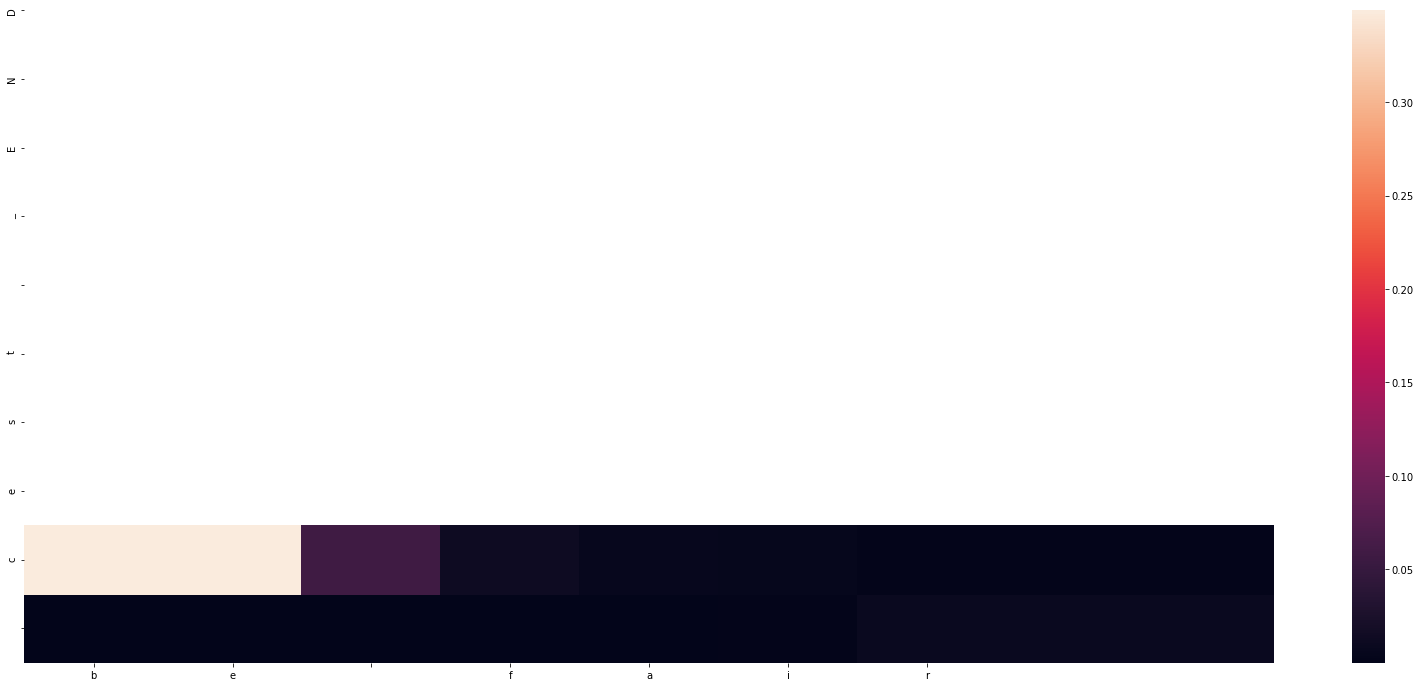

Decoded sentence:  cest _END
-
Input sentence: be fair
GT sentence: START_ soyez juste  _END


<Figure size 432x288 with 0 Axes>

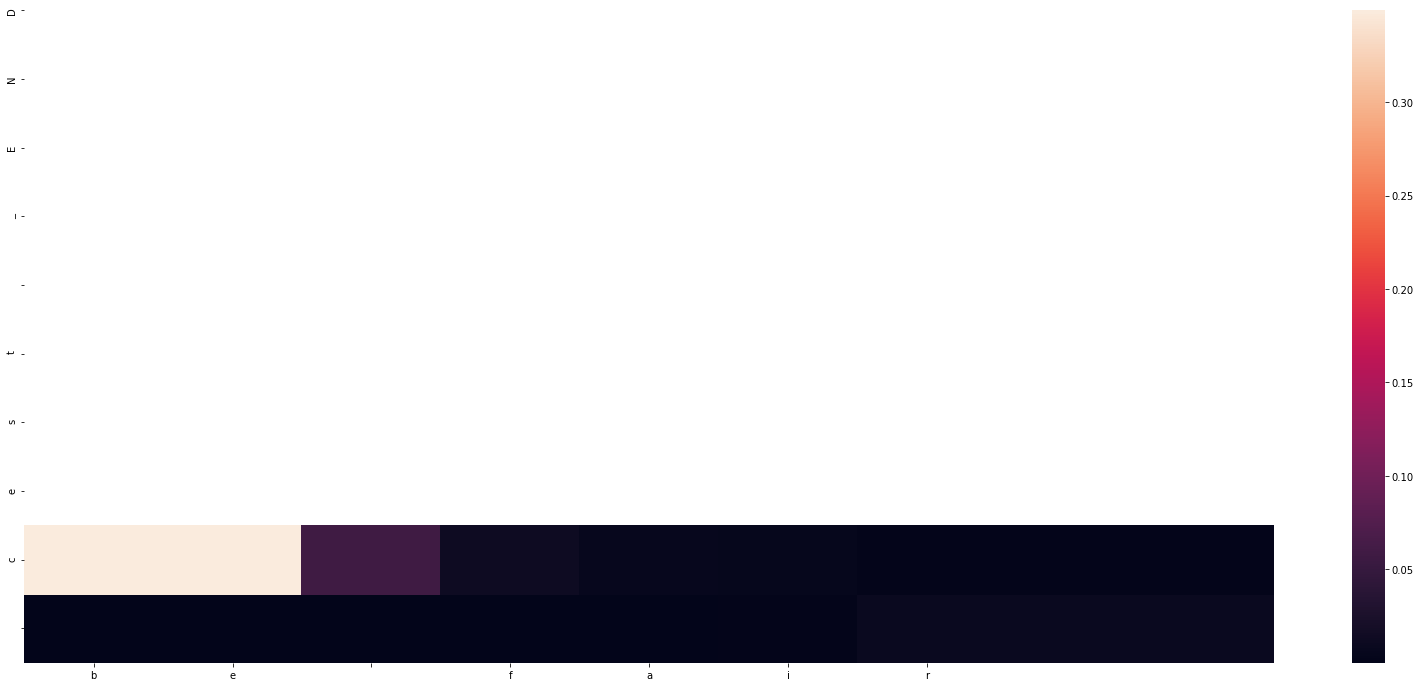

Decoded sentence:  cest _END
-
Input sentence: be fair
GT sentence: START_ soyez justes  _END


<Figure size 432x288 with 0 Axes>

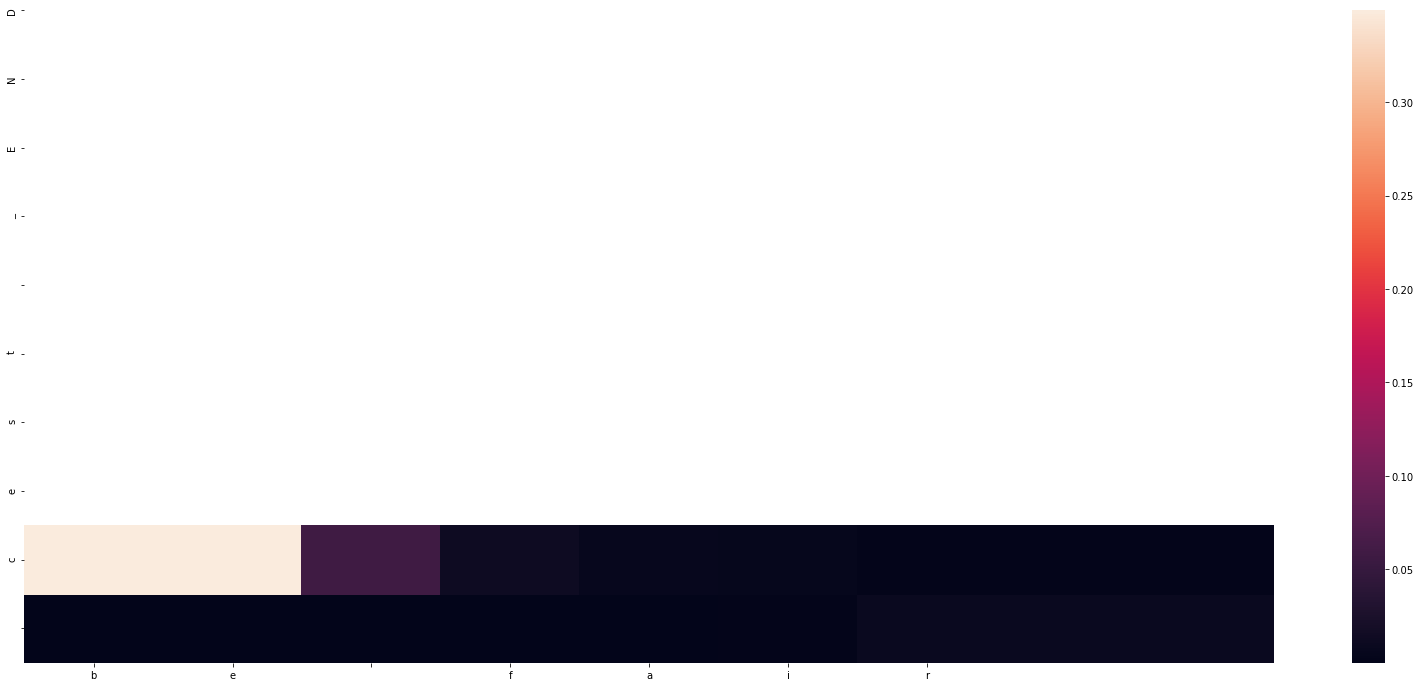

Decoded sentence:  cest _END
-
Input sentence: be fair
GT sentence: START_ sois équitable  _END


<Figure size 432x288 with 0 Axes>

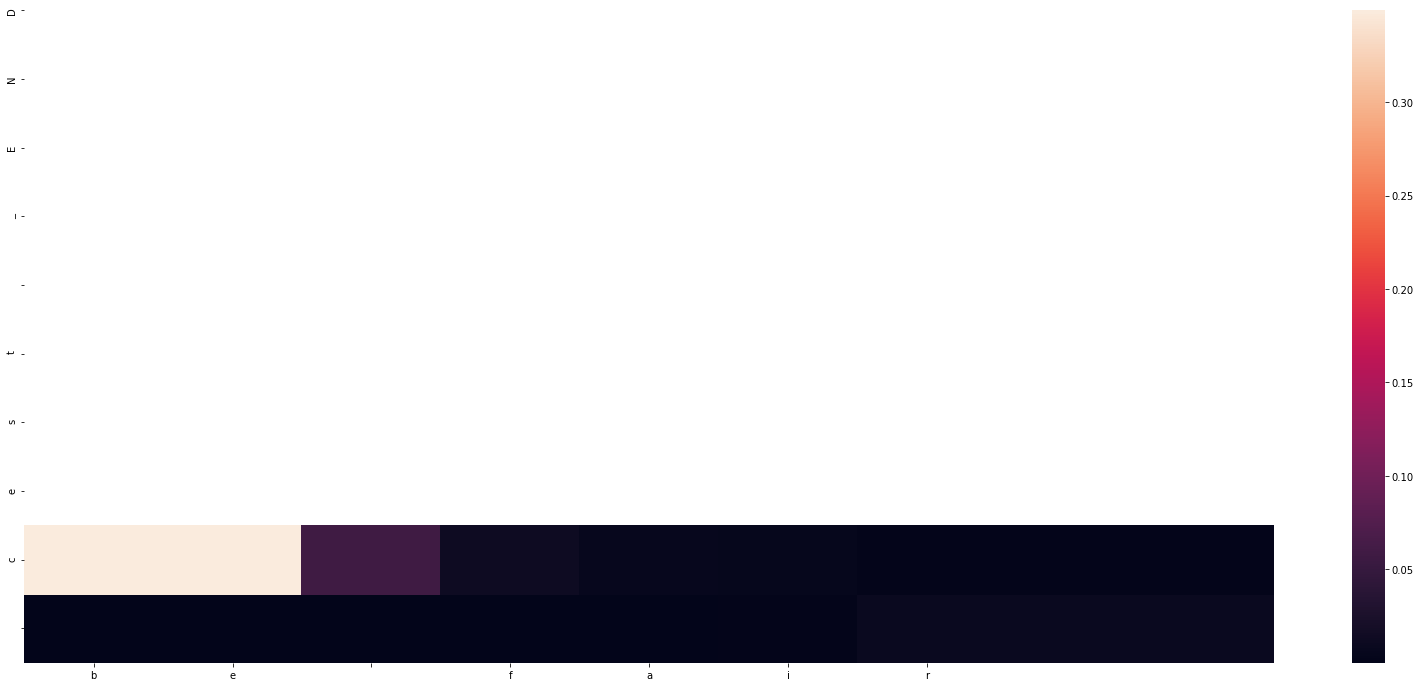

Decoded sentence:  cest _END
-
Input sentence: be fair
GT sentence: START_ soyez équitable  _END


<Figure size 432x288 with 0 Axes>

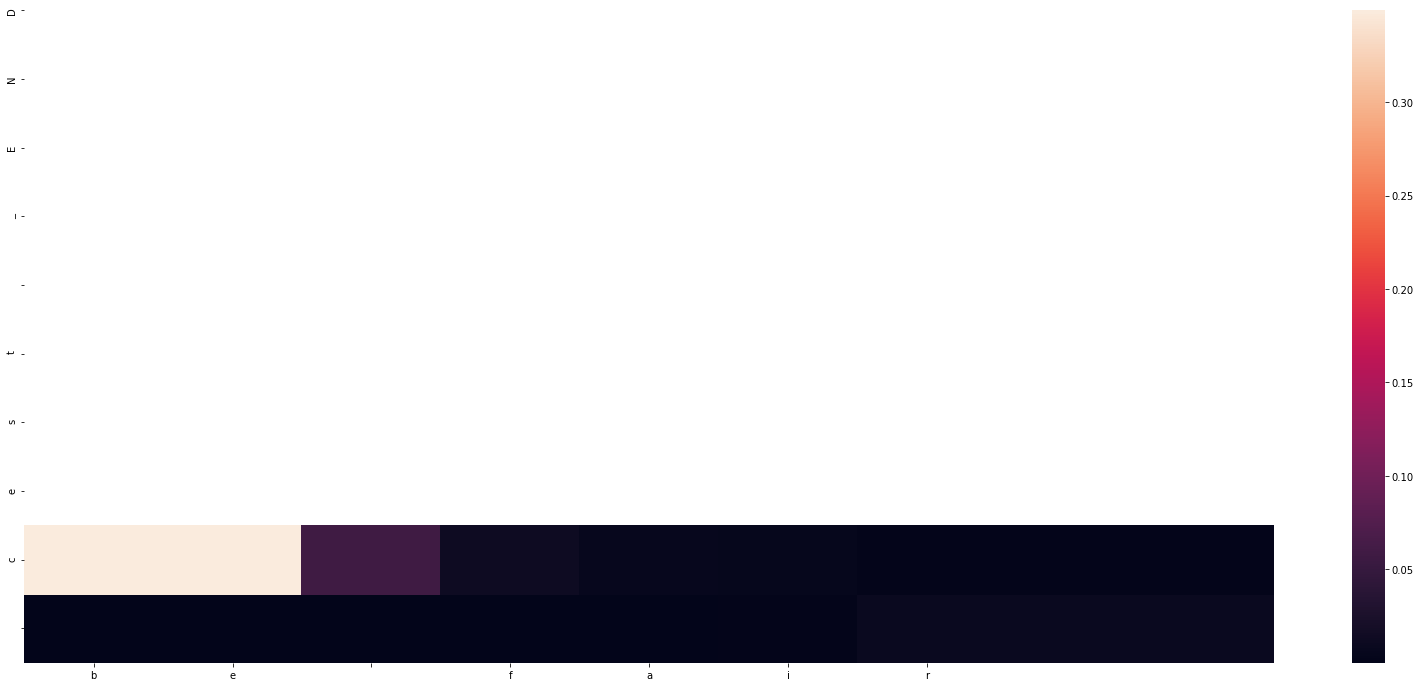

Decoded sentence:  cest _END
-
Input sentence: be fair
GT sentence: START_ soyez équitables  _END


<Figure size 432x288 with 0 Axes>

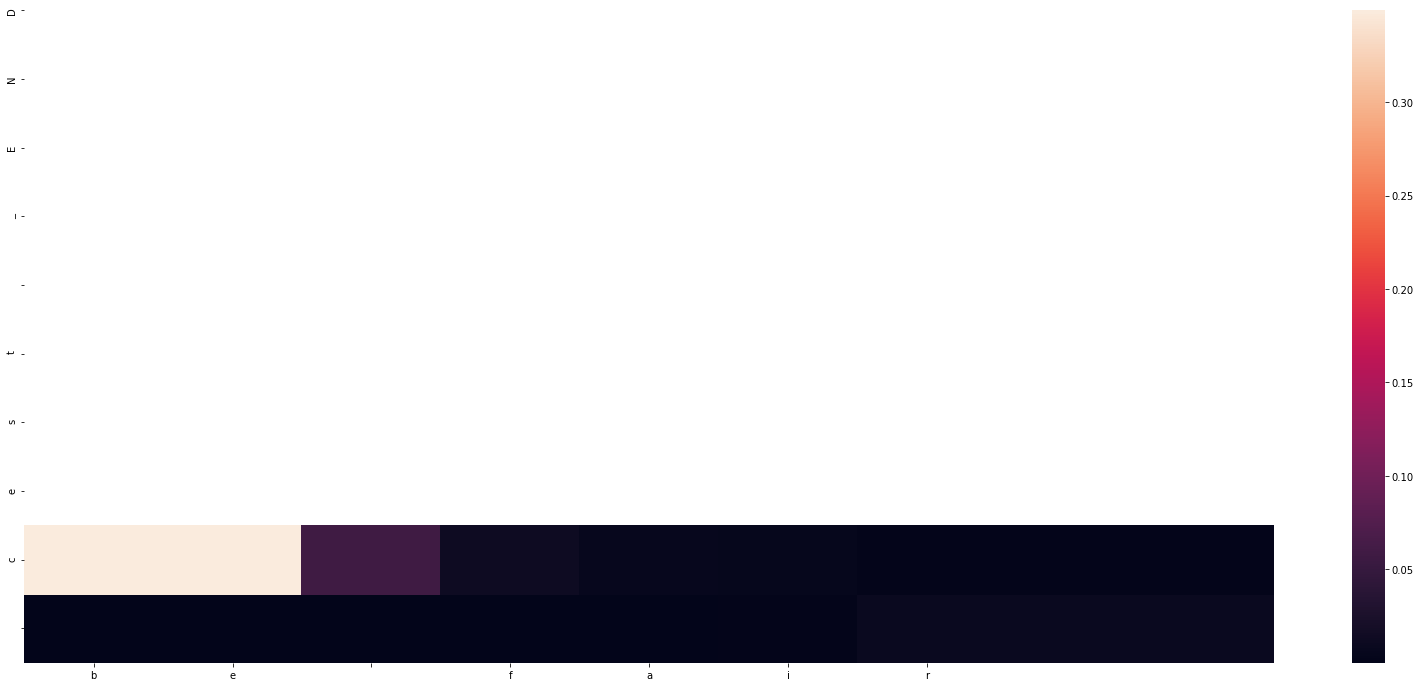

Decoded sentence:  cest _END
-
Input sentence: be kind
GT sentence: START_ sois gentil _END


<Figure size 432x288 with 0 Axes>

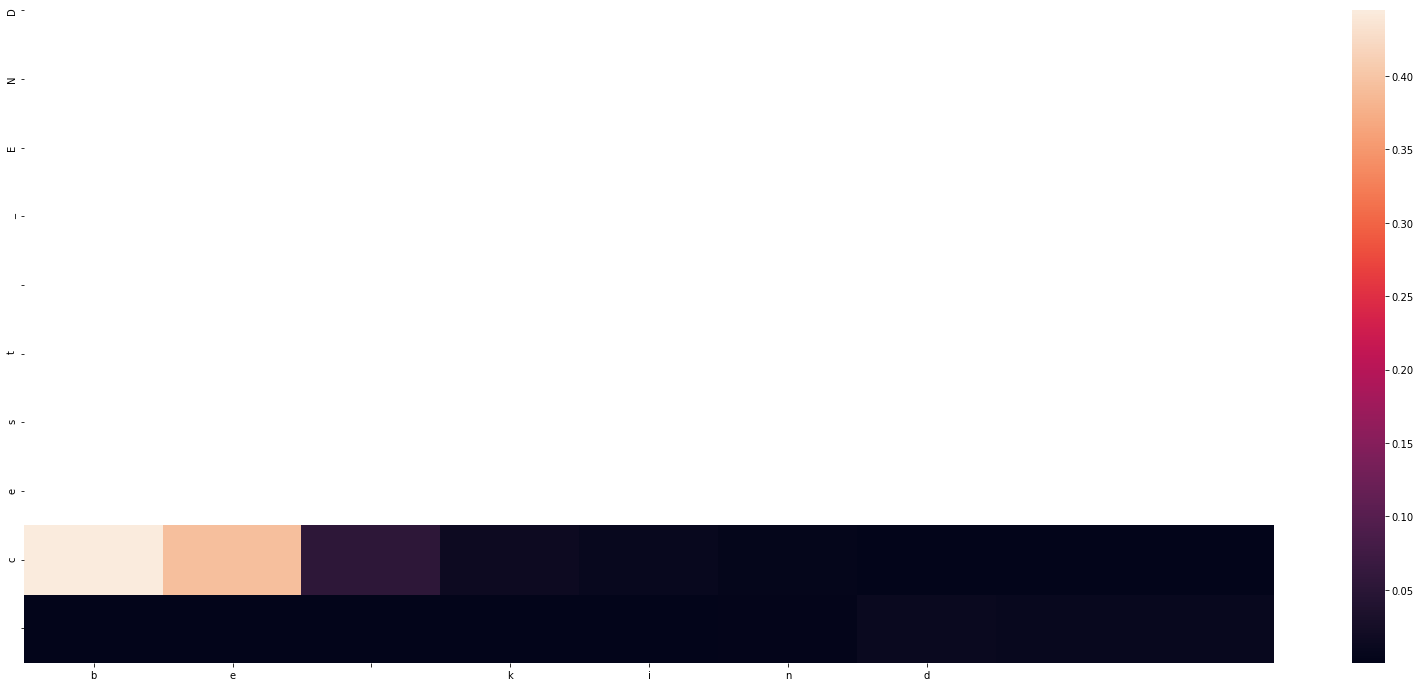

Decoded sentence:  cest _END
-
Input sentence: be nice
GT sentence: START_ sois gentil  _END


<Figure size 432x288 with 0 Axes>

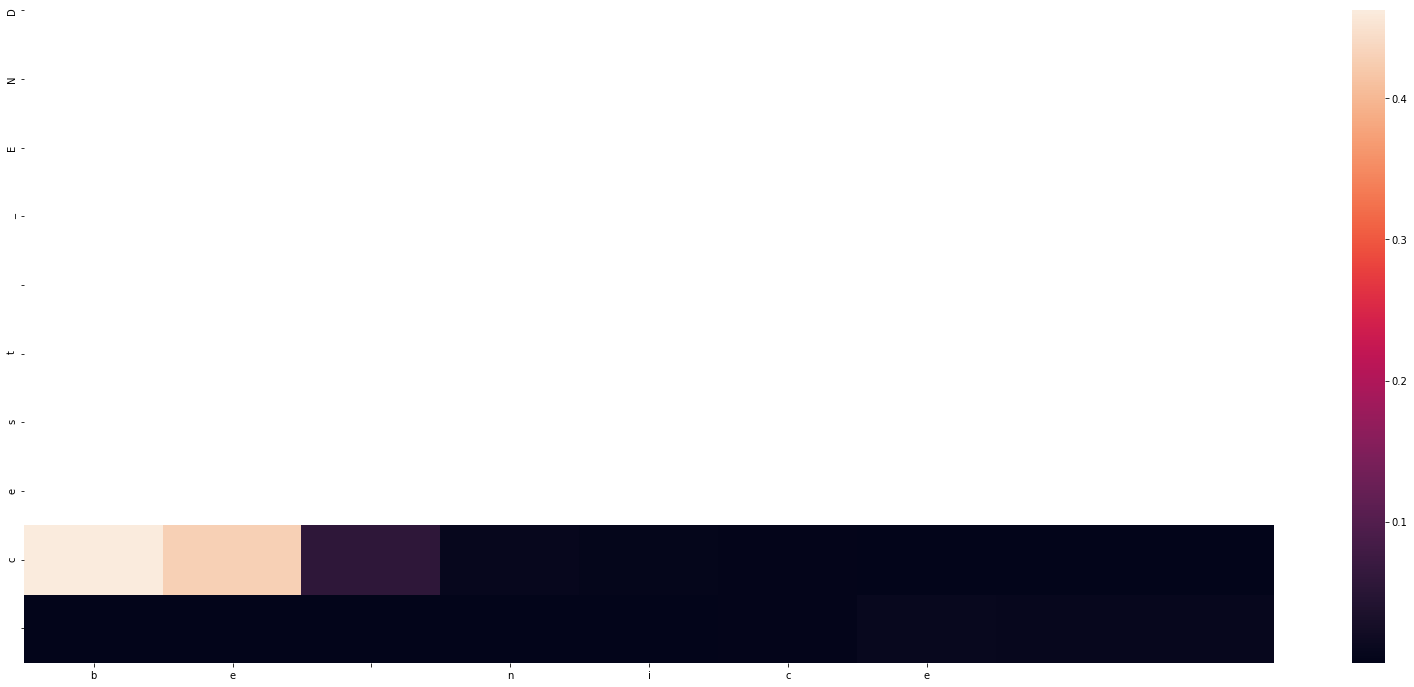

Decoded sentence:  cest _END
-
Input sentence: be nice
GT sentence: START_ sois gentille  _END


<Figure size 432x288 with 0 Axes>

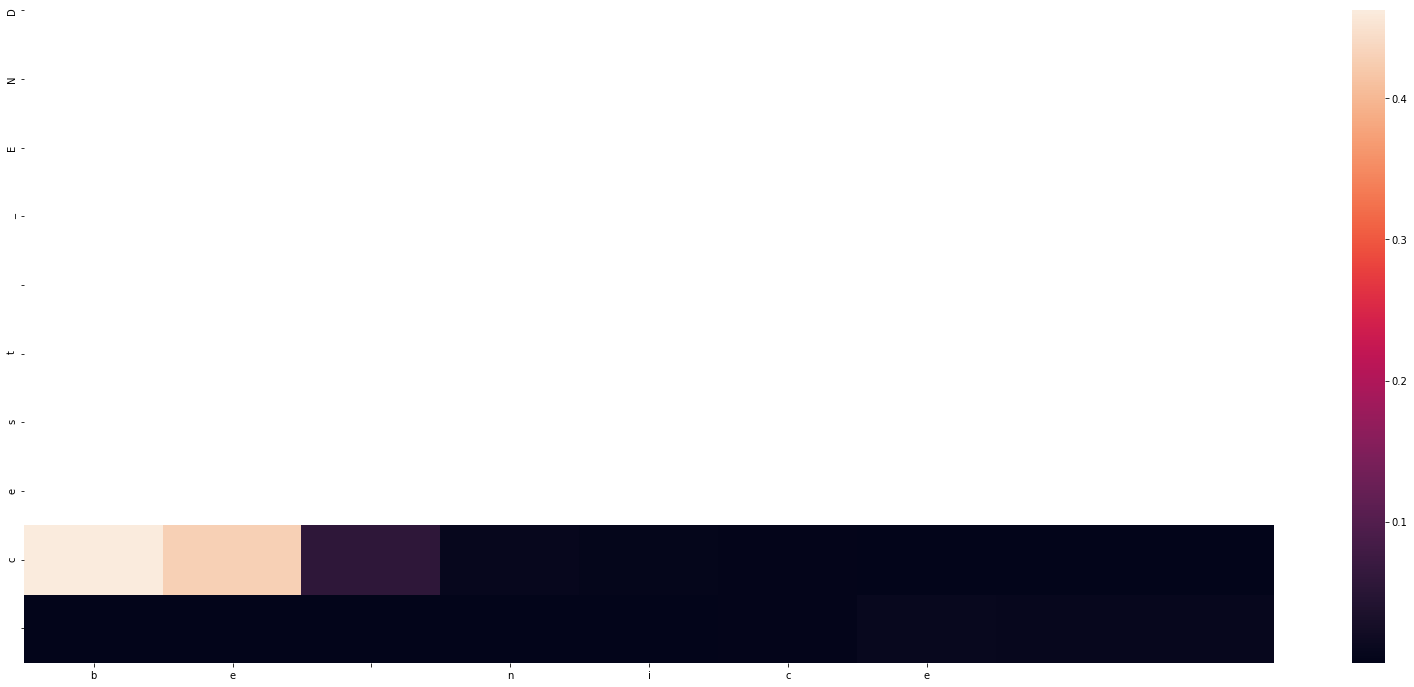

Decoded sentence:  cest _END
-
Input sentence: be nice
GT sentence: START_ soyez gentil  _END


<Figure size 432x288 with 0 Axes>

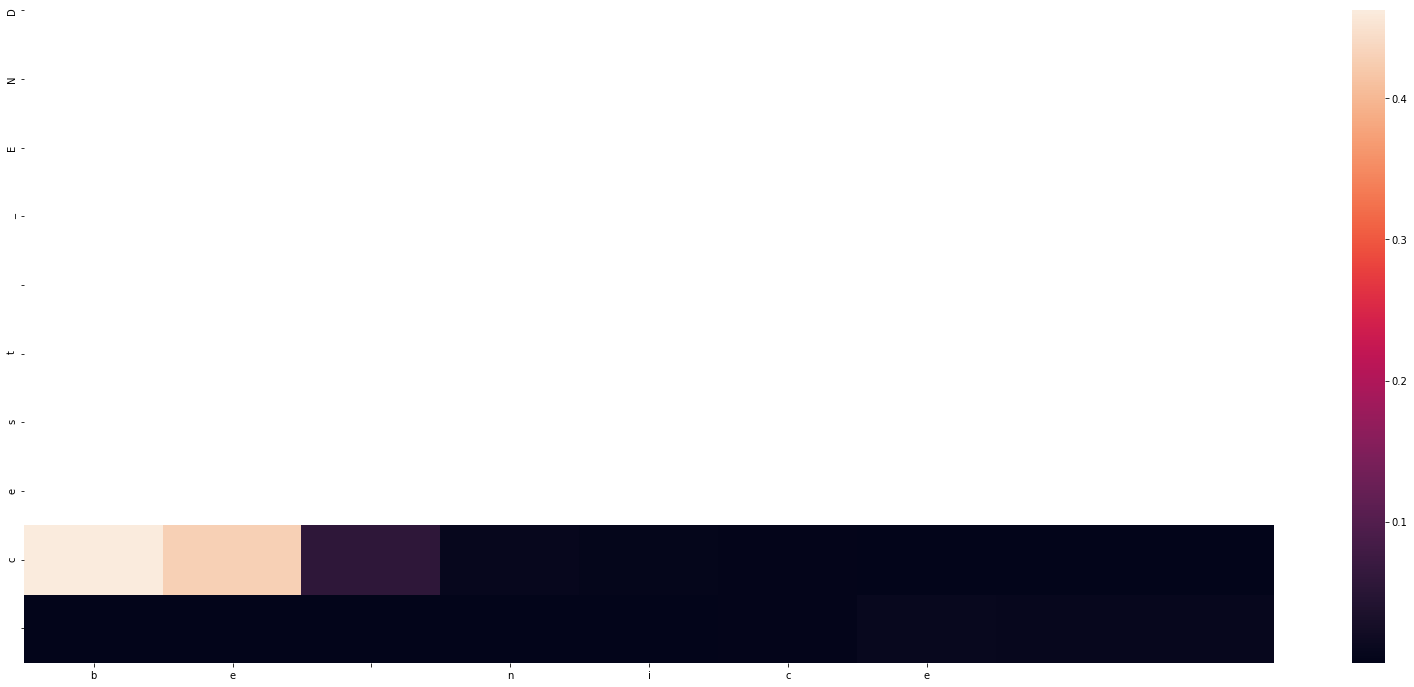

Decoded sentence:  cest _END
-
Input sentence: be nice
GT sentence: START_ soyez gentille  _END


<Figure size 432x288 with 0 Axes>

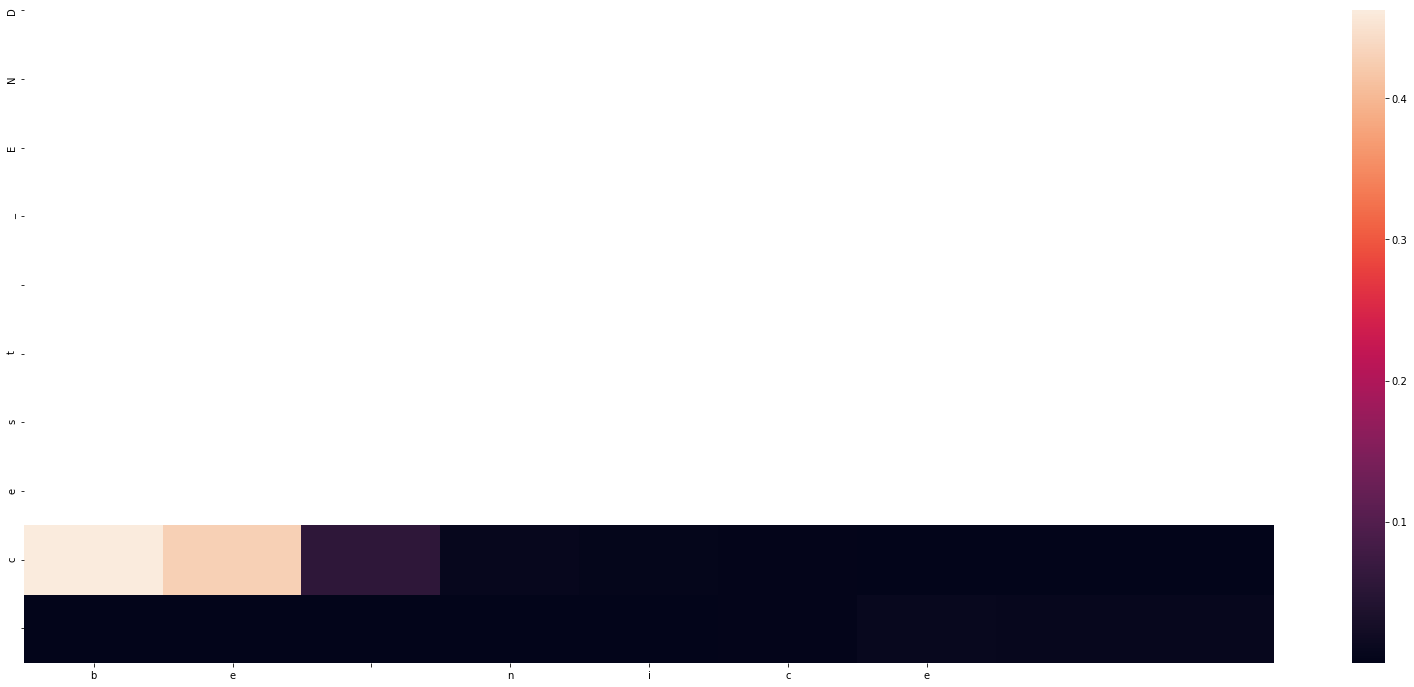

Decoded sentence:  cest _END
-
Input sentence: be nice
GT sentence: START_ soyez gentils  _END


<Figure size 432x288 with 0 Axes>

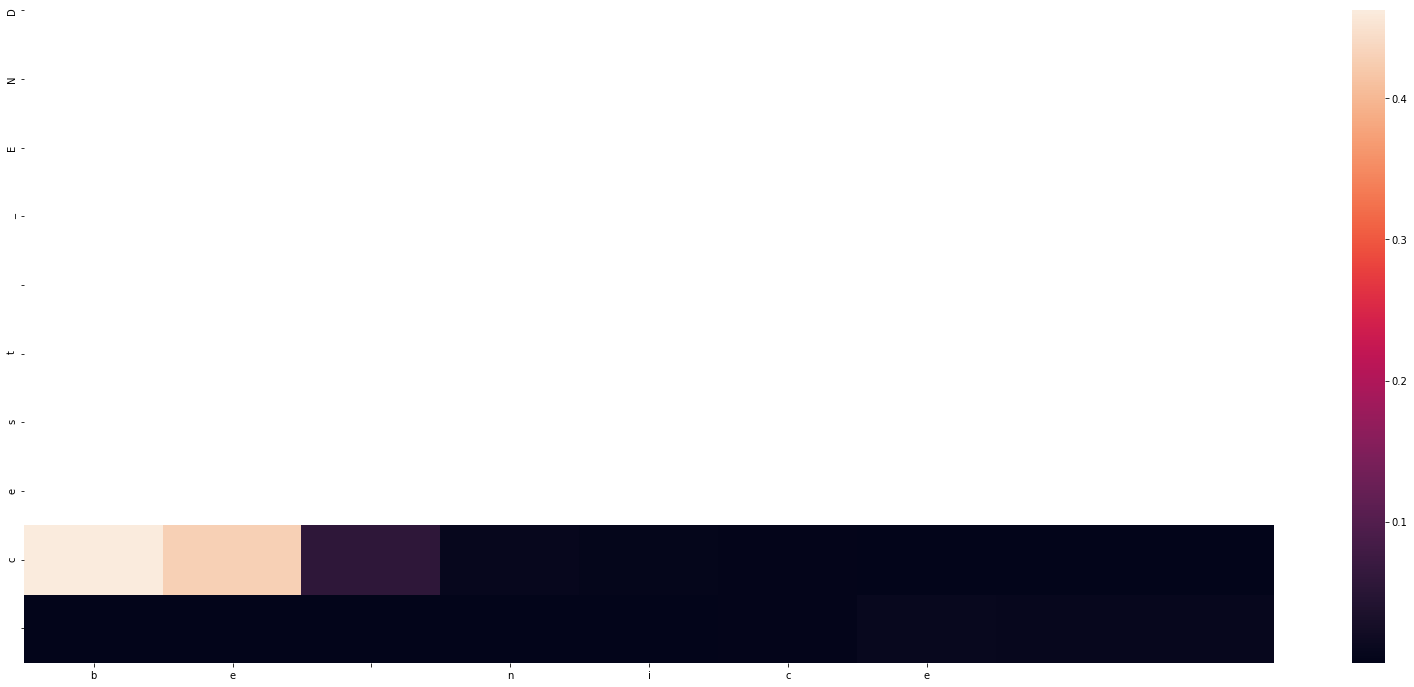

Decoded sentence:  cest _END
-
Input sentence: be nice
GT sentence: START_ soyez gentilles  _END


<Figure size 432x288 with 0 Axes>

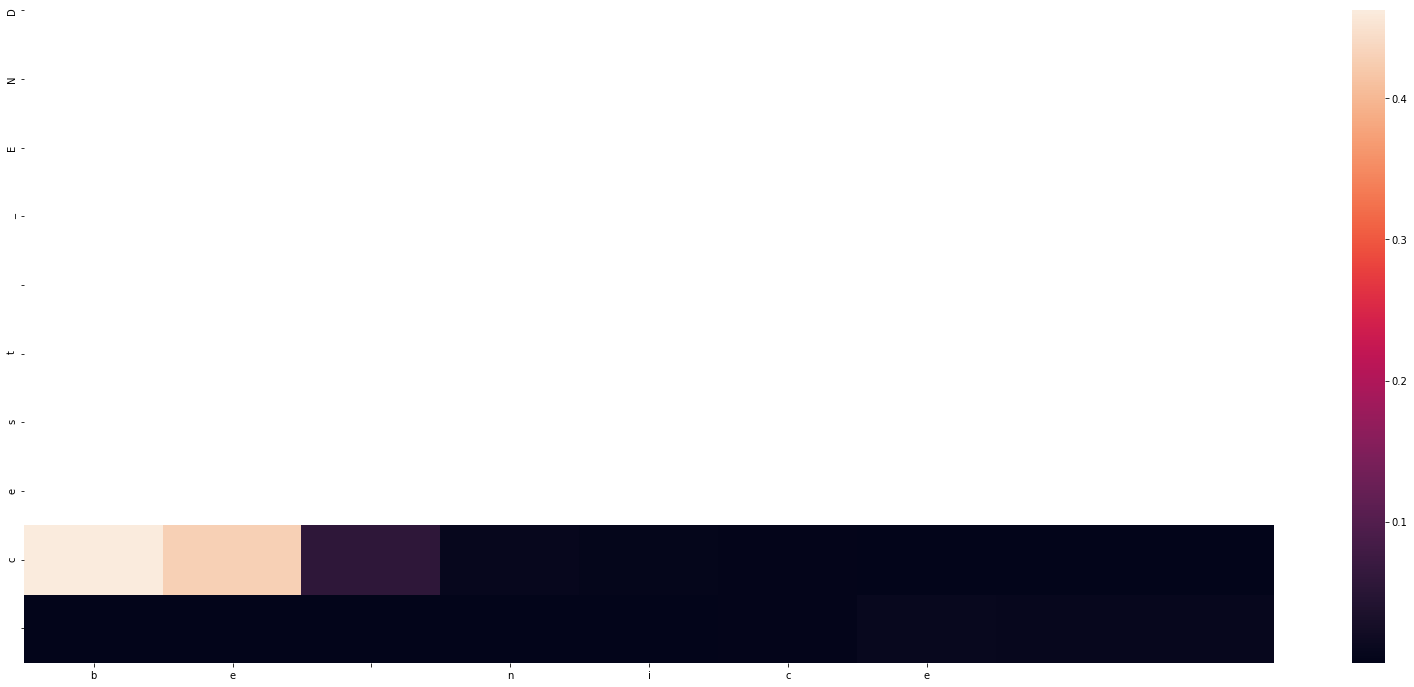

Decoded sentence:  cest _END
-
Input sentence: beat it
GT sentence: START_ dégage  _END


<Figure size 432x288 with 0 Axes>

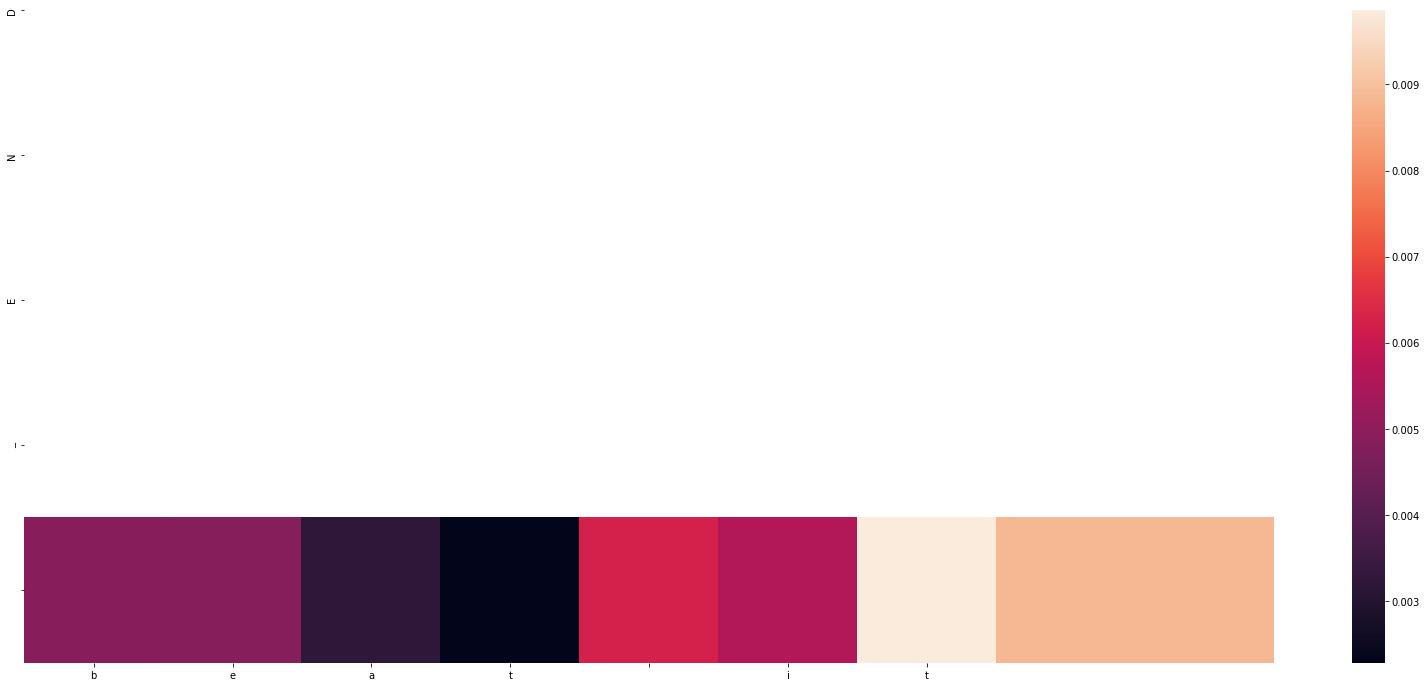

Decoded sentence:  _END
-
Input sentence: call me
GT sentence: START_ appellemoi  _END


<Figure size 432x288 with 0 Axes>

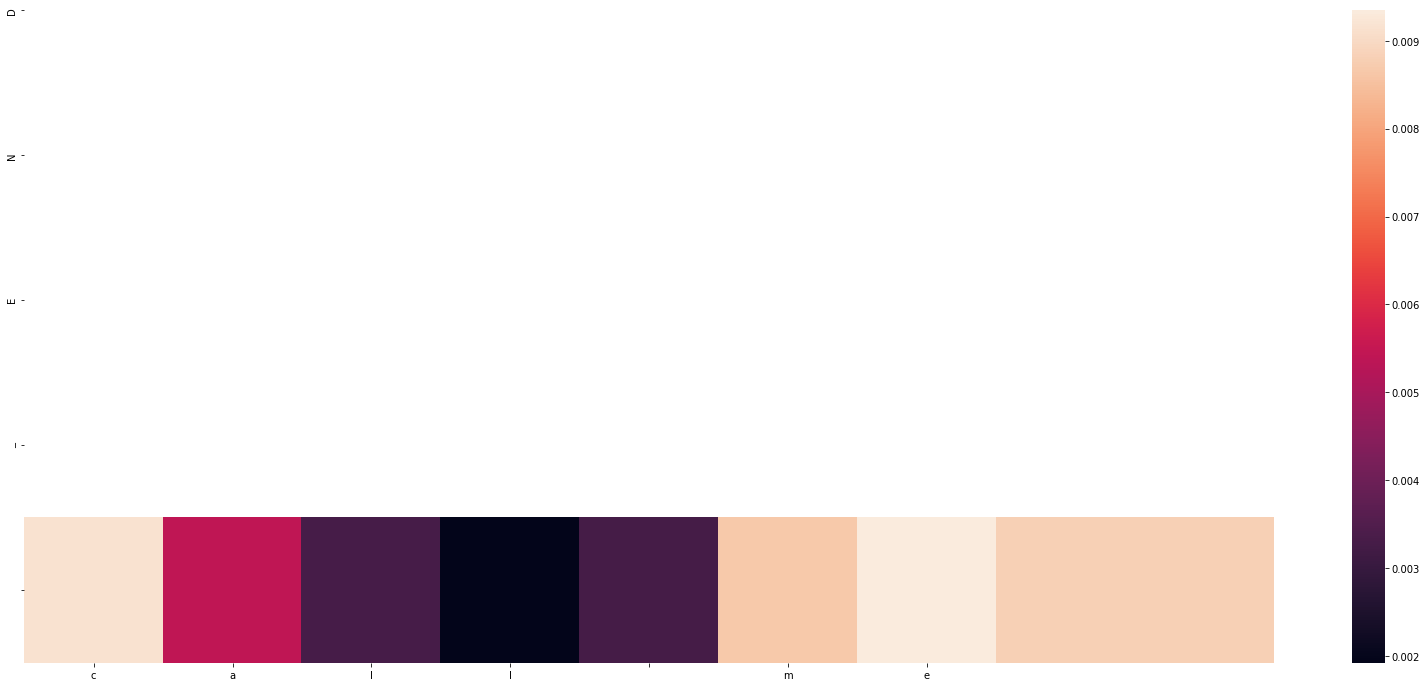

Decoded sentence:  _END
-
Input sentence: call me
GT sentence: START_ appellezmoi  _END


<Figure size 432x288 with 0 Axes>

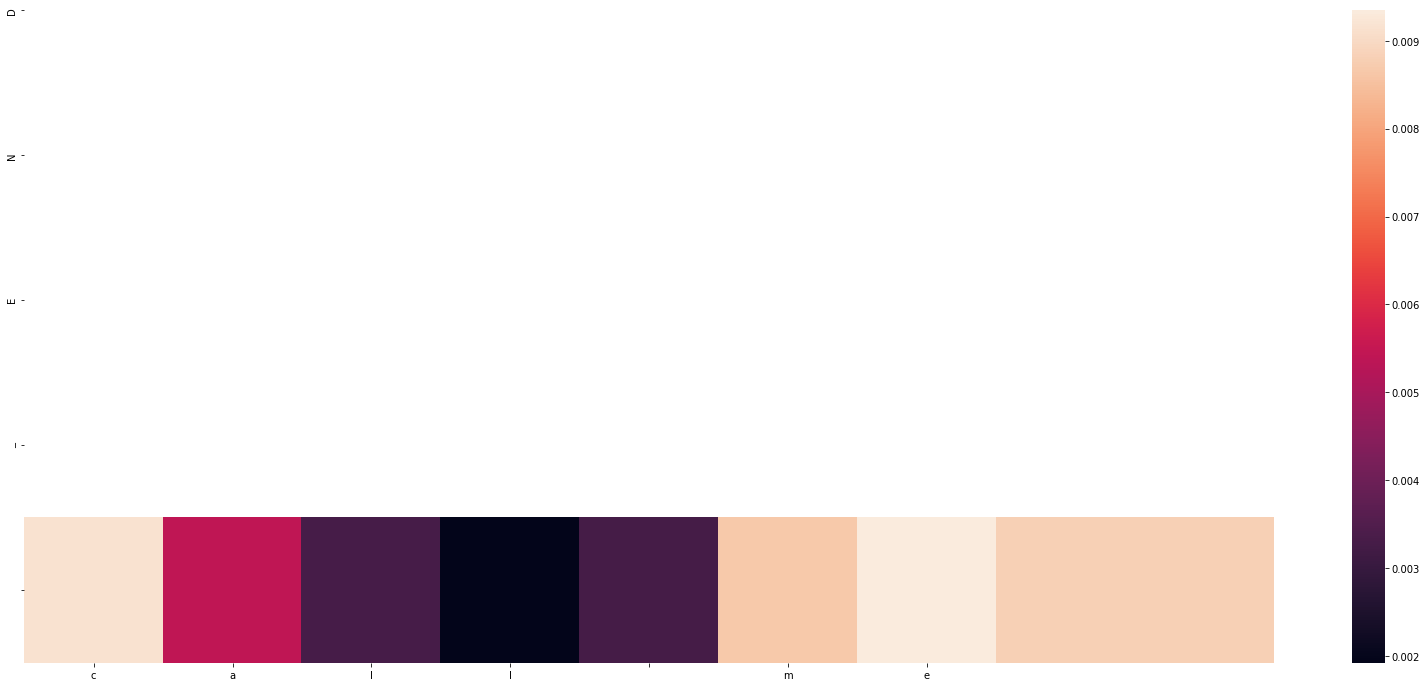

Decoded sentence:  _END
-
Input sentence: call us
GT sentence: START_ appellenous  _END


<Figure size 432x288 with 0 Axes>

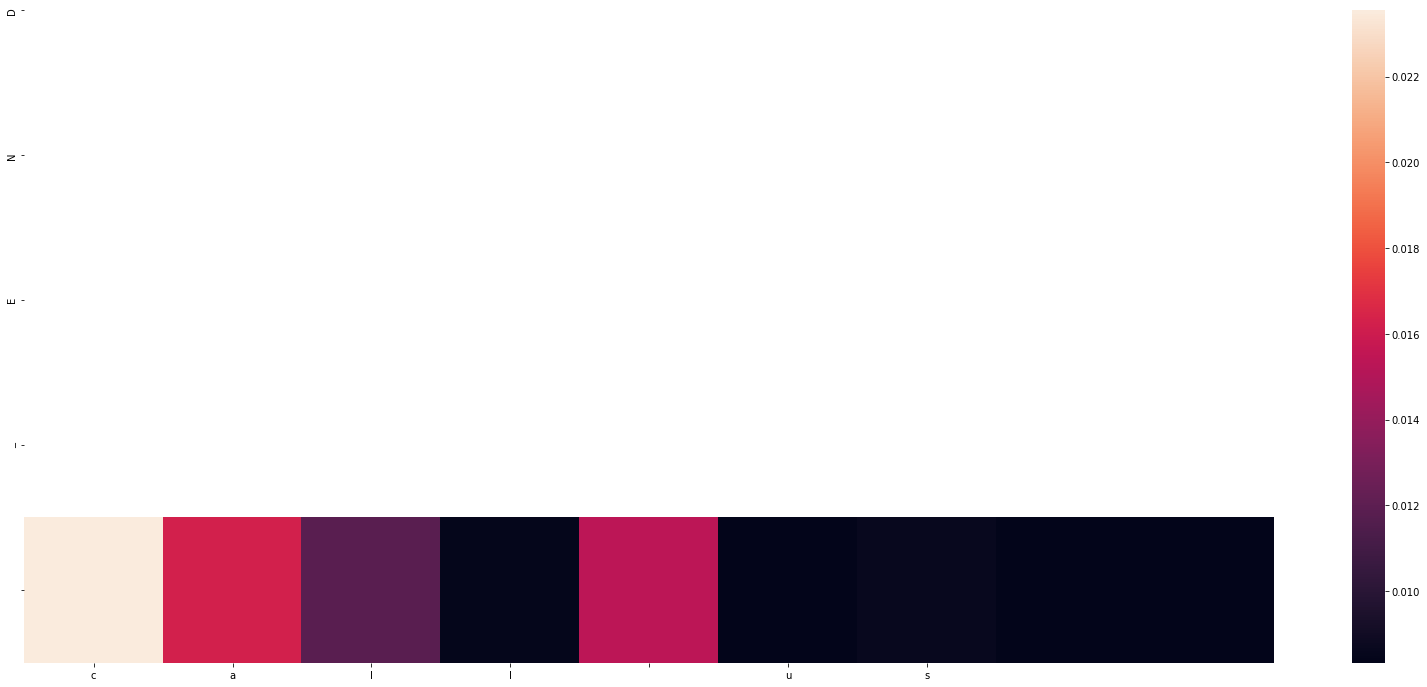

Decoded sentence:  _END
-
Input sentence: call us
GT sentence: START_ appeleznous  _END


<Figure size 432x288 with 0 Axes>

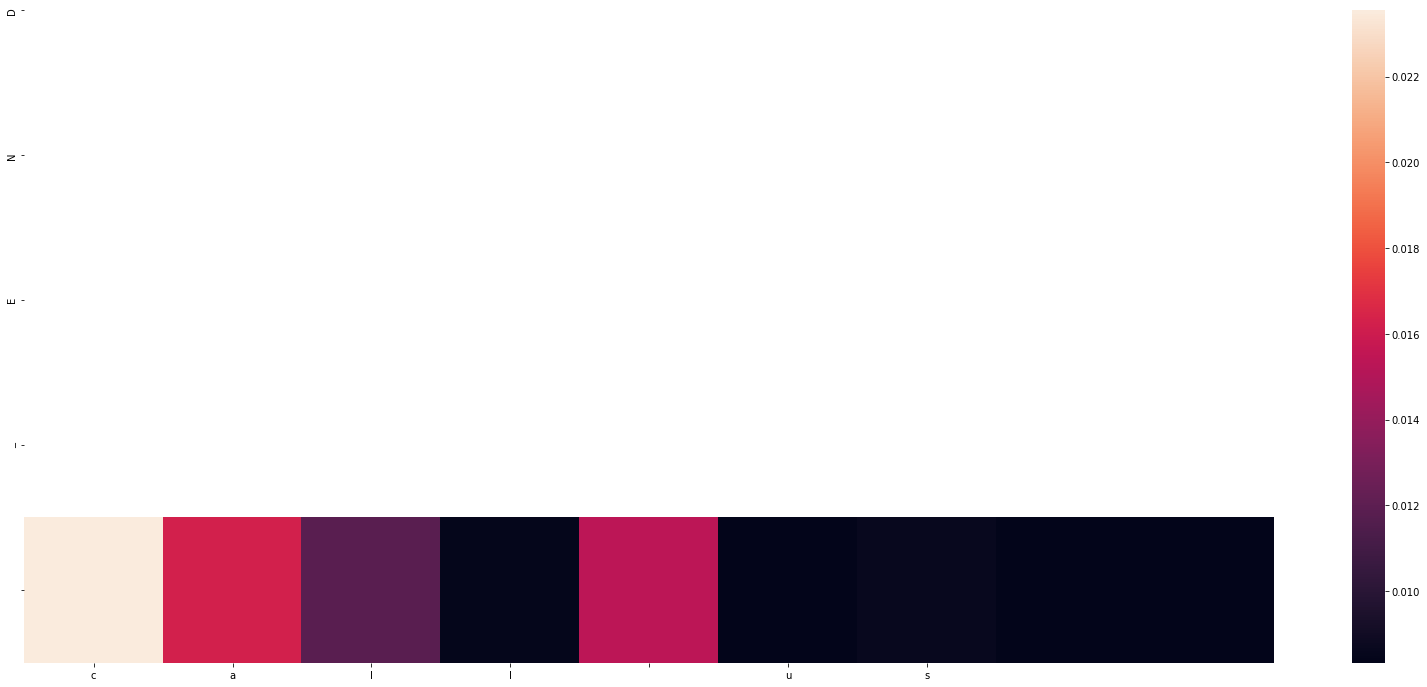

Decoded sentence:  _END
-
Input sentence: come in
GT sentence: START_ entrez  _END


<Figure size 432x288 with 0 Axes>

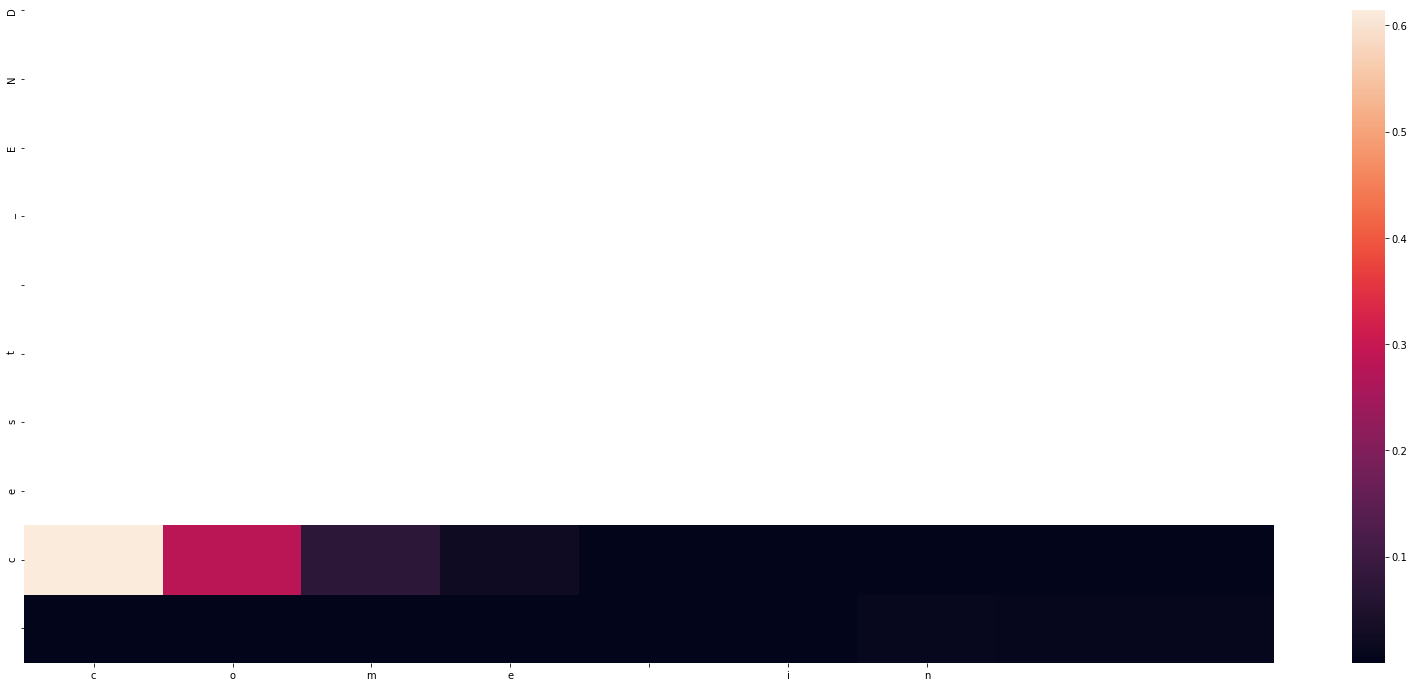

Decoded sentence:  cest _END


In [ ]:
word_decoded_sents = []
target_sents = []
for seq_index in range(100): #[14077,20122,40035,40064, 40056, 40068, 40090, 40095, 40100, 40119, 40131, 40136, 40150, 40153]:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence, attention = decode_sequence_attention(input_seq, sep='')
    print('-')
    print('Input sentence:', lines.input[seq_index: seq_index + 1])
    print('GT sentence:', lines.target[seq_index][1:-1])
    print('Decoded sentence:', decoded_sentence)
    word_decoded_sents.append(decoded_sentence)
    target_sents.append(lines.target[seq_index: seq_index][1:-1])

for seq_index in range(100):

    target_text = lines.target[seq_index]
    text = lines.input[seq_index]
    print('-')
    print('Input sentence:', text)    
    print('GT sentence:', target_text)
    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, input_token_index, reverse_target_tok_index, input_tok_split_fn, sep=' ')

    
    print('Decoded sentence:', decoded_sentence)     

In [ ]:
target_sents = list(lines.target[:100])
target_sents = [x[1:-1] for x in target_sents]
word_decoded_sents = [' '.join(x.split()[1:-1]) for x in word_decoded_sents]



In [ ]:
WER_word = calculate_WER(target_sents, word_decoded_sents)
WER_word

0.1833810888252149

# References

- [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)

- [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://keras.io/examples/lstm_seq2seq/)

- [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)

- [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025)

- https://github.com/devm2024/nmt_keras/blob/master/base.ipynb
- https://keras.io/examples/lstm_seq2seq/
- https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/